# Filament initialization in a sphere

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math
rng = np.random.default_rng() # initialize generator instance
from mpl_toolkits import mplot3d # for vizualization
%matplotlib notebook

This is a filament initializer that places the center points of filaments inside a sphere. If a constant director is chosen, this can lead to a tactoid-like configuration of filaments.

Author: Saad J. Ansari (2020)

In [3]:
# Define some constants
R = 0.64 # radius of sphere (micron)
vol_sphere = (4/3) * math.pi * R**3
n_fil = 25600;
use_pack_frac = False
pack_frac = 0.3 # packing fraction (volume of filaments inside sphere/total volume of sphere)

D = 0.007 # diameter of filaments (micron)
director = np.array([0, 0, 1]) # director vector (CAN BE RANDOMIZED)
Lmin = 0.09 # minimum length of filaments
Lmax = 0.28 # maximum length of filaments
Lmean = 0.18 # mean length of filaments
use_exp_filament_length = True # flag to sample from an exponential distribution of lengths (cutoff with Lmin and Lmax)

fname = './TubuleInitial_25600_poly.dat'
write_file = True
run_visualization = False
run_tests = False
system_offset = [2.5,2.5,2.5]

### Description:

We do this in the following way:
* Randomly sample $(x,y,z)$ where $x,y,z \in [-R,R]$ such that $x^2 + y^2 + z^2 < R^2$
* Attempt to add a filament at the sampled position:
    * Check for minimum distance to all pre-existing filaments.
    * If minimum distance is less than the filament diameter $D$, a filament instance is created and **successfully added** to a filament list.
    * If minimum distance condition is not met, the filament is **not added** to the list.
    * If a filament is added successfully, we continue. Otherwise, we sample another point and attempt a filament addition before proceeding.
* Once a filament is added, we calculate the a packing fraction for the system (if enabled).
* The steps above are repeated. The program stops when:
    * The specified number of filaments are attained, or an addition attempt fails 5000 consecutive times.
    * The specified packing fraction is attained (if enabled)

We begin by creating the machinery to achieve this.

1. **Filament( )** (class): Useful way to store information (start pt, end pt, gid, length, director) about a given filament. The choice of a class is natural when multiple instances need to be created.


2. **minDistBetweenTwoFil( )**: Calculates the minimum distance between two filaments. It parametrizes the filaments with $(s,t)$ and seeks a global minimum of $W(s,t)$, the squared distance between any two points on the two lines. If the global minimum lies outside the range of $s$ and $t$ ($s \in [0,1]$, $t \in [0,1]$), then it checks all the edges for a minimum distance. It works for both parallel and non-parallel, overlapping and skew filaments. This is adapted from http://softsurfer.com/Archive/algorithm_0106/algorithm_0106.htm#dist3D_Segment_to_Segment.


3. **minDistFilAll( )**: Calcutes the minimum distance between a single filament and a list of filaments. It loops over all filaments in the list and uses *minDistBetweenTwoFil()* to evaluate pair-pair distances. 


4. **getLengthRandomExp( )**: samples a value from an exponential distribution with min and max cutoffs for the values. We use this to sample filament lengths if enabled.


5. **sph2cart**/**cart2sph**:  transformations between cartesian and spherical coordinates.


6. **getFilamentLengthInsideSphere( )**: finds the length of a filament that lies inside a spherical region. It does that by getting points along a filament and checking their radial coordinate (in the spherical coordinate system). This gives an enclosed length of a filament which can be used to calculate an enclosed volume.

7. **getRand3PointInSphere( )**: get a random point in 3D space that is inside the sphere of some specified radius.

### Notes:

* The packing fraction calculation uses the value inside the initialization sphere. We assume that this is an accurate representation of the packing fraction throughout the system.
* The code can be easily modified to get an isotropic initial condition (randomly sample the director vector)

### Code:

In [4]:
# Define a filament class
class Filament():
    def __init__(self, center, director, leng, radius):
        self.center = center
        self.director = director/ np.linalg.norm(director)
        self.length = leng
        self.radius = radius
        self.pos_start = center - leng/2 * self.director
        self.pos_end = center + leng/2 * self.director
        self.gid = gid # defined outisde the class
    def Plot3(self,ax):
        ax.plot3D( [self.pos_start[0], self.pos_end[0]], [self.pos_start[1], self.pos_end[1]], [self.pos_start[2], self.pos_end[2]], 'red')
    def GetStringtoWrite(self):
        return 'C {0} {1} {2:0.6f} {3:0.6f} {4:0.6f} {5:0.6f} {6:0.6f} {7:0.6f}\n'.format(
        self.gid, self.radius,
        self.pos_start[0], self.pos_start[1], self.pos_start[2],
        self.pos_end[0], self.pos_end[1], self.pos_end[2])
    def __repr__(self):
        return "Filament()"
    def __str__(self):
        return 'Filament {0}:\n  pos_start: {1}\n  pos_end: {2}\n  length: {3}\n  radius: {4}'.format(self.gid, self.pos_start, self.pos_end, self.length,self.radius)

In [5]:
# Find Minimum Distance between two filaments
def minDistBetweenTwoFil(f1, f2):
    # Adapted from matlab
    # https://www.mathworks.com/matlabcentral/fileexchange/32487-shortest-distance-between-two-line-segments
    # which adapted this from Dan Sunday's Geometry Algorithms originally written in C++
    # http://softsurfer.com/Archive/algorithm_0106/algorithm_0106.htm#dist3D_Segment_to_Segment
    
    # p1 = f1.pos_start
    # p2 = f1.pos_end
    # p3 = f2.pos_start
    # p4 = f2.pos_end
    # Computes the minimum distance between two line segments. Code
    # is adapted for Matlab from Dan Sunday's Geometry Algorithms originally
    # written in C++
    # http://softsurfer.com/Archive/algorithm_0106/algorithm_0106.htm#dist3D_Segment_to_Segment
    # Usage: Input the start and end x,y,z coordinates for two line segments. 
    # p1, p2 are [x,y,z] coordinates of first line segment and p3,p4 are for
    # second line segment. 
    # Output: scalar minimum distance between the two segments.
    #  Example:
    #	P1 = [0 0 0];     P2 = [1 0 0];
    #   P3 = [0 1 0];     P4 = [1 1 0];
    #	dist = minDistBetweenTwoFil(P1, P2, P3, P4)
    p1 = f1.pos_start
    p2 = f1.pos_end
    p3 = f2.pos_start
    p4 = f2.pos_end
    
    u = p1 - p2
    v = p3 - p4
    w = p2 - p4
    
    a = np.dot(u,u)
    b = np.dot(u,v)
    c = np.dot(v,v)
    d = np.dot(u,w)
    e = np.dot(v,w)
    D = a*c - b*b
    sD = D
    tD = D
    
    SMALL_NUM = 0.00000001
    
    # compute the line parameters of the two closest points
    if D < SMALL_NUM: # the lines are almost parallel
        sN = 0.0     # force using point P0 on segment S1
        sD = 1.0     # to prevent possible division by 0.0 later
        tN = e
        tD = c
    else:             # get the closest points on the infinite lines
        sN = (b*e - c*d)
        tN = (a*e - b*d)
        if sN < 0.0:   # sc < 0 => the s=0 edge is visible       
            sN = 0.0
            tN = e
            tD = c
        elif sN > sD:  # sc > 1 => the s=1 edge is visible
            sN = sD
            tN = e + b
            tD = c
    
    if tN < 0.0:            # tc < 0 => the t=0 edge is visible
        tN = 0.0
        # recompute sc for this edge
        if -d < 0.0:
            sN = 0.0
        elif -d > a:
            sN = sD
        else:
            sN = -d
            sD = a
    elif tN > tD:       # tc > 1 => the t=1 edge is visible
        tN = tD
        # recompute sc for this edge
        if -d + b < 0.0:
            sN = 0
        elif -d + b > a:
            sN = sD
        else: 
            sN = -d + b
            sD = a
    
    # finally do the division to get sc and tc
    if  np.absolute(sN) < SMALL_NUM:
        sc = 0.0
    else:
        sc = sN / sD
    
    if np.absolute(tN) < SMALL_NUM:
        tc = 0.0
    else:
        tc = tN / tD
    
    # get the difference of the two closest points
    dP = w + (sc * u) - (tc * v);  # = S1(sc) - S2(tc)
    distance = np.linalg.norm(dP);
    outV = dP;
    
    # outV = outV      # vector connecting the closest points
    # cp_1 = p2+sc*u  # Closest point on object 1 
    # cp_2 = p4+tc*v  # Closest point on object 2
    
    return distance

In [6]:
# Define a Minimum Distance from one filament to all other filaments
def minDistFilAll( f1, f_list):
    dists = [ minDistBetweenTwoFil(f1,f2) for f2 in f_list]
    if not dists:
        return 1e6
    else:
        return np.min(dists)

In [7]:
# Define a random length sampler
def getLengthRandomExp( rng, Lmean, Lmin=0, Lmax=1e6):
    val = -1
    while val < Lmin or val > Lmax:
        val = rng.exponential( Lmean)
    return val

In [8]:
# polar to cartesian coordinates
def sph2cart(r, phi, theta):
    return np.array([
         r * math.sin(theta) * math.cos(phi),
         r * math.sin(theta) * math.sin(phi),
         r * math.cos(theta)
    ])
# cartesian to polar coordinates
def cart2sph(x, y, z):
    XsqPlusYsq = x**2 + y**2
    r = math.sqrt(XsqPlusYsq + z**2)               # r
    elev = math.atan2(z,math.sqrt(XsqPlusYsq))     # theta
    az = math.atan2(y,x)                           # phi
    return np.array([r, az, elev])

In [9]:
# volume of filament inside sphere
def getFilamentLengthInsideSphere(f1, rad):
    
    # Find coordinates along the filament whose r coord in (r,phi, theta) lies inside the sphere.
    # Segment the filament into 100 points
    lens = np.linspace(0, f1.length, 100)
    num_in = 0
    for el in lens:
        [x,y,z] = f1.pos_start + el*f1.director
        pt = cart2sph(x,y,z)
        if pt[0] < rad:
            num_in += 1
        
    return (num_in/100)*f1.length

In [10]:
# Get random 3d cartesian point() inside sphere
def getRand3PointInSphere(rad):
    d = 2*rad
    while d > rad:
        xyz = rng.uniform(-rad, rad, 3)
        d = np.linalg.norm(xyz)
    return [xyz[0],xyz[1],xyz[2]]

#    radius = np.random.uniform(0.0,1.0)*rad 
#    theta = np.random.uniform(-1.0,1.0)*math.pi
#    phi = np.arccos(1-2*np.random.uniform(0.0,1.))
#    x = radius * np.sin( theta ) * np.cos( phi )
#    y = radius * np.sin( theta ) * np.sin( phi )
#    z = radius * np.cos( theta )
#    return [x,y,z]

We start with a sphere with radius R. We randomly pick values (r,phi, theta) that define the position of a point in 3D space. We attempt to insert a filament with that point as its center. If the minimum distance between this filament and any other filaments is greater than diameter D of the filaments (i.e filaments do not overlap), we successfully complete the insertion. If insertion fails, we try a new point.

In [11]:
def attemptAddFilament(center, L, director, D, f_list, gid):
    # Initialize a  filament of length L
    fil = Filament(center, director, L, D/2)
    
    # find minimum distance to other filaments, and accept if distance is more than filament diameter
    min_dist = minDistFilAll(fil, f_list)
    status = False
    if min_dist > D:
        f_list.append(fil)
        gid+=1
        print(fil)
        status = True
    return f_list,gid,status

# There are two ways to go about this.
# 1. Attempt to achieve a specified packing fraction
# 2. Attempt to initialize a specified number of rods

gid = 0
f_list = [] # list to store filaments
if use_pack_frac:
    
    v_enclosed = 0 # volume occupied by filaments inside the sphere
    cpf = 0 # current packing fraction tracker
    while cpf < pack_frac:
        center = getRand3PointInSphere(R) # Sample a random (x,y,z inside a sphere)
        
        if use_exp_filament_length:
            L = getLengthRandomExp( rng, Lmean, Lmin, Lmax)
        else:
            L = Lmean
            
        f_list,gid,status = attemptAddFilament(center,L,director, D, f_list, gid)
        if status:
            len_inside = getFilamentLengthInsideSphere( f_list[-1], R) # length of filament inside the sphere
            v_enclosed += math.pi * (D/2)**2 * len_inside # volume of filament inside the sphere
            cpf = v_enclosed / vol_sphere # current packing fraction
            print('CPF = {}'.format(cpf))

    
else:
    
    # sample n_fil length values and sort them
    if use_exp_filament_length:
        lens = sorted( [getLengthRandomExp( rng, Lmean, Lmin, Lmax) for i in range(n_fil)], reverse=True)
    else:
        lens = [Lmean for i in range(n_fil)]
        
    for idx,el in enumerate(lens):
        status = False
        failCount=0
        while not status:
            failCount+=1
            center = getRand3PointInSphere(R) # Sample a random (x,y,z inside a sphere)
            f_list,gid,status = attemptAddFilament(center, el, director, D, f_list, gid)
            if failCount > 5000:
                raise Exception('Failed to add a filament with 5000 trials.\nStopping...\n...\n...\n Total Added Filaments = {}'.format(len(f_list)))

Filament 0:
  pos_start: [-0.26865952 -0.18820941 -0.65650814]
  pos_end: [-0.26865952 -0.18820941 -0.37651196]
  length: 0.27999618428375206
  radius: 0.0035
Filament 1:
  pos_start: [2.34956144e-04 2.90058164e-01 1.64216802e-01]
  pos_end: [2.34956144e-04 2.90058164e-01 4.44189852e-01]
  length: 0.27997304999680145
  radius: 0.0035
Filament 2:
  pos_start: [-0.4143049   0.43356435 -0.15002703]
  pos_end: [-0.4143049   0.43356435  0.12993221]
  length: 0.2799592392147811
  radius: 0.0035
Filament 3:
  pos_start: [-0.06696011 -0.00821225 -0.43920428]
  pos_end: [-0.06696011 -0.00821225 -0.1592693 ]
  length: 0.279934973401812
  radius: 0.0035
Filament 4:
  pos_start: [-0.23093927 -0.37279722  0.31241256]
  pos_end: [-0.23093927 -0.37279722  0.59234619]
  length: 0.27993363253159065
  radius: 0.0035
Filament 5:
  pos_start: [-0.18338768 -0.31766176  0.30543   ]
  pos_end: [-0.18338768 -0.31766176  0.58536269]
  length: 0.27993268977020286
  radius: 0.0035
Filament 6:
  pos_start: [ 0.41

  radius: 0.0035
Filament 80:
  pos_start: [ 0.53393542  0.0625713  -0.30501551]
  pos_end: [ 0.53393542  0.0625713  -0.0260914 ]
  length: 0.27892410462295647
  radius: 0.0035
Filament 81:
  pos_start: [ 0.06484298 -0.35052036 -0.32059931]
  pos_end: [ 0.06484298 -0.35052036 -0.04167609]
  length: 0.27892321820173854
  radius: 0.0035
Filament 82:
  pos_start: [ 0.38976509 -0.38818062 -0.06068452]
  pos_end: [ 0.38976509 -0.38818062  0.21819433]
  length: 0.2788788501709799
  radius: 0.0035
Filament 83:
  pos_start: [-0.09594656 -0.00811682 -0.46130572]
  pos_end: [-0.09594656 -0.00811682 -0.18242764]
  length: 0.27887807967080386
  radius: 0.0035
Filament 84:
  pos_start: [-0.05038463  0.06922901 -0.11365483]
  pos_end: [-0.05038463  0.06922901  0.16520665]
  length: 0.2788614737117438
  radius: 0.0035
Filament 85:
  pos_start: [-0.10220137 -0.08561015 -0.33217541]
  pos_end: [-0.10220137 -0.08561015 -0.05332238]
  length: 0.27885303455419547
  radius: 0.0035
Filament 86:
  pos_start:

Filament 150:
  pos_start: [ 0.30789297  0.41670451 -0.50674962]
  pos_end: [ 0.30789297  0.41670451 -0.22874524]
  length: 0.2780043802333146
  radius: 0.0035
Filament 151:
  pos_start: [0.28572443 0.48381248 0.06044288]
  pos_end: [0.28572443 0.48381248 0.33844376]
  length: 0.27800087767119314
  radius: 0.0035
Filament 152:
  pos_start: [-0.40872585  0.3996558  -0.36439405]
  pos_end: [-0.40872585  0.3996558  -0.0864039 ]
  length: 0.277990145169858
  radius: 0.0035
Filament 153:
  pos_start: [-0.21620083  0.41194564 -0.41455805]
  pos_end: [-0.21620083  0.41194564 -0.13657702]
  length: 0.2779810327738214
  radius: 0.0035
Filament 154:
  pos_start: [0.38147496 0.19779013 0.04058942]
  pos_end: [0.38147496 0.19779013 0.31856983]
  length: 0.27798041579898114
  radius: 0.0035
Filament 155:
  pos_start: [-0.13753103 -0.45952219  0.13527023]
  pos_end: [-0.13753103 -0.45952219  0.4132388 ]
  length: 0.2779685683135229
  radius: 0.0035
Filament 156:
  pos_start: [ 0.26342964 -0.33051357

Filament 211:
  pos_start: [-0.00599124 -0.60867241 -0.27981924]
  pos_end: [-0.00599124 -0.60867241 -0.00259707]
  length: 0.27722217409168887
  radius: 0.0035
Filament 212:
  pos_start: [-0.34205301 -0.12576173 -0.65297516]
  pos_end: [-0.34205301 -0.12576173 -0.37575951]
  length: 0.277215642954024
  radius: 0.0035
Filament 213:
  pos_start: [-0.46642268  0.11420196 -0.39001185]
  pos_end: [-0.46642268  0.11420196 -0.11282745]
  length: 0.2771844001821658
  radius: 0.0035
Filament 214:
  pos_start: [-0.42765481 -0.04886046  0.06084221]
  pos_end: [-0.42765481 -0.04886046  0.33802225]
  length: 0.27718003045629064
  radius: 0.0035
Filament 215:
  pos_start: [ 0.38828519  0.41883427 -0.42530453]
  pos_end: [ 0.38828519  0.41883427 -0.14813293]
  length: 0.2771715988279879
  radius: 0.0035
Filament 216:
  pos_start: [0.10102277 0.52637763 0.14533562]
  pos_end: [0.10102277 0.52637763 0.42248354]
  length: 0.27714791780848136
  radius: 0.0035
Filament 217:
  pos_start: [-0.17416673 -0.4

Filament 279:
  pos_start: [-0.01481694 -0.51759214  0.12323847]
  pos_end: [-0.01481694 -0.51759214  0.39950898]
  length: 0.2762705156294751
  radius: 0.0035
Filament 280:
  pos_start: [-0.55296412  0.18783893 -0.14570326]
  pos_end: [-0.55296412  0.18783893  0.13056505]
  length: 0.2762683189736821
  radius: 0.0035
Filament 281:
  pos_start: [ 0.02991223  0.06969746 -0.55826079]
  pos_end: [ 0.02991223  0.06969746 -0.28199619]
  length: 0.2762646044202985
  radius: 0.0035
Filament 282:
  pos_start: [ 0.27657252 -0.04284249 -0.34019929]
  pos_end: [ 0.27657252 -0.04284249 -0.0639575 ]
  length: 0.2762417929849959
  radius: 0.0035
Filament 283:
  pos_start: [ 0.40254137 -0.18174083  0.00738968]
  pos_end: [ 0.40254137 -0.18174083  0.28362846]
  length: 0.27623877909117917
  radius: 0.0035
Filament 284:
  pos_start: [ 0.10328942  0.02039368 -0.10573088]
  pos_end: [0.10328942 0.02039368 0.17050663]
  length: 0.27623750511357714
  radius: 0.0035
Filament 285:
  pos_start: [ 0.37843751  

Filament 347:
  pos_start: [ 0.56237975  0.16109535 -0.29172887]
  pos_end: [ 0.56237975  0.16109535 -0.01629493]
  length: 0.2754339384931114
  radius: 0.0035
Filament 348:
  pos_start: [-0.13221242  0.162912    0.0970157 ]
  pos_end: [-0.13221242  0.162912    0.37244916]
  length: 0.275433466031395
  radius: 0.0035
Filament 349:
  pos_start: [-0.17127425 -0.45778411 -0.16718616]
  pos_end: [-0.17127425 -0.45778411  0.10821838]
  length: 0.2754045321363085
  radius: 0.0035
Filament 350:
  pos_start: [ 0.14097728 -0.59510539 -0.03064483]
  pos_end: [ 0.14097728 -0.59510539  0.24475678]
  length: 0.2754016069736131
  radius: 0.0035
Filament 351:
  pos_start: [ 0.26224805  0.01652209 -0.18169388]
  pos_end: [0.26224805 0.01652209 0.09370383]
  length: 0.27539771608749225
  radius: 0.0035
Filament 352:
  pos_start: [ 0.18557746 -0.12013111  0.2786724 ]
  pos_end: [ 0.18557746 -0.12013111  0.55406999]
  length: 0.2753975891373818
  radius: 0.0035
Filament 353:
  pos_start: [-0.18341291 -0.

Filament 413:
  pos_start: [ 0.43806684 -0.33925375 -0.24118167]
  pos_end: [ 0.43806684 -0.33925375  0.03350513]
  length: 0.2746868069364791
  radius: 0.0035
Filament 414:
  pos_start: [0.24482371 0.06227208 0.11815367]
  pos_end: [0.24482371 0.06227208 0.39281993]
  length: 0.27466625958298113
  radius: 0.0035
Filament 415:
  pos_start: [ 0.09068467  0.44876641 -0.31341913]
  pos_end: [ 0.09068467  0.44876641 -0.03876143]
  length: 0.2746576996794005
  radius: 0.0035
Filament 416:
  pos_start: [-0.01284739 -0.06402012  0.16831687]
  pos_end: [-0.01284739 -0.06402012  0.44296392]
  length: 0.27464704920366384
  radius: 0.0035
Filament 417:
  pos_start: [ 0.04541071 -0.50821142 -0.46883252]
  pos_end: [ 0.04541071 -0.50821142 -0.19419574]
  length: 0.2746367789370372
  radius: 0.0035
Filament 418:
  pos_start: [ 0.2857971  -0.00293372 -0.36223492]
  pos_end: [ 0.2857971  -0.00293372 -0.0876001 ]
  length: 0.2746348171903505
  radius: 0.0035
Filament 419:
  pos_start: [-0.16616856  0.0

Filament 476:
  pos_start: [-0.44620992 -0.05868028 -0.25524633]
  pos_end: [-0.44620992 -0.05868028  0.01873766]
  length: 0.27398398980301675
  radius: 0.0035
Filament 477:
  pos_start: [ 0.10016533  0.22743784 -0.68169751]
  pos_end: [ 0.10016533  0.22743784 -0.40772063]
  length: 0.2739768803414807
  radius: 0.0035
Filament 478:
  pos_start: [-0.1005168  -0.59569425 -0.07324958]
  pos_end: [-0.1005168  -0.59569425  0.20071893]
  length: 0.27396850725222327
  radius: 0.0035
Filament 479:
  pos_start: [-0.03153888 -0.09416032 -0.09416393]
  pos_end: [-0.03153888 -0.09416032  0.17979062]
  length: 0.27395455057142765
  radius: 0.0035
Filament 480:
  pos_start: [-0.33334325  0.2269961  -0.11207636]
  pos_end: [-0.33334325  0.2269961   0.16186617]
  length: 0.2739425323184247
  radius: 0.0035
Filament 481:
  pos_start: [ 0.02708381 -0.26661446  0.03298373]
  pos_end: [ 0.02708381 -0.26661446  0.306923  ]
  length: 0.2739392736311983
  radius: 0.0035
Filament 482:
  pos_start: [ 0.184573

Filament 535:
  pos_start: [ 0.48715352 -0.04576883 -0.31297144]
  pos_end: [ 0.48715352 -0.04576883 -0.03977411]
  length: 0.27319733152190645
  radius: 0.0035
Filament 536:
  pos_start: [ 0.28343126  0.25243186 -0.64543837]
  pos_end: [ 0.28343126  0.25243186 -0.37224679]
  length: 0.27319157631901825
  radius: 0.0035
Filament 537:
  pos_start: [ 0.48229387 -0.12769173  0.10653755]
  pos_end: [ 0.48229387 -0.12769173  0.37971355]
  length: 0.2731759965219463
  radius: 0.0035
Filament 538:
  pos_start: [-0.12842005  0.22202176 -0.61246084]
  pos_end: [-0.12842005  0.22202176 -0.33928781]
  length: 0.27317302695775075
  radius: 0.0035
Filament 539:
  pos_start: [ 0.09354051  0.51619019 -0.45614079]
  pos_end: [ 0.09354051  0.51619019 -0.18301016]
  length: 0.2731306300885688
  radius: 0.0035
Filament 540:
  pos_start: [ 0.47440648 -0.08143594  0.10468448]
  pos_end: [ 0.47440648 -0.08143594  0.37781492]
  length: 0.2731304412847102
  radius: 0.0035
Filament 541:
  pos_start: [-0.034506

Filament 589:
  pos_start: [ 0.61801001 -0.0227294  -0.03230329]
  pos_end: [ 0.61801001 -0.0227294   0.24011221]
  length: 0.2724154979189343
  radius: 0.0035
Filament 590:
  pos_start: [ 0.18223739  0.46330863 -0.17953329]
  pos_end: [0.18223739 0.46330863 0.0928759 ]
  length: 0.27240918496893607
  radius: 0.0035
Filament 591:
  pos_start: [-0.4221486   0.44846651 -0.17557994]
  pos_end: [-0.4221486   0.44846651  0.09680154]
  length: 0.2723814882711249
  radius: 0.0035
Filament 592:
  pos_start: [ 0.12162022  0.16249589 -0.56171475]
  pos_end: [ 0.12162022  0.16249589 -0.28934242]
  length: 0.27237232917397325
  radius: 0.0035
Filament 593:
  pos_start: [ 0.32183826 -0.21035564 -0.63132722]
  pos_end: [ 0.32183826 -0.21035564 -0.35895979]
  length: 0.27236742277615805
  radius: 0.0035
Filament 594:
  pos_start: [-0.14985984 -0.37334804 -0.18660002]
  pos_end: [-0.14985984 -0.37334804  0.08573293]
  length: 0.27233295157617204
  radius: 0.0035
Filament 595:
  pos_start: [0.32782753 

Filament 649:
  pos_start: [ 0.2762887  -0.16742628 -0.20466726]
  pos_end: [ 0.2762887  -0.16742628  0.06693445]
  length: 0.27160170790438826
  radius: 0.0035
Filament 650:
  pos_start: [-0.53779049 -0.01918809 -0.20358096]
  pos_end: [-0.53779049 -0.01918809  0.06800304]
  length: 0.27158399459168425
  radius: 0.0035
Filament 651:
  pos_start: [0.02911732 0.50365559 0.17198198]
  pos_end: [0.02911732 0.50365559 0.44356342]
  length: 0.2715814416189786
  radius: 0.0035
Filament 652:
  pos_start: [ 0.09727321 -0.06904536  0.20770109]
  pos_end: [ 0.09727321 -0.06904536  0.47924268]
  length: 0.27154159605538025
  radius: 0.0035
Filament 653:
  pos_start: [-0.04074797 -0.23058513 -0.03059381]
  pos_end: [-0.04074797 -0.23058513  0.24094151]
  length: 0.27153532500382815
  radius: 0.0035
Filament 654:
  pos_start: [ 0.07554267  0.57543198 -0.03096274]
  pos_end: [0.07554267 0.57543198 0.24054376]
  length: 0.2715065088475332
  radius: 0.0035
Filament 655:
  pos_start: [-0.1722742  -0.00

Filament 705:
  pos_start: [0.02279641 0.40234732 0.0710454 ]
  pos_end: [0.02279641 0.40234732 0.34201236]
  length: 0.27096696074466525
  radius: 0.0035
Filament 706:
  pos_start: [ 0.4137572   0.38887507 -0.20664612]
  pos_end: [0.4137572  0.38887507 0.06431187]
  length: 0.2709579897467039
  radius: 0.0035
Filament 707:
  pos_start: [ 0.04488297  0.23633927 -0.58642399]
  pos_end: [ 0.04488297  0.23633927 -0.31547266]
  length: 0.2709513289619715
  radius: 0.0035
Filament 708:
  pos_start: [-0.12904841  0.13737738 -0.48734884]
  pos_end: [-0.12904841  0.13737738 -0.216404  ]
  length: 0.2709448437125886
  radius: 0.0035
Filament 709:
  pos_start: [-0.34600559 -0.35644612 -0.52144554]
  pos_end: [-0.34600559 -0.35644612 -0.25051145]
  length: 0.2709340981431067
  radius: 0.0035
Filament 710:
  pos_start: [ 0.31114994  0.13647403 -0.51485799]
  pos_end: [ 0.31114994  0.13647403 -0.24393021]
  length: 0.27092778027127046
  radius: 0.0035
Filament 711:
  pos_start: [ 0.05956616  0.5225

Filament 764:
  pos_start: [-0.05106938  0.26260016 -0.56553268]
  pos_end: [-0.05106938  0.26260016 -0.29516706]
  length: 0.2703656202075563
  radius: 0.0035
Filament 765:
  pos_start: [ 0.55016981 -0.28262222 -0.23924786]
  pos_end: [ 0.55016981 -0.28262222  0.03111308]
  length: 0.27036093488730445
  radius: 0.0035
Filament 766:
  pos_start: [-0.15517346  0.33871868  0.29454642]
  pos_end: [-0.15517346  0.33871868  0.5648758 ]
  length: 0.27032938794187716
  radius: 0.0035
Filament 767:
  pos_start: [ 0.23562424  0.28633477 -0.44503524]
  pos_end: [ 0.23562424  0.28633477 -0.17471657]
  length: 0.2703186709451852
  radius: 0.0035
Filament 768:
  pos_start: [0.45120504 0.19799943 0.0798426 ]
  pos_end: [0.45120504 0.19799943 0.35014917]
  length: 0.27030656568349193
  radius: 0.0035
Filament 769:
  pos_start: [-0.35385936 -0.3196859  -0.00699603]
  pos_end: [-0.35385936 -0.3196859   0.26331028]
  length: 0.2703063131367634
  radius: 0.0035
Filament 770:
  pos_start: [ 0.2267431   0.

Filament 822:
  pos_start: [ 0.1159853   0.2781813  -0.11094679]
  pos_end: [0.1159853  0.2781813  0.15874426]
  length: 0.2696910549616851
  radius: 0.0035
Filament 823:
  pos_start: [ 0.03552749  0.12197127 -0.12317433]
  pos_end: [0.03552749 0.12197127 0.14651326]
  length: 0.2696875859919331
  radius: 0.0035
Filament 824:
  pos_start: [-0.37159841 -0.33401835 -0.24141776]
  pos_end: [-0.37159841 -0.33401835  0.0282442 ]
  length: 0.26966196204792364
  radius: 0.0035
Filament 825:
  pos_start: [-0.54408568  0.0101984   0.00135754]
  pos_end: [-0.54408568  0.0101984   0.27100962]
  length: 0.2696520832589689
  radius: 0.0035
Filament 826:
  pos_start: [ 0.12133016 -0.48588698 -0.49634995]
  pos_end: [ 0.12133016 -0.48588698 -0.22670186]
  length: 0.2696480926996933
  radius: 0.0035
Filament 827:
  pos_start: [-0.48398561  0.10976763 -0.46288796]
  pos_end: [-0.48398561  0.10976763 -0.19324473]
  length: 0.26964322404218394
  radius: 0.0035
Filament 828:
  pos_start: [0.31225002 0.027

Filament 876:
  pos_start: [0.09950293 0.1520209  0.20287179]
  pos_end: [0.09950293 0.1520209  0.4719941 ]
  length: 0.2691223062584731
  radius: 0.0035
Filament 877:
  pos_start: [-0.43093962 -0.34009857 -0.00989044]
  pos_end: [-0.43093962 -0.34009857  0.25922218]
  length: 0.26911262246590606
  radius: 0.0035
Filament 878:
  pos_start: [0.03274893 0.32459496 0.36462136]
  pos_end: [0.03274893 0.32459496 0.63372056]
  length: 0.26909920379712476
  radius: 0.0035
Filament 879:
  pos_start: [ 0.41562274 -0.37204583 -0.23558376]
  pos_end: [ 0.41562274 -0.37204583  0.03350803]
  length: 0.26909178803266176
  radius: 0.0035
Filament 880:
  pos_start: [ 0.1653006   0.07605739 -0.29607746]
  pos_end: [ 0.1653006   0.07605739 -0.0269878 ]
  length: 0.2690896553888377
  radius: 0.0035
Filament 881:
  pos_start: [-0.11300223  0.50197774  0.11974494]
  pos_end: [-0.11300223  0.50197774  0.38883267]
  length: 0.26908773026914395
  radius: 0.0035
Filament 882:
  pos_start: [-0.51440768  0.24851

Filament 936:
  pos_start: [ 0.14126209 -0.34086671 -0.2159282 ]
  pos_end: [ 0.14126209 -0.34086671  0.05232414]
  length: 0.2682523378164195
  radius: 0.0035
Filament 937:
  pos_start: [-0.25495192 -0.06001688  0.02273265]
  pos_end: [-0.25495192 -0.06001688  0.2909728 ]
  length: 0.26824015172926324
  radius: 0.0035
Filament 938:
  pos_start: [-0.12774256 -0.33527609 -0.2060144 ]
  pos_end: [-0.12774256 -0.33527609  0.0622241 ]
  length: 0.2682384944832743
  radius: 0.0035
Filament 939:
  pos_start: [ 0.28199714  0.11127019 -0.33313759]
  pos_end: [ 0.28199714  0.11127019 -0.06490538]
  length: 0.268232213526348
  radius: 0.0035
Filament 940:
  pos_start: [ 0.33216485 -0.16461434 -0.09679276]
  pos_end: [ 0.33216485 -0.16461434  0.17143565]
  length: 0.2682284021998967
  radius: 0.0035
Filament 941:
  pos_start: [ 0.4494005  -0.03986826 -0.08818   ]
  pos_end: [ 0.4494005  -0.03986826  0.18003318]
  length: 0.2682131846543875
  radius: 0.0035
Filament 942:
  pos_start: [-0.08697548 

Filament 989:
  pos_start: [-0.39202772  0.25384848 -0.22824193]
  pos_end: [-0.39202772  0.25384848  0.03943317]
  length: 0.2676751000584608
  radius: 0.0035
Filament 990:
  pos_start: [-0.5736385  -0.10923694  0.07254002]
  pos_end: [-0.5736385  -0.10923694  0.34020631]
  length: 0.26766629046489565
  radius: 0.0035
Filament 991:
  pos_start: [ 0.12616056 -0.23401947  0.37301698]
  pos_end: [ 0.12616056 -0.23401947  0.64068094]
  length: 0.26766395979388846
  radius: 0.0035
Filament 992:
  pos_start: [ 0.42531787 -0.2397845  -0.0287322 ]
  pos_end: [ 0.42531787 -0.2397845   0.23891427]
  length: 0.26764646466400394
  radius: 0.0035
Filament 993:
  pos_start: [ 0.11659851 -0.30314193  0.33517687]
  pos_end: [ 0.11659851 -0.30314193  0.60281961]
  length: 0.2676427393222764
  radius: 0.0035
Filament 994:
  pos_start: [ 0.14581148  0.34588661 -0.23974454]
  pos_end: [0.14581148 0.34588661 0.02787082]
  length: 0.2676153666461576
  radius: 0.0035
Filament 995:
  pos_start: [-0.63050703 

Filament 1046:
  pos_start: [ 0.57804202  0.25001306 -0.22585581]
  pos_end: [0.57804202 0.25001306 0.04101537]
  length: 0.2668711784088121
  radius: 0.0035
Filament 1047:
  pos_start: [-0.29807792  0.31919707  0.26339527]
  pos_end: [-0.29807792  0.31919707  0.53025864]
  length: 0.2668633708810445
  radius: 0.0035
Filament 1048:
  pos_start: [ 0.03071004 -0.06701973 -0.20115097]
  pos_end: [ 0.03071004 -0.06701973  0.0657087 ]
  length: 0.26685966496250496
  radius: 0.0035
Filament 1049:
  pos_start: [-0.31875913  0.11136184  0.34959591]
  pos_end: [-0.31875913  0.11136184  0.61642639]
  length: 0.2668304797215473
  radius: 0.0035
Filament 1050:
  pos_start: [-0.37866622 -0.09770299 -0.55511748]
  pos_end: [-0.37866622 -0.09770299 -0.28830539]
  length: 0.2668120945762611
  radius: 0.0035
Filament 1051:
  pos_start: [-0.38977844  0.2906428  -0.08245235]
  pos_end: [-0.38977844  0.2906428   0.18434656]
  length: 0.26679890968420444
  radius: 0.0035
Filament 1052:
  pos_start: [-0.288

Filament 1098:
  pos_start: [-0.05432337  0.46993938  0.17801667]
  pos_end: [-0.05432337  0.46993938  0.44423637]
  length: 0.2662196974466679
  radius: 0.0035
Filament 1099:
  pos_start: [-0.20601073 -0.25379288 -0.0276    ]
  pos_end: [-0.20601073 -0.25379288  0.23860557]
  length: 0.2662055707244605
  radius: 0.0035
Filament 1100:
  pos_start: [-0.34447154  0.35679548  0.23475594]
  pos_end: [-0.34447154  0.35679548  0.50095717]
  length: 0.2662012311558934
  radius: 0.0035
Filament 1101:
  pos_start: [ 0.17994256  0.3245858  -0.23177927]
  pos_end: [0.17994256 0.3245858  0.03441586]
  length: 0.26619512850632493
  radius: 0.0035
Filament 1102:
  pos_start: [ 0.13987136  0.22036161 -0.16871752]
  pos_end: [0.13987136 0.22036161 0.09747067]
  length: 0.2661881911063209
  radius: 0.0035
Filament 1103:
  pos_start: [ 0.59844747  0.0828084  -0.29095353]
  pos_end: [ 0.59844747  0.0828084  -0.0247654 ]
  length: 0.2661881314798746
  radius: 0.0035
Filament 1104:
  pos_start: [-0.0602807

Filament 1150:
  pos_start: [-0.33907873 -0.17935807  0.26285859]
  pos_end: [-0.33907873 -0.17935807  0.52853565]
  length: 0.2656770518302142
  radius: 0.0035
Filament 1151:
  pos_start: [-0.02381364  0.21936325 -0.60362137]
  pos_end: [-0.02381364  0.21936325 -0.33795136]
  length: 0.2656700136197752
  radius: 0.0035
Filament 1152:
  pos_start: [ 0.19124195  0.00103414 -0.64438783]
  pos_end: [ 0.19124195  0.00103414 -0.37872794]
  length: 0.26565989785609406
  radius: 0.0035
Filament 1153:
  pos_start: [-0.10159447  0.38768228  0.26033669]
  pos_end: [-0.10159447  0.38768228  0.52599512]
  length: 0.26565842696219083
  radius: 0.0035
Filament 1154:
  pos_start: [ 0.0038813  -0.02557765  0.03051405]
  pos_end: [ 0.0038813  -0.02557765  0.29615935]
  length: 0.2656452936670414
  radius: 0.0035
Filament 1155:
  pos_start: [-0.36151686 -0.08198294  0.0520571 ]
  pos_end: [-0.36151686 -0.08198294  0.31770032]
  length: 0.26564321919716655
  radius: 0.0035
Filament 1156:
  pos_start: [-0

Filament 1206:
  pos_start: [0.0628589  0.11716276 0.02146831]
  pos_end: [0.0628589  0.11716276 0.28650665]
  length: 0.2650383356591692
  radius: 0.0035
Filament 1207:
  pos_start: [0.16893483 0.33868585 0.1209019 ]
  pos_end: [0.16893483 0.33868585 0.38593626]
  length: 0.2650343610550202
  radius: 0.0035
Filament 1208:
  pos_start: [-0.22160877  0.33395637  0.24205844]
  pos_end: [-0.22160877  0.33395637  0.5070916 ]
  length: 0.26503316530448906
  radius: 0.0035
Filament 1209:
  pos_start: [0.29969424 0.38665239 0.21431581]
  pos_end: [0.29969424 0.38665239 0.47931023]
  length: 0.2649944204780619
  radius: 0.0035
Filament 1210:
  pos_start: [ 0.17606323 -0.37048726 -0.52677506]
  pos_end: [ 0.17606323 -0.37048726 -0.26178432]
  length: 0.2649907375148148
  radius: 0.0035
Filament 1211:
  pos_start: [-0.31444345 -0.14440825  0.17874199]
  pos_end: [-0.31444345 -0.14440825  0.4437126 ]
  length: 0.2649706083923494
  radius: 0.0035
Filament 1212:
  pos_start: [ 0.099784   -0.2274051

Filament 1259:
  pos_start: [-0.2742809   0.2579674  -0.17803599]
  pos_end: [-0.2742809  0.2579674  0.0863083]
  length: 0.2643442942558536
  radius: 0.0035
Filament 1260:
  pos_start: [ 0.24904961 -0.16530714 -0.12805578]
  pos_end: [ 0.24904961 -0.16530714  0.13626495]
  length: 0.2643207246073366
  radius: 0.0035
Filament 1261:
  pos_start: [-0.02437957  0.39776535 -0.17842618]
  pos_end: [-0.02437957  0.39776535  0.0858944 ]
  length: 0.2643205781704467
  radius: 0.0035
Filament 1262:
  pos_start: [ 0.10433937 -0.47899179  0.17401444]
  pos_end: [ 0.10433937 -0.47899179  0.43832887]
  length: 0.2643144303564294
  radius: 0.0035
Filament 1263:
  pos_start: [-0.24609545 -0.16958201 -0.09457941]
  pos_end: [-0.24609545 -0.16958201  0.16970691]
  length: 0.26428631585077295
  radius: 0.0035
Filament 1264:
  pos_start: [ 0.4399865   0.03787777 -0.56771554]
  pos_end: [ 0.4399865   0.03787777 -0.30343078]
  length: 0.2642847647599264
  radius: 0.0035
Filament 1265:
  pos_start: [-0.0374

Filament 1313:
  pos_start: [ 0.00610235 -0.04934316 -0.66200538]
  pos_end: [ 0.00610235 -0.04934316 -0.39825344]
  length: 0.2637519359359634
  radius: 0.0035
Filament 1314:
  pos_start: [ 0.31611367  0.07034946 -0.56535962]
  pos_end: [ 0.31611367  0.07034946 -0.30163775]
  length: 0.2637218748542643
  radius: 0.0035
Filament 1315:
  pos_start: [ 0.43171151 -0.06598846 -0.08545154]
  pos_end: [ 0.43171151 -0.06598846  0.17825228]
  length: 0.26370381669574183
  radius: 0.0035
Filament 1316:
  pos_start: [ 0.17163    -0.42714483 -0.22256227]
  pos_end: [ 0.17163    -0.42714483  0.04113409]
  length: 0.2636963606609249
  radius: 0.0035
Filament 1317:
  pos_start: [ 0.42910516 -0.16480684  0.19460937]
  pos_end: [ 0.42910516 -0.16480684  0.45827974]
  length: 0.2636703684395488
  radius: 0.0035
Filament 1318:
  pos_start: [ 0.30662564  0.30241298 -0.15131099]
  pos_end: [0.30662564 0.30241298 0.11235343]
  length: 0.26366442048744254
  radius: 0.0035
Filament 1319:
  pos_start: [ 0.180

Filament 1367:
  pos_start: [-0.02915321  0.07442815 -0.52241202]
  pos_end: [-0.02915321  0.07442815 -0.25929385]
  length: 0.2631181679931712
  radius: 0.0035
Filament 1368:
  pos_start: [-0.49782598  0.12718305 -0.03328392]
  pos_end: [-0.49782598  0.12718305  0.22983074]
  length: 0.2631146669020229
  radius: 0.0035
Filament 1369:
  pos_start: [ 0.24511221 -0.1506011  -0.61005559]
  pos_end: [ 0.24511221 -0.1506011  -0.34694988]
  length: 0.2631057183997476
  radius: 0.0035
Filament 1370:
  pos_start: [-0.46305813  0.0391806   0.23627791]
  pos_end: [-0.46305813  0.0391806   0.49935876]
  length: 0.26308085004002674
  radius: 0.0035
Filament 1371:
  pos_start: [-0.29195904  0.03712145 -0.27977677]
  pos_end: [-0.29195904  0.03712145 -0.01670504]
  length: 0.26307173353735525
  radius: 0.0035
Filament 1372:
  pos_start: [ 0.30655216 -0.14598876  0.28627354]
  pos_end: [ 0.30655216 -0.14598876  0.54932122]
  length: 0.26304768369151654
  radius: 0.0035
Filament 1373:
  pos_start: [-0

Filament 1422:
  pos_start: [-0.31336109 -0.0198986  -0.12840693]
  pos_end: [-0.31336109 -0.0198986   0.13395459]
  length: 0.2623615263760839
  radius: 0.0035
Filament 1423:
  pos_start: [0.23447169 0.35333742 0.34656312]
  pos_end: [0.23447169 0.35333742 0.60892026]
  length: 0.26235714563548473
  radius: 0.0035
Filament 1424:
  pos_start: [-0.32943269  0.03390491 -0.40274499]
  pos_end: [-0.32943269  0.03390491 -0.14039026]
  length: 0.2623547296544492
  radius: 0.0035
Filament 1425:
  pos_start: [-0.1337149   0.07203749 -0.14287791]
  pos_end: [-0.1337149   0.07203749  0.11947221]
  length: 0.2623501199731432
  radius: 0.0035
Filament 1426:
  pos_start: [-0.24539122  0.23025817  0.38883698]
  pos_end: [-0.24539122  0.23025817  0.65118438]
  length: 0.26234740462164335
  radius: 0.0035
Filament 1427:
  pos_start: [-0.05727527 -0.1992792  -0.03367921]
  pos_end: [-0.05727527 -0.1992792   0.22863837]
  length: 0.26231757693804997
  radius: 0.0035
Filament 1428:
  pos_start: [ 0.11141

Filament 1475:
  pos_start: [-0.11509512  0.02220476 -0.38643004]
  pos_end: [-0.11509512  0.02220476 -0.12469528]
  length: 0.2617347552630077
  radius: 0.0035
Filament 1476:
  pos_start: [-0.26570867 -0.17794693  0.13387278]
  pos_end: [-0.26570867 -0.17794693  0.39560237]
  length: 0.2617295925314289
  radius: 0.0035
Filament 1477:
  pos_start: [ 0.41772652  0.45409428 -0.10144699]
  pos_end: [0.41772652 0.45409428 0.16027081]
  length: 0.26171780140249695
  radius: 0.0035
Filament 1478:
  pos_start: [0.45909996 0.00107823 0.15011842]
  pos_end: [0.45909996 0.00107823 0.41183143]
  length: 0.2617130078314636
  radius: 0.0035
Filament 1479:
  pos_start: [-0.24359895 -0.29149314 -0.60248041]
  pos_end: [-0.24359895 -0.29149314 -0.34078439]
  length: 0.2616960141482535
  radius: 0.0035
Filament 1480:
  pos_start: [-0.4721511   0.12816619  0.06501936]
  pos_end: [-0.4721511   0.12816619  0.32670042]
  length: 0.26168106126896384
  radius: 0.0035
Filament 1481:
  pos_start: [-0.29284901 

Filament 1527:
  pos_start: [-0.03503633 -0.10842505 -0.35988017]
  pos_end: [-0.03503633 -0.10842505 -0.09875081]
  length: 0.2611293556878435
  radius: 0.0035
Filament 1528:
  pos_start: [-0.15359777 -0.0504103   0.38077246]
  pos_end: [-0.15359777 -0.0504103   0.64189645]
  length: 0.26112399250532076
  radius: 0.0035
Filament 1529:
  pos_start: [-0.03291226  0.16445234 -0.01314081]
  pos_end: [-0.03291226  0.16445234  0.24797101]
  length: 0.26111181646104925
  radius: 0.0035
Filament 1530:
  pos_start: [ 0.49599115 -0.05225827  0.05322445]
  pos_end: [ 0.49599115 -0.05225827  0.31432789]
  length: 0.26110344000821123
  radius: 0.0035
Filament 1531:
  pos_start: [ 0.34269908  0.25947566 -0.59919209]
  pos_end: [ 0.34269908  0.25947566 -0.33809081]
  length: 0.2611012789490786
  radius: 0.0035
Filament 1532:
  pos_start: [ 0.1527634  -0.00840689 -0.53215135]
  pos_end: [ 0.1527634  -0.00840689 -0.2710559 ]
  length: 0.2610954490495133
  radius: 0.0035
Filament 1533:
  pos_start: [-0

Filament 1581:
  pos_start: [ 0.35050957  0.32961965 -0.12595981]
  pos_end: [0.35050957 0.32961965 0.13448909]
  length: 0.2604488908544813
  radius: 0.0035
Filament 1582:
  pos_start: [ 0.35622257 -0.41956855 -0.15274456]
  pos_end: [ 0.35622257 -0.41956855  0.10770165]
  length: 0.2604462055022079
  radius: 0.0035
Filament 1583:
  pos_start: [ 0.28539052 -0.14872622 -0.51668024]
  pos_end: [ 0.28539052 -0.14872622 -0.25623967]
  length: 0.26044056263201887
  radius: 0.0035
Filament 1584:
  pos_start: [-0.17313103 -0.26981655 -0.63672182]
  pos_end: [-0.17313103 -0.26981655 -0.37629539]
  length: 0.260426429381348
  radius: 0.0035
Filament 1585:
  pos_start: [-0.18425591  0.17079365  0.16095849]
  pos_end: [-0.18425591  0.17079365  0.42136633]
  length: 0.26040783656862343
  radius: 0.0035
Filament 1586:
  pos_start: [-0.34297695  0.45384907 -0.14562413]
  pos_end: [-0.34297695  0.45384907  0.11478018]
  length: 0.2604043130032377
  radius: 0.0035
Filament 1587:
  pos_start: [0.17235

  radius: 0.0035
Filament 1636:
  pos_start: [-0.02482759 -0.01015451  0.03297268]
  pos_end: [-0.02482759 -0.01015451  0.29273119]
  length: 0.25975851194957034
  radius: 0.0035
Filament 1637:
  pos_start: [ 0.06306007  0.21249329 -0.38961374]
  pos_end: [ 0.06306007  0.21249329 -0.12989295]
  length: 0.2597207950408104
  radius: 0.0035
Filament 1638:
  pos_start: [ 0.11068499 -0.37107469 -0.31532097]
  pos_end: [ 0.11068499 -0.37107469 -0.05560201]
  length: 0.25971895758552566
  radius: 0.0035
Filament 1639:
  pos_start: [ 0.35140178  0.36866499 -0.39631666]
  pos_end: [ 0.35140178  0.36866499 -0.13660832]
  length: 0.2597083319352259
  radius: 0.0035
Filament 1640:
  pos_start: [0.17019595 0.02349205 0.44214903]
  pos_end: [0.17019595 0.02349205 0.70185606]
  length: 0.25970702365484677
  radius: 0.0035
Filament 1641:
  pos_start: [-0.22893765  0.2760071  -0.20854425]
  pos_end: [-0.22893765  0.2760071   0.05116062]
  length: 0.2597048717091269
  radius: 0.0035
Filament 1642:
  pos

Filament 1687:
  pos_start: [-0.31757747  0.11037345 -0.65202737]
  pos_end: [-0.31757747  0.11037345 -0.39272629]
  length: 0.2593010752783793
  radius: 0.0035
Filament 1688:
  pos_start: [ 0.13278541 -0.4336796  -0.01506643]
  pos_end: [ 0.13278541 -0.4336796   0.24419723]
  length: 0.25926365103259796
  radius: 0.0035
Filament 1689:
  pos_start: [-0.26922274 -0.24132315  0.09484899]
  pos_end: [-0.26922274 -0.24132315  0.35411262]
  length: 0.25926363308223876
  radius: 0.0035
Filament 1690:
  pos_start: [ 0.24183195 -0.05556541 -0.54278295]
  pos_end: [ 0.24183195 -0.05556541 -0.28352139]
  length: 0.259261556267375
  radius: 0.0035
Filament 1691:
  pos_start: [ 0.39369658 -0.3367874  -0.48156762]
  pos_end: [ 0.39369658 -0.3367874  -0.22230923]
  length: 0.25925838610912205
  radius: 0.0035
Filament 1692:
  pos_start: [-0.00612693 -0.28529264 -0.69870344]
  pos_end: [-0.00612693 -0.28529264 -0.43945594]
  length: 0.25924749354113774
  radius: 0.0035
Filament 1693:
  pos_start: [ 0

Filament 1738:
  pos_start: [ 0.33922145 -0.23838935 -0.60140499]
  pos_end: [ 0.33922145 -0.23838935 -0.34263483]
  length: 0.2587701628889206
  radius: 0.0035
Filament 1739:
  pos_start: [-0.03491403  0.15726409  0.18980244]
  pos_end: [-0.03491403  0.15726409  0.44857055]
  length: 0.2587681099006223
  radius: 0.0035
Filament 1740:
  pos_start: [ 0.3754374  -0.14138934  0.0379396 ]
  pos_end: [ 0.3754374  -0.14138934  0.29669344]
  length: 0.2587538390311188
  radius: 0.0035
Filament 1741:
  pos_start: [-0.16544044  0.14273435  0.16773448]
  pos_end: [-0.16544044  0.14273435  0.42646454]
  length: 0.258730057825346
  radius: 0.0035
Filament 1742:
  pos_start: [-0.27263413 -0.02539586 -0.4245387 ]
  pos_end: [-0.27263413 -0.02539586 -0.16581303]
  length: 0.25872567256700973
  radius: 0.0035
Filament 1743:
  pos_start: [ 0.10210142 -0.15330757 -0.03457061]
  pos_end: [ 0.10210142 -0.15330757  0.22412947]
  length: 0.25870008136906353
  radius: 0.0035
Filament 1744:
  pos_start: [-0.0

Filament 1792:
  pos_start: [ 0.55016064  0.11858778 -0.42114584]
  pos_end: [ 0.55016064  0.11858778 -0.16297361]
  length: 0.25817223063048894
  radius: 0.0035
Filament 1793:
  pos_start: [-0.08443505 -0.04745999 -0.44498712]
  pos_end: [-0.08443505 -0.04745999 -0.18683038]
  length: 0.2581567394545045
  radius: 0.0035
Filament 1794:
  pos_start: [ 0.25283035 -0.47305116 -0.32144019]
  pos_end: [ 0.25283035 -0.47305116 -0.06329737]
  length: 0.258142823687751
  radius: 0.0035
Filament 1795:
  pos_start: [-0.21277585  0.47941931 -0.26343967]
  pos_end: [-0.21277585  0.47941931 -0.00530224]
  length: 0.2581374311646002
  radius: 0.0035
Filament 1796:
  pos_start: [ 0.48801282 -0.17898907  0.06656953]
  pos_end: [ 0.48801282 -0.17898907  0.32470389]
  length: 0.25813436521076044
  radius: 0.0035
Filament 1797:
  pos_start: [ 0.40769579 -0.36894439 -0.01654638]
  pos_end: [ 0.40769579 -0.36894439  0.24158606]
  length: 0.25813243985081397
  radius: 0.0035
Filament 1798:
  pos_start: [ 0.

Filament 1844:
  pos_start: [ 0.04922265 -0.21543947  0.28831825]
  pos_end: [ 0.04922265 -0.21543947  0.54593716]
  length: 0.257618909971648
  radius: 0.0035
Filament 1845:
  pos_start: [-0.25953145 -0.49900302 -0.2160176 ]
  pos_end: [-0.25953145 -0.49900302  0.04159784]
  length: 0.25761544931983277
  radius: 0.0035
Filament 1846:
  pos_start: [-0.23038528  0.00925061  0.25977324]
  pos_end: [-0.23038528  0.00925061  0.51738655]
  length: 0.2576133055153227
  radius: 0.0035
Filament 1847:
  pos_start: [ 0.32542968 -0.21837717 -0.2603602 ]
  pos_end: [ 0.32542968 -0.21837717 -0.00274706]
  length: 0.25761313650796297
  radius: 0.0035
Filament 1848:
  pos_start: [ 0.07887917 -0.51021737 -0.33554354]
  pos_end: [ 0.07887917 -0.51021737 -0.07794617]
  length: 0.25759737107854186
  radius: 0.0035
Filament 1849:
  pos_start: [ 0.37596316  0.1485714  -0.56384322]
  pos_end: [ 0.37596316  0.1485714  -0.30625285]
  length: 0.25759037055693834
  radius: 0.0035
Filament 1850:
  pos_start: [-0

Filament 1896:
  pos_start: [-0.24654793  0.16998322  0.19820533]
  pos_end: [-0.24654793  0.16998322  0.45525012]
  length: 0.25704478759592203
  radius: 0.0035
Filament 1897:
  pos_start: [-0.2194801  -0.47783049 -0.31967921]
  pos_end: [-0.2194801  -0.47783049 -0.06263505]
  length: 0.2570441613866983
  radius: 0.0035
Filament 1898:
  pos_start: [ 0.25861315 -0.02802663 -0.57766888]
  pos_end: [ 0.25861315 -0.02802663 -0.32062775]
  length: 0.2570411320439465
  radius: 0.0035
Filament 1899:
  pos_start: [ 0.02932465 -0.32720958  0.40640764]
  pos_end: [ 0.02932465 -0.32720958  0.66344759]
  length: 0.25703994222804916
  radius: 0.0035
Filament 1900:
  pos_start: [ 0.06417791 -0.28769311  0.1863864 ]
  pos_end: [ 0.06417791 -0.28769311  0.44342163]
  length: 0.25703522182651417
  radius: 0.0035
Filament 1901:
  pos_start: [ 0.11276636 -0.0422891  -0.65307227]
  pos_end: [ 0.11276636 -0.0422891  -0.39604238]
  length: 0.25702988897761814
  radius: 0.0035
Filament 1902:
  pos_start: [-

Filament 1952:
  pos_start: [0.15026003 0.26384434 0.13338323]
  pos_end: [0.15026003 0.26384434 0.38969348]
  length: 0.2563102506898564
  radius: 0.0035
Filament 1953:
  pos_start: [-0.05326617 -0.0968059  -0.4743192 ]
  pos_end: [-0.05326617 -0.0968059  -0.21801438]
  length: 0.2563048278113679
  radius: 0.0035
Filament 1954:
  pos_start: [-0.25433304  0.38739509 -0.02875041]
  pos_end: [-0.25433304  0.38739509  0.22754185]
  length: 0.256292259237623
  radius: 0.0035
Filament 1955:
  pos_start: [ 0.24681556 -0.32366962  0.30301454]
  pos_end: [ 0.24681556 -0.32366962  0.55930575]
  length: 0.2562912037661393
  radius: 0.0035
Filament 1956:
  pos_start: [-0.47690289 -0.08054707 -0.01127525]
  pos_end: [-0.47690289 -0.08054707  0.24501536]
  length: 0.25629061144723225
  radius: 0.0035
Filament 1957:
  pos_start: [ 0.04985596 -0.28853317  0.01483436]
  pos_end: [ 0.04985596 -0.28853317  0.27111008]
  length: 0.2562757254526035
  radius: 0.0035
Filament 1958:
  pos_start: [ 0.19579825

Filament 2006:
  pos_start: [-0.33737775 -0.34610991 -0.29820309]
  pos_end: [-0.33737775 -0.34610991 -0.04255018]
  length: 0.25565290461678264
  radius: 0.0035
Filament 2007:
  pos_start: [ 0.18580064  0.27301517 -0.18851934]
  pos_end: [0.18580064 0.27301517 0.06712127]
  length: 0.2556406093087646
  radius: 0.0035
Filament 2008:
  pos_start: [ 0.17709809  0.414189   -0.33874067]
  pos_end: [ 0.17709809  0.414189   -0.08310032]
  length: 0.25564034775655886
  radius: 0.0035
Filament 2009:
  pos_start: [ 0.13408571 -0.5362479  -0.09707549]
  pos_end: [ 0.13408571 -0.5362479   0.15856002]
  length: 0.2556355081119974
  radius: 0.0035
Filament 2010:
  pos_start: [0.56057967 0.03783164 0.07953074]
  pos_end: [0.56057967 0.03783164 0.33516064]
  length: 0.2556298993982867
  radius: 0.0035
Filament 2011:
  pos_start: [-0.21746265  0.57164553 -0.19730457]
  pos_end: [-0.21746265  0.57164553  0.05832327]
  length: 0.2556278338430895
  radius: 0.0035
Filament 2012:
  pos_start: [ 0.35930361 

Filament 2057:
  pos_start: [-0.28370533  0.15653982 -0.53974547]
  pos_end: [-0.28370533  0.15653982 -0.28471451]
  length: 0.2550309572246095
  radius: 0.0035
Filament 2058:
  pos_start: [-0.27032065  0.03405953 -0.55364427]
  pos_end: [-0.27032065  0.03405953 -0.29862084]
  length: 0.2550234332654156
  radius: 0.0035
Filament 2059:
  pos_start: [-0.24353374  0.18809236 -0.60188179]
  pos_end: [-0.24353374  0.18809236 -0.34691054]
  length: 0.25497125392565334
  radius: 0.0035
Filament 2060:
  pos_start: [ 0.57152999  0.07288073 -0.15831408]
  pos_end: [0.57152999 0.07288073 0.09664994]
  length: 0.2549640215656485
  radius: 0.0035
Filament 2061:
  pos_start: [-0.5155996  -0.22033825 -0.06419036]
  pos_end: [-0.5155996  -0.22033825  0.19076388]
  length: 0.2549542320108553
  radius: 0.0035
Filament 2062:
  pos_start: [-0.0381292   0.42107998  0.05604136]
  pos_end: [-0.0381292   0.42107998  0.31099468]
  length: 0.2549533217630265
  radius: 0.0035
Filament 2063:
  pos_start: [ 0.4268

Filament 2109:
  pos_start: [-0.23034769  0.43608198  0.24097742]
  pos_end: [-0.23034769  0.43608198  0.49529098]
  length: 0.2543135584280259
  radius: 0.0035
Filament 2110:
  pos_start: [-0.19986079  0.35724055 -0.19855015]
  pos_end: [-0.19986079  0.35724055  0.05571956]
  length: 0.25426971050441377
  radius: 0.0035
Filament 2111:
  pos_start: [ 0.20816796  0.17450463 -0.60643993]
  pos_end: [ 0.20816796  0.17450463 -0.35217689]
  length: 0.2542630378093864
  radius: 0.0035
Filament 2112:
  pos_start: [-0.27368177 -0.01344749  0.2864306 ]
  pos_end: [-0.27368177 -0.01344749  0.54068114]
  length: 0.2542505362067129
  radius: 0.0035
Filament 2113:
  pos_start: [-0.07059219 -0.09521652  0.43917215]
  pos_end: [-0.07059219 -0.09521652  0.69342166]
  length: 0.2542495038027075
  radius: 0.0035
Filament 2114:
  pos_start: [-0.10000101  0.21173116  0.35475386]
  pos_end: [-0.10000101  0.21173116  0.60897002]
  length: 0.2542161577281851
  radius: 0.0035
Filament 2115:
  pos_start: [0.13

Filament 2163:
  pos_start: [ 0.19581277  0.27805768 -0.05344481]
  pos_end: [0.19581277 0.27805768 0.20021671]
  length: 0.2536615239510228
  radius: 0.0035
Filament 2164:
  pos_start: [-0.2457889   0.09513672 -0.63303083]
  pos_end: [-0.2457889   0.09513672 -0.37937516]
  length: 0.253655672497114
  radius: 0.0035
Filament 2165:
  pos_start: [-0.14552477 -0.27374029 -0.5622703 ]
  pos_end: [-0.14552477 -0.27374029 -0.30863943]
  length: 0.25363087086237257
  radius: 0.0035
Filament 2166:
  pos_start: [-0.34105255 -0.12796298 -0.06570627]
  pos_end: [-0.34105255 -0.12796298  0.18791449]
  length: 0.253620762001476
  radius: 0.0035
Filament 2167:
  pos_start: [-0.10105626  0.26602648  0.40234778]
  pos_end: [-0.10105626  0.26602648  0.65596747]
  length: 0.25361969357427855
  radius: 0.0035
Filament 2168:
  pos_start: [ 0.1369507  -0.35741119 -0.20421941]
  pos_end: [ 0.1369507  -0.35741119  0.04939679]
  length: 0.253616201718538
  radius: 0.0035
Filament 2169:
  pos_start: [0.1770190

Filament 2216:
  pos_start: [ 0.14568879  0.22536544 -0.40391164]
  pos_end: [ 0.14568879  0.22536544 -0.15098777]
  length: 0.2529238639266241
  radius: 0.0035
Filament 2217:
  pos_start: [-0.1861705  -0.25840765 -0.46654632]
  pos_end: [-0.1861705  -0.25840765 -0.21362595]
  length: 0.25292036649510735
  radius: 0.0035
Filament 2218:
  pos_start: [ 0.37898109  0.18772178 -0.06288469]
  pos_end: [0.37898109 0.18772178 0.19003495]
  length: 0.2529196480309684
  radius: 0.0035
Filament 2219:
  pos_start: [-0.41916177  0.24409859  0.14678971]
  pos_end: [-0.41916177  0.24409859  0.39969723]
  length: 0.2529075180801011
  radius: 0.0035
Filament 2220:
  pos_start: [-0.12934202 -0.06627477 -0.69889231]
  pos_end: [-0.12934202 -0.06627477 -0.44599767]
  length: 0.25289463725624395
  radius: 0.0035
Filament 2221:
  pos_start: [ 0.2976671  -0.40556933 -0.25735643]
  pos_end: [ 0.2976671  -0.40556933 -0.00447057]
  length: 0.2528858661767759
  radius: 0.0035
Filament 2222:
  pos_start: [-0.288

Filament 2269:
  pos_start: [ 0.1129703  -0.18875594 -0.08727302]
  pos_end: [ 0.1129703  -0.18875594  0.16519045]
  length: 0.2524634769553101
  radius: 0.0035
Filament 2270:
  pos_start: [-0.06831139  0.38336868 -0.38448472]
  pos_end: [-0.06831139  0.38336868 -0.1320224 ]
  length: 0.2524623179245653
  radius: 0.0035
Filament 2271:
  pos_start: [-0.14979854 -0.33681798  0.37033802]
  pos_end: [-0.14979854 -0.33681798  0.6227884 ]
  length: 0.25245038451182433
  radius: 0.0035
Filament 2272:
  pos_start: [-0.27422942  0.23904983 -0.57413981]
  pos_end: [-0.27422942  0.23904983 -0.32169368]
  length: 0.25244613012077244
  radius: 0.0035
Filament 2273:
  pos_start: [-0.06405563 -0.07845284  0.31251123]
  pos_end: [-0.06405563 -0.07845284  0.56495634]
  length: 0.2524451096495973
  radius: 0.0035
Filament 2274:
  pos_start: [-0.09166072  0.28790737 -0.68300141]
  pos_end: [-0.09166072  0.28790737 -0.43056909]
  length: 0.25243232305425334
  radius: 0.0035
Filament 2275:
  pos_start: [-0

Filament 2320:
  pos_start: [ 0.18571185 -0.22916513 -0.23906011]
  pos_end: [ 0.18571185 -0.22916513  0.01277167]
  length: 0.2518317854843057
  radius: 0.0035
Filament 2321:
  pos_start: [0.52674302 0.14414541 0.12387358]
  pos_end: [0.52674302 0.14414541 0.3756995 ]
  length: 0.25182591918921116
  radius: 0.0035
Filament 2322:
  pos_start: [-0.27484173  0.09496474 -0.01939851]
  pos_end: [-0.27484173  0.09496474  0.23240355]
  length: 0.251802060825409
  radius: 0.0035
Filament 2323:
  pos_start: [ 0.19293109 -0.37039881  0.24733745]
  pos_end: [ 0.19293109 -0.37039881  0.49913087]
  length: 0.25179342647417785
  radius: 0.0035
Filament 2324:
  pos_start: [-0.02733581  0.0674125   0.07445895]
  pos_end: [-0.02733581  0.0674125   0.32624511]
  length: 0.2517861567513703
  radius: 0.0035
Filament 2325:
  pos_start: [ 0.10406554 -0.59592376 -0.15014902]
  pos_end: [ 0.10406554 -0.59592376  0.10158954]
  length: 0.25173855695269
  radius: 0.0035
Filament 2326:
  pos_start: [-0.1917499  

Filament 2372:
  pos_start: [-0.38248803 -0.13451014 -0.08942539]
  pos_end: [-0.38248803 -0.13451014  0.16172551]
  length: 0.25115089957078424
  radius: 0.0035
Filament 2373:
  pos_start: [-0.07848914 -0.31658117 -0.53841126]
  pos_end: [-0.07848914 -0.31658117 -0.28726995]
  length: 0.2511413138877446
  radius: 0.0035
Filament 2374:
  pos_start: [ 0.03449454 -0.51700883 -0.13441578]
  pos_end: [ 0.03449454 -0.51700883  0.11670242]
  length: 0.2511182023073603
  radius: 0.0035
Filament 2375:
  pos_start: [ 0.34746485 -0.32007833  0.08164561]
  pos_end: [ 0.34746485 -0.32007833  0.33274576]
  length: 0.2511001465963878
  radius: 0.0035
Filament 2376:
  pos_start: [-0.06564461  0.17252476 -0.39250526]
  pos_end: [-0.06564461  0.17252476 -0.14142738]
  length: 0.2510778838775198
  radius: 0.0035
Filament 2377:
  pos_start: [-0.21071793 -0.25034316 -0.65064299]
  pos_end: [-0.21071793 -0.25034316 -0.39957408]
  length: 0.25106891151491084
  radius: 0.0035
Filament 2378:
  pos_start: [-0.

Filament 2426:
  pos_start: [-0.00176901  0.18333235  0.01279054]
  pos_end: [-0.00176901  0.18333235  0.263442  ]
  length: 0.25065146380998754
  radius: 0.0035
Filament 2427:
  pos_start: [-0.36170017 -0.16551667  0.35256729]
  pos_end: [-0.36170017 -0.16551667  0.60320414]
  length: 0.25063685258073176
  radius: 0.0035
Filament 2428:
  pos_start: [-0.33417509 -0.29571354  0.08564816]
  pos_end: [-0.33417509 -0.29571354  0.33628072]
  length: 0.25063255817544644
  radius: 0.0035
Filament 2429:
  pos_start: [ 0.4945626   0.22787878 -0.42646651]
  pos_end: [ 0.4945626   0.22787878 -0.17586927]
  length: 0.2505972442470478
  radius: 0.0035
Filament 2430:
  pos_start: [0.02146943 0.1124669  0.40160827]
  pos_end: [0.02146943 0.1124669  0.65220237]
  length: 0.2505940916416053
  radius: 0.0035
Filament 2431:
  pos_start: [-0.2811575  -0.18249598 -0.07620232]
  pos_end: [-0.2811575  -0.18249598  0.17439172]
  length: 0.2505940465469456
  radius: 0.0035
Filament 2432:
  pos_start: [-0.44770

Filament 2480:
  pos_start: [0.27149585 0.090372   0.14907569]
  pos_end: [0.27149585 0.090372   0.39915872]
  length: 0.2500830284905381
  radius: 0.0035
Filament 2481:
  pos_start: [-0.32571949  0.11580794  0.03345079]
  pos_end: [-0.32571949  0.11580794  0.2835252 ]
  length: 0.25007440364459166
  radius: 0.0035
Filament 2482:
  pos_start: [-0.38417067 -0.33028604 -0.02201201]
  pos_end: [-0.38417067 -0.33028604  0.22803978]
  length: 0.25005179272310996
  radius: 0.0035
Filament 2483:
  pos_start: [ 0.05261363 -0.05746122 -0.32535531]
  pos_end: [ 0.05261363 -0.05746122 -0.0753162 ]
  length: 0.2500391084683388
  radius: 0.0035
Filament 2484:
  pos_start: [-0.43088941 -0.35527189  0.12936568]
  pos_end: [-0.43088941 -0.35527189  0.37940461]
  length: 0.2500389326644862
  radius: 0.0035
Filament 2485:
  pos_start: [ 0.16721713  0.04135434 -0.30078554]
  pos_end: [ 0.16721713  0.04135434 -0.05075595]
  length: 0.2500295868222997
  radius: 0.0035
Filament 2486:
  pos_start: [ 0.353931

Filament 2533:
  pos_start: [ 0.01165341 -0.34167821 -0.03587108]
  pos_end: [ 0.01165341 -0.34167821  0.21360887]
  length: 0.24947994394719694
  radius: 0.0035
Filament 2534:
  pos_start: [-0.21065948 -0.50182786  0.18978691]
  pos_end: [-0.21065948 -0.50182786  0.43926331]
  length: 0.24947639877064554
  radius: 0.0035
Filament 2535:
  pos_start: [-0.53842952 -0.25516608 -0.03381998]
  pos_end: [-0.53842952 -0.25516608  0.21563609]
  length: 0.24945606893843203
  radius: 0.0035
Filament 2536:
  pos_start: [0.3531977  0.04445927 0.16842607]
  pos_end: [0.3531977  0.04445927 0.41785686]
  length: 0.24943078680069347
  radius: 0.0035
Filament 2537:
  pos_start: [-0.31452579  0.1956228  -0.58296633]
  pos_end: [-0.31452579  0.1956228  -0.33353561]
  length: 0.24943072438524738
  radius: 0.0035
Filament 2538:
  pos_start: [-0.05184713 -0.05646954 -0.5876262 ]
  pos_end: [-0.05184713 -0.05646954 -0.33819701]
  length: 0.24942919936772454
  radius: 0.0035
Filament 2539:
  pos_start: [-0.22

Filament 2585:
  pos_start: [-0.17591083  0.42990556 -0.30673478]
  pos_end: [-0.17591083  0.42990556 -0.05779651]
  length: 0.24893827626530168
  radius: 0.0035
Filament 2586:
  pos_start: [0.35136082 0.08386153 0.40253297]
  pos_end: [0.35136082 0.08386153 0.65143847]
  length: 0.2489055025824762
  radius: 0.0035
Filament 2587:
  pos_start: [ 0.27353478  0.45017907 -0.0419178 ]
  pos_end: [0.27353478 0.45017907 0.20695892]
  length: 0.24887671664696506
  radius: 0.0035
Filament 2588:
  pos_start: [ 0.03282445 -0.17727175  0.20140401]
  pos_end: [ 0.03282445 -0.17727175  0.45027435]
  length: 0.24887034372376582
  radius: 0.0035
Filament 2589:
  pos_start: [-0.36099613 -0.35708275 -0.1651292 ]
  pos_end: [-0.36099613 -0.35708275  0.0837261 ]
  length: 0.24885530164361136
  radius: 0.0035
Filament 2590:
  pos_start: [-0.13219283  0.03867384 -0.3441031 ]
  pos_end: [-0.13219283  0.03867384 -0.09527699]
  length: 0.24882610964461363
  radius: 0.0035
Filament 2591:
  pos_start: [ 0.517264

Filament 2637:
  pos_start: [-0.2142935  -0.30459201 -0.56476879]
  pos_end: [-0.2142935  -0.30459201 -0.31652083]
  length: 0.24824796162729523
  radius: 0.0035
Filament 2638:
  pos_start: [-0.43110811  0.27028474  0.25666421]
  pos_end: [-0.43110811  0.27028474  0.50489995]
  length: 0.24823574682523578
  radius: 0.0035
Filament 2639:
  pos_start: [-0.13395691  0.02464259 -0.1520108 ]
  pos_end: [-0.13395691  0.02464259  0.09619383]
  length: 0.24820463654501163
  radius: 0.0035
Filament 2640:
  pos_start: [-0.18200882 -0.1720432  -0.29641655]
  pos_end: [-0.18200882 -0.1720432  -0.04821441]
  length: 0.24820214263177534
  radius: 0.0035
Filament 2641:
  pos_start: [-0.0424569   0.08399114 -0.57790691]
  pos_end: [-0.0424569   0.08399114 -0.32974789]
  length: 0.2481590219237392
  radius: 0.0035
Filament 2642:
  pos_start: [-0.45264791  0.1966295  -0.05366649]
  pos_end: [-0.45264791  0.1966295   0.19447662]
  length: 0.24814310681252408
  radius: 0.0035
Filament 2643:
  pos_start: [

Filament 2689:
  pos_start: [-0.29632543 -0.45856057 -0.39734659]
  pos_end: [-0.29632543 -0.45856057 -0.14978351]
  length: 0.247563083205914
  radius: 0.0035
Filament 2690:
  pos_start: [ 0.12755242 -0.33226118 -0.03952191]
  pos_end: [ 0.12755242 -0.33226118  0.20803974]
  length: 0.24756164748736656
  radius: 0.0035
Filament 2691:
  pos_start: [0.11466731 0.00886693 0.31888109]
  pos_end: [0.11466731 0.00886693 0.5664327 ]
  length: 0.24755161246924118
  radius: 0.0035
Filament 2692:
  pos_start: [-0.31391186 -0.43546767 -0.1624485 ]
  pos_end: [-0.31391186 -0.43546767  0.08510175]
  length: 0.24755025378567655
  radius: 0.0035
Filament 2693:
  pos_start: [ 0.03969351 -0.12729206 -0.59230559]
  pos_end: [ 0.03969351 -0.12729206 -0.34476686]
  length: 0.24753872942040617
  radius: 0.0035
Filament 2694:
  pos_start: [-0.30069082 -0.2913509  -0.2000268 ]
  pos_end: [-0.30069082 -0.2913509   0.04750429]
  length: 0.24753109249209243
  radius: 0.0035
Filament 2695:
  pos_start: [0.36593

Filament 2740:
  pos_start: [ 0.2953061  -0.341537    0.15206039]
  pos_end: [ 0.2953061  -0.341537    0.39900516]
  length: 0.24694477867069428
  radius: 0.0035
Filament 2741:
  pos_start: [-0.26755709  0.09836916 -0.51942285]
  pos_end: [-0.26755709  0.09836916 -0.27248294]
  length: 0.24693990831984453
  radius: 0.0035
Filament 2742:
  pos_start: [ 0.51727692 -0.01231794 -0.02879281]
  pos_end: [ 0.51727692 -0.01231794  0.21809224]
  length: 0.24688504993335325
  radius: 0.0035
Filament 2743:
  pos_start: [-0.33707187  0.19359721 -0.43056128]
  pos_end: [-0.33707187  0.19359721 -0.18368041]
  length: 0.24688086502479553
  radius: 0.0035
Filament 2744:
  pos_start: [ 0.08372461  0.25572855 -0.02430097]
  pos_end: [0.08372461 0.25572855 0.22257957]
  length: 0.2468805361571542
  radius: 0.0035
Filament 2745:
  pos_start: [ 0.36258849  0.0363665  -0.29879419]
  pos_end: [ 0.36258849  0.0363665  -0.05191475]
  length: 0.24687944035808643
  radius: 0.0035
Filament 2746:
  pos_start: [ 0.

Filament 2792:
  pos_start: [-0.0075056  -0.21696178 -0.11378204]
  pos_end: [-0.0075056  -0.21696178  0.13260674]
  length: 0.24638877510686655
  radius: 0.0035
Filament 2793:
  pos_start: [-0.27348958 -0.31214074 -0.51629945]
  pos_end: [-0.27348958 -0.31214074 -0.26994338]
  length: 0.24635607035381107
  radius: 0.0035
Filament 2794:
  pos_start: [-0.34649253 -0.51905571 -0.24168571]
  pos_end: [-0.34649253 -0.51905571  0.0046652 ]
  length: 0.24635091086538552
  radius: 0.0035
Filament 2795:
  pos_start: [ 0.29167817 -0.18080272 -0.26779932]
  pos_end: [ 0.29167817 -0.18080272 -0.02144993]
  length: 0.24634938717967142
  radius: 0.0035
Filament 2796:
  pos_start: [ 0.20942286 -0.20623203  0.20708302]
  pos_end: [ 0.20942286 -0.20623203  0.45340589]
  length: 0.24632286428236072
  radius: 0.0035
Filament 2797:
  pos_start: [-0.08187439 -0.10040136  0.24251294]
  pos_end: [-0.08187439 -0.10040136  0.48881418]
  length: 0.24630124767334763
  radius: 0.0035
Filament 2798:
  pos_start: 

Filament 2843:
  pos_start: [-0.01374794  0.47944642 -0.48966721]
  pos_end: [-0.01374794  0.47944642 -0.24379526]
  length: 0.2458719533023554
  radius: 0.0035
Filament 2844:
  pos_start: [0.0528089  0.1393776  0.49862953]
  pos_end: [0.0528089  0.1393776  0.74449674]
  length: 0.24586720716744748
  radius: 0.0035
Filament 2845:
  pos_start: [-0.2706715  -0.00779157 -0.39043962]
  pos_end: [-0.2706715  -0.00779157 -0.14457772]
  length: 0.24586190106563643
  radius: 0.0035
Filament 2846:
  pos_start: [-0.14209969 -0.36028745 -0.10429769]
  pos_end: [-0.14209969 -0.36028745  0.1415512 ]
  length: 0.24584888321276685
  radius: 0.0035
Filament 2847:
  pos_start: [-0.06508094  0.40102025 -0.0651305 ]
  pos_end: [-0.06508094  0.40102025  0.18071275]
  length: 0.24584324630516818
  radius: 0.0035
Filament 2848:
  pos_start: [ 0.46719854  0.35986392 -0.20123884]
  pos_end: [0.46719854 0.35986392 0.04458206]
  length: 0.24582089837828894
  radius: 0.0035
Filament 2849:
  pos_start: [ 0.232728

Filament 2896:
  pos_start: [-0.34229609 -0.47271139 -0.3180036 ]
  pos_end: [-0.34229609 -0.47271139 -0.07285955]
  length: 0.24514404875297297
  radius: 0.0035
Filament 2897:
  pos_start: [-0.20497096  0.48625063 -0.31878417]
  pos_end: [-0.20497096  0.48625063 -0.07365287]
  length: 0.24513129676220327
  radius: 0.0035
Filament 2898:
  pos_start: [ 0.06243955  0.47980812 -0.34684606]
  pos_end: [ 0.06243955  0.47980812 -0.10172404]
  length: 0.24512201751630341
  radius: 0.0035
Filament 2899:
  pos_start: [-0.22998725  0.13889941 -0.10092611]
  pos_end: [-0.22998725  0.13889941  0.1441877 ]
  length: 0.2451138139926
  radius: 0.0035
Filament 2900:
  pos_start: [-0.27765284 -0.05854378 -0.4187519 ]
  pos_end: [-0.27765284 -0.05854378 -0.17364258]
  length: 0.24510931205170586
  radius: 0.0035
Filament 2901:
  pos_start: [-0.11768572 -0.45688233 -0.28667924]
  pos_end: [-0.11768572 -0.45688233 -0.04157924]
  length: 0.24509999556137882
  radius: 0.0035
Filament 2902:
  pos_start: [-0.

Filament 2947:
  pos_start: [ 0.17175341 -0.32435226  0.03189792]
  pos_end: [ 0.17175341 -0.32435226  0.27657647]
  length: 0.2446785462480379
  radius: 0.0035
Filament 2948:
  pos_start: [ 0.06756854 -0.44275685 -0.11258037]
  pos_end: [ 0.06756854 -0.44275685  0.13208369]
  length: 0.2446640629536776
  radius: 0.0035
Filament 2949:
  pos_start: [ 0.47712382 -0.27167088  0.17888725]
  pos_end: [ 0.47712382 -0.27167088  0.42354797]
  length: 0.24466072319262883
  radius: 0.0035
Filament 2950:
  pos_start: [0.37333066 0.32207223 0.13444748]
  pos_end: [0.37333066 0.32207223 0.37909851]
  length: 0.24465103097492913
  radius: 0.0035
Filament 2951:
  pos_start: [ 0.25439017 -0.07840978 -0.35824297]
  pos_end: [ 0.25439017 -0.07840978 -0.1135972 ]
  length: 0.2446457693801281
  radius: 0.0035
Filament 2952:
  pos_start: [ 0.28393806 -0.22565729  0.26436287]
  pos_end: [ 0.28393806 -0.22565729  0.50900452]
  length: 0.24464164955992734
  radius: 0.0035
Filament 2953:
  pos_start: [-0.07070

Filament 3001:
  pos_start: [-0.21625779 -0.23290947  0.36223299]
  pos_end: [-0.21625779 -0.23290947  0.60640853]
  length: 0.2441755334770622
  radius: 0.0035
Filament 3002:
  pos_start: [ 0.02268152 -0.05646851  0.14950365]
  pos_end: [ 0.02268152 -0.05646851  0.39367487]
  length: 0.24417122035023098
  radius: 0.0035
Filament 3003:
  pos_start: [-0.22947864  0.49926292 -0.1346206 ]
  pos_end: [-0.22947864  0.49926292  0.10953044]
  length: 0.24415104846400057
  radius: 0.0035
Filament 3004:
  pos_start: [-0.54368266 -0.02908584 -0.35901522]
  pos_end: [-0.54368266 -0.02908584 -0.11487549]
  length: 0.2441397306805798
  radius: 0.0035
Filament 3005:
  pos_start: [ 0.10799229  0.04383187 -0.67523145]
  pos_end: [ 0.10799229  0.04383187 -0.43109516]
  length: 0.24413629764063255
  radius: 0.0035
Filament 3006:
  pos_start: [ 0.49294677  0.39816577 -0.16862338]
  pos_end: [0.49294677 0.39816577 0.07550555]
  length: 0.2441289288331132
  radius: 0.0035
Filament 3007:
  pos_start: [ 0.55

Filament 3053:
  pos_start: [ 0.48413974  0.0912901  -0.16599235]
  pos_end: [0.48413974 0.0912901  0.07766948]
  length: 0.24366182141316786
  radius: 0.0035
Filament 3054:
  pos_start: [-0.15350923  0.30382634 -0.39839719]
  pos_end: [-0.15350923  0.30382634 -0.1547455 ]
  length: 0.24365168369979057
  radius: 0.0035
Filament 3055:
  pos_start: [ 0.45170462 -0.23917498  0.18524131]
  pos_end: [ 0.45170462 -0.23917498  0.4288757 ]
  length: 0.24363438816228017
  radius: 0.0035
Filament 3056:
  pos_start: [ 0.09063076 -0.54414262 -0.01415357]
  pos_end: [ 0.09063076 -0.54414262  0.2294778 ]
  length: 0.24363136569509347
  radius: 0.0035
Filament 3057:
  pos_start: [ 0.00846178 -0.07342676  0.43951755]
  pos_end: [ 0.00846178 -0.07342676  0.68313061]
  length: 0.24361306190833668
  radius: 0.0035
Filament 3058:
  pos_start: [ 0.30278476 -0.19854231  0.08637087]
  pos_end: [ 0.30278476 -0.19854231  0.32996185]
  length: 0.2435909862036342
  radius: 0.0035
Filament 3059:
  pos_start: [-0.

Filament 3106:
  pos_start: [-0.04372309 -0.42174229  0.3437073 ]
  pos_end: [-0.04372309 -0.42174229  0.58682254]
  length: 0.24311524556698136
  radius: 0.0035
Filament 3107:
  pos_start: [ 0.09410125 -0.29474296 -0.12692624]
  pos_end: [ 0.09410125 -0.29474296  0.11618363]
  length: 0.24310987119899918
  radius: 0.0035
Filament 3108:
  pos_start: [-0.19692374 -0.18544248  0.0214248 ]
  pos_end: [-0.19692374 -0.18544248  0.26452349]
  length: 0.24309868724657238
  radius: 0.0035
Filament 3109:
  pos_start: [-0.26434817  0.34724853  0.12773319]
  pos_end: [-0.26434817  0.34724853  0.37081069]
  length: 0.24307749891285543
  radius: 0.0035
Filament 3110:
  pos_start: [ 0.47051438  0.15389094 -0.04989319]
  pos_end: [0.47051438 0.15389094 0.19318294]
  length: 0.24307612875046555
  radius: 0.0035
Filament 3111:
  pos_start: [ 0.18800103 -0.05489392  0.32716528]
  pos_end: [ 0.18800103 -0.05489392  0.5702381 ]
  length: 0.24307281494865396
  radius: 0.0035
Filament 3112:
  pos_start: [-0

Filament 3158:
  pos_start: [ 0.02228755  0.00952357 -0.55677947]
  pos_end: [ 0.02228755  0.00952357 -0.31413832]
  length: 0.24264114690386213
  radius: 0.0035
Filament 3159:
  pos_start: [-0.18814091 -0.08303629 -0.41781478]
  pos_end: [-0.18814091 -0.08303629 -0.17517694]
  length: 0.24263784075154296
  radius: 0.0035
Filament 3160:
  pos_start: [ 0.28046836  0.22529919 -0.225302  ]
  pos_end: [0.28046836 0.22529919 0.01731654]
  length: 0.24261854091259277
  radius: 0.0035
Filament 3161:
  pos_start: [-0.21066455  0.37241035 -0.19922042]
  pos_end: [-0.21066455  0.37241035  0.04336724]
  length: 0.24258766119189562
  radius: 0.0035
Filament 3162:
  pos_start: [-0.51604225 -0.19022261  0.11615242]
  pos_end: [-0.51604225 -0.19022261  0.35870045]
  length: 0.24254802559184097
  radius: 0.0035
Filament 3163:
  pos_start: [ 0.4152141  -0.24516683 -0.09847617]
  pos_end: [ 0.4152141  -0.24516683  0.14407066]
  length: 0.24254682719361592
  radius: 0.0035
Filament 3164:
  pos_start: [ 0

Filament 3210:
  pos_start: [ 0.32639756 -0.09135788  0.40986753]
  pos_end: [ 0.32639756 -0.09135788  0.65179398]
  length: 0.24192645012795674
  radius: 0.0035
Filament 3211:
  pos_start: [-0.22615313  0.14234098  0.41117107]
  pos_end: [-0.22615313  0.14234098  0.65309299]
  length: 0.24192191702412222
  radius: 0.0035
Filament 3212:
  pos_start: [0.21105667 0.35217767 0.1220262 ]
  pos_end: [0.21105667 0.35217767 0.3639356 ]
  length: 0.24190940300858504
  radius: 0.0035
Filament 3213:
  pos_start: [0.13225269 0.50964497 0.07436147]
  pos_end: [0.13225269 0.50964497 0.31626852]
  length: 0.24190704891417256
  radius: 0.0035
Filament 3214:
  pos_start: [-0.16273307  0.1504053  -0.21818929]
  pos_end: [-0.16273307  0.1504053   0.02371497]
  length: 0.24190426670992957
  radius: 0.0035
Filament 3215:
  pos_start: [-0.42832937  0.28833157 -0.29607994]
  pos_end: [-0.42832937  0.28833157 -0.05417575]
  length: 0.2419041832365571
  radius: 0.0035
Filament 3216:
  pos_start: [0.17237284 0

Filament 3262:
  pos_start: [-0.15877494 -0.50842427 -0.05664623]
  pos_end: [-0.15877494 -0.50842427  0.18461094]
  length: 0.24125716056447946
  radius: 0.0035
Filament 3263:
  pos_start: [ 0.337854   -0.41791939 -0.22778302]
  pos_end: [ 0.337854   -0.41791939  0.01347297]
  length: 0.2412559838500298
  radius: 0.0035
Filament 3264:
  pos_start: [-0.19878211 -0.12531624  0.12423488]
  pos_end: [-0.19878211 -0.12531624  0.36547932]
  length: 0.2412444384416887
  radius: 0.0035
Filament 3265:
  pos_start: [-0.17363547 -0.32626285  0.15710397]
  pos_end: [-0.17363547 -0.32626285  0.39833277]
  length: 0.24122879381673742
  radius: 0.0035
Filament 3266:
  pos_start: [-0.44529024  0.32932658  0.10705819]
  pos_end: [-0.44529024  0.32932658  0.34822825]
  length: 0.241170054307233
  radius: 0.0035
Filament 3267:
  pos_start: [0.02445316 0.04399058 0.41614926]
  pos_end: [0.02445316 0.04399058 0.65730704]
  length: 0.24115778088841322
  radius: 0.0035
Filament 3268:
  pos_start: [-0.081173

Filament 3313:
  pos_start: [ 0.23228476  0.21175304 -0.51619414]
  pos_end: [ 0.23228476  0.21175304 -0.27549791]
  length: 0.24069622493387854
  radius: 0.0035
Filament 3314:
  pos_start: [-0.06716562  0.09227941 -0.31628829]
  pos_end: [-0.06716562  0.09227941 -0.07559479]
  length: 0.2406934993457112
  radius: 0.0035
Filament 3315:
  pos_start: [-0.12198739 -0.36032242 -0.25122244]
  pos_end: [-0.12198739 -0.36032242 -0.01052968]
  length: 0.24069276289147304
  radius: 0.0035
Filament 3316:
  pos_start: [-0.00974023 -0.13213446  0.03387627]
  pos_end: [-0.00974023 -0.13213446  0.27456134]
  length: 0.24068507501280856
  radius: 0.0035
Filament 3317:
  pos_start: [ 0.44281228 -0.11757741 -0.47963184]
  pos_end: [ 0.44281228 -0.11757741 -0.23894738]
  length: 0.24068445412661282
  radius: 0.0035
Filament 3318:
  pos_start: [ 0.12717505 -0.17631998 -0.58002548]
  pos_end: [ 0.12717505 -0.17631998 -0.33934206]
  length: 0.24068341540404858
  radius: 0.0035
Filament 3319:
  pos_start: [

Filament 3366:
  pos_start: [ 0.41424288  0.18857325 -0.06214923]
  pos_end: [0.41424288 0.18857325 0.17793876]
  length: 0.24008798502725434
  radius: 0.0035
Filament 3367:
  pos_start: [ 0.14891817  0.30156898 -0.17561999]
  pos_end: [0.14891817 0.30156898 0.06445893]
  length: 0.24007892680687978
  radius: 0.0035
Filament 3368:
  pos_start: [-0.07337058 -0.19867931 -0.62758635]
  pos_end: [-0.07337058 -0.19867931 -0.38752924]
  length: 0.24005711052817616
  radius: 0.0035
Filament 3369:
  pos_start: [ 0.4771077   0.19365991 -0.16899408]
  pos_end: [0.4771077  0.19365991 0.07105002]
  length: 0.2400441006495689
  radius: 0.0035
Filament 3370:
  pos_start: [0.00516637 0.31618935 0.10426873]
  pos_end: [0.00516637 0.31618935 0.34431282]
  length: 0.24004408641681782
  radius: 0.0035
Filament 3371:
  pos_start: [0.27823595 0.11088663 0.02945142]
  pos_end: [0.27823595 0.11088663 0.269494  ]
  length: 0.24004257815459176
  radius: 0.0035
Filament 3372:
  pos_start: [-0.12108834 -0.268811

Filament 3419:
  pos_start: [ 0.22645073 -0.21432615 -0.64472192]
  pos_end: [ 0.22645073 -0.21432615 -0.40532658]
  length: 0.2393953340326562
  radius: 0.0035
Filament 3420:
  pos_start: [-0.37241758 -0.20558511  0.14828424]
  pos_end: [-0.37241758 -0.20558511  0.3876589 ]
  length: 0.23937465952816164
  radius: 0.0035
Filament 3421:
  pos_start: [ 0.21649298  0.10282559 -0.06074572]
  pos_end: [0.21649298 0.10282559 0.1786143 ]
  length: 0.23936001649388408
  radius: 0.0035
Filament 3422:
  pos_start: [ 0.01943827  0.61812367 -0.21767631]
  pos_end: [0.01943827 0.61812367 0.02166841]
  length: 0.23934471680145336
  radius: 0.0035
Filament 3423:
  pos_start: [ 0.18992799 -0.35412857 -0.54507383]
  pos_end: [ 0.18992799 -0.35412857 -0.30574902]
  length: 0.23932480880561371
  radius: 0.0035
Filament 3424:
  pos_start: [ 0.30812432 -0.33890974  0.03048214]
  pos_end: [ 0.30812432 -0.33890974  0.26980456]
  length: 0.23932241892516312
  radius: 0.0035
Filament 3425:
  pos_start: [ 0.283

Filament 3471:
  pos_start: [-0.4387223   0.07819535 -0.21669691]
  pos_end: [-0.4387223   0.07819535  0.02213888]
  length: 0.238835792491221
  radius: 0.0035
Filament 3472:
  pos_start: [ 0.13042012 -0.47432973 -0.5186981 ]
  pos_end: [ 0.13042012 -0.47432973 -0.27986584]
  length: 0.23883226006914507
  radius: 0.0035
Filament 3473:
  pos_start: [ 0.46008044 -0.20980477 -0.38038607]
  pos_end: [ 0.46008044 -0.20980477 -0.14155517]
  length: 0.23883089797101426
  radius: 0.0035
Filament 3474:
  pos_start: [-0.02314127  0.40651577 -0.56766919]
  pos_end: [-0.02314127  0.40651577 -0.3288424 ]
  length: 0.23882679457681835
  radius: 0.0035
Filament 3475:
  pos_start: [ 0.43260713  0.37655291 -0.110752  ]
  pos_end: [0.43260713 0.37655291 0.12806897]
  length: 0.23882097029313742
  radius: 0.0035
Filament 3476:
  pos_start: [-0.22203328 -0.17922734  0.39427891]
  pos_end: [-0.22203328 -0.17922734  0.63308909]
  length: 0.2388101768910348
  radius: 0.0035
Filament 3477:
  pos_start: [-0.04

Filament 3524:
  pos_start: [-0.34635544  0.51156983 -0.01740383]
  pos_end: [-0.34635544  0.51156983  0.2209087 ]
  length: 0.23831253348033035
  radius: 0.0035
Filament 3525:
  pos_start: [ 0.14382244  0.07662213 -0.12698037]
  pos_end: [0.14382244 0.07662213 0.11132941]
  length: 0.23830978111791978
  radius: 0.0035
Filament 3526:
  pos_start: [ 0.04083384 -0.33438389  0.04078049]
  pos_end: [ 0.04083384 -0.33438389  0.27908908]
  length: 0.23830859253928877
  radius: 0.0035
Filament 3527:
  pos_start: [ 0.54199519 -0.17190329 -0.00304549]
  pos_end: [ 0.54199519 -0.17190329  0.23525562]
  length: 0.23830110558225762
  radius: 0.0035
Filament 3528:
  pos_start: [ 0.42541046  0.05942065 -0.21680232]
  pos_end: [0.42541046 0.05942065 0.02149735]
  length: 0.238299669959389
  radius: 0.0035
Filament 3529:
  pos_start: [ 0.46128076 -0.10012301  0.22335708]
  pos_end: [ 0.46128076 -0.10012301  0.46165319]
  length: 0.23829611112600588
  radius: 0.0035
Filament 3530:
  pos_start: [ 0.5344

Filament 3575:
  pos_start: [ 0.04381708  0.02305068 -0.55325163]
  pos_end: [ 0.04381708  0.02305068 -0.31546567]
  length: 0.23778596491078288
  radius: 0.0035
Filament 3576:
  pos_start: [-0.30722539 -0.02884395  0.05140156]
  pos_end: [-0.30722539 -0.02884395  0.28915715]
  length: 0.23775558228943353
  radius: 0.0035
Filament 3577:
  pos_start: [-4.61111704e-01  2.91486314e-01 -3.79288476e-04]
  pos_end: [-0.4611117   0.29148631  0.23737342]
  length: 0.23775270545830257
  radius: 0.0035
Filament 3578:
  pos_start: [ 0.11192716  0.39457567 -0.16766483]
  pos_end: [0.11192716 0.39457567 0.07008504]
  length: 0.23774987522370442
  radius: 0.0035
Filament 3579:
  pos_start: [-0.04988242  0.19011796  0.0910102 ]
  pos_end: [-0.04988242  0.19011796  0.32873186]
  length: 0.23772165768949938
  radius: 0.0035
Filament 3580:
  pos_start: [-0.18193782 -0.56159345 -0.04847072]
  pos_end: [-0.18193782 -0.56159345  0.18925073]
  length: 0.2377214503029074
  radius: 0.0035
Filament 3581:
  pos

Filament 3628:
  pos_start: [-0.06693066 -0.33478921 -0.12424612]
  pos_end: [-0.06693066 -0.33478921  0.11299711]
  length: 0.237243231360425
  radius: 0.0035
Filament 3629:
  pos_start: [0.21321689 0.14823063 0.2069867 ]
  pos_end: [0.21321689 0.14823063 0.4442229 ]
  length: 0.23723620031283077
  radius: 0.0035
Filament 3630:
  pos_start: [-0.14001329 -0.07693633  0.49772086]
  pos_end: [-0.14001329 -0.07693633  0.73495321]
  length: 0.23723234699752554
  radius: 0.0035
Filament 3631:
  pos_start: [ 0.0091897  -0.08803513  0.25448531]
  pos_end: [ 0.0091897  -0.08803513  0.49169407]
  length: 0.23720875642170966
  radius: 0.0035
Filament 3632:
  pos_start: [-0.16077085  0.49230557 -0.27561502]
  pos_end: [-0.16077085  0.49230557 -0.03840991]
  length: 0.23720510739089115
  radius: 0.0035
Filament 3633:
  pos_start: [-0.11098215 -0.55539279 -0.36542806]
  pos_end: [-0.11098215 -0.55539279 -0.12824948]
  length: 0.23717858568169609
  radius: 0.0035
Filament 3634:
  pos_start: [ 0.2471

Filament 3679:
  pos_start: [-0.18316468 -0.07810999 -0.08235504]
  pos_end: [-0.18316468 -0.07810999  0.15436887]
  length: 0.23672390881479152
  radius: 0.0035
Filament 3680:
  pos_start: [-0.48685068  0.17267494  0.16772979]
  pos_end: [-0.48685068  0.17267494  0.40444192]
  length: 0.23671213744734565
  radius: 0.0035
Filament 3681:
  pos_start: [-0.3340441   0.03507522  0.27394686]
  pos_end: [-0.3340441   0.03507522  0.51065851]
  length: 0.23671165228119534
  radius: 0.0035
Filament 3682:
  pos_start: [-0.03644782 -0.35952211 -0.44322812]
  pos_end: [-0.03644782 -0.35952211 -0.20652284]
  length: 0.23670527479185532
  radius: 0.0035
Filament 3683:
  pos_start: [-0.54849974  0.29785714 -0.00984627]
  pos_end: [-0.54849974  0.29785714  0.22685704]
  length: 0.23670330572965786
  radius: 0.0035
Filament 3684:
  pos_start: [-0.26051701  0.42015842 -0.43720909]
  pos_end: [-0.26051701  0.42015842 -0.20054313]
  length: 0.2366659592839755
  radius: 0.0035
Filament 3685:
  pos_start: [

Filament 3730:
  pos_start: [ 0.10770679  0.46206905 -0.37729961]
  pos_end: [ 0.10770679  0.46206905 -0.14108256]
  length: 0.2362170530896135
  radius: 0.0035
Filament 3731:
  pos_start: [-0.1444946   0.08269354 -0.56513071]
  pos_end: [-0.1444946   0.08269354 -0.32892927]
  length: 0.23620144534934456
  radius: 0.0035
Filament 3732:
  pos_start: [ 0.36400749  0.05600321 -0.41744526]
  pos_end: [ 0.36400749  0.05600321 -0.18126541]
  length: 0.236179855491262
  radius: 0.0035
Filament 3733:
  pos_start: [ 0.36299097 -0.27653148  0.05073982]
  pos_end: [ 0.36299097 -0.27653148  0.28691131]
  length: 0.23617148675978494
  radius: 0.0035
Filament 3734:
  pos_start: [0.13128967 0.33158657 0.29957848]
  pos_end: [0.13128967 0.33158657 0.53574577]
  length: 0.2361672963008783
  radius: 0.0035
Filament 3735:
  pos_start: [ 0.0074024  -0.02010375  0.36438646]
  pos_end: [ 0.0074024  -0.02010375  0.60054644]
  length: 0.23615997896877663
  radius: 0.0035
Filament 3736:
  pos_start: [ 0.238733

Filament 3781:
  pos_start: [-0.03456252  0.11774728 -0.73329633]
  pos_end: [-0.03456252  0.11774728 -0.49775014]
  length: 0.23554618951642453
  radius: 0.0035
Filament 3782:
  pos_start: [-0.25149142 -0.14722548 -0.65228356]
  pos_end: [-0.25149142 -0.14722548 -0.41674245]
  length: 0.2355411088451789
  radius: 0.0035
Filament 3783:
  pos_start: [-0.16757629 -0.01188235  0.33280963]
  pos_end: [-0.16757629 -0.01188235  0.56834957]
  length: 0.23553993684314076
  radius: 0.0035
Filament 3784:
  pos_start: [ 0.16952245 -0.45709775  0.1411125 ]
  pos_end: [ 0.16952245 -0.45709775  0.37662798]
  length: 0.23551548168923658
  radius: 0.0035
Filament 3785:
  pos_start: [ 0.33721547 -0.23123452 -0.44457101]
  pos_end: [ 0.33721547 -0.23123452 -0.20906929]
  length: 0.23550171568112505
  radius: 0.0035
Filament 3786:
  pos_start: [0.25994694 0.45131502 0.13375826]
  pos_end: [0.25994694 0.45131502 0.36925907]
  length: 0.23550081051205687
  radius: 0.0035
Filament 3787:
  pos_start: [-0.439

Filament 3834:
  pos_start: [-0.25700944  0.11516855 -0.54837491]
  pos_end: [-0.25700944  0.11516855 -0.3133953 ]
  length: 0.23497961002203965
  radius: 0.0035
Filament 3835:
  pos_start: [ 0.13367322 -0.1385023  -0.27055025]
  pos_end: [ 0.13367322 -0.1385023  -0.03557692]
  length: 0.23497332839219454
  radius: 0.0035
Filament 3836:
  pos_start: [-0.11670993  0.02747986  0.30217127]
  pos_end: [-0.11670993  0.02747986  0.53711904]
  length: 0.2349477751599887
  radius: 0.0035
Filament 3837:
  pos_start: [-0.24408866  0.3307321  -0.38118654]
  pos_end: [-0.24408866  0.3307321  -0.14624448]
  length: 0.23494205482064975
  radius: 0.0035
Filament 3838:
  pos_start: [-0.14107733 -0.04383008 -0.24545638]
  pos_end: [-0.14107733 -0.04383008 -0.01051473]
  length: 0.2349416529750695
  radius: 0.0035
Filament 3839:
  pos_start: [-0.354702   -0.50925661 -0.00525845]
  pos_end: [-0.354702   -0.50925661  0.22964033]
  length: 0.23489877633503023
  radius: 0.0035
Filament 3840:
  pos_start: [-

Filament 3886:
  pos_start: [ 0.31691385  0.1631552  -0.35977806]
  pos_end: [ 0.31691385  0.1631552  -0.12541991]
  length: 0.23435815274410732
  radius: 0.0035
Filament 3887:
  pos_start: [ 0.12216884  0.15533538 -0.56391624]
  pos_end: [ 0.12216884  0.15533538 -0.32956112]
  length: 0.23435512038509057
  radius: 0.0035
Filament 3888:
  pos_start: [ 0.565649   -0.17954253  0.1095476 ]
  pos_end: [ 0.565649   -0.17954253  0.34389948]
  length: 0.2343518847730309
  radius: 0.0035
Filament 3889:
  pos_start: [-0.09677383  0.57711158  0.08598104]
  pos_end: [-0.09677383  0.57711158  0.32032037]
  length: 0.2343393262741347
  radius: 0.0035
Filament 3890:
  pos_start: [ 0.06448373  0.43572321 -0.34742706]
  pos_end: [ 0.06448373  0.43572321 -0.11310319]
  length: 0.23432387036714608
  radius: 0.0035
Filament 3891:
  pos_start: [-0.26234841 -0.30516054 -0.34569932]
  pos_end: [-0.26234841 -0.30516054 -0.11140915]
  length: 0.23429016513243012
  radius: 0.0035
Filament 3892:
  pos_start: [ 

Filament 3938:
  pos_start: [-0.035241    0.56203236 -0.11426069]
  pos_end: [-0.035241    0.56203236  0.11958779]
  length: 0.2338484832402774
  radius: 0.0035
Filament 3939:
  pos_start: [-0.37634209  0.03654614 -0.05202424]
  pos_end: [-0.37634209  0.03654614  0.18182153]
  length: 0.23384577342778537
  radius: 0.0035
Filament 3940:
  pos_start: [-0.34392198 -0.10515243 -0.55492268]
  pos_end: [-0.34392198 -0.10515243 -0.32108344]
  length: 0.23383924310518844
  radius: 0.0035
Filament 3941:
  pos_start: [-0.08095999  0.0109164  -0.30706343]
  pos_end: [-0.08095999  0.0109164  -0.07323417]
  length: 0.23382926642495522
  radius: 0.0035
Filament 3942:
  pos_start: [-0.18453555  0.16449675 -0.08176923]
  pos_end: [-0.18453555  0.16449675  0.15205877]
  length: 0.23382800848943802
  radius: 0.0035
Filament 3943:
  pos_start: [-0.31294377 -0.12090463 -0.50098045]
  pos_end: [-0.31294377 -0.12090463 -0.2671541 ]
  length: 0.23382634941564212
  radius: 0.0035
Filament 3944:
  pos_start: [

Filament 3991:
  pos_start: [0.04623751 0.44925655 0.16095782]
  pos_end: [0.04623751 0.44925655 0.39435404]
  length: 0.23339622087718687
  radius: 0.0035
Filament 3992:
  pos_start: [-0.48692464 -0.35884009 -0.24117246]
  pos_end: [-0.48692464 -0.35884009 -0.007783  ]
  length: 0.23338946022039347
  radius: 0.0035
Filament 3993:
  pos_start: [-0.23245484 -0.50161352  0.14224139]
  pos_end: [-0.23245484 -0.50161352  0.37562177]
  length: 0.23338037772196407
  radius: 0.0035
Filament 3994:
  pos_start: [-0.04616996 -0.34512164 -0.49912507]
  pos_end: [-0.04616996 -0.34512164 -0.26575891]
  length: 0.23336615752006487
  radius: 0.0035
Filament 3995:
  pos_start: [-0.26739686  0.025854   -0.58641188]
  pos_end: [-0.26739686  0.025854   -0.35306673]
  length: 0.23334515375918924
  radius: 0.0035
Filament 3996:
  pos_start: [ 0.08592024 -0.00724604  0.17456582]
  pos_end: [ 0.08592024 -0.00724604  0.40790238]
  length: 0.23333655871608763
  radius: 0.0035
Filament 3997:
  pos_start: [ 0.49

Filament 4043:
  pos_start: [ 0.26139647  0.08218325 -0.45689941]
  pos_end: [ 0.26139647  0.08218325 -0.22409258]
  length: 0.23280682856910737
  radius: 0.0035
Filament 4044:
  pos_start: [-0.25522431 -0.07152044  0.44778382]
  pos_end: [-0.25522431 -0.07152044  0.68058296]
  length: 0.2327991461583599
  radius: 0.0035
Filament 4045:
  pos_start: [-0.17907205 -0.29618942  0.41816255]
  pos_end: [-0.17907205 -0.29618942  0.650936  ]
  length: 0.2327734498190752
  radius: 0.0035
Filament 4046:
  pos_start: [-0.23391705  0.53274959 -0.33817607]
  pos_end: [-0.23391705  0.53274959 -0.10540268]
  length: 0.23277339038422842
  radius: 0.0035
Filament 4047:
  pos_start: [-0.23012856  0.11450251 -0.5845142 ]
  pos_end: [-0.23012856  0.11450251 -0.35175033]
  length: 0.23276386841204436
  radius: 0.0035
Filament 4048:
  pos_start: [-0.33010827 -0.04832967 -0.16713303]
  pos_end: [-0.33010827 -0.04832967  0.06562839]
  length: 0.23276141930507274
  radius: 0.0035
Filament 4049:
  pos_start: [ 

Filament 4095:
  pos_start: [ 0.06402228 -0.51313981  0.0187944 ]
  pos_end: [ 0.06402228 -0.51313981  0.25098468]
  length: 0.2321902798656708
  radius: 0.0035
Filament 4096:
  pos_start: [-0.28167033 -0.32652718 -0.17362253]
  pos_end: [-0.28167033 -0.32652718  0.05854733]
  length: 0.2321698568576469
  radius: 0.0035
Filament 4097:
  pos_start: [ 0.256853   -0.51962716 -0.38259009]
  pos_end: [ 0.256853   -0.51962716 -0.15044093]
  length: 0.2321491615568523
  radius: 0.0035
Filament 4098:
  pos_start: [-0.29347188 -0.5380854   0.00644345]
  pos_end: [-0.29347188 -0.5380854   0.23858289]
  length: 0.23213944081621465
  radius: 0.0035
Filament 4099:
  pos_start: [ 0.0051058   0.15067528 -0.58455481]
  pos_end: [ 0.0051058   0.15067528 -0.35241553]
  length: 0.2321392774097446
  radius: 0.0035
Filament 4100:
  pos_start: [ 0.25907028  0.53492106 -0.16839738]
  pos_end: [0.25907028 0.53492106 0.06373818]
  length: 0.23213556228316268
  radius: 0.0035
Filament 4101:
  pos_start: [ 0.177

Filament 4148:
  pos_start: [ 0.50056504 -0.24991343 -0.03563424]
  pos_end: [ 0.50056504 -0.24991343  0.19603382]
  length: 0.231668067651087
  radius: 0.0035
Filament 4149:
  pos_start: [ 0.00749871 -0.45504442 -0.2606147 ]
  pos_end: [ 0.00749871 -0.45504442 -0.02897955]
  length: 0.231635154506788
  radius: 0.0035
Filament 4150:
  pos_start: [-0.05289783 -0.27229596  0.44414083]
  pos_end: [-0.05289783 -0.27229596  0.67577515]
  length: 0.2316343183076278
  radius: 0.0035
Filament 4151:
  pos_start: [ 0.09336844 -0.20390878  0.21239903]
  pos_end: [ 0.09336844 -0.20390878  0.44401918]
  length: 0.2316201480903861
  radius: 0.0035
Filament 4152:
  pos_start: [ 0.00959668  0.44179993 -0.33561472]
  pos_end: [ 0.00959668  0.44179993 -0.10400699]
  length: 0.2316077380059365
  radius: 0.0035
Filament 4153:
  pos_start: [ 0.32536082  0.00182527 -0.49097836]
  pos_end: [ 0.32536082  0.00182527 -0.25937318]
  length: 0.23160518016618498
  radius: 0.0035
Filament 4154:
  pos_start: [ 0.367

Filament 4201:
  pos_start: [-0.35204966  0.20114854 -0.03749867]
  pos_end: [-0.35204966  0.20114854  0.19361461]
  length: 0.23111328618594174
  radius: 0.0035
Filament 4202:
  pos_start: [ 0.11501038  0.48398718 -0.41172115]
  pos_end: [ 0.11501038  0.48398718 -0.18062636]
  length: 0.2310947852445329
  radius: 0.0035
Filament 4203:
  pos_start: [ 0.37040887 -0.20886592  0.28015802]
  pos_end: [ 0.37040887 -0.20886592  0.51124172]
  length: 0.23108369674279453
  radius: 0.0035
Filament 4204:
  pos_start: [-0.0266762  -0.37421001 -0.04209365]
  pos_end: [-0.0266762  -0.37421001  0.18898596]
  length: 0.2310796032085406
  radius: 0.0035
Filament 4205:
  pos_start: [ 0.29532452 -0.43595373 -0.30702446]
  pos_end: [ 0.29532452 -0.43595373 -0.07595307]
  length: 0.23107138883666145
  radius: 0.0035
Filament 4206:
  pos_start: [ 0.30258055  0.1852481  -0.30448996]
  pos_end: [ 0.30258055  0.1852481  -0.07343066]
  length: 0.23105929462934988
  radius: 0.0035
Filament 4207:
  pos_start: [ 

Filament 4253:
  pos_start: [0.14400048 0.33389906 0.14273179]
  pos_end: [0.14400048 0.33389906 0.3731977 ]
  length: 0.23046591335962732
  radius: 0.0035
Filament 4254:
  pos_start: [-0.07502091 -0.39485199  0.2669599 ]
  pos_end: [-0.07502091 -0.39485199  0.4974234 ]
  length: 0.230463507059551
  radius: 0.0035
Filament 4255:
  pos_start: [-0.36294067 -0.48625781  0.05977768]
  pos_end: [-0.36294067 -0.48625781  0.29023763]
  length: 0.2304599483313146
  radius: 0.0035
Filament 4256:
  pos_start: [ 0.4786194   0.28785422 -0.01641309]
  pos_end: [0.4786194  0.28785422 0.21403971]
  length: 0.23045280167250687
  radius: 0.0035
Filament 4257:
  pos_start: [-0.10072301 -0.01905443 -0.13150721]
  pos_end: [-0.10072301 -0.01905443  0.09893384]
  length: 0.23044105290656794
  radius: 0.0035
Filament 4258:
  pos_start: [0.06186186 0.04498467 0.02805628]
  pos_end: [0.06186186 0.04498467 0.25847678]
  length: 0.23042050421307858
  radius: 0.0035
Filament 4259:
  pos_start: [0.29441536 0.3130

Filament 4305:
  pos_start: [-0.4643586   0.40868482 -0.26410784]
  pos_end: [-0.4643586   0.40868482 -0.03419101]
  length: 0.22991682483898485
  radius: 0.0035
Filament 4306:
  pos_start: [ 0.37679875 -0.06278909 -0.34573559]
  pos_end: [ 0.37679875 -0.06278909 -0.1158251 ]
  length: 0.22991048884633036
  radius: 0.0035
Filament 4307:
  pos_start: [ 0.21066573 -0.27477262  0.08265355]
  pos_end: [ 0.21066573 -0.27477262  0.31255298]
  length: 0.22989943633111806
  radius: 0.0035
Filament 4308:
  pos_start: [ 0.1225599  -0.40424646 -0.10020218]
  pos_end: [ 0.1225599  -0.40424646  0.12969564]
  length: 0.22989782568886385
  radius: 0.0035
Filament 4309:
  pos_start: [-0.16865336  0.48531237 -0.15285142]
  pos_end: [-0.16865336  0.48531237  0.07704053]
  length: 0.22989194354481257
  radius: 0.0035
Filament 4310:
  pos_start: [ 0.36198655 -0.30690057 -0.33174171]
  pos_end: [ 0.36198655 -0.30690057 -0.1018594 ]
  length: 0.2298823166358175
  radius: 0.0035
Filament 4311:
  pos_start: [

Filament 4356:
  pos_start: [ 0.20261956 -0.36176891  0.26909015]
  pos_end: [ 0.20261956 -0.36176891  0.49857965]
  length: 0.22948949372790722
  radius: 0.0035
Filament 4357:
  pos_start: [-0.39240758  0.1579214  -0.11862697]
  pos_end: [-0.39240758  0.1579214   0.11085699]
  length: 0.22948396005148808
  radius: 0.0035
Filament 4358:
  pos_start: [-0.46724659  0.31329937 -0.33608601]
  pos_end: [-0.46724659  0.31329937 -0.10662083]
  length: 0.22946517967427166
  radius: 0.0035
Filament 4359:
  pos_start: [ 0.29711038 -0.08292938 -0.25848313]
  pos_end: [ 0.29711038 -0.08292938 -0.02902751]
  length: 0.22945561961970515
  radius: 0.0035
Filament 4360:
  pos_start: [-0.08778948  0.12699783 -0.31824411]
  pos_end: [-0.08778948  0.12699783 -0.08879066]
  length: 0.22945344779857685
  radius: 0.0035
Filament 4361:
  pos_start: [ 0.52357586 -0.09757909  0.21759291]
  pos_end: [ 0.52357586 -0.09757909  0.44704485]
  length: 0.22945194393875626
  radius: 0.0035
Filament 4362:
  pos_start: 

Filament 4407:
  pos_start: [-0.41240353 -0.02133055  0.36682472]
  pos_end: [-0.41240353 -0.02133055  0.59577464]
  length: 0.22894992634124967
  radius: 0.0035
Filament 4408:
  pos_start: [-0.05469394  0.20210935 -0.71743114]
  pos_end: [-0.05469394  0.20210935 -0.48848783]
  length: 0.22894330607671998
  radius: 0.0035
Filament 4409:
  pos_start: [-0.0810622  -0.33636847 -0.63611432]
  pos_end: [-0.0810622  -0.33636847 -0.40717461]
  length: 0.22893971510877753
  radius: 0.0035
Filament 4410:
  pos_start: [ 0.5536406  -0.03668188 -0.01379328]
  pos_end: [ 0.5536406  -0.03668188  0.21513237]
  length: 0.22892564608607513
  radius: 0.0035
Filament 4411:
  pos_start: [0.11754605 0.56172691 0.10052124]
  pos_end: [0.11754605 0.56172691 0.32943127]
  length: 0.2289100323356228
  radius: 0.0035
Filament 4412:
  pos_start: [ 0.03404436 -0.29829659  0.34184032]
  pos_end: [ 0.03404436 -0.29829659  0.57073851]
  length: 0.22889819200672418
  radius: 0.0035
Filament 4413:
  pos_start: [ 0.079

Filament 4460:
  pos_start: [-0.03083051 -0.38562332 -0.23749609]
  pos_end: [-0.03083051 -0.38562332 -0.00909001]
  length: 0.22840608352882702
  radius: 0.0035
Filament 4461:
  pos_start: [-0.11370997  0.44167619 -0.14920096]
  pos_end: [-0.11370997  0.44167619  0.0792029 ]
  length: 0.22840386062025053
  radius: 0.0035
Filament 4462:
  pos_start: [ 0.32820722  0.09982092 -0.57087838]
  pos_end: [ 0.32820722  0.09982092 -0.34248413]
  length: 0.22839424387469556
  radius: 0.0035
Filament 4463:
  pos_start: [-0.38001214  0.28088136  0.25463376]
  pos_end: [-0.38001214  0.28088136  0.48302159]
  length: 0.22838783126466267
  radius: 0.0035
Filament 4464:
  pos_start: [0.29928375 0.17964423 0.18971142]
  pos_end: [0.29928375 0.17964423 0.41807541]
  length: 0.2283639898202329
  radius: 0.0035
Filament 4465:
  pos_start: [ 0.23483029  0.04901183 -0.26054406]
  pos_end: [ 0.23483029  0.04901183 -0.03218753]
  length: 0.22835652830839495
  radius: 0.0035
Filament 4466:
  pos_start: [ 0.040

Filament 4513:
  pos_start: [0.20400265 0.0135308  0.40478832]
  pos_end: [0.20400265 0.0135308  0.63268779]
  length: 0.2278994660726032
  radius: 0.0035
Filament 4514:
  pos_start: [-0.13596707 -0.48937796 -0.48286146]
  pos_end: [-0.13596707 -0.48937796 -0.2549691 ]
  length: 0.22789235618190545
  radius: 0.0035
Filament 4515:
  pos_start: [ 0.21655535 -0.06949034  0.10655719]
  pos_end: [ 0.21655535 -0.06949034  0.33444435]
  length: 0.22788715654259645
  radius: 0.0035
Filament 4516:
  pos_start: [ 0.25427528 -0.40190548 -0.12444907]
  pos_end: [ 0.25427528 -0.40190548  0.10341076]
  length: 0.22785983626299158
  radius: 0.0035
Filament 4517:
  pos_start: [-0.44305834  0.09317359 -0.40051725]
  pos_end: [-0.44305834  0.09317359 -0.17267002]
  length: 0.22784723225599837
  radius: 0.0035
Filament 4518:
  pos_start: [-0.18978876  0.12714755  0.3728843 ]
  pos_end: [-0.18978876  0.12714755  0.60072212]
  length: 0.22783782411837017
  radius: 0.0035
Filament 4519:
  pos_start: [ 0.254

Filament 4565:
  pos_start: [ 0.35060933  0.37865221 -0.47888069]
  pos_end: [ 0.35060933  0.37865221 -0.25152195]
  length: 0.22735874594961378
  radius: 0.0035
Filament 4566:
  pos_start: [0.47790693 0.40389844 0.01916205]
  pos_end: [0.47790693 0.40389844 0.2465205 ]
  length: 0.22735844314284967
  radius: 0.0035
Filament 4567:
  pos_start: [-0.15567565 -0.29554505 -0.47355533]
  pos_end: [-0.15567565 -0.29554505 -0.2462081 ]
  length: 0.2273472310950386
  radius: 0.0035
Filament 4568:
  pos_start: [ 0.246831   -0.10407543 -0.22761018]
  pos_end: [ 0.246831   -0.10407543 -0.00028412]
  length: 0.22732605607558118
  radius: 0.0035
Filament 4569:
  pos_start: [-0.02472268  0.09929988 -0.11176751]
  pos_end: [-0.02472268  0.09929988  0.11555249]
  length: 0.22732000175081685
  radius: 0.0035
Filament 4570:
  pos_start: [ 0.10810473 -0.0645192  -0.30172215]
  pos_end: [ 0.10810473 -0.0645192  -0.07440506]
  length: 0.22731709008369033
  radius: 0.0035
Filament 4571:
  pos_start: [-0.536

Filament 4618:
  pos_start: [-0.26804238  0.35728541 -0.45339317]
  pos_end: [-0.26804238  0.35728541 -0.22647984]
  length: 0.2269133270398641
  radius: 0.0035
Filament 4619:
  pos_start: [ 0.33858035  0.22040973 -0.58344035]
  pos_end: [ 0.33858035  0.22040973 -0.3565284 ]
  length: 0.22691194986648772
  radius: 0.0035
Filament 4620:
  pos_start: [-0.299186    0.1348998  -0.13179598]
  pos_end: [-0.299186    0.1348998   0.09510734]
  length: 0.22690332115360062
  radius: 0.0035
Filament 4621:
  pos_start: [-0.42766365  0.10405671 -0.03375377]
  pos_end: [-0.42766365  0.10405671  0.1931476 ]
  length: 0.2269013677598811
  radius: 0.0035
Filament 4622:
  pos_start: [-0.09602336 -0.12896634 -0.228012  ]
  pos_end: [-0.09602336 -0.12896634 -0.00111251]
  length: 0.226899496815369
  radius: 0.0035
Filament 4623:
  pos_start: [-0.21108093 -0.55255071  0.04195038]
  pos_end: [-0.21108093 -0.55255071  0.26884696]
  length: 0.2268965809341019
  radius: 0.0035
Filament 4624:
  pos_start: [-0.3

Filament 4671:
  pos_start: [ 0.47380381  0.16335417 -0.37033617]
  pos_end: [ 0.47380381  0.16335417 -0.14405265]
  length: 0.22628351806624802
  radius: 0.0035
Filament 4672:
  pos_start: [ 0.10491657  0.13400021 -0.28574705]
  pos_end: [ 0.10491657  0.13400021 -0.05946924]
  length: 0.22627780492279423
  radius: 0.0035
Filament 4673:
  pos_start: [0.24617311 0.31063891 0.00673821]
  pos_end: [0.24617311 0.31063891 0.23300964]
  length: 0.22627142311433576
  radius: 0.0035
Filament 4674:
  pos_start: [ 0.60935895 -0.07135164 -0.14839178]
  pos_end: [ 0.60935895 -0.07135164  0.0778788 ]
  length: 0.22627057638021286
  radius: 0.0035
Filament 4675:
  pos_start: [-0.23497694 -0.44514556  0.05765115]
  pos_end: [-0.23497694 -0.44514556  0.28391513]
  length: 0.22626398212851934
  radius: 0.0035
Filament 4676:
  pos_start: [ 0.14098629 -0.12507941 -0.60292696]
  pos_end: [ 0.14098629 -0.12507941 -0.37668745]
  length: 0.22623950417933575
  radius: 0.0035
Filament 4677:
  pos_start: [ 0.15

Filament 4722:
  pos_start: [-0.55727538  0.00690524 -0.33179124]
  pos_end: [-0.55727538  0.00690524 -0.10594453]
  length: 0.2258467088833909
  radius: 0.0035
Filament 4723:
  pos_start: [-0.05228453  0.09139553 -0.56425539]
  pos_end: [-0.05228453  0.09139553 -0.33841272]
  length: 0.225842672762901
  radius: 0.0035
Filament 4724:
  pos_start: [ 0.0382567  -0.0503225  -0.20667713]
  pos_end: [ 0.0382567  -0.0503225   0.01915418]
  length: 0.2258313089451283
  radius: 0.0035
Filament 4725:
  pos_start: [ 0.33053475  0.28064229 -0.09945844]
  pos_end: [0.33053475 0.28064229 0.12635907]
  length: 0.22581751089870508
  radius: 0.0035
Filament 4726:
  pos_start: [-0.14138385  0.29577017  0.38013975]
  pos_end: [-0.14138385  0.29577017  0.60594694]
  length: 0.22580718424793847
  radius: 0.0035
Filament 4727:
  pos_start: [-0.21398429  0.31610359  0.17740196]
  pos_end: [-0.21398429  0.31610359  0.40320318]
  length: 0.2258012214389272
  radius: 0.0035
Filament 4728:
  pos_start: [-0.0460

Filament 4773:
  pos_start: [-0.01597102  0.28306487 -0.35059107]
  pos_end: [-0.01597102  0.28306487 -0.12531216]
  length: 0.2252789017316658
  radius: 0.0035
Filament 4774:
  pos_start: [ 0.36753982  0.32791259 -0.29222707]
  pos_end: [ 0.36753982  0.32791259 -0.06695138]
  length: 0.22527568421569633
  radius: 0.0035
Filament 4775:
  pos_start: [0.21268294 0.24885523 0.29639929]
  pos_end: [0.21268294 0.24885523 0.52167427]
  length: 0.22527498153318756
  radius: 0.0035
Filament 4776:
  pos_start: [-0.20651324  0.27558831 -0.10488807]
  pos_end: [-0.20651324  0.27558831  0.1203674 ]
  length: 0.22525546253877535
  radius: 0.0035
Filament 4777:
  pos_start: [ 0.20139057  0.3136186  -0.26651547]
  pos_end: [ 0.20139057  0.3136186  -0.04126727]
  length: 0.22524820142653598
  radius: 0.0035
Filament 4778:
  pos_start: [-0.32288308 -0.23889864  0.22797792]
  pos_end: [-0.32288308 -0.23889864  0.45321247]
  length: 0.2252345480665651
  radius: 0.0035
Filament 4779:
  pos_start: [ 0.1930

Filament 4824:
  pos_start: [ 0.17962618 -0.11643429  0.3969402 ]
  pos_end: [ 0.17962618 -0.11643429  0.62167171]
  length: 0.22473151184060913
  radius: 0.0035
Filament 4825:
  pos_start: [ 0.39374069 -0.14251467 -0.58497148]
  pos_end: [ 0.39374069 -0.14251467 -0.36024774]
  length: 0.22472373129306272
  radius: 0.0035
Filament 4826:
  pos_start: [ 0.3280159  -0.20082634 -0.25742733]
  pos_end: [ 0.3280159  -0.20082634 -0.0327074 ]
  length: 0.2247199360400736
  radius: 0.0035
Filament 4827:
  pos_start: [ 0.51744958  0.03933233 -0.44839435]
  pos_end: [ 0.51744958  0.03933233 -0.22368388]
  length: 0.22471046895752833
  radius: 0.0035
Filament 4828:
  pos_start: [ 0.44490323  0.18849506 -0.12323929]
  pos_end: [0.44490323 0.18849506 0.10145728]
  length: 0.22469657455689326
  radius: 0.0035
Filament 4829:
  pos_start: [-0.10633     0.3153726  -0.62374692]
  pos_end: [-0.10633    0.3153726 -0.3990626]
  length: 0.22468431635915348
  radius: 0.0035
Filament 4830:
  pos_start: [ 0.118

Filament 4875:
  pos_start: [-0.56564487  0.07206326 -0.35487756]
  pos_end: [-0.56564487  0.07206326 -0.1306995 ]
  length: 0.22417806240270197
  radius: 0.0035
Filament 4876:
  pos_start: [-0.40592962 -0.22051079  0.28334568]
  pos_end: [-0.40592962 -0.22051079  0.50751158]
  length: 0.22416589660962993
  radius: 0.0035
Filament 4877:
  pos_start: [-0.03822274 -0.54614854 -0.06575184]
  pos_end: [-0.03822274 -0.54614854  0.15840709]
  length: 0.22415892030556078
  radius: 0.0035
Filament 4878:
  pos_start: [-0.2107772   0.41609661  0.2844461 ]
  pos_end: [-0.2107772   0.41609661  0.50858656]
  length: 0.22414046068657345
  radius: 0.0035
Filament 4879:
  pos_start: [-0.24617371 -0.05776211 -0.2274345 ]
  pos_end: [-0.24617371 -0.05776211 -0.0033235 ]
  length: 0.22411099405145365
  radius: 0.0035
Filament 4880:
  pos_start: [0.2452567  0.36507041 0.21675357]
  pos_end: [0.2452567  0.36507041 0.44086007]
  length: 0.22410650084640885
  radius: 0.0035
Filament 4881:
  pos_start: [0.372

Filament 4927:
  pos_start: [0.04204017 0.01239438 0.51064626]
  pos_end: [0.04204017 0.01239438 0.73425152]
  length: 0.22360526517823587
  radius: 0.0035
Filament 4928:
  pos_start: [-0.2825006  -0.16477419  0.03047596]
  pos_end: [-0.2825006  -0.16477419  0.25407939]
  length: 0.2236034254569194
  radius: 0.0035
Filament 4929:
  pos_start: [ 0.44661467  0.09487254 -0.23523643]
  pos_end: [ 0.44661467  0.09487254 -0.01164078]
  length: 0.22359564761285736
  radius: 0.0035
Filament 4930:
  pos_start: [-0.1527524   0.28199797 -0.08844925]
  pos_end: [-0.1527524   0.28199797  0.13514603]
  length: 0.22359527461640805
  radius: 0.0035
Filament 4931:
  pos_start: [-0.41728389  0.02356711  0.14247479]
  pos_end: [-0.41728389  0.02356711  0.36605427]
  length: 0.22357948347002057
  radius: 0.0035
Filament 4932:
  pos_start: [-0.37517711 -0.32018684  0.04535109]
  pos_end: [-0.37517711 -0.32018684  0.26892166]
  length: 0.22357056943596165
  radius: 0.0035
Filament 4933:
  pos_start: [-0.143

Filament 4978:
  pos_start: [-0.09650442  0.39313856 -0.18325701]
  pos_end: [-0.09650442  0.39313856  0.03980235]
  length: 0.22305936218292216
  radius: 0.0035
Filament 4979:
  pos_start: [ 0.57583706 -0.18423352 -0.31318513]
  pos_end: [ 0.57583706 -0.18423352 -0.09013885]
  length: 0.2230462833911216
  radius: 0.0035
Filament 4980:
  pos_start: [-0.17265437 -0.39143552  0.20713545]
  pos_end: [-0.17265437 -0.39143552  0.43018022]
  length: 0.22304476641709023
  radius: 0.0035
Filament 4981:
  pos_start: [-0.02359404 -0.4357809  -0.38592167]
  pos_end: [-0.02359404 -0.4357809  -0.16288262]
  length: 0.22303905548881559
  radius: 0.0035
Filament 4982:
  pos_start: [0.23273211 0.01895156 0.17759785]
  pos_end: [0.23273211 0.01895156 0.40063163]
  length: 0.22303377152362514
  radius: 0.0035
Filament 4983:
  pos_start: [-0.35040865  0.16551336 -0.54167117]
  pos_end: [-0.35040865  0.16551336 -0.31864965]
  length: 0.22302151966384706
  radius: 0.0035
Filament 4984:
  pos_start: [0.1947

Filament 5029:
  pos_start: [-0.08663641  0.25652771 -0.35524802]
  pos_end: [-0.08663641  0.25652771 -0.13260078]
  length: 0.22264723913606635
  radius: 0.0035
Filament 5030:
  pos_start: [0.06625908 0.04736072 0.42065558]
  pos_end: [0.06625908 0.04736072 0.6432911 ]
  length: 0.22263552025415664
  radius: 0.0035
Filament 5031:
  pos_start: [-0.12456635 -0.05705086 -0.50192965]
  pos_end: [-0.12456635 -0.05705086 -0.27930365]
  length: 0.22262600375310237
  radius: 0.0035
Filament 5032:
  pos_start: [-0.5445114   0.07389578  0.16290978]
  pos_end: [-0.5445114   0.07389578  0.38552   ]
  length: 0.22261022423612792
  radius: 0.0035
Filament 5033:
  pos_start: [ 0.05361914 -0.07276762  0.07439829]
  pos_end: [ 0.05361914 -0.07276762  0.29699544]
  length: 0.22259715022153664
  radius: 0.0035
Filament 5034:
  pos_start: [ 0.21125696  0.19618264 -0.25155982]
  pos_end: [ 0.21125696  0.19618264 -0.02896299]
  length: 0.2225968309241944
  radius: 0.0035
Filament 5035:
  pos_start: [-0.461

Filament 5080:
  pos_start: [-0.52423707 -0.21000411 -0.11640129]
  pos_end: [-0.52423707 -0.21000411  0.10575648]
  length: 0.22215777075630644
  radius: 0.0035
Filament 5081:
  pos_start: [-0.07220933  0.4294968   0.28955666]
  pos_end: [-0.07220933  0.4294968   0.51171171]
  length: 0.22215504227197141
  radius: 0.0035
Filament 5082:
  pos_start: [-0.15024547 -0.24523551  0.09725105]
  pos_end: [-0.15024547 -0.24523551  0.31939915]
  length: 0.2221481071248963
  radius: 0.0035
Filament 5083:
  pos_start: [-0.12066827  0.45707095 -0.14053899]
  pos_end: [-0.12066827  0.45707095  0.08159298]
  length: 0.22213196624557757
  radius: 0.0035
Filament 5084:
  pos_start: [-0.47377067 -0.08963392  0.16569332]
  pos_end: [-0.47377067 -0.08963392  0.38781934]
  length: 0.22212601520480948
  radius: 0.0035
Filament 5085:
  pos_start: [-0.37572375  0.16412565 -0.42208086]
  pos_end: [-0.37572375  0.16412565 -0.19995845]
  length: 0.22212240725675017
  radius: 0.0035
Filament 5086:
  pos_start: [

Filament 5132:
  pos_start: [ 0.12398602  0.53433001 -0.29307002]
  pos_end: [ 0.12398602  0.53433001 -0.07134777]
  length: 0.22172225266400025
  radius: 0.0035
Filament 5133:
  pos_start: [ 0.26701515  0.27361337 -0.36966063]
  pos_end: [ 0.26701515  0.27361337 -0.147949  ]
  length: 0.2217116350334063
  radius: 0.0035
Filament 5134:
  pos_start: [-0.03483594  0.3693437   0.0870643 ]
  pos_end: [-0.03483594  0.3693437   0.30877019]
  length: 0.22170588576368572
  radius: 0.0035
Filament 5135:
  pos_start: [ 0.14614845 -0.45362778 -0.47466052]
  pos_end: [ 0.14614845 -0.45362778 -0.2529608 ]
  length: 0.22169972726891624
  radius: 0.0035
Filament 5136:
  pos_start: [-0.01786906  0.09703796 -0.1802682 ]
  pos_end: [-0.01786906  0.09703796  0.04142664]
  length: 0.22169483841252685
  radius: 0.0035
Filament 5137:
  pos_start: [-0.01723523 -0.12811539 -0.50245819]
  pos_end: [-0.01723523 -0.12811539 -0.28077502]
  length: 0.22168316799444504
  radius: 0.0035
Filament 5138:
  pos_start: [

Filament 5184:
  pos_start: [-0.22886954  0.44723661 -0.30491032]
  pos_end: [-0.22886954  0.44723661 -0.08358015]
  length: 0.22133016879202497
  radius: 0.0035
Filament 5185:
  pos_start: [ 0.25873497 -0.37669756 -0.40603597]
  pos_end: [ 0.25873497 -0.37669756 -0.18471257]
  length: 0.2213233972249694
  radius: 0.0035
Filament 5186:
  pos_start: [-0.51563803  0.23909579  0.12908623]
  pos_end: [-0.51563803  0.23909579  0.35038903]
  length: 0.22130279805031824
  radius: 0.0035
Filament 5187:
  pos_start: [0.0847765  0.14231735 0.50318552]
  pos_end: [0.0847765  0.14231735 0.72447854]
  length: 0.2212930159516214
  radius: 0.0035
Filament 5188:
  pos_start: [-0.43307889  0.18456698  0.04891121]
  pos_end: [-0.43307889  0.18456698  0.27019436]
  length: 0.22128315250469954
  radius: 0.0035
Filament 5189:
  pos_start: [-0.27835406  0.44329005 -0.35542914]
  pos_end: [-0.27835406  0.44329005 -0.13415692]
  length: 0.22127222420242407
  radius: 0.0035
Filament 5190:
  pos_start: [-0.2500

Filament 5236:
  pos_start: [ 0.31904144 -0.09357333 -0.59463399]
  pos_end: [ 0.31904144 -0.09357333 -0.37374685]
  length: 0.22088713589038253
  radius: 0.0035
Filament 5237:
  pos_start: [-0.26623504 -0.1476822   0.10390149]
  pos_end: [-0.26623504 -0.1476822   0.3247861 ]
  length: 0.22088460511569188
  radius: 0.0035
Filament 5238:
  pos_start: [-0.32899958 -0.01286802  0.37337447]
  pos_end: [-0.32899958 -0.01286802  0.59423408]
  length: 0.22085961092025358
  radius: 0.0035
Filament 5239:
  pos_start: [-0.05475634 -0.10766802 -0.40038239]
  pos_end: [-0.05475634 -0.10766802 -0.17953476]
  length: 0.22084762971573504
  radius: 0.0035
Filament 5240:
  pos_start: [ 0.22076376 -0.45301259 -0.40063084]
  pos_end: [ 0.22076376 -0.45301259 -0.17978954]
  length: 0.22084129751965856
  radius: 0.0035
Filament 5241:
  pos_start: [-0.09121732  0.55572022 -0.02012341]
  pos_end: [-0.09121732  0.55572022  0.20071503]
  length: 0.22083844836096794
  radius: 0.0035
Filament 5242:
  pos_start: 

Filament 5288:
  pos_start: [-0.34628752 -0.06701135  0.15742699]
  pos_end: [-0.34628752 -0.06701135  0.37779125]
  length: 0.2203642580335126
  radius: 0.0035
Filament 5289:
  pos_start: [-0.42997496  0.29571564 -0.09430981]
  pos_end: [-0.42997496  0.29571564  0.12604533]
  length: 0.22035513906198678
  radius: 0.0035
Filament 5290:
  pos_start: [0.15307698 0.23848213 0.28282495]
  pos_end: [0.15307698 0.23848213 0.50315967]
  length: 0.22033472593444417
  radius: 0.0035
Filament 5291:
  pos_start: [-0.21142511 -0.1065668   0.43986002]
  pos_end: [-0.21142511 -0.1065668   0.66018798]
  length: 0.2203279633566829
  radius: 0.0035
Filament 5292:
  pos_start: [-0.14425728  0.31894958  0.1059856 ]
  pos_end: [-0.14425728  0.31894958  0.3263021 ]
  length: 0.22031649857124216
  radius: 0.0035
Filament 5293:
  pos_start: [-0.17249104 -0.0491487  -0.15476662]
  pos_end: [-0.17249104 -0.0491487   0.06553592]
  length: 0.22030254128413335
  radius: 0.0035
Filament 5294:
  pos_start: [-0.0256

Filament 5339:
  pos_start: [0.0694887  0.23633934 0.22092612]
  pos_end: [0.0694887  0.23633934 0.44085602]
  length: 0.21992990515925756
  radius: 0.0035
Filament 5340:
  pos_start: [ 0.35225963 -0.12196331  0.1224267 ]
  pos_end: [ 0.35225963 -0.12196331  0.34235074]
  length: 0.21992403840453498
  radius: 0.0035
Filament 5341:
  pos_start: [-0.17612881  0.3785643  -0.01793201]
  pos_end: [-0.17612881  0.3785643   0.20194636]
  length: 0.21987837280546563
  radius: 0.0035
Filament 5342:
  pos_start: [-0.11367579 -0.37117564  0.22684936]
  pos_end: [-0.11367579 -0.37117564  0.446726  ]
  length: 0.21987663650268854
  radius: 0.0035
Filament 5343:
  pos_start: [-0.01924872  0.18740203 -0.6200317 ]
  pos_end: [-0.01924872  0.18740203 -0.40015828]
  length: 0.21987342021831663
  radius: 0.0035
Filament 5344:
  pos_start: [-0.10604081  0.15183233  0.0095795 ]
  pos_end: [-0.10604081  0.15183233  0.22944366]
  length: 0.21986415955963637
  radius: 0.0035
Filament 5345:
  pos_start: [ 0.29

Filament 5390:
  pos_start: [-0.42842116  0.07576624 -0.24323597]
  pos_end: [-0.42842116  0.07576624 -0.02375901]
  length: 0.2194769601850839
  radius: 0.0035
Filament 5391:
  pos_start: [ 0.4097987   0.3387893  -0.44049358]
  pos_end: [ 0.4097987   0.3387893  -0.22102344]
  length: 0.21947013362336568
  radius: 0.0035
Filament 5392:
  pos_start: [-0.21303081 -0.18343297  0.35432091]
  pos_end: [-0.21303081 -0.18343297  0.57379088]
  length: 0.21946997948436747
  radius: 0.0035
Filament 5393:
  pos_start: [ 0.2657965   0.44333098 -0.02306659]
  pos_end: [0.2657965  0.44333098 0.19638868]
  length: 0.21945526227345324
  radius: 0.0035
Filament 5394:
  pos_start: [ 0.23439852  0.24291751 -0.35451735]
  pos_end: [ 0.23439852  0.24291751 -0.13506269]
  length: 0.21945465230990557
  radius: 0.0035
Filament 5395:
  pos_start: [-0.27901447 -0.29290702 -0.13455497]
  pos_end: [-0.27901447 -0.29290702  0.08487969]
  length: 0.21943465933883227
  radius: 0.0035
Filament 5396:
  pos_start: [0.3

Filament 5441:
  pos_start: [-0.22611649 -0.40775699 -0.40876406]
  pos_end: [-0.22611649 -0.40775699 -0.18973893]
  length: 0.21902513083639757
  radius: 0.0035
Filament 5442:
  pos_start: [ 0.45374338 -0.03258298 -0.13816877]
  pos_end: [ 0.45374338 -0.03258298  0.08085339]
  length: 0.21902216473502453
  radius: 0.0035
Filament 5443:
  pos_start: [-0.14503562  0.27307231  0.43296719]
  pos_end: [-0.14503562  0.27307231  0.65196721]
  length: 0.21900001252627968
  radius: 0.0035
Filament 5444:
  pos_start: [ 0.10342676 -0.471044   -0.25947517]
  pos_end: [ 0.10342676 -0.471044   -0.04050383]
  length: 0.21897133754118633
  radius: 0.0035
Filament 5445:
  pos_start: [-0.34690877 -0.0973213  -0.05781171]
  pos_end: [-0.34690877 -0.0973213   0.16111297]
  length: 0.21892467718864675
  radius: 0.0035
Filament 5446:
  pos_start: [-0.22707757 -0.01533058  0.23475942]
  pos_end: [-0.22707757 -0.01533058  0.45367643]
  length: 0.21891701235501057
  radius: 0.0035
Filament 5447:
  pos_start: 

Filament 5492:
  pos_start: [-0.54396747 -0.11162608 -0.18360772]
  pos_end: [-0.54396747 -0.11162608  0.03497555]
  length: 0.2185832783424063
  radius: 0.0035
Filament 5493:
  pos_start: [ 0.35548266  0.35702018 -0.49388601]
  pos_end: [ 0.35548266  0.35702018 -0.27531245]
  length: 0.21857355654408514
  radius: 0.0035
Filament 5494:
  pos_start: [-0.27454188  0.02693756 -0.3896638 ]
  pos_end: [-0.27454188  0.02693756 -0.17109979]
  length: 0.21856401415694282
  radius: 0.0035
Filament 5495:
  pos_start: [-0.2439586  -0.55484896 -0.20054454]
  pos_end: [-0.2439586  -0.55484896  0.01801627]
  length: 0.21856080466305947
  radius: 0.0035
Filament 5496:
  pos_start: [ 0.22246271  0.12463784 -0.39842308]
  pos_end: [ 0.22246271  0.12463784 -0.17987925]
  length: 0.21854382849978868
  radius: 0.0035
Filament 5497:
  pos_start: [-0.30736946 -0.22410732  0.28279842]
  pos_end: [-0.30736946 -0.22410732  0.5013409 ]
  length: 0.21854247832633394
  radius: 0.0035
Filament 5498:
  pos_start: [

Filament 5543:
  pos_start: [-0.16266862  0.17562329 -0.1109068 ]
  pos_end: [-0.16266862  0.17562329  0.10726597]
  length: 0.21817276980015296
  radius: 0.0035
Filament 5544:
  pos_start: [-0.33793361  0.36156735 -0.42049078]
  pos_end: [-0.33793361  0.36156735 -0.20234525]
  length: 0.21814553096691508
  radius: 0.0035
Filament 5545:
  pos_start: [-0.46139297  0.30769359  0.1987543 ]
  pos_end: [-0.46139297  0.30769359  0.41689631]
  length: 0.21814201631240845
  radius: 0.0035
Filament 5546:
  pos_start: [-0.4095335   0.30567051 -0.30985645]
  pos_end: [-0.4095335   0.30567051 -0.0917291 ]
  length: 0.21812734979324258
  radius: 0.0035
Filament 5547:
  pos_start: [-0.00397064  0.46278251  0.09677918]
  pos_end: [-0.00397064  0.46278251  0.31489203]
  length: 0.21811284811340295
  radius: 0.0035
Filament 5548:
  pos_start: [ 0.20918908 -0.12397759  0.44737705]
  pos_end: [ 0.20918908 -0.12397759  0.66548379]
  length: 0.2181067418225057
  radius: 0.0035
Filament 5549:
  pos_start: [

Filament 5594:
  pos_start: [-0.28266628  0.40452829 -0.41543569]
  pos_end: [-0.28266628  0.40452829 -0.19777009]
  length: 0.21766559296718221
  radius: 0.0035
Filament 5595:
  pos_start: [-0.36557858  0.48554177 -0.19044634]
  pos_end: [-0.36557858  0.48554177  0.0272174 ]
  length: 0.21766374571327407
  radius: 0.0035
Filament 5596:
  pos_start: [-0.0726011  -0.1932533   0.17642792]
  pos_end: [-0.0726011  -0.1932533   0.39407934]
  length: 0.2176514147623674
  radius: 0.0035
Filament 5597:
  pos_start: [ 0.2761981  -0.30394532 -0.04578735]
  pos_end: [ 0.2761981  -0.30394532  0.17185541]
  length: 0.21764275738065478
  radius: 0.0035
Filament 5598:
  pos_start: [-0.24925713  0.02736518 -0.02737208]
  pos_end: [-0.24925713  0.02736518  0.19026474]
  length: 0.21763681401706333
  radius: 0.0035
Filament 5599:
  pos_start: [ 0.17297788 -0.23366529 -0.46791458]
  pos_end: [ 0.17297788 -0.23366529 -0.25028259]
  length: 0.21763199577866413
  radius: 0.0035
Filament 5600:
  pos_start: [

Filament 5646:
  pos_start: [0.18831762 0.12982835 0.24828186]
  pos_end: [0.18831762 0.12982835 0.46544296]
  length: 0.21716109812023562
  radius: 0.0035
Filament 5647:
  pos_start: [ 0.28800587  0.17508492 -0.12978912]
  pos_end: [0.28800587 0.17508492 0.08737084]
  length: 0.21715996385396738
  radius: 0.0035
Filament 5648:
  pos_start: [-0.03116148 -0.12905977 -0.67762834]
  pos_end: [-0.03116148 -0.12905977 -0.46047895]
  length: 0.21714938610753007
  radius: 0.0035
Filament 5649:
  pos_start: [ 0.4854894  -0.09251466  0.08847088]
  pos_end: [ 0.4854894  -0.09251466  0.3056164 ]
  length: 0.21714551866739612
  radius: 0.0035
Filament 5650:
  pos_start: [-0.47126016 -0.21639189  0.15352362]
  pos_end: [-0.47126016 -0.21639189  0.37064927]
  length: 0.21712565040350085
  radius: 0.0035
Filament 5651:
  pos_start: [-0.23973387  0.35008817  0.34013647]
  pos_end: [-0.23973387  0.35008817  0.55725913]
  length: 0.21712266294291693
  radius: 0.0035
Filament 5652:
  pos_start: [-0.31254

Filament 5697:
  pos_start: [-0.35206983 -0.06033245  0.39625299]
  pos_end: [-0.35206983 -0.06033245  0.61289064]
  length: 0.21663764464194735
  radius: 0.0035
Filament 5698:
  pos_start: [ 0.2296488  -0.15968045  0.41320541]
  pos_end: [ 0.2296488  -0.15968045  0.6298405 ]
  length: 0.21663509247481844
  radius: 0.0035
Filament 5699:
  pos_start: [-0.17621032 -0.30318324 -0.02367779]
  pos_end: [-0.17621032 -0.30318324  0.1929497 ]
  length: 0.21662749273266196
  radius: 0.0035
Filament 5700:
  pos_start: [ 0.03520559 -0.60494875 -0.19288974]
  pos_end: [ 0.03520559 -0.60494875  0.02372292]
  length: 0.21661265255961815
  radius: 0.0035
Filament 5701:
  pos_start: [ 0.09450913  0.06779351 -0.0279391 ]
  pos_end: [0.09450913 0.06779351 0.18867255]
  length: 0.2166116536953704
  radius: 0.0035
Filament 5702:
  pos_start: [-0.02647318 -0.16972434 -0.06058036]
  pos_end: [-0.02647318 -0.16972434  0.15602722]
  length: 0.2166075825277831
  radius: 0.0035
Filament 5703:
  pos_start: [-0.4

Filament 5749:
  pos_start: [-0.02821389  0.02518321  0.52335273]
  pos_end: [-0.02821389  0.02518321  0.73950826]
  length: 0.21615553094892395
  radius: 0.0035
Filament 5750:
  pos_start: [-0.51431682 -0.02284653 -0.46489926]
  pos_end: [-0.51431682 -0.02284653 -0.24877966]
  length: 0.21611959963800517
  radius: 0.0035
Filament 5751:
  pos_start: [ 0.06427481  0.33175888 -0.11068513]
  pos_end: [0.06427481 0.33175888 0.1054298 ]
  length: 0.21611492256080847
  radius: 0.0035
Filament 5752:
  pos_start: [ 0.56191701  0.18043876 -0.23943541]
  pos_end: [ 0.56191701  0.18043876 -0.02332607]
  length: 0.2161093401857195
  radius: 0.0035
Filament 5753:
  pos_start: [ 0.18694766 -0.39637767 -0.01046756]
  pos_end: [ 0.18694766 -0.39637767  0.20564149]
  length: 0.21610905002477016
  radius: 0.0035
Filament 5754:
  pos_start: [ 0.23512479  0.5451531  -0.18897938]
  pos_end: [0.23512479 0.5451531  0.02712556]
  length: 0.21610494157639512
  radius: 0.0035
Filament 5755:
  pos_start: [ 0.081

Filament 5801:
  pos_start: [-0.0016846  -0.13112623  0.42141603]
  pos_end: [-0.0016846  -0.13112623  0.63713266]
  length: 0.21571663511995778
  radius: 0.0035
Filament 5802:
  pos_start: [ 0.32990512  0.11707363 -0.57693129]
  pos_end: [ 0.32990512  0.11707363 -0.36122506]
  length: 0.21570622553935329
  radius: 0.0035
Filament 5803:
  pos_start: [-0.46270612 -0.15466875 -0.18933602]
  pos_end: [-0.46270612 -0.15466875  0.02633859]
  length: 0.2156746069290826
  radius: 0.0035
Filament 5804:
  pos_start: [-0.0219136   0.10358302 -0.72208165]
  pos_end: [-0.0219136   0.10358302 -0.50642089]
  length: 0.21566076537424797
  radius: 0.0035
Filament 5805:
  pos_start: [ 0.15960835 -0.10662441  0.3267627 ]
  pos_end: [ 0.15960835 -0.10662441  0.54242065]
  length: 0.2156579473053549
  radius: 0.0035
Filament 5806:
  pos_start: [-0.19199406 -0.02374875  0.14261313]
  pos_end: [-0.19199406 -0.02374875  0.35827093]
  length: 0.2156577984948765
  radius: 0.0035
Filament 5807:
  pos_start: [0.

Filament 5853:
  pos_start: [-0.03547081  0.36418222 -0.62726181]
  pos_end: [-0.03547081  0.36418222 -0.41213534]
  length: 0.21512646563305457
  radius: 0.0035
Filament 5854:
  pos_start: [-0.07399441 -0.3583417  -0.57515685]
  pos_end: [-0.07399441 -0.3583417  -0.36003594]
  length: 0.21512091054604648
  radius: 0.0035
Filament 5855:
  pos_start: [ 0.55592711  0.1669341  -0.10656721]
  pos_end: [0.55592711 0.1669341  0.1085319 ]
  length: 0.21509911082713198
  radius: 0.0035
Filament 5856:
  pos_start: [ 0.07826151 -0.22284496  0.17697454]
  pos_end: [ 0.07826151 -0.22284496  0.39206543]
  length: 0.21509089128354228
  radius: 0.0035
Filament 5857:
  pos_start: [0.05676976 0.25655036 0.39117308]
  pos_end: [0.05676976 0.25655036 0.60626038]
  length: 0.2150872926946737
  radius: 0.0035
Filament 5858:
  pos_start: [-0.22951644  0.33122876 -0.343182  ]
  pos_end: [-0.22951644  0.33122876 -0.12810877]
  length: 0.21507323020664207
  radius: 0.0035
Filament 5859:
  pos_start: [-0.244700

Filament 5905:
  pos_start: [-0.01742251  0.23314533 -0.04243942]
  pos_end: [-0.01742251  0.23314533  0.17215038]
  length: 0.21458980415138257
  radius: 0.0035
Filament 5906:
  pos_start: [-0.49808643 -0.30081494 -0.07403776]
  pos_end: [-0.49808643 -0.30081494  0.1405307 ]
  length: 0.21456845656666176
  radius: 0.0035
Filament 5907:
  pos_start: [ 0.22847179  0.255974   -0.54973848]
  pos_end: [ 0.22847179  0.255974   -0.33517936]
  length: 0.214559121407334
  radius: 0.0035
Filament 5908:
  pos_start: [0.13166478 0.44317965 0.31512668]
  pos_end: [0.13166478 0.44317965 0.52967637]
  length: 0.2145496961567701
  radius: 0.0035
Filament 5909:
  pos_start: [-0.37368293 -0.01099703  0.22715816]
  pos_end: [-0.37368293 -0.01099703  0.44170592]
  length: 0.214547755661207
  radius: 0.0035
Filament 5910:
  pos_start: [ 0.08413816  0.23511147 -0.35239269]
  pos_end: [ 0.08413816  0.23511147 -0.13784779]
  length: 0.21454489887911538
  radius: 0.0035
Filament 5911:
  pos_start: [ 0.0046735

Filament 5957:
  pos_start: [-0.30580275  0.06075403  0.14412627]
  pos_end: [-0.30580275  0.06075403  0.35829505]
  length: 0.2141687747161459
  radius: 0.0035
Filament 5958:
  pos_start: [-0.24087473  0.06105057 -0.19959123]
  pos_end: [-0.24087473  0.06105057  0.01456079]
  length: 0.21415202398227592
  radius: 0.0035
Filament 5959:
  pos_start: [ 0.09690634  0.54894405 -0.34776907]
  pos_end: [ 0.09690634  0.54894405 -0.13361951]
  length: 0.2141495631809706
  radius: 0.0035
Filament 5960:
  pos_start: [ 0.14119969 -0.11452094 -0.45346334]
  pos_end: [ 0.14119969 -0.11452094 -0.2393146 ]
  length: 0.21414873488875505
  radius: 0.0035
Filament 5961:
  pos_start: [-0.22778635 -0.0644292   0.09605353]
  pos_end: [-0.22778635 -0.0644292   0.31020181]
  length: 0.21414827973511444
  radius: 0.0035
Filament 5962:
  pos_start: [-0.22964343  0.13135372 -0.32035197]
  pos_end: [-0.22964343  0.13135372 -0.10621209]
  length: 0.21413988050644114
  radius: 0.0035
Filament 5963:
  pos_start: [ 

Filament 6008:
  pos_start: [-0.00998942 -0.25143962  0.1832053 ]
  pos_end: [-0.00998942 -0.25143962  0.39698792]
  length: 0.213782613327567
  radius: 0.0035
Filament 6009:
  pos_start: [ 0.28823406 -0.51723586  0.09278961]
  pos_end: [ 0.28823406 -0.51723586  0.3065686 ]
  length: 0.21377899196990136
  radius: 0.0035
Filament 6010:
  pos_start: [-0.33175106 -0.40034972 -0.37765333]
  pos_end: [-0.33175106 -0.40034972 -0.16390399]
  length: 0.2137493408969812
  radius: 0.0035
Filament 6011:
  pos_start: [ 0.10904153 -0.0017432  -0.69061793]
  pos_end: [ 0.10904153 -0.0017432  -0.47687399]
  length: 0.21374394049289694
  radius: 0.0035
Filament 6012:
  pos_start: [ 0.17516006  0.25759498 -0.03396615]
  pos_end: [0.17516006 0.25759498 0.17977718]
  length: 0.21374332915093802
  radius: 0.0035
Filament 6013:
  pos_start: [-0.25152295  0.56641467 -0.14305455]
  pos_end: [-0.25152295  0.56641467  0.07067994]
  length: 0.21373449230998862
  radius: 0.0035
Filament 6014:
  pos_start: [ 0.12

Filament 6059:
  pos_start: [ 0.09454219 -0.05020899 -0.34418993]
  pos_end: [ 0.09454219 -0.05020899 -0.13089643]
  length: 0.2132934929276295
  radius: 0.0035
Filament 6060:
  pos_start: [ 0.48902818  0.41101049 -0.08334102]
  pos_end: [0.48902818 0.41101049 0.12993618]
  length: 0.21327719963535968
  radius: 0.0035
Filament 6061:
  pos_start: [0.27581616 0.22681504 0.41887804]
  pos_end: [0.27581616 0.22681504 0.63215186]
  length: 0.21327382055332494
  radius: 0.0035
Filament 6062:
  pos_start: [ 0.02848993  0.51549952 -0.45239426]
  pos_end: [ 0.02848993  0.51549952 -0.23912087]
  length: 0.21327338680277502
  radius: 0.0035
Filament 6063:
  pos_start: [-0.27417503 -0.03731074 -0.20681381]
  pos_end: [-0.27417503 -0.03731074  0.0064429 ]
  length: 0.21325670412990297
  radius: 0.0035
Filament 6064:
  pos_start: [ 0.43540051  0.15922475 -0.54210497]
  pos_end: [ 0.43540051  0.15922475 -0.32884833]
  length: 0.21325663923867336
  radius: 0.0035
Filament 6065:
  pos_start: [-0.520894

Filament 6110:
  pos_start: [-0.27599751 -0.04759172 -0.29772063]
  pos_end: [-0.27599751 -0.04759172 -0.08488584]
  length: 0.21283478677826853
  radius: 0.0035
Filament 6111:
  pos_start: [0.50008003 0.22690995 0.19464988]
  pos_end: [0.50008003 0.22690995 0.4074752 ]
  length: 0.2128253190767853
  radius: 0.0035
Filament 6112:
  pos_start: [-0.32981731  0.49452082 -0.12117984]
  pos_end: [-0.32981731  0.49452082  0.09163747]
  length: 0.21281730835225302
  radius: 0.0035
Filament 6113:
  pos_start: [-0.00423915  0.00123575 -0.17136808]
  pos_end: [-0.00423915  0.00123575  0.04144828]
  length: 0.21281636109528218
  radius: 0.0035
Filament 6114:
  pos_start: [ 0.38605937 -0.20574383  0.21531392]
  pos_end: [ 0.38605937 -0.20574383  0.42811882]
  length: 0.2128048975392383
  radius: 0.0035
Filament 6115:
  pos_start: [ 0.35207383 -0.08473075  0.34112902]
  pos_end: [ 0.35207383 -0.08473075  0.55393235]
  length: 0.21280332695796436
  radius: 0.0035
Filament 6116:
  pos_start: [-0.2462

Filament 6161:
  pos_start: [ 0.42281519 -0.05903241 -0.22159096]
  pos_end: [ 0.42281519 -0.05903241 -0.00912347]
  length: 0.2124674906210271
  radius: 0.0035
Filament 6162:
  pos_start: [-0.15807897  0.20286424  0.25149317]
  pos_end: [-0.15807897  0.20286424  0.46395687]
  length: 0.2124636952031016
  radius: 0.0035
Filament 6163:
  pos_start: [-0.19567728 -0.06404367 -0.60966939]
  pos_end: [-0.19567728 -0.06404367 -0.39720867]
  length: 0.21246072559096416
  radius: 0.0035
Filament 6164:
  pos_start: [-0.35919675  0.06984102 -0.5916048 ]
  pos_end: [-0.35919675  0.06984102 -0.37915163]
  length: 0.2124531641870465
  radius: 0.0035
Filament 6165:
  pos_start: [ 0.41091513 -0.04500386 -0.06003328]
  pos_end: [ 0.41091513 -0.04500386  0.15241662]
  length: 0.21244990030070154
  radius: 0.0035
Filament 6166:
  pos_start: [-0.15146204  0.40610947  0.02048604]
  pos_end: [-0.15146204  0.40610947  0.23293295]
  length: 0.2124469095387524
  radius: 0.0035
Filament 6167:
  pos_start: [-0.

Filament 6212:
  pos_start: [-0.13364737  0.0300217  -0.45343216]
  pos_end: [-0.13364737  0.0300217  -0.24149028]
  length: 0.21194188515283816
  radius: 0.0035
Filament 6213:
  pos_start: [ 0.16343522 -0.36414866 -0.5883225 ]
  pos_end: [ 0.16343522 -0.36414866 -0.37639177]
  length: 0.21193073394781348
  radius: 0.0035
Filament 6214:
  pos_start: [0.20889429 0.50216588 0.2306593 ]
  pos_end: [0.20889429 0.50216588 0.44258147]
  length: 0.21192216572707634
  radius: 0.0035
Filament 6215:
  pos_start: [-0.25445616  0.05968642 -0.44273833]
  pos_end: [-0.25445616  0.05968642 -0.23082211]
  length: 0.21191622029472287
  radius: 0.0035
Filament 6216:
  pos_start: [-0.3026948  -0.0432358  -0.62768655]
  pos_end: [-0.3026948  -0.0432358  -0.41579149]
  length: 0.21189506139761774
  radius: 0.0035
Filament 6217:
  pos_start: [0.09696708 0.24172324 0.21559292]
  pos_end: [0.09696708 0.24172324 0.42747388]
  length: 0.21188096413475735
  radius: 0.0035
Filament 6218:
  pos_start: [ 0.3322253 

Filament 6264:
  pos_start: [-0.05512148 -0.09077866  0.12841799]
  pos_end: [-0.05512148 -0.09077866  0.34001239]
  length: 0.211594406901296
  radius: 0.0035
Filament 6265:
  pos_start: [-0.10591668 -0.04083911 -0.43395323]
  pos_end: [-0.10591668 -0.04083911 -0.22236383]
  length: 0.21158939992616338
  radius: 0.0035
Filament 6266:
  pos_start: [ 0.29910964 -0.15760092  0.09694088]
  pos_end: [ 0.29910964 -0.15760092  0.30852867]
  length: 0.21158778867902334
  radius: 0.0035
Filament 6267:
  pos_start: [ 0.53368333  0.03735211 -0.3003969 ]
  pos_end: [ 0.53368333  0.03735211 -0.08881883]
  length: 0.2115780729646215
  radius: 0.0035
Filament 6268:
  pos_start: [-0.1166344  -0.20352075 -0.18947048]
  pos_end: [-0.1166344  -0.20352075  0.02210353]
  length: 0.21157400351253638
  radius: 0.0035
Filament 6269:
  pos_start: [-0.15719428 -0.15682994 -0.22877093]
  pos_end: [-0.15719428 -0.15682994 -0.01720256]
  length: 0.21156837501292752
  radius: 0.0035
Filament 6270:
  pos_start: [ 0

Filament 6315:
  pos_start: [-0.01372063 -0.54789045 -0.43384602]
  pos_end: [-0.01372063 -0.54789045 -0.22262642]
  length: 0.2112195923175669
  radius: 0.0035
Filament 6316:
  pos_start: [-0.08958031 -0.17599935 -0.68563909]
  pos_end: [-0.08958031 -0.17599935 -0.47442994]
  length: 0.21120914968069657
  radius: 0.0035
Filament 6317:
  pos_start: [-0.26944886 -0.10076861 -0.11686466]
  pos_end: [-0.26944886 -0.10076861  0.09432662]
  length: 0.21119128382837937
  radius: 0.0035
Filament 6318:
  pos_start: [ 0.6123859   0.05717074 -0.19384627]
  pos_end: [0.6123859  0.05717074 0.01734316]
  length: 0.21118942814940664
  radius: 0.0035
Filament 6319:
  pos_start: [-0.4465844  -0.27452641 -0.30915131]
  pos_end: [-0.4465844  -0.27452641 -0.09796732]
  length: 0.21118398824178217
  radius: 0.0035
Filament 6320:
  pos_start: [-0.34233041 -0.2390443  -0.12575215]
  pos_end: [-0.34233041 -0.2390443   0.08542738]
  length: 0.21117952414055383
  radius: 0.0035
Filament 6321:
  pos_start: [ 0.

Filament 6367:
  pos_start: [ 0.14122736  0.05869822 -0.69638322]
  pos_end: [ 0.14122736  0.05869822 -0.48559669]
  length: 0.21078653203666828
  radius: 0.0035
Filament 6368:
  pos_start: [-0.03101033  0.46744855 -0.21708207]
  pos_end: [-0.03101033  0.46744855 -0.0063048 ]
  length: 0.21077726536627314
  radius: 0.0035
Filament 6369:
  pos_start: [-0.3769535   0.2787322  -0.49163798]
  pos_end: [-0.3769535   0.2787322  -0.28087111]
  length: 0.21076686581978674
  radius: 0.0035
Filament 6370:
  pos_start: [ 0.10582043  0.40415669 -0.05496217]
  pos_end: [0.10582043 0.40415669 0.15579752]
  length: 0.21075969032283956
  radius: 0.0035
Filament 6371:
  pos_start: [-0.06741568  0.48668753 -0.14639301]
  pos_end: [-0.06741568  0.48668753  0.06436489]
  length: 0.21075789546311693
  radius: 0.0035
Filament 6372:
  pos_start: [0.43215203 0.33317891 0.14485646]
  pos_end: [0.43215203 0.33317891 0.35561363]
  length: 0.21075717230925892
  radius: 0.0035
Filament 6373:
  pos_start: [ 0.56658

Filament 6418:
  pos_start: [ 0.5019705  -0.16806975 -0.05322014]
  pos_end: [ 0.5019705  -0.16806975  0.157116  ]
  length: 0.21033614385200974
  radius: 0.0035
Filament 6419:
  pos_start: [ 0.0756372  -0.61126102  0.06431839]
  pos_end: [ 0.0756372  -0.61126102  0.27463677]
  length: 0.21031838037673348
  radius: 0.0035
Filament 6420:
  pos_start: [-0.33038554 -0.00075105  0.2355536 ]
  pos_end: [-0.33038554 -0.00075105  0.44584743]
  length: 0.21029383547440084
  radius: 0.0035
Filament 6421:
  pos_start: [ 0.385428   -0.30148277 -0.2063801 ]
  pos_end: [ 0.385428   -0.30148277  0.0039009 ]
  length: 0.21028099932216018
  radius: 0.0035
Filament 6422:
  pos_start: [ 0.06783109 -0.54531813  0.05495336]
  pos_end: [ 0.06783109 -0.54531813  0.26522644]
  length: 0.2102730752348364
  radius: 0.0035
Filament 6423:
  pos_start: [ 0.0456493   0.51567646 -0.15867259]
  pos_end: [0.0456493  0.51567646 0.05159849]
  length: 0.21027108571892877
  radius: 0.0035
Filament 6424:
  pos_start: [ 0.

Filament 6470:
  pos_start: [-0.26933211  0.40005212 -0.45374037]
  pos_end: [-0.26933211  0.40005212 -0.24382504]
  length: 0.20991532749349112
  radius: 0.0035
Filament 6471:
  pos_start: [ 0.12059885  0.19680657 -0.54778036]
  pos_end: [ 0.12059885  0.19680657 -0.33786686]
  length: 0.2099135026584385
  radius: 0.0035
Filament 6472:
  pos_start: [ 0.29028341  0.33517793 -0.10250524]
  pos_end: [0.29028341 0.33517793 0.10740694]
  length: 0.2099121746545608
  radius: 0.0035
Filament 6473:
  pos_start: [ 0.35316505  0.14106446 -0.49378899]
  pos_end: [ 0.35316505  0.14106446 -0.28388708]
  length: 0.20990190967851108
  radius: 0.0035
Filament 6474:
  pos_start: [-0.33009141 -0.39479527 -0.15235232]
  pos_end: [-0.33009141 -0.39479527  0.05751277]
  length: 0.20986509049576396
  radius: 0.0035
Filament 6475:
  pos_start: [-0.26993497 -0.3345715  -0.56265424]
  pos_end: [-0.26993497 -0.3345715  -0.35278969]
  length: 0.2098645466707551
  radius: 0.0035
Filament 6476:
  pos_start: [ 0.33

Filament 6523:
  pos_start: [ 0.18395115 -0.3229659   0.04504708]
  pos_end: [ 0.18395115 -0.3229659   0.25452522]
  length: 0.20947814302221335
  radius: 0.0035
Filament 6524:
  pos_start: [-0.28272396 -0.29861385  0.17163892]
  pos_end: [-0.28272396 -0.29861385  0.381112  ]
  length: 0.20947307533669907
  radius: 0.0035
Filament 6525:
  pos_start: [ 0.2997446   0.25135209 -0.08456692]
  pos_end: [0.2997446  0.25135209 0.12490482]
  length: 0.20947174272895083
  radius: 0.0035
Filament 6526:
  pos_start: [ 0.09251845 -0.15042217  0.45913346]
  pos_end: [ 0.09251845 -0.15042217  0.66859698]
  length: 0.20946352590381667
  radius: 0.0035
Filament 6527:
  pos_start: [-0.56287204  0.26888583 -0.22391347]
  pos_end: [-0.56287204  0.26888583 -0.01448416]
  length: 0.20942930187137004
  radius: 0.0035
Filament 6528:
  pos_start: [-0.0506984   0.34169952 -0.44904856]
  pos_end: [-0.0506984   0.34169952 -0.23962421]
  length: 0.20942435057785566
  radius: 0.0035
Filament 6529:
  pos_start: [ 0

Filament 6575:
  pos_start: [-0.54427621 -0.18708463  0.06689653]
  pos_end: [-0.54427621 -0.18708463  0.2759633 ]
  length: 0.20906677322245132
  radius: 0.0035
Filament 6576:
  pos_start: [ 0.02610111 -0.33751714 -0.19015282]
  pos_end: [ 0.02610111 -0.33751714  0.01890796]
  length: 0.20906077508596269
  radius: 0.0035
Filament 6577:
  pos_start: [ 0.34707439 -0.47000022 -0.23430252]
  pos_end: [ 0.34707439 -0.47000022 -0.02525379]
  length: 0.20904872399727936
  radius: 0.0035
Filament 6578:
  pos_start: [ 0.40868906 -0.27114336 -0.22575477]
  pos_end: [ 0.40868906 -0.27114336 -0.01670776]
  length: 0.20904701737154624
  radius: 0.0035
Filament 6579:
  pos_start: [-0.09406567 -0.1532341  -0.71550829]
  pos_end: [-0.09406567 -0.1532341  -0.50646422]
  length: 0.20904407091930835
  radius: 0.0035
Filament 6580:
  pos_start: [-0.18858915  0.02853551  0.22712877]
  pos_end: [-0.18858915  0.02853551  0.43615557]
  length: 0.20902679385027245
  radius: 0.0035
Filament 6581:
  pos_start: 

Filament 6626:
  pos_start: [ 0.49575923  0.24807861 -0.21318412]
  pos_end: [ 0.49575923  0.24807861 -0.0045795 ]
  length: 0.20860461561162505
  radius: 0.0035
Filament 6627:
  pos_start: [-0.39884678 -0.04150911  0.36641448]
  pos_end: [-0.39884678 -0.04150911  0.57501013]
  length: 0.20859564571533135
  radius: 0.0035
Filament 6628:
  pos_start: [0.15941165 0.36267406 0.21219201]
  pos_end: [0.15941165 0.36267406 0.42076697]
  length: 0.20857496410605353
  radius: 0.0035
Filament 6629:
  pos_start: [ 0.04158883 -0.14200388  0.42055695]
  pos_end: [ 0.04158883 -0.14200388  0.62912315]
  length: 0.20856620137024495
  radius: 0.0035
Filament 6630:
  pos_start: [ 0.15332903  0.31177439 -0.57405011]
  pos_end: [ 0.15332903  0.31177439 -0.36549226]
  length: 0.20855784958106113
  radius: 0.0035
Filament 6631:
  pos_start: [-0.0559007   0.42097825 -0.4476634 ]
  pos_end: [-0.0559007   0.42097825 -0.23911359]
  length: 0.20854980607990295
  radius: 0.0035
Filament 6632:
  pos_start: [ 0.33

Filament 6677:
  pos_start: [-0.16579367  0.22950116 -0.4644292 ]
  pos_end: [-0.16579367  0.22950116 -0.25631149]
  length: 0.2081177170046524
  radius: 0.0035
Filament 6678:
  pos_start: [ 0.36262284 -0.29917385 -0.09674136]
  pos_end: [ 0.36262284 -0.29917385  0.11137065]
  length: 0.2081120132856418
  radius: 0.0035
Filament 6679:
  pos_start: [-0.30980471 -0.11377007 -0.33530465]
  pos_end: [-0.30980471 -0.11377007 -0.12720214]
  length: 0.20810251133157284
  radius: 0.0035
Filament 6680:
  pos_start: [-0.41987796  0.28393309 -0.24452205]
  pos_end: [-0.41987796  0.28393309 -0.03642416]
  length: 0.2080978925211936
  radius: 0.0035
Filament 6681:
  pos_start: [ 0.20308713 -0.23540083  0.32456667]
  pos_end: [ 0.20308713 -0.23540083  0.53265913]
  length: 0.20809245869403692
  radius: 0.0035
Filament 6682:
  pos_start: [-0.12417653  0.47022979  0.18860627]
  pos_end: [-0.12417653  0.47022979  0.39668355]
  length: 0.2080772818913503
  radius: 0.0035
Filament 6683:
  pos_start: [-0.

Filament 6728:
  pos_start: [ 0.5450581   0.06295722 -0.10923814]
  pos_end: [0.5450581  0.06295722 0.09833985]
  length: 0.2075779880655712
  radius: 0.0035
Filament 6729:
  pos_start: [ 0.26356272 -0.4098489  -0.1666613 ]
  pos_end: [ 0.26356272 -0.4098489   0.04089869]
  length: 0.20755998783328733
  radius: 0.0035
Filament 6730:
  pos_start: [-0.01189229 -0.44771094 -0.11053304]
  pos_end: [-0.01189229 -0.44771094  0.09702264]
  length: 0.20755568276932812
  radius: 0.0035
Filament 6731:
  pos_start: [ 0.32884859 -0.14216764 -0.22087531]
  pos_end: [ 0.32884859 -0.14216764 -0.01332037]
  length: 0.20755494624666224
  radius: 0.0035
Filament 6732:
  pos_start: [-0.04275372 -0.25625084 -0.62003082]
  pos_end: [-0.04275372 -0.25625084 -0.41250327]
  length: 0.2075275430700779
  radius: 0.0035
Filament 6733:
  pos_start: [ 0.07929964  0.08945408 -0.47903271]
  pos_end: [ 0.07929964  0.08945408 -0.27150593]
  length: 0.20752678542889194
  radius: 0.0035
Filament 6734:
  pos_start: [ 0.0

Filament 6779:
  pos_start: [ 0.33717778 -0.15243274 -0.45483503]
  pos_end: [ 0.33717778 -0.15243274 -0.24782715]
  length: 0.20700787605506168
  radius: 0.0035
Filament 6780:
  pos_start: [-0.13773054  0.00247251 -0.59854763]
  pos_end: [-0.13773054  0.00247251 -0.39154768]
  length: 0.2069999563846843
  radius: 0.0035
Filament 6781:
  pos_start: [-0.52706808 -0.13150227 -0.20218073]
  pos_end: [-0.52706808 -0.13150227  0.00481782]
  length: 0.2069985559435446
  radius: 0.0035
Filament 6782:
  pos_start: [ 0.07595737 -0.27720104  0.05438518]
  pos_end: [ 0.07595737 -0.27720104  0.26137204]
  length: 0.20698685714393047
  radius: 0.0035
Filament 6783:
  pos_start: [ 0.33256806 -0.38510949  0.16813826]
  pos_end: [ 0.33256806 -0.38510949  0.37512357]
  length: 0.20698530820151476
  radius: 0.0035
Filament 6784:
  pos_start: [ 0.26539606  0.19667493 -0.50711144]
  pos_end: [ 0.26539606  0.19667493 -0.30014362]
  length: 0.20696781405135029
  radius: 0.0035
Filament 6785:
  pos_start: [ 

Filament 6831:
  pos_start: [-0.12850999 -0.51679316 -0.05564086]
  pos_end: [-0.12850999 -0.51679316  0.15082624]
  length: 0.20646709517058143
  radius: 0.0035
Filament 6832:
  pos_start: [ 0.32855794 -0.36070564 -0.22276016]
  pos_end: [ 0.32855794 -0.36070564 -0.01630061]
  length: 0.20645954540491956
  radius: 0.0035
Filament 6833:
  pos_start: [-0.15537051 -0.54013921 -0.2029599 ]
  pos_end: [-0.15537051 -0.54013921  0.00349609]
  length: 0.2064559890128009
  radius: 0.0035
Filament 6834:
  pos_start: [-0.34567722 -0.21259364 -0.41159287]
  pos_end: [-0.34567722 -0.21259364 -0.20515832]
  length: 0.20643455036282538
  radius: 0.0035
Filament 6835:
  pos_start: [ 0.48018614 -0.33900706 -0.24949966]
  pos_end: [ 0.48018614 -0.33900706 -0.04307014]
  length: 0.2064295215797369
  radius: 0.0035
Filament 6836:
  pos_start: [-0.00831918  0.23972952  0.37150999]
  pos_end: [-0.00831918  0.23972952  0.57792964]
  length: 0.2064196510454544
  radius: 0.0035
Filament 6837:
  pos_start: [ 0

Filament 6883:
  pos_start: [ 0.19272579 -0.27808987  0.32536018]
  pos_end: [ 0.19272579 -0.27808987  0.53133016]
  length: 0.2059699742419302
  radius: 0.0035
Filament 6884:
  pos_start: [0.15843656 0.47505425 0.21433014]
  pos_end: [0.15843656 0.47505425 0.42029692]
  length: 0.20596678734660293
  radius: 0.0035
Filament 6885:
  pos_start: [-0.0616885  -0.28336579 -0.50176962]
  pos_end: [-0.0616885  -0.28336579 -0.29580311]
  length: 0.20596650926093202
  radius: 0.0035
Filament 6886:
  pos_start: [ 0.04897532  0.22575646 -0.40523572]
  pos_end: [ 0.04897532  0.22575646 -0.19927086]
  length: 0.20596486267721792
  radius: 0.0035
Filament 6887:
  pos_start: [-0.13323313  0.32346904 -0.09592647]
  pos_end: [-0.13323313  0.32346904  0.11002897]
  length: 0.20595544600797103
  radius: 0.0035
Filament 6888:
  pos_start: [ 0.11589956  0.05264711 -0.29142185]
  pos_end: [ 0.11589956  0.05264711 -0.08546767]
  length: 0.2059541827235113
  radius: 0.0035
Filament 6889:
  pos_start: [-0.1706

Filament 6934:
  pos_start: [-0.37712086  0.14588757  0.09594299]
  pos_end: [-0.37712086  0.14588757  0.30152678]
  length: 0.20558379006865315
  radius: 0.0035
Filament 6935:
  pos_start: [ 0.31633867 -0.42573068 -0.19775928]
  pos_end: [ 0.31633867 -0.42573068  0.0078206 ]
  length: 0.20557987713117112
  radius: 0.0035
Filament 6936:
  pos_start: [ 0.12975314 -0.09881612  0.02610611]
  pos_end: [ 0.12975314 -0.09881612  0.23167965]
  length: 0.20557353861888172
  radius: 0.0035
Filament 6937:
  pos_start: [ 0.00957417 -0.14175169  0.15729538]
  pos_end: [ 0.00957417 -0.14175169  0.36286165]
  length: 0.2055662666901086
  radius: 0.0035
Filament 6938:
  pos_start: [ 0.17602201 -0.20563253  0.41385007]
  pos_end: [ 0.17602201 -0.20563253  0.61941348]
  length: 0.20556341049633423
  radius: 0.0035
Filament 6939:
  pos_start: [-0.05644086 -0.46757234  0.23382803]
  pos_end: [-0.05644086 -0.46757234  0.43938475]
  length: 0.20555672001757874
  radius: 0.0035
Filament 6940:
  pos_start: [

Filament 6986:
  pos_start: [-0.07101497  0.40255602  0.22586044]
  pos_end: [-0.07101497  0.40255602  0.43100126]
  length: 0.20514082205329134
  radius: 0.0035
Filament 6987:
  pos_start: [-0.57994608 -0.18432061 -0.29056222]
  pos_end: [-0.57994608 -0.18432061 -0.0854359 ]
  length: 0.20512632043439116
  radius: 0.0035
Filament 6988:
  pos_start: [ 0.50912481  0.01225252 -0.41857255]
  pos_end: [ 0.50912481  0.01225252 -0.21346209]
  length: 0.20511046725231186
  radius: 0.0035
Filament 6989:
  pos_start: [ 0.2586681  -0.53371921 -0.29592795]
  pos_end: [ 0.2586681  -0.53371921 -0.09082079]
  length: 0.2051071651265253
  radius: 0.0035
Filament 6990:
  pos_start: [-0.0493876  -0.15249679  0.17119404]
  pos_end: [-0.0493876  -0.15249679  0.37629292]
  length: 0.2050988764664506
  radius: 0.0035
Filament 6991:
  pos_start: [ 0.53169485  0.10255716 -0.17000282]
  pos_end: [0.53169485 0.10255716 0.03508934]
  length: 0.20509216175987813
  radius: 0.0035
Filament 6992:
  pos_start: [-0.1

Filament 7038:
  pos_start: [-0.13841145 -0.08678605 -0.34034592]
  pos_end: [-0.13841145 -0.08678605 -0.13563144]
  length: 0.20471448456479283
  radius: 0.0035
Filament 7039:
  pos_start: [ 0.12814606 -0.20895704 -0.27718946]
  pos_end: [ 0.12814606 -0.20895704 -0.07247995]
  length: 0.20470950704705357
  radius: 0.0035
Filament 7040:
  pos_start: [ 0.44510499  0.33622685 -0.14642628]
  pos_end: [0.44510499 0.33622685 0.05828097]
  length: 0.20470725871477694
  radius: 0.0035
Filament 7041:
  pos_start: [ 0.1763647  -0.55211418  0.01936909]
  pos_end: [ 0.1763647  -0.55211418  0.22407563]
  length: 0.20470654591938822
  radius: 0.0035
Filament 7042:
  pos_start: [ 0.28300074  0.23107043 -0.55784371]
  pos_end: [ 0.28300074  0.23107043 -0.35313995]
  length: 0.20470375935356028
  radius: 0.0035
Filament 7043:
  pos_start: [0.2617957  0.39275774 0.21810821]
  pos_end: [0.2617957  0.39275774 0.42280404]
  length: 0.20469582985498852
  radius: 0.0035
Filament 7044:
  pos_start: [ 0.13832

Filament 7090:
  pos_start: [-0.04688017 -0.27275772 -0.21931122]
  pos_end: [-0.04688017 -0.27275772 -0.01497254]
  length: 0.20433867894313923
  radius: 0.0035
Filament 7091:
  pos_start: [-0.48352049  0.1468981   0.01654352]
  pos_end: [-0.48352049  0.1468981   0.22087333]
  length: 0.2043298090738299
  radius: 0.0035
Filament 7092:
  pos_start: [-0.55273804  0.26705039 -0.08075322]
  pos_end: [-0.55273804  0.26705039  0.1235645 ]
  length: 0.20431771321811526
  radius: 0.0035
Filament 7093:
  pos_start: [ 0.06919395  0.38157014 -0.1522591 ]
  pos_end: [0.06919395 0.38157014 0.05204956]
  length: 0.2043086598214477
  radius: 0.0035
Filament 7094:
  pos_start: [ 0.2055125  -0.37744612 -0.1307805 ]
  pos_end: [ 0.2055125  -0.37744612  0.07349958]
  length: 0.20428007245250382
  radius: 0.0035
Filament 7095:
  pos_start: [-0.44754539  0.08256326 -0.52897721]
  pos_end: [-0.44754539  0.08256326 -0.32469965]
  length: 0.20427756159153407
  radius: 0.0035
Filament 7096:
  pos_start: [0.06

Filament 7142:
  pos_start: [-0.25660914 -0.06518044 -0.35301213]
  pos_end: [-0.25660914 -0.06518044 -0.14906522]
  length: 0.2039469123723059
  radius: 0.0035
Filament 7143:
  pos_start: [ 0.54680035  0.16957238 -0.23733273]
  pos_end: [ 0.54680035  0.16957238 -0.03339054]
  length: 0.20394219243967673
  radius: 0.0035
Filament 7144:
  pos_start: [-0.12105591 -0.38454496  0.18017236]
  pos_end: [-0.12105591 -0.38454496  0.38410642]
  length: 0.20393406185169727
  radius: 0.0035
Filament 7145:
  pos_start: [-0.52521625  0.09498985 -0.04958315]
  pos_end: [-0.52521625  0.09498985  0.154348  ]
  length: 0.2039311442034741
  radius: 0.0035
Filament 7146:
  pos_start: [-0.47557853  0.37925767 -0.06008869]
  pos_end: [-0.47557853  0.37925767  0.14383297]
  length: 0.20392166177668744
  radius: 0.0035
Filament 7147:
  pos_start: [ 0.20957203 -0.39941322 -0.17483562]
  pos_end: [ 0.20957203 -0.39941322  0.02908095]
  length: 0.2039165662302411
  radius: 0.0035
Filament 7148:
  pos_start: [ 0

Filament 7193:
  pos_start: [ 0.61589325 -0.1498766  -0.08053035]
  pos_end: [ 0.61589325 -0.1498766   0.12305223]
  length: 0.20358258406847854
  radius: 0.0035
Filament 7194:
  pos_start: [-0.13152414  0.03080485  0.38708968]
  pos_end: [-0.13152414  0.03080485  0.5906716 ]
  length: 0.20358192067005934
  radius: 0.0035
Filament 7195:
  pos_start: [ 0.12552078 -0.44127016 -0.20598125]
  pos_end: [ 0.12552078 -0.44127016 -0.00241247]
  length: 0.20356877986942812
  radius: 0.0035
Filament 7196:
  pos_start: [ 0.2786213  -0.00159118  0.39113302]
  pos_end: [ 0.2786213  -0.00159118  0.5947009 ]
  length: 0.20356788073754498
  radius: 0.0035
Filament 7197:
  pos_start: [ 0.29060435 -0.00841409  0.28763718]
  pos_end: [ 0.29060435 -0.00841409  0.49118351]
  length: 0.203546326965891
  radius: 0.0035
Filament 7198:
  pos_start: [-0.22247876  0.51767971 -0.03976001]
  pos_end: [-0.22247876  0.51767971  0.16377778]
  length: 0.20353778368216063
  radius: 0.0035
Filament 7199:
  pos_start: [-

Filament 7244:
  pos_start: [ 0.16221354 -0.2634961   0.24998354]
  pos_end: [ 0.16221354 -0.2634961   0.45312859]
  length: 0.2031450499437217
  radius: 0.0035
Filament 7245:
  pos_start: [-0.37196954 -0.05386554  0.07368491]
  pos_end: [-0.37196954 -0.05386554  0.27681013]
  length: 0.20312521983895404
  radius: 0.0035
Filament 7246:
  pos_start: [-0.02689825  0.54448683  0.1380622 ]
  pos_end: [-0.02689825  0.54448683  0.34118468]
  length: 0.20312248042340045
  radius: 0.0035
Filament 7247:
  pos_start: [ 0.39201961 -0.18804867  0.15275424]
  pos_end: [ 0.39201961 -0.18804867  0.35586058]
  length: 0.20310634266419456
  radius: 0.0035
Filament 7248:
  pos_start: [ 0.42311625 -0.46059403 -0.04643716]
  pos_end: [ 0.42311625 -0.46059403  0.15665656]
  length: 0.20309372061456243
  radius: 0.0035
Filament 7249:
  pos_start: [ 0.05566444  0.3829065  -0.03342143]
  pos_end: [0.05566444 0.3829065  0.16966586]
  length: 0.20308728686085684
  radius: 0.0035
Filament 7250:
  pos_start: [-0.

Filament 7295:
  pos_start: [ 0.08808302  0.47609257 -0.43573933]
  pos_end: [ 0.08808302  0.47609257 -0.23296955]
  length: 0.2027697887216864
  radius: 0.0035
Filament 7296:
  pos_start: [ 0.20499878 -0.40621179  0.13318   ]
  pos_end: [ 0.20499878 -0.40621179  0.33594385]
  length: 0.20276384809480422
  radius: 0.0035
Filament 7297:
  pos_start: [-0.06588957 -0.16278701 -0.03645977]
  pos_end: [-0.06588957 -0.16278701  0.16630224]
  length: 0.2027620105069082
  radius: 0.0035
Filament 7298:
  pos_start: [-0.46549784  0.33813047 -0.00969326]
  pos_end: [-0.46549784  0.33813047  0.19305628]
  length: 0.20274954130394093
  radius: 0.0035
Filament 7299:
  pos_start: [ 0.27954286  0.53755537 -0.20408935]
  pos_end: [ 0.27954286  0.53755537 -0.00134902]
  length: 0.20274033231537583
  radius: 0.0035
Filament 7300:
  pos_start: [ 0.37949027  0.21176704 -0.2565491 ]
  pos_end: [ 0.37949027  0.21176704 -0.05380911]
  length: 0.20273998853938047
  radius: 0.0035
Filament 7301:
  pos_start: [-

Filament 7346:
  pos_start: [-0.26440284 -0.15729709 -0.533322  ]
  pos_end: [-0.26440284 -0.15729709 -0.33093756]
  length: 0.2023844333559035
  radius: 0.0035
Filament 7347:
  pos_start: [-0.42066828  0.13937566 -0.37251972]
  pos_end: [-0.42066828  0.13937566 -0.17013605]
  length: 0.20238366886125256
  radius: 0.0035
Filament 7348:
  pos_start: [-0.08108172 -0.40112551 -0.26754494]
  pos_end: [-0.08108172 -0.40112551 -0.06516694]
  length: 0.20237799637232093
  radius: 0.0035
Filament 7349:
  pos_start: [ 0.09515009 -0.23515517 -0.59569453]
  pos_end: [ 0.09515009 -0.23515517 -0.39332015]
  length: 0.20237438005180322
  radius: 0.0035
Filament 7350:
  pos_start: [-0.21685659 -0.50203681 -0.33424257]
  pos_end: [-0.21685659 -0.50203681 -0.13189472]
  length: 0.20234784763169705
  radius: 0.0035
Filament 7351:
  pos_start: [ 0.2078102   0.18820758 -0.33093905]
  pos_end: [ 0.2078102   0.18820758 -0.12860026]
  length: 0.20233878271560102
  radius: 0.0035
Filament 7352:
  pos_start: [

Filament 7397:
  pos_start: [-0.21389819 -0.16976687  0.40410938]
  pos_end: [-0.21389819 -0.16976687  0.60594317]
  length: 0.20183378519494577
  radius: 0.0035
Filament 7398:
  pos_start: [-0.20417158 -0.16736058 -0.20594824]
  pos_end: [-0.20417158 -0.16736058 -0.00411662]
  length: 0.20183162041050928
  radius: 0.0035
Filament 7399:
  pos_start: [ 0.20993088 -0.09270708  0.13579534]
  pos_end: [ 0.20993088 -0.09270708  0.33761444]
  length: 0.20181909984214683
  radius: 0.0035
Filament 7400:
  pos_start: [ 0.21911435 -0.18006393 -0.15165231]
  pos_end: [ 0.21911435 -0.18006393  0.05016322]
  length: 0.2018155282378458
  radius: 0.0035
Filament 7401:
  pos_start: [ 0.09575834 -0.18504204 -0.4397546 ]
  pos_end: [ 0.09575834 -0.18504204 -0.23794551]
  length: 0.20180908760141478
  radius: 0.0035
Filament 7402:
  pos_start: [-0.12732917 -0.46224575 -0.01525479]
  pos_end: [-0.12732917 -0.46224575  0.18655372]
  length: 0.20180850915507187
  radius: 0.0035
Filament 7403:
  pos_start: [

Filament 7448:
  pos_start: [ 0.25638301 -0.16689642  0.05397472]
  pos_end: [ 0.25638301 -0.16689642  0.25531914]
  length: 0.20134442673018105
  radius: 0.0035
Filament 7449:
  pos_start: [ 0.29826623 -0.08291187 -0.60370639]
  pos_end: [ 0.29826623 -0.08291187 -0.40238785]
  length: 0.20131854413983352
  radius: 0.0035
Filament 7450:
  pos_start: [ 0.34198403 -0.00247041 -0.55843721]
  pos_end: [ 0.34198403 -0.00247041 -0.35712243]
  length: 0.2013147861167473
  radius: 0.0035
Filament 7451:
  pos_start: [ 0.35454102  0.28296436 -0.53414646]
  pos_end: [ 0.35454102  0.28296436 -0.33284056]
  length: 0.20130589759570588
  radius: 0.0035
Filament 7452:
  pos_start: [0.15744262 0.41934225 0.17562932]
  pos_end: [0.15744262 0.41934225 0.37692823]
  length: 0.20129891137299635
  radius: 0.0035
Filament 7453:
  pos_start: [-0.2113956   0.35450129  0.05500213]
  pos_end: [-0.2113956   0.35450129  0.25625789]
  length: 0.20125575598733697
  radius: 0.0035
Filament 7454:
  pos_start: [ 0.306

Filament 7500:
  pos_start: [ 0.14204337  0.22107466 -0.67831689]
  pos_end: [ 0.14204337  0.22107466 -0.4775624 ]
  length: 0.20075449732827674
  radius: 0.0035
Filament 7501:
  pos_start: [-0.1549613   0.53081606 -0.09318268]
  pos_end: [-0.1549613   0.53081606  0.1075617 ]
  length: 0.20074438448655862
  radius: 0.0035
Filament 7502:
  pos_start: [-0.10330569  0.15150427  0.28343473]
  pos_end: [-0.10330569  0.15150427  0.4841697 ]
  length: 0.2007349715990497
  radius: 0.0035
Filament 7503:
  pos_start: [-0.09532852  0.10119011 -0.5876763 ]
  pos_end: [-0.09532852  0.10119011 -0.38694365]
  length: 0.2007326512391522
  radius: 0.0035
Filament 7504:
  pos_start: [0.34765652 0.26201315 0.36802596]
  pos_end: [0.34765652 0.26201315 0.56875292]
  length: 0.20072696019806613
  radius: 0.0035
Filament 7505:
  pos_start: [-0.1302238   0.30289291 -0.335896  ]
  pos_end: [-0.1302238   0.30289291 -0.1351724 ]
  length: 0.2007235949361871
  radius: 0.0035
Filament 7506:
  pos_start: [ 0.11487

Filament 7551:
  pos_start: [-0.31109229 -0.03574956  0.31491   ]
  pos_end: [-0.31109229 -0.03574956  0.51521849]
  length: 0.2003084935269426
  radius: 0.0035
Filament 7552:
  pos_start: [-0.3649302  -0.13565603 -0.54782976]
  pos_end: [-0.3649302  -0.13565603 -0.34752231]
  length: 0.20030744699792613
  radius: 0.0035
Filament 7553:
  pos_start: [-0.07189897  0.05943072 -0.71616269]
  pos_end: [-0.07189897  0.05943072 -0.51585817]
  length: 0.20030451233261912
  radius: 0.0035
Filament 7554:
  pos_start: [-0.39504434 -0.18807472 -0.20297259]
  pos_end: [-0.39504434 -0.18807472 -0.00267423]
  length: 0.20029836485086608
  radius: 0.0035
Filament 7555:
  pos_start: [-0.16155413  0.26111743 -0.24878537]
  pos_end: [-0.16155413  0.26111743 -0.04852258]
  length: 0.20026279730167137
  radius: 0.0035
Filament 7556:
  pos_start: [-0.20437816 -0.47819734 -0.11222704]
  pos_end: [-0.20437816 -0.47819734  0.08803012]
  length: 0.20025716258649315
  radius: 0.0035
Filament 7557:
  pos_start: [

Filament 7602:
  pos_start: [ 0.25921175 -0.36659329 -0.48475631]
  pos_end: [ 0.25921175 -0.36659329 -0.28483576]
  length: 0.19992054511654175
  radius: 0.0035
Filament 7603:
  pos_start: [0.25105468 0.43719177 0.08697968]
  pos_end: [0.25105468 0.43719177 0.28689804]
  length: 0.19991835772291952
  radius: 0.0035
Filament 7604:
  pos_start: [ 0.10434959 -0.01992719 -0.62231096]
  pos_end: [ 0.10434959 -0.01992719 -0.42239406]
  length: 0.19991690139760757
  radius: 0.0035
Filament 7605:
  pos_start: [-0.16273517  0.32804924 -0.59578692]
  pos_end: [-0.16273517  0.32804924 -0.39587112]
  length: 0.1999158008033847
  radius: 0.0035
Filament 7606:
  pos_start: [ 0.01779289  0.48710956 -0.3469702 ]
  pos_end: [ 0.01779289  0.48710956 -0.14706532]
  length: 0.19990488049784244
  radius: 0.0035
Filament 7607:
  pos_start: [-0.00897434  0.08105863  0.47126208]
  pos_end: [-0.00897434  0.08105863  0.67116488]
  length: 0.19990279060195998
  radius: 0.0035
Filament 7608:
  pos_start: [-0.202

Filament 7654:
  pos_start: [ 0.26140469  0.39057267 -0.4396518 ]
  pos_end: [ 0.26140469  0.39057267 -0.2401692 ]
  length: 0.19948259765662876
  radius: 0.0035
Filament 7655:
  pos_start: [-0.35918563  0.15058281 -0.0003884 ]
  pos_end: [-0.35918563  0.15058281  0.1990892 ]
  length: 0.19947760445649854
  radius: 0.0035
Filament 7656:
  pos_start: [ 0.41122475 -0.09814178 -0.47698992]
  pos_end: [ 0.41122475 -0.09814178 -0.27751382]
  length: 0.1994760982569319
  radius: 0.0035
Filament 7657:
  pos_start: [ 0.38197166  0.08226608 -0.55989613]
  pos_end: [ 0.38197166  0.08226608 -0.36042673]
  length: 0.19946940187088125
  radius: 0.0035
Filament 7658:
  pos_start: [ 0.11498209 -0.03803612  0.30754109]
  pos_end: [ 0.11498209 -0.03803612  0.50699127]
  length: 0.19945017529020134
  radius: 0.0035
Filament 7659:
  pos_start: [-0.22157331  0.08958804  0.36858718]
  pos_end: [-0.22157331  0.08958804  0.56802049]
  length: 0.19943331048649496
  radius: 0.0035
Filament 7660:
  pos_start: [

Filament 7705:
  pos_start: [-0.44482286 -0.43994748 -0.19797349]
  pos_end: [-0.44482286 -0.43994748  0.00108549]
  length: 0.1990589803670604
  radius: 0.0035
Filament 7706:
  pos_start: [-0.26640475 -0.48674819 -0.34354048]
  pos_end: [-0.26640475 -0.48674819 -0.1444825 ]
  length: 0.19905798161087832
  radius: 0.0035
Filament 7707:
  pos_start: [ 0.04434989 -0.2157193  -0.32806799]
  pos_end: [ 0.04434989 -0.2157193  -0.12901564]
  length: 0.19905235098449314
  radius: 0.0035
Filament 7708:
  pos_start: [ 0.18541354 -0.27633669 -0.47718527]
  pos_end: [ 0.18541354 -0.27633669 -0.27813626]
  length: 0.19904900855816265
  radius: 0.0035
Filament 7709:
  pos_start: [-0.36175891 -0.19547272 -0.13593091]
  pos_end: [-0.36175891 -0.19547272  0.06310996]
  length: 0.1990408698593729
  radius: 0.0035
Filament 7710:
  pos_start: [-0.08080495 -0.34915344 -0.08620915]
  pos_end: [-0.08080495 -0.34915344  0.11282967]
  length: 0.19903882375995977
  radius: 0.0035
Filament 7711:
  pos_start: [-

Filament 7756:
  pos_start: [ 0.07426283 -0.1538786   0.17324872]
  pos_end: [ 0.07426283 -0.1538786   0.37196688]
  length: 0.19871816474666754
  radius: 0.0035
Filament 7757:
  pos_start: [-0.43487169  0.15397271 -0.31269168]
  pos_end: [-0.43487169  0.15397271 -0.11398566]
  length: 0.19870602117638747
  radius: 0.0035
Filament 7758:
  pos_start: [-0.13622936  0.06846302  0.41628666]
  pos_end: [-0.13622936  0.06846302  0.6149908 ]
  length: 0.19870414503499256
  radius: 0.0035
Filament 7759:
  pos_start: [ 0.10314865  0.34235058 -0.23174426]
  pos_end: [ 0.10314865  0.34235058 -0.03304067]
  length: 0.19870358202580837
  radius: 0.0035
Filament 7760:
  pos_start: [ 0.19469363  0.59563843 -0.21355292]
  pos_end: [ 0.19469363  0.59563843 -0.01485071]
  length: 0.19870221438166635
  radius: 0.0035
Filament 7761:
  pos_start: [ 0.10885274  0.20503552 -0.06243178]
  pos_end: [0.10885274 0.20503552 0.13626159]
  length: 0.19869336594105025
  radius: 0.0035
Filament 7762:
  pos_start: [-0

Filament 7808:
  pos_start: [ 0.20418812  0.15826661 -0.66390099]
  pos_end: [ 0.20418812  0.15826661 -0.46556851]
  length: 0.19833247986922867
  radius: 0.0035
Filament 7809:
  pos_start: [-0.35814102 -0.00115859 -0.05275575]
  pos_end: [-0.35814102 -0.00115859  0.14556806]
  length: 0.19832381261062348
  radius: 0.0035
Filament 7810:
  pos_start: [-0.37442856  0.02443675 -0.23975016]
  pos_end: [-0.37442856  0.02443675 -0.04142649]
  length: 0.19832366911042187
  radius: 0.0035
Filament 7811:
  pos_start: [ 0.0765408  -0.15618859 -0.16204094]
  pos_end: [ 0.0765408  -0.15618859  0.03628094]
  length: 0.19832187497440937
  radius: 0.0035
Filament 7812:
  pos_start: [0.00508284 0.48431355 0.19468622]
  pos_end: [0.00508284 0.48431355 0.39300149]
  length: 0.19831527575626973
  radius: 0.0035
Filament 7813:
  pos_start: [0.26711329 0.24060323 0.26004076]
  pos_end: [0.26711329 0.24060323 0.45834336]
  length: 0.19830259541050702
  radius: 0.0035
Filament 7814:
  pos_start: [0.48815868 

Filament 7860:
  pos_start: [ 0.04440729  0.59410911 -0.13533948]
  pos_end: [0.04440729 0.59410911 0.06257761]
  length: 0.19791708552529563
  radius: 0.0035
Filament 7861:
  pos_start: [ 0.10661423 -0.31843906  0.24934291]
  pos_end: [ 0.10661423 -0.31843906  0.44725959]
  length: 0.19791667768436344
  radius: 0.0035
Filament 7862:
  pos_start: [-0.16613677 -0.25075918 -0.10979847]
  pos_end: [-0.16613677 -0.25075918  0.08811283]
  length: 0.19791130149744898
  radius: 0.0035
Filament 7863:
  pos_start: [ 0.15959283 -0.44677989 -0.18499161]
  pos_end: [ 0.15959283 -0.44677989  0.01291459]
  length: 0.19790619973832896
  radius: 0.0035
Filament 7864:
  pos_start: [-0.51261606 -0.14465681  0.14893354]
  pos_end: [-0.51261606 -0.14465681  0.34683698]
  length: 0.19790343885507178
  radius: 0.0035
Filament 7865:
  pos_start: [-0.17529392 -0.2799734   0.30431967]
  pos_end: [-0.17529392 -0.2799734   0.50221957]
  length: 0.19789990072132235
  radius: 0.0035
Filament 7866:
  pos_start: [-0

Filament 7911:
  pos_start: [-0.50205032  0.01154424  0.11696139]
  pos_end: [-0.50205032  0.01154424  0.31448528]
  length: 0.19752389013134744
  radius: 0.0035
Filament 7912:
  pos_start: [0.29967529 0.15159949 0.0529569 ]
  pos_end: [0.29967529 0.15159949 0.2504736 ]
  length: 0.19751669451408926
  radius: 0.0035
Filament 7913:
  pos_start: [ 0.31046389  0.17869633 -0.41673612]
  pos_end: [ 0.31046389  0.17869633 -0.21923194]
  length: 0.19750418621296717
  radius: 0.0035
Filament 7914:
  pos_start: [-0.19562138 -0.24751812 -0.41910411]
  pos_end: [-0.19562138 -0.24751812 -0.22160104]
  length: 0.19750306255815492
  radius: 0.0035
Filament 7915:
  pos_start: [0.33283184 0.2203819  0.30755051]
  pos_end: [0.33283184 0.2203819  0.50503783]
  length: 0.19748732357266235
  radius: 0.0035
Filament 7916:
  pos_start: [-0.2550201   0.21107349  0.07183736]
  pos_end: [-0.2550201   0.21107349  0.26932249]
  length: 0.1974851283963394
  radius: 0.0035
Filament 7917:
  pos_start: [-0.41810847 

Filament 7963:
  pos_start: [-0.42534168 -0.15373327 -0.37095221]
  pos_end: [-0.42534168 -0.15373327 -0.17384977]
  length: 0.19710243887166992
  radius: 0.0035
Filament 7964:
  pos_start: [ 0.157836   -0.55092004 -0.02618086]
  pos_end: [ 0.157836   -0.55092004  0.17092062]
  length: 0.19710148607943206
  radius: 0.0035
Filament 7965:
  pos_start: [-0.51443388 -0.08941726  0.26836142]
  pos_end: [-0.51443388 -0.08941726  0.46546224]
  length: 0.1971008230288342
  radius: 0.0035
Filament 7966:
  pos_start: [ 0.00289318 -0.61390322 -0.10636977]
  pos_end: [ 0.00289318 -0.61390322  0.09072767]
  length: 0.19709743688719367
  radius: 0.0035
Filament 7967:
  pos_start: [ 0.20864697 -0.47534886 -0.32425275]
  pos_end: [ 0.20864697 -0.47534886 -0.12715992]
  length: 0.19709283394304444
  radius: 0.0035
Filament 7968:
  pos_start: [-0.53092643  0.24384484 -0.31388351]
  pos_end: [-0.53092643  0.24384484 -0.11679904]
  length: 0.1970844725784125
  radius: 0.0035
Filament 7969:
  pos_start: [ 

Filament 8014:
  pos_start: [-0.35950296 -0.39989694 -0.41253058]
  pos_end: [-0.35950296 -0.39989694 -0.21582347]
  length: 0.1967071149366121
  radius: 0.0035
Filament 8015:
  pos_start: [ 0.13419475  0.02779691 -0.06498651]
  pos_end: [0.13419475 0.02779691 0.13170113]
  length: 0.19668764046738743
  radius: 0.0035
Filament 8016:
  pos_start: [-0.5233742  -0.16490353 -0.07948372]
  pos_end: [-0.5233742  -0.16490353  0.1171834 ]
  length: 0.19666712715930662
  radius: 0.0035
Filament 8017:
  pos_start: [-0.12349485 -0.00306759  0.4484124 ]
  pos_end: [-0.12349485 -0.00306759  0.64507531]
  length: 0.1966629041445152
  radius: 0.0035
Filament 8018:
  pos_start: [ 0.16691224 -0.59872885 -0.18606084]
  pos_end: [ 0.16691224 -0.59872885  0.01060116]
  length: 0.1966620032404026
  radius: 0.0035
Filament 8019:
  pos_start: [ 0.52336728 -0.19543513 -0.03050242]
  pos_end: [ 0.52336728 -0.19543513  0.16615203]
  length: 0.19665444312060856
  radius: 0.0035
Filament 8020:
  pos_start: [ 0.47

Filament 8065:
  pos_start: [-0.39168841  0.23625021 -0.23369949]
  pos_end: [-0.39168841  0.23625021 -0.03741822]
  length: 0.19628127293906478
  radius: 0.0035
Filament 8066:
  pos_start: [0.25467017 0.41071206 0.31513025]
  pos_end: [0.25467017 0.41071206 0.5114088 ]
  length: 0.19627854917297485
  radius: 0.0035
Filament 8067:
  pos_start: [-0.22448721  0.2041604  -0.62829077]
  pos_end: [-0.22448721  0.2041604  -0.4320138 ]
  length: 0.1962769702082207
  radius: 0.0035
Filament 8068:
  pos_start: [ 0.20771807 -0.04575079 -0.4523047 ]
  pos_end: [ 0.20771807 -0.04575079 -0.25602835]
  length: 0.1962763543219451
  radius: 0.0035
Filament 8069:
  pos_start: [-0.07089081  0.00199791 -0.58269225]
  pos_end: [-0.07089081  0.00199791 -0.38641641]
  length: 0.19627584602059947
  radius: 0.0035
Filament 8070:
  pos_start: [ 0.39697865 -0.15289319 -0.35578595]
  pos_end: [ 0.39697865 -0.15289319 -0.15951062]
  length: 0.19627532882311824
  radius: 0.0035
Filament 8071:
  pos_start: [-0.1251

Filament 8116:
  pos_start: [-0.28973352  0.52267831  0.08298814]
  pos_end: [-0.28973352  0.52267831  0.27890756]
  length: 0.19591941534743884
  radius: 0.0035
Filament 8117:
  pos_start: [ 0.27316    -0.5435125   0.05284221]
  pos_end: [ 0.27316    -0.5435125   0.24875999]
  length: 0.19591778161233583
  radius: 0.0035
Filament 8118:
  pos_start: [ 0.22670371 -0.29505338 -0.18692899]
  pos_end: [ 0.22670371 -0.29505338  0.00897844]
  length: 0.1959074264320957
  radius: 0.0035
Filament 8119:
  pos_start: [-0.05677181 -0.46255621 -0.05418387]
  pos_end: [-0.05677181 -0.46255621  0.1417078 ]
  length: 0.19589166472105043
  radius: 0.0035
Filament 8120:
  pos_start: [-0.3140373   0.32997777 -0.50473901]
  pos_end: [-0.3140373   0.32997777 -0.30885023]
  length: 0.19588878554137187
  radius: 0.0035
Filament 8121:
  pos_start: [-0.40215766  0.36026651 -0.41364127]
  pos_end: [-0.40215766  0.36026651 -0.21775958]
  length: 0.19588169236218825
  radius: 0.0035
Filament 8122:
  pos_start: [

Filament 8167:
  pos_start: [ 0.02185834  0.1836113  -0.5423933 ]
  pos_end: [ 0.02185834  0.1836113  -0.34685778]
  length: 0.19553552537796717
  radius: 0.0035
Filament 8168:
  pos_start: [ 0.28316717  0.4335769  -0.3984395 ]
  pos_end: [ 0.28316717  0.4335769  -0.20291308]
  length: 0.1955264219301929
  radius: 0.0035
Filament 8169:
  pos_start: [ 0.03858437 -0.39995143 -0.53403972]
  pos_end: [ 0.03858437 -0.39995143 -0.33853231]
  length: 0.19550741074431338
  radius: 0.0035
Filament 8170:
  pos_start: [ 0.22523515 -0.04594546 -0.5668497 ]
  pos_end: [ 0.22523515 -0.04594546 -0.37134491]
  length: 0.1955047848606019
  radius: 0.0035
Filament 8171:
  pos_start: [ 0.4236455  -0.19134846 -0.28111421]
  pos_end: [ 0.4236455  -0.19134846 -0.08561356]
  length: 0.19550065582086476
  radius: 0.0035
Filament 8172:
  pos_start: [ 0.32283062 -0.15244981 -0.42439822]
  pos_end: [ 0.32283062 -0.15244981 -0.22890759]
  length: 0.1954906318040894
  radius: 0.0035
Filament 8173:
  pos_start: [ 0

Filament 8218:
  pos_start: [ 0.01443805 -0.14697864  0.10646616]
  pos_end: [ 0.01443805 -0.14697864  0.30154336]
  length: 0.1950771936182295
  radius: 0.0035
Filament 8219:
  pos_start: [-0.03432819  0.28463248 -0.42690443]
  pos_end: [-0.03432819  0.28463248 -0.23183577]
  length: 0.19506865866295847
  radius: 0.0035
Filament 8220:
  pos_start: [-0.1715818  -0.06427393 -0.45395471]
  pos_end: [-0.1715818  -0.06427393 -0.25888959]
  length: 0.19506511519403452
  radius: 0.0035
Filament 8221:
  pos_start: [-0.50835272 -0.22853016 -0.31505594]
  pos_end: [-0.50835272 -0.22853016 -0.11999387]
  length: 0.19506206998045497
  radius: 0.0035
Filament 8222:
  pos_start: [ 0.51277577 -0.03318499  0.12227337]
  pos_end: [ 0.51277577 -0.03318499  0.31733008]
  length: 0.19505670774740008
  radius: 0.0035
Filament 8223:
  pos_start: [-0.15614727  0.12084888 -0.25534454]
  pos_end: [-0.15614727  0.12084888 -0.06029173]
  length: 0.19505280964927146
  radius: 0.0035
Filament 8224:
  pos_start: [

Filament 8269:
  pos_start: [ 0.28205076 -0.18980348 -0.53581623]
  pos_end: [ 0.28205076 -0.18980348 -0.34114171]
  length: 0.19467452683160566
  radius: 0.0035
Filament 8270:
  pos_start: [ 0.06032914  0.28762723 -0.02511534]
  pos_end: [0.06032914 0.28762723 0.16954249]
  length: 0.19465783454598462
  radius: 0.0035
Filament 8271:
  pos_start: [ 0.30314371  0.38443837 -0.14765924]
  pos_end: [0.30314371 0.38443837 0.04699073]
  length: 0.19464996697336906
  radius: 0.0035
Filament 8272:
  pos_start: [-0.22507487 -0.24793551  0.07388873]
  pos_end: [-0.22507487 -0.24793551  0.26852663]
  length: 0.19463789386062005
  radius: 0.0035
Filament 8273:
  pos_start: [-0.32506466 -0.10147242 -0.53125005]
  pos_end: [-0.32506466 -0.10147242 -0.33661263]
  length: 0.1946374217162762
  radius: 0.0035
Filament 8274:
  pos_start: [ 0.32597045 -0.00809445 -0.09643086]
  pos_end: [ 0.32597045 -0.00809445  0.0982012 ]
  length: 0.19463205387276322
  radius: 0.0035
Filament 8275:
  pos_start: [ 0.206

Filament 8320:
  pos_start: [ 0.00144542  0.10988212 -0.41944763]
  pos_end: [ 0.00144542  0.10988212 -0.22523096]
  length: 0.19421667220743372
  radius: 0.0035
Filament 8321:
  pos_start: [-0.30677545 -0.2899765  -0.41267514]
  pos_end: [-0.30677545 -0.2899765  -0.21846486]
  length: 0.19421027817561126
  radius: 0.0035
Filament 8322:
  pos_start: [-0.45960821  0.31551342 -0.03307853]
  pos_end: [-0.45960821  0.31551342  0.16112342]
  length: 0.19420194531634494
  radius: 0.0035
Filament 8323:
  pos_start: [-0.0950464  -0.34912803  0.34283489]
  pos_end: [-0.0950464  -0.34912803  0.53703674]
  length: 0.19420185282885824
  radius: 0.0035
Filament 8324:
  pos_start: [-0.05508733  0.20841058  0.2510029 ]
  pos_end: [-0.05508733  0.20841058  0.44519357]
  length: 0.19419066726223894
  radius: 0.0035
Filament 8325:
  pos_start: [ 0.00571678  0.3687809  -0.03740233]
  pos_end: [0.00571678 0.3687809  0.15678258]
  length: 0.19418490793127519
  radius: 0.0035
Filament 8326:
  pos_start: [ 0

Filament 8371:
  pos_start: [-0.15122803  0.27274327 -0.13087303]
  pos_end: [-0.15122803  0.27274327  0.06289929]
  length: 0.19377232405014588
  radius: 0.0035
Filament 8372:
  pos_start: [-0.1003648  -0.07207441 -0.22628546]
  pos_end: [-0.1003648  -0.07207441 -0.03251505]
  length: 0.193770401997311
  radius: 0.0035
Filament 8373:
  pos_start: [ 0.33499305  0.26101377 -0.50237485]
  pos_end: [ 0.33499305  0.26101377 -0.30861635]
  length: 0.19375850569393685
  radius: 0.0035
Filament 8374:
  pos_start: [-0.15270005  0.3737475  -0.55362599]
  pos_end: [-0.15270005  0.3737475  -0.35987863]
  length: 0.19374736151664332
  radius: 0.0035
Filament 8375:
  pos_start: [ 0.09500585 -0.21556476 -0.09045545]
  pos_end: [ 0.09500585 -0.21556476  0.10329051]
  length: 0.19374596140730907
  radius: 0.0035
Filament 8376:
  pos_start: [-0.21311532 -0.04434362  0.07677703]
  pos_end: [-0.21311532 -0.04434362  0.27050453]
  length: 0.19372749669907735
  radius: 0.0035
Filament 8377:
  pos_start: [ 

Filament 8422:
  pos_start: [ 0.36834295 -0.23810015  0.32104196]
  pos_end: [ 0.36834295 -0.23810015  0.51432024]
  length: 0.19327827480891288
  radius: 0.0035
Filament 8423:
  pos_start: [ 0.19331327 -0.21494428 -0.56481791]
  pos_end: [ 0.19331327 -0.21494428 -0.37154608]
  length: 0.1932718347549734
  radius: 0.0035
Filament 8424:
  pos_start: [ 0.18352686 -0.00137584  0.44587666]
  pos_end: [ 0.18352686 -0.00137584  0.63914186]
  length: 0.19326519825966898
  radius: 0.0035
Filament 8425:
  pos_start: [ 0.28030063 -0.05564293  0.41070134]
  pos_end: [ 0.28030063 -0.05564293  0.60394489]
  length: 0.19324355211656435
  radius: 0.0035
Filament 8426:
  pos_start: [ 0.13906478 -0.21588843  0.47855781]
  pos_end: [ 0.13906478 -0.21588843  0.67178769]
  length: 0.19322988420812645
  radius: 0.0035
Filament 8427:
  pos_start: [ 0.19845258 -0.16305971 -0.39394648]
  pos_end: [ 0.19845258 -0.16305971 -0.20072116]
  length: 0.19322531854302885
  radius: 0.0035
Filament 8428:
  pos_start: [

Filament 8473:
  pos_start: [-0.2637864  -0.07303196 -0.32267829]
  pos_end: [-0.2637864  -0.07303196 -0.12983885]
  length: 0.19283943473370224
  radius: 0.0035
Filament 8474:
  pos_start: [-0.02090231 -0.31754823  0.23866881]
  pos_end: [-0.02090231 -0.31754823  0.43148952]
  length: 0.19282071572786777
  radius: 0.0035
Filament 8475:
  pos_start: [-0.01753849 -0.3245299  -0.35678205]
  pos_end: [-0.01753849 -0.3245299  -0.1639626 ]
  length: 0.19281945184654078
  radius: 0.0035
Filament 8476:
  pos_start: [ 0.27474001  0.1828677  -0.34583159]
  pos_end: [ 0.27474001  0.1828677  -0.15301684]
  length: 0.19281475769680342
  radius: 0.0035
Filament 8477:
  pos_start: [-0.29640244  0.4885312  -0.32141366]
  pos_end: [-0.29640244  0.4885312  -0.12860203]
  length: 0.19281163251250033
  radius: 0.0035
Filament 8478:
  pos_start: [-0.19185481 -0.38296542  0.3605567 ]
  pos_end: [-0.19185481 -0.38296542  0.55336212]
  length: 0.19280541879545782
  radius: 0.0035
Filament 8479:
  pos_start: 

Filament 8524:
  pos_start: [ 0.37053564 -0.22950643 -0.13351508]
  pos_end: [ 0.37053564 -0.22950643  0.05896235]
  length: 0.19247743010322307
  radius: 0.0035
Filament 8525:
  pos_start: [0.43407282 0.0025334  0.19246336]
  pos_end: [0.43407282 0.0025334  0.38493796]
  length: 0.19247460712035108
  radius: 0.0035
Filament 8526:
  pos_start: [-0.23431715 -0.13024362  0.12785804]
  pos_end: [-0.23431715 -0.13024362  0.32032988]
  length: 0.19247184190694375
  radius: 0.0035
Filament 8527:
  pos_start: [ 0.17271575 -0.18391222  0.4219971 ]
  pos_end: [ 0.17271575 -0.18391222  0.61446453]
  length: 0.19246743213142917
  radius: 0.0035
Filament 8528:
  pos_start: [0.23248044 0.38521814 0.35732385]
  pos_end: [0.23248044 0.38521814 0.54978863]
  length: 0.19246477945610038
  radius: 0.0035
Filament 8529:
  pos_start: [-0.32159946  0.52490085 -0.14604722]
  pos_end: [-0.32159946  0.52490085  0.04639706]
  length: 0.19244428452190918
  radius: 0.0035
Filament 8530:
  pos_start: [ 0.33599884

Filament 8575:
  pos_start: [ 0.0619831   0.5957289  -0.22122281]
  pos_end: [ 0.0619831   0.5957289  -0.02916279]
  length: 0.19206001829031
  radius: 0.0035
Filament 8576:
  pos_start: [ 0.27062506 -0.2534503   0.13317327]
  pos_end: [ 0.27062506 -0.2534503   0.32521391]
  length: 0.1920406420906136
  radius: 0.0035
Filament 8577:
  pos_start: [-0.19868498  0.5694567  -0.16855482]
  pos_end: [-0.19868498  0.5694567   0.02348432]
  length: 0.19203913937066397
  radius: 0.0035
Filament 8578:
  pos_start: [-0.33668127 -0.30663828 -0.53931659]
  pos_end: [-0.33668127 -0.30663828 -0.34728176]
  length: 0.19203483486707024
  radius: 0.0035
Filament 8579:
  pos_start: [-0.04137032  0.3507622   0.2138318 ]
  pos_end: [-0.04137032  0.3507622   0.40586216]
  length: 0.19203035604185634
  radius: 0.0035
Filament 8580:
  pos_start: [ 0.25378234 -0.15582534 -0.2713753 ]
  pos_end: [ 0.25378234 -0.15582534 -0.07934628]
  length: 0.19202902541551156
  radius: 0.0035
Filament 8581:
  pos_start: [ 0.

Filament 8626:
  pos_start: [-0.3916304  -0.05591627 -0.19102674]
  pos_end: [-0.3916304  -0.05591627  0.00057232]
  length: 0.19159905635745433
  radius: 0.0035
Filament 8627:
  pos_start: [-0.0448101  -0.28287658 -0.42867028]
  pos_end: [-0.0448101  -0.28287658 -0.23707302]
  length: 0.19159725438275532
  radius: 0.0035
Filament 8628:
  pos_start: [ 0.15428248  0.5398338  -0.23151235]
  pos_end: [ 0.15428248  0.5398338  -0.0399168 ]
  length: 0.1915955486322686
  radius: 0.0035
Filament 8629:
  pos_start: [ 0.29668777 -0.48251758  0.17436659]
  pos_end: [ 0.29668777 -0.48251758  0.36593879]
  length: 0.19157220369134959
  radius: 0.0035
Filament 8630:
  pos_start: [ 0.49901185  0.21142424 -0.3547423 ]
  pos_end: [ 0.49901185  0.21142424 -0.16317284]
  length: 0.1915694628371353
  radius: 0.0035
Filament 8631:
  pos_start: [-0.42609731  0.00810879 -0.40792882]
  pos_end: [-0.42609731  0.00810879 -0.21636361]
  length: 0.19156520738428093
  radius: 0.0035
Filament 8632:
  pos_start: [ 

Filament 8677:
  pos_start: [-0.03250787 -0.14611815 -0.15567402]
  pos_end: [-0.03250787 -0.14611815  0.03546248]
  length: 0.19113649959019086
  radius: 0.0035
Filament 8678:
  pos_start: [-0.50974113  0.29743349 -0.14442379]
  pos_end: [-0.50974113  0.29743349  0.04671024]
  length: 0.1911340244525204
  radius: 0.0035
Filament 8679:
  pos_start: [-0.042316    0.0919871   0.36993246]
  pos_end: [-0.042316   0.0919871  0.5610657]
  length: 0.19113324291306402
  radius: 0.0035
Filament 8680:
  pos_start: [-0.36128559  0.20746051 -0.1405545 ]
  pos_end: [-0.36128559  0.20746051  0.05053518]
  length: 0.19108967641646002
  radius: 0.0035
Filament 8681:
  pos_start: [-0.39130514  0.40082289 -0.35927896]
  pos_end: [-0.39130514  0.40082289 -0.16819222]
  length: 0.19108673940725038
  radius: 0.0035
Filament 8682:
  pos_start: [-0.11966883 -0.33834349 -0.31559334]
  pos_end: [-0.11966883 -0.33834349 -0.12452501]
  length: 0.19106833949611815
  radius: 0.0035
Filament 8683:
  pos_start: [ 0.

Filament 8729:
  pos_start: [ 0.1587405  -0.1059714  -0.20751437]
  pos_end: [ 0.1587405  -0.1059714  -0.01676713]
  length: 0.19074723935281782
  radius: 0.0035
Filament 8730:
  pos_start: [ 0.10587476 -0.12132538  0.34698212]
  pos_end: [ 0.10587476 -0.12132538  0.53772771]
  length: 0.19074559325742674
  radius: 0.0035
Filament 8731:
  pos_start: [-0.16066813 -0.06646765 -0.46210201]
  pos_end: [-0.16066813 -0.06646765 -0.27135699]
  length: 0.19074501578389638
  radius: 0.0035
Filament 8732:
  pos_start: [ 0.44978103 -0.11452296 -0.09944361]
  pos_end: [ 0.44978103 -0.11452296  0.09129894]
  length: 0.1907425514426534
  radius: 0.0035
Filament 8733:
  pos_start: [-0.13061674  0.01350999  0.50388248]
  pos_end: [-0.13061674  0.01350999  0.69461872]
  length: 0.19073624141305662
  radius: 0.0035
Filament 8734:
  pos_start: [ 0.22913149  0.46775706 -0.02811243]
  pos_end: [0.22913149 0.46775706 0.16261964]
  length: 0.19073207703867565
  radius: 0.0035
Filament 8735:
  pos_start: [0.2

Filament 8780:
  pos_start: [-0.19194633 -0.43749594  0.06979374]
  pos_end: [-0.19194633 -0.43749594  0.26016171]
  length: 0.19036796541362178
  radius: 0.0035
Filament 8781:
  pos_start: [-0.35159537 -0.05900905 -0.07860427]
  pos_end: [-0.35159537 -0.05900905  0.11176358]
  length: 0.19036784793495815
  radius: 0.0035
Filament 8782:
  pos_start: [-0.18662664 -0.08240877  0.34949046]
  pos_end: [-0.18662664 -0.08240877  0.53985518]
  length: 0.19036471159213933
  radius: 0.0035
Filament 8783:
  pos_start: [-0.11428079  0.0672091  -0.41034484]
  pos_end: [-0.11428079  0.0672091  -0.2199904 ]
  length: 0.19035443549695918
  radius: 0.0035
Filament 8784:
  pos_start: [ 0.13405923 -0.33928773 -0.19740178]
  pos_end: [ 0.13405923 -0.33928773 -0.00705895]
  length: 0.19034282809068198
  radius: 0.0035
Filament 8785:
  pos_start: [ 0.18459124 -0.518407    0.18035522]
  pos_end: [ 0.18459124 -0.518407    0.37068861]
  length: 0.1903333899337183
  radius: 0.0035
Filament 8786:
  pos_start: [

Filament 8832:
  pos_start: [-0.07551117 -0.43464332  0.17384898]
  pos_end: [-0.07551117 -0.43464332  0.36381128]
  length: 0.18996229807184756
  radius: 0.0035
Filament 8833:
  pos_start: [0.27586158 0.18095664 0.26654253]
  pos_end: [0.27586158 0.18095664 0.4564948 ]
  length: 0.18995226557939796
  radius: 0.0035
Filament 8834:
  pos_start: [-0.14080439 -0.31630977 -0.41342728]
  pos_end: [-0.14080439 -0.31630977 -0.22347503]
  length: 0.18995225436329907
  radius: 0.0035
Filament 8835:
  pos_start: [-0.10199265  0.60346845 -0.05542993]
  pos_end: [-0.10199265  0.60346845  0.13451721]
  length: 0.18994714452161368
  radius: 0.0035
Filament 8836:
  pos_start: [ 0.23771413 -0.22660728  0.06356438]
  pos_end: [ 0.23771413 -0.22660728  0.25350468]
  length: 0.1899402938825649
  radius: 0.0035
Filament 8837:
  pos_start: [-0.3384453  -0.31753673 -0.43372625]
  pos_end: [-0.3384453  -0.31753673 -0.24379129]
  length: 0.1899349600232185
  radius: 0.0035
Filament 8838:
  pos_start: [-0.3660

Filament 8883:
  pos_start: [-0.23196293  0.25133118 -0.12249906]
  pos_end: [-0.23196293  0.25133118  0.06703333]
  length: 0.18953239260443824
  radius: 0.0035
Filament 8884:
  pos_start: [-0.11282789 -0.00318691  0.10218774]
  pos_end: [-0.11282789 -0.00318691  0.29171325]
  length: 0.18952550685476235
  radius: 0.0035
Filament 8885:
  pos_start: [-0.17735989 -0.43428654 -0.42604036]
  pos_end: [-0.17735989 -0.43428654 -0.23652289]
  length: 0.18951747694958115
  radius: 0.0035
Filament 8886:
  pos_start: [-0.23477001  0.47578718  0.18292775]
  pos_end: [-0.23477001  0.47578718  0.37243857]
  length: 0.18951081917650464
  radius: 0.0035
Filament 8887:
  pos_start: [ 0.10606963 -0.40580868  0.00142078]
  pos_end: [ 0.10606963 -0.40580868  0.19092751]
  length: 0.18950673312567864
  radius: 0.0035
Filament 8888:
  pos_start: [0.04029471 0.13201578 0.04249004]
  pos_end: [0.04029471 0.13201578 0.23197211]
  length: 0.1894820699916615
  radius: 0.0035
Filament 8889:
  pos_start: [-0.051

Filament 8934:
  pos_start: [-0.18586859 -0.06243115  0.32558964]
  pos_end: [-0.18586859 -0.06243115  0.51476999]
  length: 0.18918035323268975
  radius: 0.0035
Filament 8935:
  pos_start: [ 0.31103872  0.36818718 -0.02008647]
  pos_end: [0.31103872 0.36818718 0.16909357]
  length: 0.18918003888501542
  radius: 0.0035
Filament 8936:
  pos_start: [-0.06164048 -0.40024342 -0.14711698]
  pos_end: [-0.06164048 -0.40024342  0.04206141]
  length: 0.1891783830289037
  radius: 0.0035
Filament 8937:
  pos_start: [ 0.33253859 -0.10030945  0.05730738]
  pos_end: [ 0.33253859 -0.10030945  0.24648513]
  length: 0.1891777574580804
  radius: 0.0035
Filament 8938:
  pos_start: [-0.14940982 -0.58472318  0.03223867]
  pos_end: [-0.14940982 -0.58472318  0.22141085]
  length: 0.18917217615451107
  radius: 0.0035
Filament 8939:
  pos_start: [ 0.26683933  0.32474217 -0.30860974]
  pos_end: [ 0.26683933  0.32474217 -0.11945044]
  length: 0.18915930019307636
  radius: 0.0035
Filament 8940:
  pos_start: [ 0.4

Filament 8985:
  pos_start: [ 0.41173815 -0.21420777  0.17253014]
  pos_end: [ 0.41173815 -0.21420777  0.36131947]
  length: 0.18878933436633405
  radius: 0.0035
Filament 8986:
  pos_start: [0.07312904 0.18139559 0.34426111]
  pos_end: [0.07312904 0.18139559 0.53303562]
  length: 0.18877450484959218
  radius: 0.0035
Filament 8987:
  pos_start: [ 0.17176208  0.02110179 -0.63390811]
  pos_end: [ 0.17176208  0.02110179 -0.44514635]
  length: 0.18876176410767193
  radius: 0.0035
Filament 8988:
  pos_start: [ 0.19346148 -0.56283413  0.03773702]
  pos_end: [ 0.19346148 -0.56283413  0.22649611]
  length: 0.18875909121735132
  radius: 0.0035
Filament 8989:
  pos_start: [ 0.19232817 -0.52756768 -0.22242966]
  pos_end: [ 0.19232817 -0.52756768 -0.0336706 ]
  length: 0.18875905818148925
  radius: 0.0035
Filament 8990:
  pos_start: [ 0.20566939  0.27701693 -0.03157065]
  pos_end: [0.20566939 0.27701693 0.15716191]
  length: 0.18873256125309495
  radius: 0.0035
Filament 8991:
  pos_start: [-0.21044

Filament 9036:
  pos_start: [-0.31278105 -0.29641743  0.03847504]
  pos_end: [-0.31278105 -0.29641743  0.2267898 ]
  length: 0.18831475933638092
  radius: 0.0035
Filament 9037:
  pos_start: [0.00528083 0.16127838 0.36223472]
  pos_end: [0.00528083 0.16127838 0.55054379]
  length: 0.1883090668215299
  radius: 0.0035
Filament 9038:
  pos_start: [-0.14427552 -0.34520725 -0.12308498]
  pos_end: [-0.14427552 -0.34520725  0.06521426]
  length: 0.18829924514316537
  radius: 0.0035
Filament 9039:
  pos_start: [ 0.49967541 -0.34717354  0.00875657]
  pos_end: [ 0.49967541 -0.34717354  0.19705191]
  length: 0.1882953418686834
  radius: 0.0035
Filament 9040:
  pos_start: [0.2084096  0.44202144 0.31265322]
  pos_end: [0.2084096  0.44202144 0.50094698]
  length: 0.18829375709144655
  radius: 0.0035
Filament 9041:
  pos_start: [-0.04574841 -0.02999719  0.50330177]
  pos_end: [-0.04574841 -0.02999719  0.69158788]
  length: 0.1882861076954602
  radius: 0.0035
Filament 9042:
  pos_start: [-0.24814128  0

Filament 9088:
  pos_start: [0.02935925 0.35251253 0.37395727]
  pos_end: [0.02935925 0.35251253 0.56180869]
  length: 0.187851410138137
  radius: 0.0035
Filament 9089:
  pos_start: [-0.18739287 -0.37367186 -0.18956362]
  pos_end: [-0.18739287 -0.37367186 -0.00171791]
  length: 0.18784570900936767
  radius: 0.0035
Filament 9090:
  pos_start: [-0.26970389 -0.47931289 -0.39331368]
  pos_end: [-0.26970389 -0.47931289 -0.2054698 ]
  length: 0.18784387764206592
  radius: 0.0035
Filament 9091:
  pos_start: [0.3928005  0.20212297 0.0409687 ]
  pos_end: [0.3928005  0.20212297 0.22879687]
  length: 0.18782816854008152
  radius: 0.0035
Filament 9092:
  pos_start: [-0.12658879 -0.3430839  -0.36313777]
  pos_end: [-0.12658879 -0.3430839  -0.17531994]
  length: 0.187817827334535
  radius: 0.0035
Filament 9093:
  pos_start: [ 0.0297464   0.43588441 -0.3403227 ]
  pos_end: [ 0.0297464   0.43588441 -0.1525126 ]
  length: 0.18781010318042138
  radius: 0.0035
Filament 9094:
  pos_start: [-0.16561246  0.

Filament 9139:
  pos_start: [ 0.06876595  0.53943534 -0.42695012]
  pos_end: [ 0.06876595  0.53943534 -0.23952611]
  length: 0.1874240085228728
  radius: 0.0035
Filament 9140:
  pos_start: [-0.2260186  -0.35357712 -0.47078366]
  pos_end: [-0.2260186  -0.35357712 -0.28336312]
  length: 0.18742054078751139
  radius: 0.0035
Filament 9141:
  pos_start: [ 0.27814469  0.03415538 -0.44108126]
  pos_end: [ 0.27814469  0.03415538 -0.25368793]
  length: 0.18739333212757006
  radius: 0.0035
Filament 9142:
  pos_start: [-0.30603792 -0.37705477 -0.16801828]
  pos_end: [-0.30603792 -0.37705477  0.01937161]
  length: 0.18738988909111118
  radius: 0.0035
Filament 9143:
  pos_start: [0.37961169 0.38241125 0.17102635]
  pos_end: [0.37961169 0.38241125 0.35841499]
  length: 0.18738863447644705
  radius: 0.0035
Filament 9144:
  pos_start: [ 0.00692101 -0.55513359  0.16155132]
  pos_end: [ 0.00692101 -0.55513359  0.34891086]
  length: 0.187359547240299
  radius: 0.0035
Filament 9145:
  pos_start: [-0.35106

Filament 9190:
  pos_start: [-0.1045682  -0.27163192 -0.08580977]
  pos_end: [-0.1045682  -0.27163192  0.10121989]
  length: 0.18702965249788633
  radius: 0.0035
Filament 9191:
  pos_start: [ 0.2859922  -0.02016843 -0.49173332]
  pos_end: [ 0.2859922  -0.02016843 -0.3047156 ]
  length: 0.18701772292928537
  radius: 0.0035
Filament 9192:
  pos_start: [ 0.26846594  0.36656527 -0.29941478]
  pos_end: [ 0.26846594  0.36656527 -0.11239987]
  length: 0.18701490862122125
  radius: 0.0035
Filament 9193:
  pos_start: [0.4014361  0.24782898 0.29362431]
  pos_end: [0.4014361  0.24782898 0.48063694]
  length: 0.1870126321321245
  radius: 0.0035
Filament 9194:
  pos_start: [ 0.12592584 -0.2991836   0.39294235]
  pos_end: [ 0.12592584 -0.2991836   0.57995416]
  length: 0.1870118077716017
  radius: 0.0035
Filament 9195:
  pos_start: [-0.36775382 -0.06583906 -0.39606004]
  pos_end: [-0.36775382 -0.06583906 -0.20904876]
  length: 0.18701127883244614
  radius: 0.0035
Filament 9196:
  pos_start: [-0.1187

Filament 9241:
  pos_start: [-0.37337513 -0.33781112  0.2917437 ]
  pos_end: [-0.37337513 -0.33781112  0.47848612]
  length: 0.18674241985971735
  radius: 0.0035
Filament 9242:
  pos_start: [-0.37177165 -0.08408997 -0.03360508]
  pos_end: [-0.37177165 -0.08408997  0.15312781]
  length: 0.18673289103738724
  radius: 0.0035
Filament 9243:
  pos_start: [0.18924001 0.11019168 0.00245476]
  pos_end: [0.18924001 0.11019168 0.18917823]
  length: 0.1867234673015158
  radius: 0.0035
Filament 9244:
  pos_start: [0.01142721 0.59849722 0.10795739]
  pos_end: [0.01142721 0.59849722 0.294666  ]
  length: 0.18670861254283394
  radius: 0.0035
Filament 9245:
  pos_start: [0.04593505 0.50430713 0.05631102]
  pos_end: [0.04593505 0.50430713 0.24300535]
  length: 0.1866943293436972
  radius: 0.0035
Filament 9246:
  pos_start: [0.17718799 0.29537773 0.29300561]
  pos_end: [0.17718799 0.29537773 0.47969755]
  length: 0.18669194250748328
  radius: 0.0035
Filament 9247:
  pos_start: [0.47026432 0.07101492 0.1

Filament 9293:
  pos_start: [-0.22090607  0.19570308 -0.47241245]
  pos_end: [-0.22090607  0.19570308 -0.28617513]
  length: 0.18623731506284583
  radius: 0.0035
Filament 9294:
  pos_start: [ 0.50927231  0.11626459 -0.05452803]
  pos_end: [0.50927231 0.11626459 0.13170089]
  length: 0.18622891297147018
  radius: 0.0035
Filament 9295:
  pos_start: [ 0.10901175 -0.20375521  0.47205068]
  pos_end: [ 0.10901175 -0.20375521  0.6582783 ]
  length: 0.1862276146773817
  radius: 0.0035
Filament 9296:
  pos_start: [ 0.37712705 -0.1054876  -0.04968853]
  pos_end: [ 0.37712705 -0.1054876   0.13653687]
  length: 0.1862253998536054
  radius: 0.0035
Filament 9297:
  pos_start: [-0.42210221  0.29499182 -0.08372876]
  pos_end: [-0.42210221  0.29499182  0.10249437]
  length: 0.18622313421329695
  radius: 0.0035
Filament 9298:
  pos_start: [ 0.38151441  0.4169755  -0.14893082]
  pos_end: [0.38151441 0.4169755  0.03728031]
  length: 0.186211135386
  radius: 0.0035
Filament 9299:
  pos_start: [-0.38204603 

Filament 9344:
  pos_start: [ 0.27383464  0.11746633 -0.43331327]
  pos_end: [ 0.27383464  0.11746633 -0.24747793]
  length: 0.1858353383468599
  radius: 0.0035
Filament 9345:
  pos_start: [ 0.22307642 -0.12999659  0.42508919]
  pos_end: [ 0.22307642 -0.12999659  0.61091656]
  length: 0.18582736514091105
  radius: 0.0035
Filament 9346:
  pos_start: [-0.14176408 -0.3152497  -0.12680447]
  pos_end: [-0.14176408 -0.3152497   0.05901514]
  length: 0.18581960941273454
  radius: 0.0035
Filament 9347:
  pos_start: [ 0.05524484 -0.49299546 -0.48165648]
  pos_end: [ 0.05524484 -0.49299546 -0.29585141]
  length: 0.18580507471951146
  radius: 0.0035
Filament 9348:
  pos_start: [-0.49527152 -0.03816736 -0.46147414]
  pos_end: [-0.49527152 -0.03816736 -0.27566909]
  length: 0.18580505598938674
  radius: 0.0035
Filament 9349:
  pos_start: [-0.4033257  -0.13350971 -0.56931636]
  pos_end: [-0.4033257  -0.13350971 -0.38352287]
  length: 0.18579349000734727
  radius: 0.0035
Filament 9350:
  pos_start: [

Filament 9395:
  pos_start: [-0.17203952 -0.29395831 -0.02451237]
  pos_end: [-0.17203952 -0.29395831  0.16076409]
  length: 0.18527645854495622
  radius: 0.0035
Filament 9396:
  pos_start: [-0.40841224 -0.23543381  0.15360059]
  pos_end: [-0.40841224 -0.23543381  0.33887665]
  length: 0.18527605337289704
  radius: 0.0035
Filament 9397:
  pos_start: [ 0.22583742  0.23939287 -0.44125134]
  pos_end: [ 0.22583742  0.23939287 -0.25599358]
  length: 0.18525775850802692
  radius: 0.0035
Filament 9398:
  pos_start: [-0.30882039  0.25231521 -0.52908938]
  pos_end: [-0.30882039  0.25231521 -0.34385458]
  length: 0.185234802604142
  radius: 0.0035
Filament 9399:
  pos_start: [ 0.3012011  -0.52249274 -0.06128986]
  pos_end: [ 0.3012011  -0.52249274  0.12393593]
  length: 0.1852257929998765
  radius: 0.0035
Filament 9400:
  pos_start: [-0.16640279  0.41684478 -0.16673152]
  pos_end: [-0.16640279  0.41684478  0.01847197]
  length: 0.18520348996805483
  radius: 0.0035
Filament 9401:
  pos_start: [-0

Filament 9446:
  pos_start: [ 0.03928173 -0.58785678  0.14472435]
  pos_end: [ 0.03928173 -0.58785678  0.32957825]
  length: 0.18485390297490267
  radius: 0.0035
Filament 9447:
  pos_start: [-0.39843309 -0.2614328   0.12677735]
  pos_end: [-0.39843309 -0.2614328   0.31161898]
  length: 0.18484163442383897
  radius: 0.0035
Filament 9448:
  pos_start: [-0.13748458 -0.57871702 -0.12458983]
  pos_end: [-0.13748458 -0.57871702  0.06024375]
  length: 0.18483358155977367
  radius: 0.0035
Filament 9449:
  pos_start: [-0.16275298 -0.13626215 -0.48602294]
  pos_end: [-0.16275298 -0.13626215 -0.30119101]
  length: 0.18483192330706438
  radius: 0.0035
Filament 9450:
  pos_start: [ 0.32778426 -0.15484499  0.25003234]
  pos_end: [ 0.32778426 -0.15484499  0.43485275]
  length: 0.18482040668536445
  radius: 0.0035
Filament 9451:
  pos_start: [-0.02009682 -0.17512448 -0.54618752]
  pos_end: [-0.02009682 -0.17512448 -0.36138963]
  length: 0.1847978941288532
  radius: 0.0035
Filament 9452:
  pos_start: [

Filament 9497:
  pos_start: [-0.28858547  0.093604   -0.17044541]
  pos_end: [-0.28858547  0.093604    0.01400368]
  length: 0.18444909225703876
  radius: 0.0035
Filament 9498:
  pos_start: [ 0.02051188  0.30209692 -0.18103974]
  pos_end: [0.02051188 0.30209692 0.00338473]
  length: 0.18442446621057082
  radius: 0.0035
Filament 9499:
  pos_start: [ 0.18873946 -0.13458424  0.04668642]
  pos_end: [ 0.18873946 -0.13458424  0.23109856]
  length: 0.18441213136823173
  radius: 0.0035
Filament 9500:
  pos_start: [0.31259765 0.24864957 0.3118421 ]
  pos_end: [0.31259765 0.24864957 0.49625242]
  length: 0.18441032407930766
  radius: 0.0035
Filament 9501:
  pos_start: [-0.00373125  0.15604066  0.22022828]
  pos_end: [-0.00373125  0.15604066  0.40463707]
  length: 0.18440878751781997
  radius: 0.0035
Filament 9502:
  pos_start: [-0.1074886  -0.07675513 -0.23819519]
  pos_end: [-0.1074886  -0.07675513 -0.05378743]
  length: 0.18440776211830595
  radius: 0.0035
Filament 9503:
  pos_start: [-0.24642

Filament 9548:
  pos_start: [-0.12988855 -0.45966943  0.25188503]
  pos_end: [-0.12988855 -0.45966943  0.43596277]
  length: 0.18407773783881118
  radius: 0.0035
Filament 9549:
  pos_start: [-0.27260013  0.13748949 -0.39712419]
  pos_end: [-0.27260013  0.13748949 -0.21304649]
  length: 0.1840777068517017
  radius: 0.0035
Filament 9550:
  pos_start: [-0.41116964 -0.13542387 -0.02842952]
  pos_end: [-0.41116964 -0.13542387  0.15563704]
  length: 0.18406656687798809
  radius: 0.0035
Filament 9551:
  pos_start: [ 0.32603964 -0.2379447   0.33668581]
  pos_end: [ 0.32603964 -0.2379447   0.52075229]
  length: 0.1840664734571711
  radius: 0.0035
Filament 9552:
  pos_start: [ 0.02748907  0.31912891 -0.19676554]
  pos_end: [ 0.02748907  0.31912891 -0.01271739]
  length: 0.18404815067469163
  radius: 0.0035
Filament 9553:
  pos_start: [ 0.38918124  0.0271146  -0.50555924]
  pos_end: [ 0.38918124  0.0271146  -0.3215182 ]
  length: 0.18404104108223393
  radius: 0.0035
Filament 9554:
  pos_start: [-

Filament 9599:
  pos_start: [ 0.00832502  0.19413777 -0.10584115]
  pos_end: [0.00832502 0.19413777 0.07782791]
  length: 0.1836690530039959
  radius: 0.0035
Filament 9600:
  pos_start: [ 0.06354013  0.4563738  -0.1934336 ]
  pos_end: [ 0.06354013  0.4563738  -0.0097702 ]
  length: 0.1836634026922228
  radius: 0.0035
Filament 9601:
  pos_start: [ 0.00580509  0.51478714 -0.4310288 ]
  pos_end: [ 0.00580509  0.51478714 -0.24738013]
  length: 0.1836486724660385
  radius: 0.0035
Filament 9602:
  pos_start: [ 0.21872557  0.30426633 -0.22647116]
  pos_end: [ 0.21872557  0.30426633 -0.04282543]
  length: 0.18364572858388792
  radius: 0.0035
Filament 9603:
  pos_start: [-0.32008081 -0.00813912 -0.23772431]
  pos_end: [-0.32008081 -0.00813912 -0.05408003]
  length: 0.18364427326770058
  radius: 0.0035
Filament 9604:
  pos_start: [0.49365289 0.10855768 0.20317065]
  pos_end: [0.49365289 0.10855768 0.38681474]
  length: 0.18364408489403086
  radius: 0.0035
Filament 9605:
  pos_start: [0.51504062 

Filament 9650:
  pos_start: [ 0.37645293  0.12365223 -0.2813413 ]
  pos_end: [ 0.37645293  0.12365223 -0.0980234 ]
  length: 0.18331790127833786
  radius: 0.0035
Filament 9651:
  pos_start: [ 0.144302    0.24986168 -0.3450165 ]
  pos_end: [ 0.144302    0.24986168 -0.16169979]
  length: 0.18331671550892129
  radius: 0.0035
Filament 9652:
  pos_start: [-0.24377734  0.21403701  0.08166325]
  pos_end: [-0.24377734  0.21403701  0.26497418]
  length: 0.18331093079081337
  radius: 0.0035
Filament 9653:
  pos_start: [-0.33777774  0.00917351 -0.15042236]
  pos_end: [-0.33777774  0.00917351  0.03287776]
  length: 0.18330011982649974
  radius: 0.0035
Filament 9654:
  pos_start: [ 0.39256483  0.20538088 -0.26527345]
  pos_end: [ 0.39256483  0.20538088 -0.08197496]
  length: 0.18329848715239172
  radius: 0.0035
Filament 9655:
  pos_start: [ 0.25800844  0.35065093 -0.08223655]
  pos_end: [0.25800844 0.35065093 0.10105275]
  length: 0.18328930190231107
  radius: 0.0035
Filament 9656:
  pos_start: [ 0

Filament 9701:
  pos_start: [ 0.21025635 -0.02041814 -0.63404079]
  pos_end: [ 0.21025635 -0.02041814 -0.451122  ]
  length: 0.1829187899687057
  radius: 0.0035
Filament 9702:
  pos_start: [ 0.12715221 -0.54820793 -0.3094511 ]
  pos_end: [ 0.12715221 -0.54820793 -0.12655056]
  length: 0.18290053317114405
  radius: 0.0035
Filament 9703:
  pos_start: [-0.0349249   0.43692217  0.21031738]
  pos_end: [-0.0349249   0.43692217  0.39320626]
  length: 0.18288887760688205
  radius: 0.0035
Filament 9704:
  pos_start: [ 0.21281828 -0.31642023  0.24233192]
  pos_end: [ 0.21281828 -0.31642023  0.42521932]
  length: 0.1828874006981497
  radius: 0.0035
Filament 9705:
  pos_start: [0.25731924 0.27527619 0.04470019]
  pos_end: [0.25731924 0.27527619 0.22756686]
  length: 0.18286667367860096
  radius: 0.0035
Filament 9706:
  pos_start: [-0.32697183 -0.00309716 -0.61437411]
  pos_end: [-0.32697183 -0.00309716 -0.43150808]
  length: 0.18286602780087446
  radius: 0.0035
Filament 9707:
  pos_start: [-0.2260

Filament 9753:
  pos_start: [ 0.14608259 -0.36194512  0.10319698]
  pos_end: [ 0.14608259 -0.36194512  0.2856897 ]
  length: 0.18249272335138617
  radius: 0.0035
Filament 9754:
  pos_start: [-0.11360478 -0.22105411  0.41549103]
  pos_end: [-0.11360478 -0.22105411  0.59797914]
  length: 0.1824881050809183
  radius: 0.0035
Filament 9755:
  pos_start: [-0.07656769 -0.24149029 -0.15548388]
  pos_end: [-0.07656769 -0.24149029  0.02697787]
  length: 0.1824617440150584
  radius: 0.0035
Filament 9756:
  pos_start: [0.36833556 0.11502929 0.16680923]
  pos_end: [0.36833556 0.11502929 0.34926517]
  length: 0.18245594478688748
  radius: 0.0035
Filament 9757:
  pos_start: [ 0.28943395 -0.28578231  0.17905993]
  pos_end: [ 0.28943395 -0.28578231  0.36151136]
  length: 0.18245142812102846
  radius: 0.0035
Filament 9758:
  pos_start: [ 0.20391864 -0.25529109 -0.04997572]
  pos_end: [ 0.20391864 -0.25529109  0.13247491]
  length: 0.18245062647994426
  radius: 0.0035
Filament 9759:
  pos_start: [ 0.5987

Filament 9804:
  pos_start: [-0.1253515  -0.60275957 -0.05532749]
  pos_end: [-0.1253515  -0.60275957  0.12670611]
  length: 0.18203360815062794
  radius: 0.0035
Filament 9805:
  pos_start: [-0.12511853  0.04431647 -0.36306938]
  pos_end: [-0.12511853  0.04431647 -0.18104452]
  length: 0.18202486421982733
  radius: 0.0035
Filament 9806:
  pos_start: [-0.18720606 -0.10628946 -0.33328349]
  pos_end: [-0.18720606 -0.10628946 -0.1512676 ]
  length: 0.18201588877671732
  radius: 0.0035
Filament 9807:
  pos_start: [-0.10580247 -0.36485274  0.02881655]
  pos_end: [-0.10580247 -0.36485274  0.2108303 ]
  length: 0.18201375247142157
  radius: 0.0035
Filament 9808:
  pos_start: [-0.04640046  0.16592889 -0.04929909]
  pos_end: [-0.04640046  0.16592889  0.13269427]
  length: 0.1819933623195736
  radius: 0.0035
Filament 9809:
  pos_start: [ 0.2539901  -0.26633114  0.32040668]
  pos_end: [ 0.2539901  -0.26633114  0.50238782]
  length: 0.1819811479279654
  radius: 0.0035
Filament 9810:
  pos_start: [0

Filament 9855:
  pos_start: [-0.19996206 -0.03604856  0.47003212]
  pos_end: [-0.19996206 -0.03604856  0.65175301]
  length: 0.1817208892668287
  radius: 0.0035
Filament 9856:
  pos_start: [-0.19377499  0.26909181  0.16124756]
  pos_end: [-0.19377499  0.26909181  0.34296569]
  length: 0.18171812660746645
  radius: 0.0035
Filament 9857:
  pos_start: [-0.17504734  0.0416284  -0.37073221]
  pos_end: [-0.17504734  0.0416284  -0.18901434]
  length: 0.1817178666226594
  radius: 0.0035
Filament 9858:
  pos_start: [ 0.00127353 -0.14446834 -0.15811571]
  pos_end: [ 0.00127353 -0.14446834  0.02359883]
  length: 0.18171453617611957
  radius: 0.0035
Filament 9859:
  pos_start: [ 0.0595456  -0.2523385   0.40619292]
  pos_end: [ 0.0595456  -0.2523385   0.58789458]
  length: 0.1817016595086528
  radius: 0.0035
Filament 9860:
  pos_start: [-0.28753768  0.41494241 -0.18063985]
  pos_end: [-0.28753768  0.41494241  0.0010603 ]
  length: 0.18170014616381172
  radius: 0.0035
Filament 9861:
  pos_start: [ 0

Filament 9906:
  pos_start: [-0.10940522 -0.38875141  0.11990475]
  pos_end: [-0.10940522 -0.38875141  0.30123401]
  length: 0.18132926680803704
  radius: 0.0035
Filament 9907:
  pos_start: [ 0.09416082  0.16952196 -0.66057398]
  pos_end: [ 0.09416082  0.16952196 -0.47927015]
  length: 0.18130383469257227
  radius: 0.0035
Filament 9908:
  pos_start: [ 0.01050398 -0.05740326 -0.66754047]
  pos_end: [ 0.01050398 -0.05740326 -0.4862386 ]
  length: 0.18130187611148535
  radius: 0.0035
Filament 9909:
  pos_start: [ 0.13902374 -0.41541346 -0.36673907]
  pos_end: [ 0.13902374 -0.41541346 -0.18544065]
  length: 0.1812984230390039
  radius: 0.0035
Filament 9910:
  pos_start: [-0.27415797 -0.17824296  0.30647   ]
  pos_end: [-0.27415797 -0.17824296  0.48775957]
  length: 0.1812895663811571
  radius: 0.0035
Filament 9911:
  pos_start: [ 0.05798338 -0.17610962  0.20687421]
  pos_end: [ 0.05798338 -0.17610962  0.38815394]
  length: 0.18127973085505697
  radius: 0.0035
Filament 9912:
  pos_start: [ 

Filament 9957:
  pos_start: [-0.48825883  0.30990656  0.08729131]
  pos_end: [-0.48825883  0.30990656  0.26824781]
  length: 0.18095650578171457
  radius: 0.0035
Filament 9958:
  pos_start: [-0.51717028  0.05013198  0.0438741 ]
  pos_end: [-0.51717028  0.05013198  0.22483001]
  length: 0.18095590926313437
  radius: 0.0035
Filament 9959:
  pos_start: [0.31230593 0.03897382 0.04550002]
  pos_end: [0.31230593 0.03897382 0.22644979]
  length: 0.18094976906379873
  radius: 0.0035
Filament 9960:
  pos_start: [ 0.60484157  0.06023994 -0.03063604]
  pos_end: [0.60484157 0.06023994 0.15031135]
  length: 0.18094739818778888
  radius: 0.0035
Filament 9961:
  pos_start: [-0.38090219 -0.31951043 -0.49346429]
  pos_end: [-0.38090219 -0.31951043 -0.31252439]
  length: 0.18093990015842507
  radius: 0.0035
Filament 9962:
  pos_start: [-0.07120639 -0.12752693  0.18827781]
  pos_end: [-0.07120639 -0.12752693  0.36921261]
  length: 0.18093479466707638
  radius: 0.0035
Filament 9963:
  pos_start: [ 0.18607

Filament 10008:
  pos_start: [ 0.12376211  0.13730729 -0.1330209 ]
  pos_end: [0.12376211 0.13730729 0.04760748]
  length: 0.18062838311629772
  radius: 0.0035
Filament 10009:
  pos_start: [0.18007166 0.16346745 0.04726838]
  pos_end: [0.18007166 0.16346745 0.22789576]
  length: 0.18062737567901277
  radius: 0.0035
Filament 10010:
  pos_start: [-0.32436802 -0.19911484  0.01787699]
  pos_end: [-0.32436802 -0.19911484  0.19849238]
  length: 0.18061538748140119
  radius: 0.0035
Filament 10011:
  pos_start: [ 0.06910769  0.33275495 -0.62349407]
  pos_end: [ 0.06910769  0.33275495 -0.44288826]
  length: 0.1806058079575183
  radius: 0.0035
Filament 10012:
  pos_start: [ 0.40625681 -0.11859313 -0.3961294 ]
  pos_end: [ 0.40625681 -0.11859313 -0.21553172]
  length: 0.18059768068253224
  radius: 0.0035
Filament 10013:
  pos_start: [ 0.24734417  0.10340931 -0.56586249]
  pos_end: [ 0.24734417  0.10340931 -0.38526532]
  length: 0.18059716995745673
  radius: 0.0035
Filament 10014:
  pos_start: [-0

Filament 10059:
  pos_start: [ 0.0508489  -0.1847903  -0.45161612]
  pos_end: [ 0.0508489  -0.1847903  -0.27138645]
  length: 0.18022966929490727
  radius: 0.0035
Filament 10060:
  pos_start: [0.02142732 0.34989302 0.33195406]
  pos_end: [0.02142732 0.34989302 0.51217667]
  length: 0.18022260728590458
  radius: 0.0035
Filament 10061:
  pos_start: [ 0.18723798 -0.0944745  -0.45784094]
  pos_end: [ 0.18723798 -0.0944745  -0.27761907]
  length: 0.18022187674582674
  radius: 0.0035
Filament 10062:
  pos_start: [ 0.60409798 -0.17001049 -0.02773927]
  pos_end: [ 0.60409798 -0.17001049  0.15247265]
  length: 0.18021192165969574
  radius: 0.0035
Filament 10063:
  pos_start: [-0.53985169  0.04905385 -0.12884119]
  pos_end: [-0.53985169  0.04905385  0.05136327]
  length: 0.18020446121258482
  radius: 0.0035
Filament 10064:
  pos_start: [ 0.33074808  0.40649094 -0.13860284]
  pos_end: [0.33074808 0.40649094 0.04159949]
  length: 0.18020232558686414
  radius: 0.0035
Filament 10065:
  pos_start: [-

Filament 10110:
  pos_start: [-0.33403957 -0.1168231  -0.23278587]
  pos_end: [-0.33403957 -0.1168231  -0.05296745]
  length: 0.17981842500910478
  radius: 0.0035
Filament 10111:
  pos_start: [ 0.2456194  -0.11149067 -0.25658366]
  pos_end: [ 0.2456194  -0.11149067 -0.07676828]
  length: 0.17981537727751953
  radius: 0.0035
Filament 10112:
  pos_start: [0.03668453 0.15086419 0.48172286]
  pos_end: [0.03668453 0.15086419 0.66153709]
  length: 0.17981422661855262
  radius: 0.0035
Filament 10113:
  pos_start: [-0.03917656 -0.30852234 -0.37625777]
  pos_end: [-0.03917656 -0.30852234 -0.196444  ]
  length: 0.17981377596814854
  radius: 0.0035
Filament 10114:
  pos_start: [-0.10715461  0.38980498 -0.5487085 ]
  pos_end: [-0.10715461  0.38980498 -0.36890043]
  length: 0.17980806929848492
  radius: 0.0035
Filament 10115:
  pos_start: [-0.1510562   0.34632684 -0.59597657]
  pos_end: [-0.1510562   0.34632684 -0.4161844 ]
  length: 0.17979216296600117
  radius: 0.0035
Filament 10116:
  pos_start:

Filament 10161:
  pos_start: [ 0.6029367   0.01214772 -0.19744344]
  pos_end: [ 0.6029367   0.01214772 -0.01806212]
  length: 0.17938132096961004
  radius: 0.0035
Filament 10162:
  pos_start: [ 0.27075833 -0.34082891  0.27315499]
  pos_end: [ 0.27075833 -0.34082891  0.45252744]
  length: 0.17937244915990383
  radius: 0.0035
Filament 10163:
  pos_start: [-0.52743129 -0.24587671 -0.14186004]
  pos_end: [-0.52743129 -0.24587671  0.0375108 ]
  length: 0.17937083783415506
  radius: 0.0035
Filament 10164:
  pos_start: [-0.03691304 -0.34234525 -0.0926726 ]
  pos_end: [-0.03691304 -0.34234525  0.0866954 ]
  length: 0.17936799442125195
  radius: 0.0035
Filament 10165:
  pos_start: [-0.2096999  -0.35686021 -0.52772197]
  pos_end: [-0.2096999  -0.35686021 -0.34835716]
  length: 0.17936481089205766
  radius: 0.0035
Filament 10166:
  pos_start: [ 0.3788135   0.15540599 -0.38325713]
  pos_end: [ 0.3788135   0.15540599 -0.20389699]
  length: 0.1793601367429072
  radius: 0.0035
Filament 10167:
  pos_s

Filament 10212:
  pos_start: [ 0.47539727  0.25879288 -0.41534798]
  pos_end: [ 0.47539727  0.25879288 -0.23629558]
  length: 0.17905240075479817
  radius: 0.0035
Filament 10213:
  pos_start: [ 0.00999828 -0.18452641 -0.54621286]
  pos_end: [ 0.00999828 -0.18452641 -0.36716121]
  length: 0.17905164645659583
  radius: 0.0035
Filament 10214:
  pos_start: [0.37636882 0.40638114 0.08259973]
  pos_end: [0.37636882 0.40638114 0.26165104]
  length: 0.17905131596447965
  radius: 0.0035
Filament 10215:
  pos_start: [-0.48299247 -0.13292519 -0.43401563]
  pos_end: [-0.48299247 -0.13292519 -0.25499664]
  length: 0.17901899920906778
  radius: 0.0035
Filament 10216:
  pos_start: [ 0.45790203 -0.19998828 -0.24008647]
  pos_end: [ 0.45790203 -0.19998828 -0.06106938]
  length: 0.17901708527234708
  radius: 0.0035
Filament 10217:
  pos_start: [0.19646623 0.41876568 0.30261669]
  pos_end: [0.19646623 0.41876568 0.48163317]
  length: 0.17901647913077678
  radius: 0.0035
Filament 10218:
  pos_start: [-0.2

Filament 10263:
  pos_start: [ 0.42565919  0.4591845  -0.08595709]
  pos_end: [0.42565919 0.4591845  0.09276562]
  length: 0.17872270927993236
  radius: 0.0035
Filament 10264:
  pos_start: [ 0.36480352 -0.03394133 -0.4230381 ]
  pos_end: [ 0.36480352 -0.03394133 -0.24432081]
  length: 0.17871729547673448
  radius: 0.0035
Filament 10265:
  pos_start: [-0.36632638 -0.28889699  0.27529551]
  pos_end: [-0.36632638 -0.28889699  0.45400925]
  length: 0.17871374516021515
  radius: 0.0035
Filament 10266:
  pos_start: [-0.09482616 -0.09165433 -0.18722638]
  pos_end: [-0.09482616 -0.09165433 -0.00851424]
  length: 0.1787121415516
  radius: 0.0035
Filament 10267:
  pos_start: [-0.02475325 -0.40924789  0.17521378]
  pos_end: [-0.02475325 -0.40924789  0.35391288]
  length: 0.17869910149048762
  radius: 0.0035
Filament 10268:
  pos_start: [-0.41955046 -0.37659331  0.0532336 ]
  pos_end: [-0.41955046 -0.37659331  0.23192633]
  length: 0.17869272723532761
  radius: 0.0035
Filament 10269:
  pos_start: 

Filament 10314:
  pos_start: [ 0.58801482 -0.13512119 -0.25272675]
  pos_end: [ 0.58801482 -0.13512119 -0.07438749]
  length: 0.17833926029026306
  radius: 0.0035
Filament 10315:
  pos_start: [-0.19918346 -0.39375143 -0.31419184]
  pos_end: [-0.19918346 -0.39375143 -0.13585456]
  length: 0.1783372831127993
  radius: 0.0035
Filament 10316:
  pos_start: [-0.38790353  0.17685844  0.26406868]
  pos_end: [-0.38790353  0.17685844  0.44240364]
  length: 0.17833495565264584
  radius: 0.0035
Filament 10317:
  pos_start: [-0.32757328 -0.4545951   0.08950711]
  pos_end: [-0.32757328 -0.4545951   0.2678366 ]
  length: 0.17832948282825034
  radius: 0.0035
Filament 10318:
  pos_start: [-0.09833754  0.13788006 -0.53251567]
  pos_end: [-0.09833754  0.13788006 -0.35422759]
  length: 0.17828807413523273
  radius: 0.0035
Filament 10319:
  pos_start: [ 0.09733508 -0.05534501 -0.57238229]
  pos_end: [ 0.09733508 -0.05534501 -0.39410238]
  length: 0.1782799152424514
  radius: 0.0035
Filament 10320:
  pos_st

Filament 10365:
  pos_start: [-0.05080193  0.11864124 -0.09287953]
  pos_end: [-0.05080193  0.11864124  0.08507894]
  length: 0.1779584735146015
  radius: 0.0035
Filament 10366:
  pos_start: [ 0.51372787 -0.20771882 -0.16814106]
  pos_end: [ 0.51372787 -0.20771882  0.00980833]
  length: 0.17794938344127512
  radius: 0.0035
Filament 10367:
  pos_start: [-0.47537586 -0.218345   -0.15689836]
  pos_end: [-0.47537586 -0.218345    0.02103026]
  length: 0.17792862095902212
  radius: 0.0035
Filament 10368:
  pos_start: [-0.14554651 -0.12548997 -0.64746293]
  pos_end: [-0.14554651 -0.12548997 -0.46953895]
  length: 0.17792398555659394
  radius: 0.0035
Filament 10369:
  pos_start: [0.5434842  0.0235662  0.18559291]
  pos_end: [0.5434842  0.0235662  0.36351588]
  length: 0.17792297599094195
  radius: 0.0035
Filament 10370:
  pos_start: [ 0.21903978 -0.03786958  0.39384169]
  pos_end: [ 0.21903978 -0.03786958  0.57176434]
  length: 0.17792265130652635
  radius: 0.0035
Filament 10371:
  pos_start: 

Filament 10416:
  pos_start: [0.14093984 0.17551568 0.28745712]
  pos_end: [0.14093984 0.17551568 0.4651092 ]
  length: 0.17765208367278912
  radius: 0.0035
Filament 10417:
  pos_start: [-0.3048407  -0.07370539 -0.52657908]
  pos_end: [-0.3048407  -0.07370539 -0.34892863]
  length: 0.17765044443905367
  radius: 0.0035
Filament 10418:
  pos_start: [ 0.40522057  0.06159752 -0.23577475]
  pos_end: [ 0.40522057  0.06159752 -0.05813447]
  length: 0.17764028417292232
  radius: 0.0035
Filament 10419:
  pos_start: [-0.45427036  0.37245247 -0.26490236]
  pos_end: [-0.45427036  0.37245247 -0.08726323]
  length: 0.17763912849522515
  radius: 0.0035
Filament 10420:
  pos_start: [-0.09779435 -0.52448343  0.15726898]
  pos_end: [-0.09779435 -0.52448343  0.33490488]
  length: 0.1776359012729426
  radius: 0.0035
Filament 10421:
  pos_start: [ 0.16757098 -0.4632637  -0.36818051]
  pos_end: [ 0.16757098 -0.4632637  -0.19054896]
  length: 0.17763154475216172
  radius: 0.0035
Filament 10422:
  pos_start: 

Filament 10467:
  pos_start: [ 0.18975295 -0.34139051 -0.0847922 ]
  pos_end: [ 0.18975295 -0.34139051  0.09246224]
  length: 0.17725443800985896
  radius: 0.0035
Filament 10468:
  pos_start: [ 0.12700391 -0.42279141 -0.17093634]
  pos_end: [ 0.12700391 -0.42279141  0.00630782]
  length: 0.17724415565350177
  radius: 0.0035
Filament 10469:
  pos_start: [ 0.075494   -0.20402529 -0.55461492]
  pos_end: [ 0.075494   -0.20402529 -0.37737653]
  length: 0.17723838997142757
  radius: 0.0035
Filament 10470:
  pos_start: [-0.13988108  0.12751051 -0.65662925]
  pos_end: [-0.13988108  0.12751051 -0.47939558]
  length: 0.17723367274795057
  radius: 0.0035
Filament 10471:
  pos_start: [-0.43464889 -0.17988995  0.31035649]
  pos_end: [-0.43464889 -0.17988995  0.48758989]
  length: 0.17723340110749972
  radius: 0.0035
Filament 10472:
  pos_start: [ 0.35781884  0.06203982 -0.26453603]
  pos_end: [ 0.35781884  0.06203982 -0.0873116 ]
  length: 0.1772244258313082
  radius: 0.0035
Filament 10473:
  pos_s

Filament 10518:
  pos_start: [ 0.20904896 -0.54797318 -0.18690573]
  pos_end: [ 0.20904896 -0.54797318 -0.00998311]
  length: 0.17692261600561968
  radius: 0.0035
Filament 10519:
  pos_start: [ 0.00611643 -0.06097845 -0.20385913]
  pos_end: [ 0.00611643 -0.06097845 -0.02693924]
  length: 0.17691988472511325
  radius: 0.0035
Filament 10520:
  pos_start: [-0.02612025  0.45531798 -0.4842748 ]
  pos_end: [-0.02612025  0.45531798 -0.30736994]
  length: 0.17690486014217696
  radius: 0.0035
Filament 10521:
  pos_start: [ 0.01994245 -0.38436195 -0.19652032]
  pos_end: [ 0.01994245 -0.38436195 -0.01961625]
  length: 0.1769040768909309
  radius: 0.0035
Filament 10522:
  pos_start: [ 0.17539718  0.17357822 -0.47288136]
  pos_end: [ 0.17539718  0.17357822 -0.29598633]
  length: 0.17689502935912
  radius: 0.0035
Filament 10523:
  pos_start: [-0.01363482 -0.33612597 -0.37905164]
  pos_end: [-0.01363482 -0.33612597 -0.20216776]
  length: 0.17688388549172784
  radius: 0.0035
Filament 10524:
  pos_star

Filament 10569:
  pos_start: [ 0.41388214 -0.3170453   0.00888774]
  pos_end: [ 0.41388214 -0.3170453   0.1854088 ]
  length: 0.1765210590446008
  radius: 0.0035
Filament 10570:
  pos_start: [ 0.39444134 -0.1234648   0.24731294]
  pos_end: [ 0.39444134 -0.1234648   0.42382915]
  length: 0.1765162067406544
  radius: 0.0035
Filament 10571:
  pos_start: [ 0.04684797  0.14798199 -0.07598947]
  pos_end: [0.04684797 0.14798199 0.10052549]
  length: 0.17651496114135282
  radius: 0.0035
Filament 10572:
  pos_start: [ 0.38581002 -0.16891558 -0.45694293]
  pos_end: [ 0.38581002 -0.16891558 -0.28043343]
  length: 0.1765094998017279
  radius: 0.0035
Filament 10573:
  pos_start: [0.01245565 0.24836453 0.34382134]
  pos_end: [0.01245565 0.24836453 0.52032137]
  length: 0.17650002344740823
  radius: 0.0035
Filament 10574:
  pos_start: [ 0.46432021 -0.05605356 -0.08151282]
  pos_end: [ 0.46432021 -0.05605356  0.09498105]
  length: 0.17649387119838472
  radius: 0.0035
Filament 10575:
  pos_start: [0.35

Filament 10620:
  pos_start: [-0.30490716 -0.43199353 -0.30781784]
  pos_end: [-0.30490716 -0.43199353 -0.13168857]
  length: 0.17612927832682376
  radius: 0.0035
Filament 10621:
  pos_start: [ 0.21693901  0.06898219 -0.08561135]
  pos_end: [0.21693901 0.06898219 0.0905163 ]
  length: 0.17612764568403372
  radius: 0.0035
Filament 10622:
  pos_start: [-0.06140341  0.2626466   0.06190945]
  pos_end: [-0.06140341  0.2626466   0.23803223]
  length: 0.17612278435735723
  radius: 0.0035
Filament 10623:
  pos_start: [ 0.18434742 -0.29129913 -0.33734775]
  pos_end: [ 0.18434742 -0.29129913 -0.16122568]
  length: 0.1761220741281833
  radius: 0.0035
Filament 10624:
  pos_start: [-0.1166337  -0.48922194  0.19846755]
  pos_end: [-0.1166337  -0.48922194  0.37456236]
  length: 0.17609480509620476
  radius: 0.0035
Filament 10625:
  pos_start: [ 0.50789151 -0.24415166 -0.37455378]
  pos_end: [ 0.50789151 -0.24415166 -0.19846003]
  length: 0.1760937475937508
  radius: 0.0035
Filament 10626:
  pos_start

Filament 10671:
  pos_start: [-0.04456237 -0.08902356 -0.51491022]
  pos_end: [-0.04456237 -0.08902356 -0.33917751]
  length: 0.17573271488781267
  radius: 0.0035
Filament 10672:
  pos_start: [-0.2254174  0.1853767  0.3616188]
  pos_end: [-0.2254174   0.1853767   0.53735124]
  length: 0.17573243778996786
  radius: 0.0035
Filament 10673:
  pos_start: [ 0.05291838  0.11670197 -0.20806461]
  pos_end: [ 0.05291838  0.11670197 -0.0323328 ]
  length: 0.17573180499797333
  radius: 0.0035
Filament 10674:
  pos_start: [ 0.26394343 -0.14673461 -0.60091812]
  pos_end: [ 0.26394343 -0.14673461 -0.42518648]
  length: 0.17573164141440598
  radius: 0.0035
Filament 10675:
  pos_start: [-0.2225424  -0.13556475 -0.42437252]
  pos_end: [-0.2225424  -0.13556475 -0.24867241]
  length: 0.17570011678280698
  radius: 0.0035
Filament 10676:
  pos_start: [ 0.23895626 -0.0633356  -0.46504889]
  pos_end: [ 0.23895626 -0.0633356  -0.28937212]
  length: 0.1756767767776567
  radius: 0.0035
Filament 10677:
  pos_star

Filament 10722:
  pos_start: [-0.28325147  0.1114857  -0.13348022]
  pos_end: [-0.28325147  0.1114857   0.04187619]
  length: 0.17535640939661312
  radius: 0.0035
Filament 10723:
  pos_start: [-0.2768879 -0.1332592  0.3163183]
  pos_end: [-0.2768879  -0.1332592   0.49167162]
  length: 0.175353314381745
  radius: 0.0035
Filament 10724:
  pos_start: [-0.16538038  0.17772517 -0.67570684]
  pos_end: [-0.16538038  0.17772517 -0.50036597]
  length: 0.17534086827472883
  radius: 0.0035
Filament 10725:
  pos_start: [-0.52068134  0.08034654 -0.4403504 ]
  pos_end: [-0.52068134  0.08034654 -0.26501175]
  length: 0.17533865395099538
  radius: 0.0035
Filament 10726:
  pos_start: [-0.52248087  0.35232288 -0.01972035]
  pos_end: [-0.52248087  0.35232288  0.1556136 ]
  length: 0.17533395306301644
  radius: 0.0035
Filament 10727:
  pos_start: [-0.52336751 -0.26546386 -0.14668455]
  pos_end: [-0.52336751 -0.26546386  0.02864367]
  length: 0.17532821836746468
  radius: 0.0035
Filament 10728:
  pos_start

Filament 10773:
  pos_start: [-0.42968682  0.27575034 -0.00151318]
  pos_end: [-0.42968682  0.27575034  0.17355418]
  length: 0.17506735724872036
  radius: 0.0035
Filament 10774:
  pos_start: [ 0.46653217  0.01971359 -0.35624094]
  pos_end: [ 0.46653217  0.01971359 -0.18117699]
  length: 0.17506394812095466
  radius: 0.0035
Filament 10775:
  pos_start: [-0.24312503  0.06791624 -0.48133941]
  pos_end: [-0.24312503  0.06791624 -0.30627595]
  length: 0.17506345928958172
  radius: 0.0035
Filament 10776:
  pos_start: [ 0.15770579  0.22742774 -0.02251815]
  pos_end: [0.15770579 0.22742774 0.15254451]
  length: 0.1750626589858958
  radius: 0.0035
Filament 10777:
  pos_start: [-0.43655369 -0.34812084 -0.20327131]
  pos_end: [-0.43655369 -0.34812084 -0.02820869]
  length: 0.17506261880481558
  radius: 0.0035
Filament 10778:
  pos_start: [-0.47400921 -0.27373143  0.13760575]
  pos_end: [-0.47400921 -0.27373143  0.31266785]
  length: 0.17506209744856183
  radius: 0.0035
Filament 10779:
  pos_star

Filament 10824:
  pos_start: [-0.51459038 -0.06559873 -0.19004538]
  pos_end: [-0.51459038 -0.06559873 -0.01523881]
  length: 0.17480657883046838
  radius: 0.0035
Filament 10825:
  pos_start: [-0.43453782 -0.43595093 -0.22222029]
  pos_end: [-0.43453782 -0.43595093 -0.04743755]
  length: 0.17478273135717526
  radius: 0.0035
Filament 10826:
  pos_start: [ 0.15412449  0.2932238  -0.47402009]
  pos_end: [ 0.15412449  0.2932238  -0.29924306]
  length: 0.1747770329618577
  radius: 0.0035
Filament 10827:
  pos_start: [-0.30610757  0.1618165   0.37051143]
  pos_end: [-0.30610757  0.1618165   0.54528547]
  length: 0.17477404479441921
  radius: 0.0035
Filament 10828:
  pos_start: [ 0.06872601  0.05426223 -0.18601417]
  pos_end: [ 0.06872601  0.05426223 -0.01124455]
  length: 0.17476962607664287
  radius: 0.0035
Filament 10829:
  pos_start: [-0.12474722  0.10180954 -0.43117052]
  pos_end: [-0.12474722  0.10180954 -0.25640237]
  length: 0.17476814334244412
  radius: 0.0035
Filament 10830:
  pos_s

Filament 10875:
  pos_start: [ 0.18895727 -0.45846097  0.21113626]
  pos_end: [ 0.18895727 -0.45846097  0.38555391]
  length: 0.1744176449580742
  radius: 0.0035
Filament 10876:
  pos_start: [ 0.22752271 -0.19483313  0.42774526]
  pos_end: [ 0.22752271 -0.19483313  0.6021604 ]
  length: 0.17441514795859248
  radius: 0.0035
Filament 10877:
  pos_start: [ 0.50735817  0.15905905 -0.31207347]
  pos_end: [ 0.50735817  0.15905905 -0.13766538]
  length: 0.17440808404575994
  radius: 0.0035
Filament 10878:
  pos_start: [ 0.31142908 -0.04343816  0.38426854]
  pos_end: [ 0.31142908 -0.04343816  0.55867651]
  length: 0.1744079602574286
  radius: 0.0035
Filament 10879:
  pos_start: [-0.32878094  0.15264573 -0.56816196]
  pos_end: [-0.32878094  0.15264573 -0.39376173]
  length: 0.17440023107514782
  radius: 0.0035
Filament 10880:
  pos_start: [ 0.13916756 -0.2761026   0.25577755]
  pos_end: [ 0.13916756 -0.2761026   0.43017082]
  length: 0.17439327499511645
  radius: 0.0035
Filament 10881:
  pos_st

Filament 10926:
  pos_start: [-0.2216691   0.09619001 -0.59223252]
  pos_end: [-0.2216691   0.09619001 -0.41809248]
  length: 0.17414004177853204
  radius: 0.0035
Filament 10927:
  pos_start: [-0.36284992 -0.30371059 -0.24210131]
  pos_end: [-0.36284992 -0.30371059 -0.06797248]
  length: 0.1741288304682391
  radius: 0.0035
Filament 10928:
  pos_start: [0.08667639 0.47139396 0.00747163]
  pos_end: [0.08667639 0.47139396 0.18160027]
  length: 0.1741286385129937
  radius: 0.0035
Filament 10929:
  pos_start: [-0.35549331 -0.0227905   0.4155732 ]
  pos_end: [-0.35549331 -0.0227905   0.58970146]
  length: 0.17412825323351652
  radius: 0.0035
Filament 10930:
  pos_start: [-0.1935937  -0.50489457 -0.13950486]
  pos_end: [-0.1935937  -0.50489457  0.03462074]
  length: 0.17412559519280701
  radius: 0.0035
Filament 10931:
  pos_start: [-0.41203364  0.26567723 -0.09185259]
  pos_end: [-0.41203364  0.26567723  0.08227298]
  length: 0.1741255665572406
  radius: 0.0035
Filament 10932:
  pos_start: [-

Filament 10977:
  pos_start: [-0.1231672   0.00573393 -0.50217723]
  pos_end: [-0.1231672   0.00573393 -0.32834902]
  length: 0.17382820136145355
  radius: 0.0035
Filament 10978:
  pos_start: [-0.09273352  0.42772558 -0.49879296]
  pos_end: [-0.09273352  0.42772558 -0.32496593]
  length: 0.1738270218297355
  radius: 0.0035
Filament 10979:
  pos_start: [-0.50388147 -0.00348468  0.1281768 ]
  pos_end: [-0.50388147 -0.00348468  0.30199848]
  length: 0.1738216782255641
  radius: 0.0035
Filament 10980:
  pos_start: [ 0.44051159 -0.0228483  -0.54202204]
  pos_end: [ 0.44051159 -0.0228483  -0.36821313]
  length: 0.17380890950412883
  radius: 0.0035
Filament 10981:
  pos_start: [ 0.18803313  0.35944539 -0.10219776]
  pos_end: [0.18803313 0.35944539 0.07160621]
  length: 0.1738039621657182
  radius: 0.0035
Filament 10982:
  pos_start: [ 0.14993163  0.4771841  -0.34983665]
  pos_end: [ 0.14993163  0.4771841  -0.17603593]
  length: 0.17380072138236322
  radius: 0.0035
Filament 10983:
  pos_start:

Filament 11028:
  pos_start: [ 0.24411398 -0.14598654  0.46602936]
  pos_end: [ 0.24411398 -0.14598654  0.63943562]
  length: 0.17340625887645136
  radius: 0.0035
Filament 11029:
  pos_start: [ 0.37581766  0.13281816 -0.11891446]
  pos_end: [0.37581766 0.13281816 0.05448802]
  length: 0.17340247475937956
  radius: 0.0035
Filament 11030:
  pos_start: [0.13585457 0.09564281 0.12698755]
  pos_end: [0.13585457 0.09564281 0.30038401]
  length: 0.17339646192029076
  radius: 0.0035
Filament 11031:
  pos_start: [-0.46242718  0.08249026 -0.22203844]
  pos_end: [-0.46242718  0.08249026 -0.0486462 ]
  length: 0.17339223868126954
  radius: 0.0035
Filament 11032:
  pos_start: [-0.4180507  -0.18920434 -0.46057186]
  pos_end: [-0.4180507  -0.18920434 -0.28719066]
  length: 0.17338119281468053
  radius: 0.0035
Filament 11033:
  pos_start: [-0.07650802  0.04516727  0.30537503]
  pos_end: [-0.07650802  0.04516727  0.47875483]
  length: 0.17337980253058366
  radius: 0.0035
Filament 11034:
  pos_start: [-

Filament 11079:
  pos_start: [ 0.16353754 -0.03699131  0.38006252]
  pos_end: [ 0.16353754 -0.03699131  0.55310441]
  length: 0.1730418909458913
  radius: 0.0035
Filament 11080:
  pos_start: [-0.18202701 -0.04709027  0.02856082]
  pos_end: [-0.18202701 -0.04709027  0.20159301]
  length: 0.17303218338949286
  radius: 0.0035
Filament 11081:
  pos_start: [-0.03997454  0.47647665 -0.37417319]
  pos_end: [-0.03997454  0.47647665 -0.20115715]
  length: 0.1730160385489777
  radius: 0.0035
Filament 11082:
  pos_start: [0.01072128 0.13363215 0.19028077]
  pos_end: [0.01072128 0.13363215 0.36328843]
  length: 0.1730076599384545
  radius: 0.0035
Filament 11083:
  pos_start: [-0.20612602 -0.07463653 -0.257219  ]
  pos_end: [-0.20612602 -0.07463653 -0.0842138 ]
  length: 0.1730052011539871
  radius: 0.0035
Filament 11084:
  pos_start: [ 0.11225726 -0.37806497 -0.00291537]
  pos_end: [ 0.11225726 -0.37806497  0.17007506]
  length: 0.1729904347909508
  radius: 0.0035
Filament 11085:
  pos_start: [ 0.

Filament 11130:
  pos_start: [-0.29909909 -0.23983793  0.35748657]
  pos_end: [-0.29909909 -0.23983793  0.53017982]
  length: 0.1726932477623204
  radius: 0.0035
Filament 11131:
  pos_start: [0.41140181 0.00486283 0.16136707]
  pos_end: [0.41140181 0.00486283 0.3340572 ]
  length: 0.17269013176702896
  radius: 0.0035
Filament 11132:
  pos_start: [0.06381187 0.26961123 0.20442907]
  pos_end: [0.06381187 0.26961123 0.37711247]
  length: 0.17268340279156363
  radius: 0.0035
Filament 11133:
  pos_start: [ 0.51638603  0.32319533 -0.17318726]
  pos_end: [ 5.16386031e-01  3.23195334e-01 -5.05961733e-04]
  length: 0.17268129762823795
  radius: 0.0035
Filament 11134:
  pos_start: [0.35630701 0.41685559 0.16736   ]
  pos_end: [0.35630701 0.41685559 0.34003959]
  length: 0.17267958895546467
  radius: 0.0035
Filament 11135:
  pos_start: [0.02529485 0.04620675 0.01641577]
  pos_end: [0.02529485 0.04620675 0.18909343]
  length: 0.17267765945747612
  radius: 0.0035
Filament 11136:
  pos_start: [ 0.36

Filament 11181:
  pos_start: [-0.30582147  0.14310316 -0.57562724]
  pos_end: [-0.30582147  0.14310316 -0.40330826]
  length: 0.17231897710653404
  radius: 0.0035
Filament 11182:
  pos_start: [-0.04101345 -0.2178923  -0.47964114]
  pos_end: [-0.04101345 -0.2178923  -0.30733425]
  length: 0.17230689485870157
  radius: 0.0035
Filament 11183:
  pos_start: [-0.29527337  0.41353314 -0.09540616]
  pos_end: [-0.29527337  0.41353314  0.07689884]
  length: 0.17230499186791087
  radius: 0.0035
Filament 11184:
  pos_start: [0.14588341 0.50758895 0.11278141]
  pos_end: [0.14588341 0.50758895 0.28506919]
  length: 0.17228778468992026
  radius: 0.0035
Filament 11185:
  pos_start: [-0.28007378  0.28769612  0.00811592]
  pos_end: [-0.28007378  0.28769612  0.18040325]
  length: 0.17228733100834434
  radius: 0.0035
Filament 11186:
  pos_start: [-0.38769165  0.06614101 -0.58063928]
  pos_end: [-0.38769165  0.06614101 -0.40835464]
  length: 0.17228463608248318
  radius: 0.0035
Filament 11187:
  pos_start:

Filament 11232:
  pos_start: [ 0.36900137 -0.38442429 -0.17005767]
  pos_end: [ 0.36900137 -0.38442429  0.00189057]
  length: 0.1719482482921524
  radius: 0.0035
Filament 11233:
  pos_start: [0.21200001 0.15980192 0.1791297 ]
  pos_end: [0.21200001 0.15980192 0.35107411]
  length: 0.17194440808585965
  radius: 0.0035
Filament 11234:
  pos_start: [ 0.20476503  0.30685611 -0.58984332]
  pos_end: [ 0.20476503  0.30685611 -0.41790042]
  length: 0.17194289904012208
  radius: 0.0035
Filament 11235:
  pos_start: [ 0.24846506  0.26274168 -0.38119949]
  pos_end: [ 0.24846506  0.26274168 -0.20925815]
  length: 0.17194133954775703
  radius: 0.0035
Filament 11236:
  pos_start: [ 0.34179952  0.28051323 -0.53508887]
  pos_end: [ 0.34179952  0.28051323 -0.36314995]
  length: 0.17193891953478124
  radius: 0.0035
Filament 11237:
  pos_start: [-0.0187337   0.14764165 -0.0426328 ]
  pos_end: [-0.0187337   0.14764165  0.12930505]
  length: 0.17193785006806847
  radius: 0.0035
Filament 11238:
  pos_start: 

Filament 11283:
  pos_start: [-0.34401365  0.3794191  -0.363789  ]
  pos_end: [-0.34401365  0.3794191  -0.19217725]
  length: 0.17161175279331864
  radius: 0.0035
Filament 11284:
  pos_start: [ 0.15885049 -0.27209266  0.26009391]
  pos_end: [ 0.15885049 -0.27209266  0.43169406]
  length: 0.171600149828389
  radius: 0.0035
Filament 11285:
  pos_start: [-0.12251546 -0.31223998  0.13199122]
  pos_end: [-0.12251546 -0.31223998  0.30358446]
  length: 0.17159323826340098
  radius: 0.0035
Filament 11286:
  pos_start: [ 0.55096665 -0.20856214  0.11129567]
  pos_end: [ 0.55096665 -0.20856214  0.28288504]
  length: 0.1715893756660597
  radius: 0.0035
Filament 11287:
  pos_start: [-0.06521486  0.48435256 -0.38094158]
  pos_end: [-0.06521486  0.48435256 -0.20935264]
  length: 0.17158894549695922
  radius: 0.0035
Filament 11288:
  pos_start: [-0.33403172 -0.18372202 -0.10438094]
  pos_end: [-0.33403172 -0.18372202  0.06720704]
  length: 0.1715879893985564
  radius: 0.0035
Filament 11289:
  pos_star

Filament 11334:
  pos_start: [0.14520384 0.27197727 0.39221989]
  pos_end: [0.14520384 0.27197727 0.5634611 ]
  length: 0.17124120483655747
  radius: 0.0035
Filament 11335:
  pos_start: [ 0.5286609  -0.12146604 -0.34805186]
  pos_end: [ 0.5286609  -0.12146604 -0.17681881]
  length: 0.17123304470670114
  radius: 0.0035
Filament 11336:
  pos_start: [ 0.27941581 -0.32110443 -0.03854501]
  pos_end: [ 0.27941581 -0.32110443  0.13268528]
  length: 0.17123029348748184
  radius: 0.0035
Filament 11337:
  pos_start: [ 0.14880884  0.52787311 -0.41468048]
  pos_end: [ 0.14880884  0.52787311 -0.24345025]
  length: 0.17123022285646033
  radius: 0.0035
Filament 11338:
  pos_start: [0.2880715  0.02944076 0.14219896]
  pos_end: [0.2880715  0.02944076 0.31342603]
  length: 0.17122706458136194
  radius: 0.0035
Filament 11339:
  pos_start: [ 0.48011137  0.15194237 -0.13739392]
  pos_end: [0.48011137 0.15194237 0.03382808]
  length: 0.1712220038913012
  radius: 0.0035
Filament 11340:
  pos_start: [-0.21820

Filament 11385:
  pos_start: [0.10127015 0.03947994 0.45051362]
  pos_end: [0.10127015 0.03947994 0.62136204]
  length: 0.1708484223959018
  radius: 0.0035
Filament 11386:
  pos_start: [ 0.32776766 -0.03952115 -0.40295088]
  pos_end: [ 0.32776766 -0.03952115 -0.23210423]
  length: 0.1708466530618116
  radius: 0.0035
Filament 11387:
  pos_start: [ 0.04615573  0.38416114 -0.49707856]
  pos_end: [ 0.04615573  0.38416114 -0.3262389 ]
  length: 0.17083966350263688
  radius: 0.0035
Filament 11388:
  pos_start: [0.3831022  0.31709393 0.29395805]
  pos_end: [0.3831022  0.31709393 0.46479337]
  length: 0.1708353133757702
  radius: 0.0035
Filament 11389:
  pos_start: [-0.1502138  -0.31877653 -0.16323629]
  pos_end: [-0.1502138  -0.31877653  0.00759884]
  length: 0.17083513899800243
  radius: 0.0035
Filament 11390:
  pos_start: [-0.11782959  0.19274172 -0.00866657]
  pos_end: [-0.11782959  0.19274172  0.16216208]
  length: 0.17082865605112493
  radius: 0.0035
Filament 11391:
  pos_start: [ 0.2446

Filament 11436:
  pos_start: [ 0.33856343 -0.35849473 -0.39260267]
  pos_end: [ 0.33856343 -0.35849473 -0.22212877]
  length: 0.17047390136194376
  radius: 0.0035
Filament 11437:
  pos_start: [-0.17379431 -0.00547389 -0.22784286]
  pos_end: [-0.17379431 -0.00547389 -0.05737152]
  length: 0.1704713412613671
  radius: 0.0035
Filament 11438:
  pos_start: [ 0.13413274 -0.09183588 -0.22436651]
  pos_end: [ 0.13413274 -0.09183588 -0.05390394]
  length: 0.17046256584852024
  radius: 0.0035
Filament 11439:
  pos_start: [-0.12447505  0.27734114  0.27444468]
  pos_end: [-0.12447505  0.27734114  0.44490569]
  length: 0.17046101577891198
  radius: 0.0035
Filament 11440:
  pos_start: [-0.14412755 -0.29103755  0.18977931]
  pos_end: [-0.14412755 -0.29103755  0.36023445]
  length: 0.17045514133941037
  radius: 0.0035
Filament 11441:
  pos_start: [-0.10169025 -0.31328826  0.29776778]
  pos_end: [-0.10169025 -0.31328826  0.46821925]
  length: 0.1704514659228837
  radius: 0.0035
Filament 11442:
  pos_st

Filament 11487:
  pos_start: [ 0.02738028 -0.50048348 -0.15006229]
  pos_end: [ 0.02738028 -0.50048348  0.02006248]
  length: 0.17012476955440436
  radius: 0.0035
Filament 11488:
  pos_start: [0.36305644 0.2887281  0.13887681]
  pos_end: [0.36305644 0.2887281  0.30899862]
  length: 0.17012181448487096
  radius: 0.0035
Filament 11489:
  pos_start: [-0.03319841  0.05286921 -0.41413574]
  pos_end: [-0.03319841  0.05286921 -0.24401602]
  length: 0.1701197189031368
  radius: 0.0035
Filament 11490:
  pos_start: [ 0.34929443  0.39057284 -0.22130636]
  pos_end: [ 0.34929443  0.39057284 -0.05118938]
  length: 0.1701169776359959
  radius: 0.0035
Filament 11491:
  pos_start: [-0.13606143 -0.23713231  0.08619765]
  pos_end: [-0.13606143 -0.23713231  0.25630199]
  length: 0.17010434541402122
  radius: 0.0035
Filament 11492:
  pos_start: [-0.28288871  0.10846994  0.39256592]
  pos_end: [-0.28288871  0.10846994  0.56266995]
  length: 0.1701040298624705
  radius: 0.0035
Filament 11493:
  pos_start: [-

Filament 11538:
  pos_start: [ 0.03936687 -0.26363821 -0.10918916]
  pos_end: [ 0.03936687 -0.26363821  0.06058289]
  length: 0.16977204223222794
  radius: 0.0035
Filament 11539:
  pos_start: [ 0.39501447 -0.17657069 -0.09898387]
  pos_end: [ 0.39501447 -0.17657069  0.07078746]
  length: 0.16977132485941943
  radius: 0.0035
Filament 11540:
  pos_start: [-0.21118102 -0.39059439  0.08656993]
  pos_end: [-0.21118102 -0.39059439  0.25633634]
  length: 0.1697664156188132
  radius: 0.0035
Filament 11541:
  pos_start: [ 0.12134903 -0.50817491  0.25619399]
  pos_end: [ 0.12134903 -0.50817491  0.42595273]
  length: 0.169758742113326
  radius: 0.0035
Filament 11542:
  pos_start: [-0.30914555  0.00833014  0.12354923]
  pos_end: [-0.30914555  0.00833014  0.29330514]
  length: 0.1697559109595168
  radius: 0.0035
Filament 11543:
  pos_start: [0.44126044 0.1509317  0.19561313]
  pos_end: [0.44126044 0.1509317  0.36536808]
  length: 0.16975495012858874
  radius: 0.0035
Filament 11544:
  pos_start: [0.

Filament 11589:
  pos_start: [-0.14665135 -0.02841467 -0.21267582]
  pos_end: [-0.14665135 -0.02841467 -0.04324695]
  length: 0.16942886375980515
  radius: 0.0035
Filament 11590:
  pos_start: [ 0.19558426  0.03908895 -0.15388754]
  pos_end: [0.19558426 0.03908895 0.01553233]
  length: 0.16941986808803156
  radius: 0.0035
Filament 11591:
  pos_start: [-0.3420103   0.34679982 -0.49338146]
  pos_end: [-0.3420103   0.34679982 -0.32396163]
  length: 0.16941983194937696
  radius: 0.0035
Filament 11592:
  pos_start: [-0.00194599  0.16401165  0.18587728]
  pos_end: [-0.00194599  0.16401165  0.35528862]
  length: 0.1694113425650014
  radius: 0.0035
Filament 11593:
  pos_start: [-0.06030136  0.12149261 -0.60602708]
  pos_end: [-0.06030136  0.12149261 -0.43661854]
  length: 0.1694085471696554
  radius: 0.0035
Filament 11594:
  pos_start: [-0.12882285 -0.34936935  0.22039801]
  pos_end: [-0.12882285 -0.34936935  0.38980614]
  length: 0.1694081240451807
  radius: 0.0035
Filament 11595:
  pos_start:

Filament 11640:
  pos_start: [-0.43607902  0.00739477 -0.18384136]
  pos_end: [-0.43607902  0.00739477 -0.0147621 ]
  length: 0.16907926324585254
  radius: 0.0035
Filament 11641:
  pos_start: [ 0.61856613 -0.13529396 -0.1326269 ]
  pos_end: [ 0.61856613 -0.13529396  0.03644954]
  length: 0.16907643383269522
  radius: 0.0035
Filament 11642:
  pos_start: [ 0.39551232  0.03231247 -0.36664065]
  pos_end: [ 0.39551232  0.03231247 -0.19756768]
  length: 0.16907297440497202
  radius: 0.0035
Filament 11643:
  pos_start: [-0.49299965  0.30295977 -0.170639  ]
  pos_end: [-0.49299965  0.30295977 -0.00157814]
  length: 0.16906085928446302
  radius: 0.0035
Filament 11644:
  pos_start: [0.11288985 0.42762233 0.27513027]
  pos_end: [0.11288985 0.42762233 0.44419022]
  length: 0.16905994582301997
  radius: 0.0035
Filament 11645:
  pos_start: [ 0.2255561   0.49905071 -0.23997133]
  pos_end: [ 0.2255561   0.49905071 -0.0709138 ]
  length: 0.16905753022649966
  radius: 0.0035
Filament 11646:
  pos_start:

Filament 11691:
  pos_start: [ 0.48517132  0.13021244 -0.2010598 ]
  pos_end: [ 0.48517132  0.13021244 -0.03233866]
  length: 0.1687211483383035
  radius: 0.0035
Filament 11692:
  pos_start: [ 0.05574068 -0.57095154  0.04205527]
  pos_end: [ 0.05574068 -0.57095154  0.21077109]
  length: 0.16871582209877586
  radius: 0.0035
Filament 11693:
  pos_start: [-0.47081796 -0.26010695 -0.3585491 ]
  pos_end: [-0.47081796 -0.26010695 -0.18984706]
  length: 0.16870204253309654
  radius: 0.0035
Filament 11694:
  pos_start: [-0.58230465  0.08103459 -0.20728858]
  pos_end: [-0.58230465  0.08103459 -0.03859111]
  length: 0.16869746499524813
  radius: 0.0035
Filament 11695:
  pos_start: [ 0.25144462 -0.1118783  -0.63705759]
  pos_end: [ 0.25144462 -0.1118783  -0.46836916]
  length: 0.16868843119892415
  radius: 0.0035
Filament 11696:
  pos_start: [-0.07448987 -0.57687586  0.14111088]
  pos_end: [-0.07448987 -0.57687586  0.30979872]
  length: 0.16868783879365662
  radius: 0.0035
Filament 11697:
  pos_s

Filament 11742:
  pos_start: [-0.50235708  0.10825686 -0.08850095]
  pos_end: [-0.50235708  0.10825686  0.0797829 ]
  length: 0.16828384846706346
  radius: 0.0035
Filament 11743:
  pos_start: [-0.51573754 -0.34245976 -0.14654319]
  pos_end: [-0.51573754 -0.34245976  0.0217379 ]
  length: 0.1682810984130492
  radius: 0.0035
Filament 11744:
  pos_start: [0.35400949 0.37184493 0.24072454]
  pos_end: [0.35400949 0.37184493 0.40900214]
  length: 0.16827759919528507
  radius: 0.0035
Filament 11745:
  pos_start: [ 0.20753094 -0.10661719  0.17081418]
  pos_end: [ 0.20753094 -0.10661719  0.3390808 ]
  length: 0.16826661289008307
  radius: 0.0035
Filament 11746:
  pos_start: [-0.166296    0.45642107  0.16838423]
  pos_end: [-0.166296    0.45642107  0.33664584]
  length: 0.16826161381447283
  radius: 0.0035
Filament 11747:
  pos_start: [ 0.47409643 -0.02054438  0.20269182]
  pos_end: [ 0.47409643 -0.02054438  0.37094209]
  length: 0.168250272094361
  radius: 0.0035
Filament 11748:
  pos_start: [ 

Filament 11793:
  pos_start: [0.49746792 0.24281417 0.2356733 ]
  pos_end: [0.49746792 0.24281417 0.40355737]
  length: 0.16788407058838664
  radius: 0.0035
Filament 11794:
  pos_start: [-0.04244739 -0.13307564 -0.31930443]
  pos_end: [-0.04244739 -0.13307564 -0.15142038]
  length: 0.16788404704971518
  radius: 0.0035
Filament 11795:
  pos_start: [ 0.19175715  0.3800506  -0.18032125]
  pos_end: [ 0.19175715  0.3800506  -0.01243914]
  length: 0.16788210775813076
  radius: 0.0035
Filament 11796:
  pos_start: [-0.51646421 -0.13992933 -0.21932318]
  pos_end: [-0.51646421 -0.13992933 -0.05145706]
  length: 0.16786611491718675
  radius: 0.0035
Filament 11797:
  pos_start: [-0.16833953 -0.48663261 -0.27053969]
  pos_end: [-0.16833953 -0.48663261 -0.10268409]
  length: 0.1678556048193191
  radius: 0.0035
Filament 11798:
  pos_start: [ 0.527777   -0.07554733  0.21615424]
  pos_end: [ 0.527777   -0.07554733  0.38399911]
  length: 0.16784486554330874
  radius: 0.0035
Filament 11799:
  pos_start: 

Filament 11844:
  pos_start: [ 0.14713555 -0.37493965 -0.47537035]
  pos_end: [ 0.14713555 -0.37493965 -0.30779167]
  length: 0.16757867955052438
  radius: 0.0035
Filament 11845:
  pos_start: [-0.02413021 -0.04176807  0.23517947]
  pos_end: [-0.02413021 -0.04176807  0.40274377]
  length: 0.1675643047635342
  radius: 0.0035
Filament 11846:
  pos_start: [-0.44074963 -0.03469348 -0.0443077 ]
  pos_end: [-0.44074963 -0.03469348  0.12324135]
  length: 0.1675490480086179
  radius: 0.0035
Filament 11847:
  pos_start: [-0.55364105 -0.0341047  -0.26104393]
  pos_end: [-0.55364105 -0.0341047  -0.09350551]
  length: 0.16753842812538813
  radius: 0.0035
Filament 11848:
  pos_start: [-0.50368993 -0.1710153   0.20714715]
  pos_end: [-0.50368993 -0.1710153   0.37468475]
  length: 0.1675376087153289
  radius: 0.0035
Filament 11849:
  pos_start: [0.35051744 0.28717579 0.06019239]
  pos_end: [0.35051744 0.28717579 0.22772156]
  length: 0.16752916988638664
  radius: 0.0035
Filament 11850:
  pos_start: [-

Filament 11895:
  pos_start: [-0.37463098 -0.1181015  -0.57755675]
  pos_end: [-0.37463098 -0.1181015  -0.41030906]
  length: 0.1672476826897778
  radius: 0.0035
Filament 11896:
  pos_start: [ 0.09111479 -0.07374641  0.36058372]
  pos_end: [ 0.09111479 -0.07374641  0.52782389]
  length: 0.16724017125570678
  radius: 0.0035
Filament 11897:
  pos_start: [ 0.20874418 -0.0543702  -0.62230327]
  pos_end: [ 0.20874418 -0.0543702  -0.45508333]
  length: 0.16721994374866916
  radius: 0.0035
Filament 11898:
  pos_start: [-0.31587895 -0.0986311   0.4181078 ]
  pos_end: [-0.31587895 -0.0986311   0.58532115]
  length: 0.16721334584562728
  radius: 0.0035
Filament 11899:
  pos_start: [0.30516739 0.28607652 0.04037996]
  pos_end: [0.30516739 0.28607652 0.20758521]
  length: 0.16720525092590818
  radius: 0.0035
Filament 11900:
  pos_start: [ 0.23368553 -0.30190692  0.3493127 ]
  pos_end: [ 0.23368553 -0.30190692  0.51650151]
  length: 0.16718881166870994
  radius: 0.0035
Filament 11901:
  pos_start: 

Filament 11946:
  pos_start: [-0.3906768   0.02412799  0.2844122 ]
  pos_end: [-0.3906768   0.02412799  0.45128597]
  length: 0.16687377024113909
  radius: 0.0035
Filament 11947:
  pos_start: [-0.17577663 -0.40732182 -0.25944488]
  pos_end: [-0.17577663 -0.40732182 -0.0925779 ]
  length: 0.16686697645738183
  radius: 0.0035
Filament 11948:
  pos_start: [ 0.50378284 -0.16782548 -0.3744848 ]
  pos_end: [ 0.50378284 -0.16782548 -0.20763699]
  length: 0.16684780876369376
  radius: 0.0035
Filament 11949:
  pos_start: [-0.19367244  0.18163913 -0.06987336]
  pos_end: [-0.19367244  0.18163913  0.09696791]
  length: 0.16684126565445762
  radius: 0.0035
Filament 11950:
  pos_start: [0.12885953 0.00392012 0.54116262]
  pos_end: [0.12885953 0.00392012 0.70797003]
  length: 0.1668074176091202
  radius: 0.0035
Filament 11951:
  pos_start: [0.465621   0.29972997 0.03587063]
  pos_end: [0.465621   0.29972997 0.2026725 ]
  length: 0.16680186257882415
  radius: 0.0035
Filament 11952:
  pos_start: [-0.13

Filament 11997:
  pos_start: [ 0.11211722 -0.26372694 -0.07004478]
  pos_end: [ 0.11211722 -0.26372694  0.09639595]
  length: 0.1664407274220019
  radius: 0.0035
Filament 11998:
  pos_start: [-0.1166657  -0.61025992  0.02101255]
  pos_end: [-0.1166657  -0.61025992  0.18744862]
  length: 0.16643606832339553
  radius: 0.0035
Filament 11999:
  pos_start: [-0.26463027 -0.13771302 -0.59284708]
  pos_end: [-0.26463027 -0.13771302 -0.42641552]
  length: 0.16643155957452066
  radius: 0.0035
Filament 12000:
  pos_start: [-0.2510699   0.06238613  0.17430405]
  pos_end: [-0.2510699   0.06238613  0.34073451]
  length: 0.166430462584139
  radius: 0.0035
Filament 12001:
  pos_start: [0.10018153 0.19725677 0.25823562]
  pos_end: [0.10018153 0.19725677 0.42465259]
  length: 0.16641697381253617
  radius: 0.0035
Filament 12002:
  pos_start: [ 0.14109017 -0.2157761   0.25699463]
  pos_end: [ 0.14109017 -0.2157761   0.42341094]
  length: 0.16641631250711209
  radius: 0.0035
Filament 12003:
  pos_start: [0

Filament 12048:
  pos_start: [-0.23190977  0.45731424  0.25628549]
  pos_end: [-0.23190977  0.45731424  0.42239899]
  length: 0.16611349426525998
  radius: 0.0035
Filament 12049:
  pos_start: [-0.20515467 -0.32761441 -0.15179935]
  pos_end: [-0.20515467 -0.32761441  0.01431272]
  length: 0.1661120774530946
  radius: 0.0035
Filament 12050:
  pos_start: [0.2632026  0.02191246 0.17131354]
  pos_end: [0.2632026  0.02191246 0.33742146]
  length: 0.16610792064430524
  radius: 0.0035
Filament 12051:
  pos_start: [-0.44426407 -0.22381501 -0.01232117]
  pos_end: [-0.44426407 -0.22381501  0.15377885]
  length: 0.16610002929555337
  radius: 0.0035
Filament 12052:
  pos_start: [-0.42165035  0.46588715  0.01871518]
  pos_end: [-0.42165035  0.46588715  0.18480846]
  length: 0.16609327798887003
  radius: 0.0035
Filament 12053:
  pos_start: [ 0.15527315  0.12244742 -0.55313361]
  pos_end: [ 0.15527315  0.12244742 -0.38704653]
  length: 0.16608707305908718
  radius: 0.0035
Filament 12054:
  pos_start: 

Filament 12099:
  pos_start: [-0.03657642 -0.06817095 -0.35699794]
  pos_end: [-0.03657642 -0.06817095 -0.19127055]
  length: 0.16572739502234754
  radius: 0.0035
Filament 12100:
  pos_start: [-0.27692968 -0.0242797   0.43460953]
  pos_end: [-0.27692968 -0.0242797   0.60032662]
  length: 0.16571709030737108
  radius: 0.0035
Filament 12101:
  pos_start: [ 0.10481608  0.15648297 -0.19472321]
  pos_end: [ 0.10481608  0.15648297 -0.02901287]
  length: 0.1657103403376711
  radius: 0.0035
Filament 12102:
  pos_start: [-0.32236228  0.34021133  0.24082714]
  pos_end: [-0.32236228  0.34021133  0.4065339 ]
  length: 0.1657067641348173
  radius: 0.0035
Filament 12103:
  pos_start: [-0.08936644  0.21612898  0.3960007 ]
  pos_end: [-0.08936644  0.21612898  0.56170126]
  length: 0.1657005584885862
  radius: 0.0035
Filament 12104:
  pos_start: [-0.20349152 -0.34773541 -0.54030579]
  pos_end: [-0.20349152 -0.34773541 -0.37460871]
  length: 0.16569707468895675
  radius: 0.0035
Filament 12105:
  pos_sta

Filament 12150:
  pos_start: [ 0.20717682  0.0781573  -0.24127853]
  pos_end: [ 0.20717682  0.0781573  -0.07583515]
  length: 0.16544337235042947
  radius: 0.0035
Filament 12151:
  pos_start: [ 0.23568092 -0.34853993 -0.34770501]
  pos_end: [ 0.23568092 -0.34853993 -0.18227986]
  length: 0.165425151567909
  radius: 0.0035
Filament 12152:
  pos_start: [-0.41435987  0.16301335 -0.01414781]
  pos_end: [-0.41435987  0.16301335  0.15127616]
  length: 0.16542396741076645
  radius: 0.0035
Filament 12153:
  pos_start: [-0.12556711 -0.05664667 -0.14139842]
  pos_end: [-0.12556711 -0.05664667  0.0240253 ]
  length: 0.16542372061920235
  radius: 0.0035
Filament 12154:
  pos_start: [-0.37855107 -0.21122377 -0.13547009]
  pos_end: [-0.37855107 -0.21122377  0.02995155]
  length: 0.16542163993534012
  radius: 0.0035
Filament 12155:
  pos_start: [-0.51689617  0.05036549 -0.1619167 ]
  pos_end: [-0.51689617  0.05036549  0.0035037 ]
  length: 0.16542040228038143
  radius: 0.0035
Filament 12156:
  pos_st

Filament 12201:
  pos_start: [-0.15116008  0.50672046  0.14922647]
  pos_end: [-0.15116008  0.50672046  0.31434556]
  length: 0.16511908842196785
  radius: 0.0035
Filament 12202:
  pos_start: [-0.29483664 -0.17219761 -0.45460511]
  pos_end: [-0.29483664 -0.17219761 -0.28949642]
  length: 0.16510868608965323
  radius: 0.0035
Filament 12203:
  pos_start: [ 0.34068604 -0.38521536  0.192418  ]
  pos_end: [ 0.34068604 -0.38521536  0.35752528]
  length: 0.1651072801181882
  radius: 0.0035
Filament 12204:
  pos_start: [-0.58031475  0.10146646 -0.15072033]
  pos_end: [-0.58031475  0.10146646  0.01438306]
  length: 0.16510339710643546
  radius: 0.0035
Filament 12205:
  pos_start: [0.07517579 0.34824871 0.24432064]
  pos_end: [0.07517579 0.34824871 0.40942013]
  length: 0.16509949078289954
  radius: 0.0035
Filament 12206:
  pos_start: [-0.02101228 -0.03150978 -0.20832025]
  pos_end: [-0.02101228 -0.03150978 -0.04324013]
  length: 0.16508011939670716
  radius: 0.0035
Filament 12207:
  pos_start: 

Filament 12252:
  pos_start: [-0.10420257  0.33843688  0.12784059]
  pos_end: [-0.10420257  0.33843688  0.29263012]
  length: 0.16478952523688023
  radius: 0.0035
Filament 12253:
  pos_start: [-0.33227715  0.44867584 -0.25113154]
  pos_end: [-0.33227715  0.44867584 -0.08635961]
  length: 0.16477192645864916
  radius: 0.0035
Filament 12254:
  pos_start: [-0.27710641  0.01624293 -0.3944569 ]
  pos_end: [-0.27710641  0.01624293 -0.22969218]
  length: 0.16476472087192504
  radius: 0.0035
Filament 12255:
  pos_start: [-0.1788864  -0.00532438  0.40983861]
  pos_end: [-0.1788864  -0.00532438  0.57459452]
  length: 0.1647559089765382
  radius: 0.0035
Filament 12256:
  pos_start: [ 0.0946532   0.05108348 -0.15735082]
  pos_end: [0.0946532  0.05108348 0.00738338]
  length: 0.16473420676791242
  radius: 0.0035
Filament 12257:
  pos_start: [ 0.55961347 -0.23128491 -0.16118266]
  pos_end: [ 0.55961347 -0.23128491  0.0035364 ]
  length: 0.16471906470849937
  radius: 0.0035
Filament 12258:
  pos_star

Filament 12303:
  pos_start: [0.10791763 0.40984475 0.35780172]
  pos_end: [0.10791763 0.40984475 0.52223726]
  length: 0.1644355406740179
  radius: 0.0035
Filament 12304:
  pos_start: [-0.1823175  -0.21066442 -0.04206168]
  pos_end: [-0.1823175  -0.21066442  0.12237379]
  length: 0.16443546903605183
  radius: 0.0035
Filament 12305:
  pos_start: [ 0.51673438  0.0820392  -0.11265142]
  pos_end: [0.51673438 0.0820392  0.05178369]
  length: 0.16443510664402336
  radius: 0.0035
Filament 12306:
  pos_start: [-0.44268293 -0.17426955  0.00417395]
  pos_end: [-0.44268293 -0.17426955  0.16860673]
  length: 0.16443278206537915
  radius: 0.0035
Filament 12307:
  pos_start: [ 0.27859701  0.04819643 -0.63310553]
  pos_end: [ 0.27859701  0.04819643 -0.46867905]
  length: 0.1644264797204797
  radius: 0.0035
Filament 12308:
  pos_start: [ 0.22611277 -0.25179366  0.32872116]
  pos_end: [ 0.22611277 -0.25179366  0.49314346]
  length: 0.16442230451685047
  radius: 0.0035
Filament 12309:
  pos_start: [-0.

Filament 12354:
  pos_start: [-0.43758964  0.25684361 -0.26320386]
  pos_end: [-0.43758964  0.25684361 -0.09913596]
  length: 0.16406789963562854
  radius: 0.0035
Filament 12355:
  pos_start: [-0.41962818 -0.3124922   0.2807331 ]
  pos_end: [-0.41962818 -0.3124922   0.44479774]
  length: 0.16406464284860867
  radius: 0.0035
Filament 12356:
  pos_start: [-0.16654563  0.34201345  0.1798448 ]
  pos_end: [-0.16654563  0.34201345  0.34390243]
  length: 0.1640576229137845
  radius: 0.0035
Filament 12357:
  pos_start: [-0.08882401  0.14824057 -0.27202348]
  pos_end: [-0.08882401  0.14824057 -0.10797043]
  length: 0.1640530555977079
  radius: 0.0035
Filament 12358:
  pos_start: [-0.0596244   0.48844976 -0.10987142]
  pos_end: [-0.0596244   0.48844976  0.05417886]
  length: 0.16405028571689637
  radius: 0.0035
Filament 12359:
  pos_start: [-0.1959864   0.06280913  0.05699697]
  pos_end: [-0.1959864   0.06280913  0.22104669]
  length: 0.16404971979989755
  radius: 0.0035
Filament 12360:
  pos_st

Filament 12405:
  pos_start: [-0.13493409 -0.41998651  0.03289558]
  pos_end: [-0.13493409 -0.41998651  0.19668795]
  length: 0.16379237083453252
  radius: 0.0035
Filament 12406:
  pos_start: [ 0.08394388 -0.21228398 -0.183336  ]
  pos_end: [ 0.08394388 -0.21228398 -0.01955821]
  length: 0.16377779623120686
  radius: 0.0035
Filament 12407:
  pos_start: [-0.31013622  0.10638764 -0.22067942]
  pos_end: [-0.31013622  0.10638764 -0.05690807]
  length: 0.1637713547017141
  radius: 0.0035
Filament 12408:
  pos_start: [-0.39676127 -0.24112868 -0.26717124]
  pos_end: [-0.39676127 -0.24112868 -0.10340308]
  length: 0.1637681585242985
  radius: 0.0035
Filament 12409:
  pos_start: [-0.02484319  0.04101083 -0.42495991]
  pos_end: [-0.02484319  0.04101083 -0.26120016]
  length: 0.16375975013448527
  radius: 0.0035
Filament 12410:
  pos_start: [-0.35656334 -0.40569699  0.04377818]
  pos_end: [-0.35656334 -0.40569699  0.20753528]
  length: 0.1637570984134608
  radius: 0.0035
Filament 12411:
  pos_sta

Filament 12456:
  pos_start: [-0.31721044  0.07426188 -0.05235042]
  pos_end: [-0.31721044  0.07426188  0.11112236]
  length: 0.16347278227335632
  radius: 0.0035
Filament 12457:
  pos_start: [ 0.10365448 -0.37891736 -0.23045018]
  pos_end: [ 0.10365448 -0.37891736 -0.06697752]
  length: 0.16347265951944182
  radius: 0.0035
Filament 12458:
  pos_start: [ 0.04074069 -0.36483237 -0.40275663]
  pos_end: [ 0.04074069 -0.36483237 -0.23930103]
  length: 0.16345560234661463
  radius: 0.0035
Filament 12459:
  pos_start: [-0.23150821 -0.03974728 -0.44080273]
  pos_end: [-0.23150821 -0.03974728 -0.27736358]
  length: 0.16343914686289523
  radius: 0.0035
Filament 12460:
  pos_start: [-0.39151681  0.26537309  0.21045845]
  pos_end: [-0.39151681  0.26537309  0.37389071]
  length: 0.1634322585189352
  radius: 0.0035
Filament 12461:
  pos_start: [ 0.12502475  0.45163928 -0.1386468 ]
  pos_end: [0.12502475 0.45163928 0.02477611]
  length: 0.16342291475658757
  radius: 0.0035
Filament 12462:
  pos_star

Filament 12507:
  pos_start: [-0.10148548  0.14426436 -0.4673952 ]
  pos_end: [-0.10148548  0.14426436 -0.30431287]
  length: 0.16308233171890704
  radius: 0.0035
Filament 12508:
  pos_start: [ 0.03606071  0.37422956 -0.27897398]
  pos_end: [ 0.03606071  0.37422956 -0.11589193]
  length: 0.1630820525349045
  radius: 0.0035
Filament 12509:
  pos_start: [-0.10775111  0.26197964  0.15492825]
  pos_end: [-0.10775111  0.26197964  0.31800921]
  length: 0.16308095708578638
  radius: 0.0035
Filament 12510:
  pos_start: [-0.27877945  0.3696301  -0.25335585]
  pos_end: [-0.27877945  0.3696301  -0.09028154]
  length: 0.1630743143829346
  radius: 0.0035
Filament 12511:
  pos_start: [-0.23065729 -0.28075743 -0.56665019]
  pos_end: [-0.23065729 -0.28075743 -0.40357796]
  length: 0.16307222695293708
  radius: 0.0035
Filament 12512:
  pos_start: [0.07482433 0.40409019 0.11870605]
  pos_end: [0.07482433 0.40409019 0.2817764 ]
  length: 0.16307035049198873
  radius: 0.0035
Filament 12513:
  pos_start: [

Filament 12558:
  pos_start: [-0.22540949  0.46294098 -0.33567248]
  pos_end: [-0.22540949  0.46294098 -0.17286793]
  length: 0.162804557562496
  radius: 0.0035
Filament 12559:
  pos_start: [-0.33768926  0.39535539 -0.39753305]
  pos_end: [-0.33768926  0.39535539 -0.23473824]
  length: 0.1627948149619864
  radius: 0.0035
Filament 12560:
  pos_start: [ 0.3629037   0.19857791 -0.56317188]
  pos_end: [ 0.3629037   0.19857791 -0.40038442]
  length: 0.16278746071071892
  radius: 0.0035
Filament 12561:
  pos_start: [-0.20089192 -0.23237488  0.44842566]
  pos_end: [-0.20089192 -0.23237488  0.61121004]
  length: 0.16278437599944973
  radius: 0.0035
Filament 12562:
  pos_start: [ 0.20572667 -0.30081763  0.37799571]
  pos_end: [ 0.20572667 -0.30081763  0.54078001]
  length: 0.1627843045658923
  radius: 0.0035
Filament 12563:
  pos_start: [ 0.34087627  0.13875413 -0.43853592]
  pos_end: [ 0.34087627  0.13875413 -0.27576014]
  length: 0.1627757820398575
  radius: 0.0035
Filament 12564:
  pos_start

Filament 12609:
  pos_start: [-0.10602263  0.07629228  0.15479733]
  pos_end: [-0.10602263  0.07629228  0.31734795]
  length: 0.16255062455029476
  radius: 0.0035
Filament 12610:
  pos_start: [-0.10791138  0.08968162 -0.27996794]
  pos_end: [-0.10791138  0.08968162 -0.11743026]
  length: 0.16253768493571866
  radius: 0.0035
Filament 12611:
  pos_start: [-0.41800133 -0.00661214 -0.1438207 ]
  pos_end: [-0.41800133 -0.00661214  0.01870504]
  length: 0.16252574479098025
  radius: 0.0035
Filament 12612:
  pos_start: [-0.39381349 -0.06844291 -0.21467429]
  pos_end: [-0.39381349 -0.06844291 -0.05217327]
  length: 0.16250102691270532
  radius: 0.0035
Filament 12613:
  pos_start: [-0.26450819  0.08899206  0.00060084]
  pos_end: [-0.26450819  0.08899206  0.16309234]
  length: 0.162491501949531
  radius: 0.0035
Filament 12614:
  pos_start: [-0.10180434 -0.22044014  0.48902566]
  pos_end: [-0.10180434 -0.22044014  0.6515128 ]
  length: 0.16248713802158146
  radius: 0.0035
Filament 12615:
  pos_st

Filament 12660:
  pos_start: [ 0.08067434 -0.06222106 -0.41910882]
  pos_end: [ 0.08067434 -0.06222106 -0.25689626]
  length: 0.162212565074382
  radius: 0.0035
Filament 12661:
  pos_start: [-0.25001277 -0.30840288 -0.24789445]
  pos_end: [-0.25001277 -0.30840288 -0.08568269]
  length: 0.1622117549862167
  radius: 0.0035
Filament 12662:
  pos_start: [ 0.23835667  0.25963924 -0.22460822]
  pos_end: [ 0.23835667  0.25963924 -0.06239892]
  length: 0.1622093028964419
  radius: 0.0035
Filament 12663:
  pos_start: [-0.567208   -0.13715656  0.16040785]
  pos_end: [-0.567208   -0.13715656  0.32260218]
  length: 0.1621943255490694
  radius: 0.0035
Filament 12664:
  pos_start: [-0.1970499   0.14370969  0.21662555]
  pos_end: [-0.1970499   0.14370969  0.37881884]
  length: 0.16219328811112482
  radius: 0.0035
Filament 12665:
  pos_start: [ 0.09323989  0.47774819 -0.10796115]
  pos_end: [0.09323989 0.47774819 0.05422688]
  length: 0.16218803495770256
  radius: 0.0035
Filament 12666:
  pos_start: [

Filament 12711:
  pos_start: [-0.00665129  0.21454206 -0.09049751]
  pos_end: [-0.00665129  0.21454206  0.07132848]
  length: 0.1618259898577495
  radius: 0.0035
Filament 12712:
  pos_start: [ 0.63179121 -0.04230605 -0.11423921]
  pos_end: [ 0.63179121 -0.04230605  0.04758614]
  length: 0.1618253499892535
  radius: 0.0035
Filament 12713:
  pos_start: [-0.43668361 -0.20379067  0.2917339 ]
  pos_end: [-0.43668361 -0.20379067  0.45355704]
  length: 0.16182313609084112
  radius: 0.0035
Filament 12714:
  pos_start: [0.38722055 0.37375376 0.23715862]
  pos_end: [0.38722055 0.37375376 0.39897173]
  length: 0.16181311397159975
  radius: 0.0035
Filament 12715:
  pos_start: [-0.25326006  0.08561642  0.25636535]
  pos_end: [-0.25326006  0.08561642  0.41817838]
  length: 0.1618130311824358
  radius: 0.0035
Filament 12716:
  pos_start: [ 0.48625782 -0.26363518 -0.29871899]
  pos_end: [ 0.48625782 -0.26363518 -0.13690637]
  length: 0.16181261533105057
  radius: 0.0035
Filament 12717:
  pos_start: [ 

Filament 12762:
  pos_start: [ 0.36949079 -0.17459002  0.03710022]
  pos_end: [ 0.36949079 -0.17459002  0.19853784]
  length: 0.1614376213888565
  radius: 0.0035
Filament 12763:
  pos_start: [-0.16502137 -0.22100334 -0.44143406]
  pos_end: [-0.16502137 -0.22100334 -0.28000094]
  length: 0.16143312262083173
  radius: 0.0035
Filament 12764:
  pos_start: [ 0.16611361 -0.02762227 -0.19269145]
  pos_end: [ 0.16611361 -0.02762227 -0.03125947]
  length: 0.16143197399496811
  radius: 0.0035
Filament 12765:
  pos_start: [ 0.08900404 -0.20674631 -0.16894394]
  pos_end: [ 0.08900404 -0.20674631 -0.00752562]
  length: 0.16141831741750023
  radius: 0.0035
Filament 12766:
  pos_start: [ 0.18975502  0.52834538 -0.23658678]
  pos_end: [ 0.18975502  0.52834538 -0.07517172]
  length: 0.16141505667806333
  radius: 0.0035
Filament 12767:
  pos_start: [-0.14204667  0.03459349 -0.68937436]
  pos_end: [-0.14204667  0.03459349 -0.52796098]
  length: 0.16141337724698643
  radius: 0.0035
Filament 12768:
  pos_s

Filament 12813:
  pos_start: [ 0.40259668  0.23053118 -0.28246891]
  pos_end: [ 0.40259668  0.23053118 -0.12135621]
  length: 0.16111270065424413
  radius: 0.0035
Filament 12814:
  pos_start: [ 0.021244   -0.13521794 -0.22543984]
  pos_end: [ 0.021244   -0.13521794 -0.06433886]
  length: 0.16110097496024425
  radius: 0.0035
Filament 12815:
  pos_start: [ 0.22262081  0.16822472 -0.44001421]
  pos_end: [ 0.22262081  0.16822472 -0.27891691]
  length: 0.1610973004890946
  radius: 0.0035
Filament 12816:
  pos_start: [-0.03709953  0.10322837 -0.70361515]
  pos_end: [-0.03709953  0.10322837 -0.54252228]
  length: 0.16109287167662695
  radius: 0.0035
Filament 12817:
  pos_start: [-0.28344822 -0.25964866  0.2744231 ]
  pos_end: [-0.28344822 -0.25964866  0.43550565]
  length: 0.16108254881513326
  radius: 0.0035
Filament 12818:
  pos_start: [-0.42337899 -0.23852986  0.3138835 ]
  pos_end: [-0.42337899 -0.23852986  0.47496063]
  length: 0.1610771313283645
  radius: 0.0035
Filament 12819:
  pos_st

Filament 12864:
  pos_start: [ 0.02852643 -0.53457277  0.17003193]
  pos_end: [ 0.02852643 -0.53457277  0.33085417]
  length: 0.16082223604410817
  radius: 0.0035
Filament 12865:
  pos_start: [ 0.09107594 -0.02325356 -0.40522463]
  pos_end: [ 0.09107594 -0.02325356 -0.24441378]
  length: 0.16081084653278643
  radius: 0.0035
Filament 12866:
  pos_start: [-0.27687134 -0.42946326 -0.41481929]
  pos_end: [-0.27687134 -0.42946326 -0.25404647]
  length: 0.1607728182457013
  radius: 0.0035
Filament 12867:
  pos_start: [-0.35573972 -0.0962173   0.39233057]
  pos_end: [-0.35573972 -0.0962173   0.55310244]
  length: 0.1607718699348421
  radius: 0.0035
Filament 12868:
  pos_start: [ 0.01027029 -0.01112342  0.12044357]
  pos_end: [ 0.01027029 -0.01112342  0.28121368]
  length: 0.16077011547614026
  radius: 0.0035
Filament 12869:
  pos_start: [-0.34601473 -0.42267654  0.15569363]
  pos_end: [-0.34601473 -0.42267654  0.31644536]
  length: 0.16075173243269478
  radius: 0.0035
Filament 12870:
  pos_st

Filament 12915:
  pos_start: [-0.0525215   0.01642042  0.47552933]
  pos_end: [-0.0525215   0.01642042  0.63589485]
  length: 0.16036551750128128
  radius: 0.0035
Filament 12916:
  pos_start: [ 0.01109675  0.27250592 -0.17341887]
  pos_end: [ 0.01109675  0.27250592 -0.01306399]
  length: 0.16035487924714348
  radius: 0.0035
Filament 12917:
  pos_start: [ 0.0459716  -0.07669814 -0.51366738]
  pos_end: [ 0.0459716  -0.07669814 -0.35332277]
  length: 0.16034461176164785
  radius: 0.0035
Filament 12918:
  pos_start: [ 0.11165403 -0.26432544 -0.53969978]
  pos_end: [ 0.11165403 -0.26432544 -0.37935521]
  length: 0.16034456946966794
  radius: 0.0035
Filament 12919:
  pos_start: [ 0.41748758  0.25422283 -0.24089555]
  pos_end: [ 0.41748758  0.25422283 -0.08055383]
  length: 0.160341722222166
  radius: 0.0035
Filament 12920:
  pos_start: [ 0.38010669 -0.28770451  0.01206736]
  pos_end: [ 0.38010669 -0.28770451  0.17238463]
  length: 0.16031726994446074
  radius: 0.0035
Filament 12921:
  pos_st

Filament 12966:
  pos_start: [ 0.25321385  0.42833967 -0.33755375]
  pos_end: [ 0.25321385  0.42833967 -0.17752845]
  length: 0.16002529678265706
  radius: 0.0035
Filament 12967:
  pos_start: [-0.19540157  0.44798    -0.19927611]
  pos_end: [-0.19540157  0.44798    -0.03925389]
  length: 0.16002221161392163
  radius: 0.0035
Filament 12968:
  pos_start: [ 0.05560396 -0.62257964 -0.05003644]
  pos_end: [ 0.05560396 -0.62257964  0.10998351]
  length: 0.1600199526895529
  radius: 0.0035
Filament 12969:
  pos_start: [-0.17503425 -0.12388537  0.22072846]
  pos_end: [-0.17503425 -0.12388537  0.3807476 ]
  length: 0.16001914412940343
  radius: 0.0035
Filament 12970:
  pos_start: [-0.29057025  0.02307206  0.26760248]
  pos_end: [-0.29057025  0.02307206  0.42762009]
  length: 0.16001761548713223
  radius: 0.0035
Filament 12971:
  pos_start: [-0.45930965 -0.30876396 -0.15022107]
  pos_end: [-0.45930965 -0.30876396  0.0097949 ]
  length: 0.1600159684599727
  radius: 0.0035
Filament 12972:
  pos_st

Filament 13017:
  pos_start: [ 0.45812451  0.23977857 -0.34685879]
  pos_end: [ 0.45812451  0.23977857 -0.18710668]
  length: 0.15975210536010195
  radius: 0.0035
Filament 13018:
  pos_start: [-0.3316355  -0.42020754  0.19411003]
  pos_end: [-0.3316355  -0.42020754  0.35384869]
  length: 0.15973866301508494
  radius: 0.0035
Filament 13019:
  pos_start: [-0.41492852  0.27478809 -0.37104948]
  pos_end: [-0.41492852  0.27478809 -0.21132074]
  length: 0.15972873235538257
  radius: 0.0035
Filament 13020:
  pos_start: [-0.14701903  0.21729563 -0.62200979]
  pos_end: [-0.14701903  0.21729563 -0.46228511]
  length: 0.15972468056082278
  radius: 0.0035
Filament 13021:
  pos_start: [ 0.39289182 -0.15708875  0.20321874]
  pos_end: [ 0.39289182 -0.15708875  0.36294239]
  length: 0.15972364811563894
  radius: 0.0035
Filament 13022:
  pos_start: [-0.22375501  0.56004804 -0.15642498]
  pos_end: [-0.22375501  0.56004804  0.00329701]
  length: 0.15972199159919961
  radius: 0.0035
Filament 13023:
  pos_

Filament 13068:
  pos_start: [-0.46427232 -0.14288833  0.01961241]
  pos_end: [-0.46427232 -0.14288833  0.17902793]
  length: 0.15941552507768278
  radius: 0.0035
Filament 13069:
  pos_start: [-0.10432309 -0.16600952  0.339108  ]
  pos_end: [-0.10432309 -0.16600952  0.4985226 ]
  length: 0.15941459364451524
  radius: 0.0035
Filament 13070:
  pos_start: [-0.10307313 -0.24656433 -0.27100247]
  pos_end: [-0.10307313 -0.24656433 -0.11160183]
  length: 0.15940064253707537
  radius: 0.0035
Filament 13071:
  pos_start: [ 0.27466402 -0.31426145  0.10450663]
  pos_end: [ 0.27466402 -0.31426145  0.26389914]
  length: 0.1593925071954747
  radius: 0.0035
Filament 13072:
  pos_start: [-0.47482951 -0.13514299 -0.35124666]
  pos_end: [-0.47482951 -0.13514299 -0.19185548]
  length: 0.15939118051112824
  radius: 0.0035
Filament 13073:
  pos_start: [ 0.41248539 -0.17061882 -0.09851347]
  pos_end: [ 0.41248539 -0.17061882  0.06087658]
  length: 0.15939005636436462
  radius: 0.0035
Filament 13074:
  pos_s

Filament 13119:
  pos_start: [-0.07567833  0.44669312  0.2475564 ]
  pos_end: [-0.07567833  0.44669312  0.40660606]
  length: 0.1590496608927947
  radius: 0.0035
Filament 13120:
  pos_start: [ 0.17152795 -0.12614929 -0.03121308]
  pos_end: [ 0.17152795 -0.12614929  0.12783538]
  length: 0.15904846170465167
  radius: 0.0035
Filament 13121:
  pos_start: [ 0.49425981 -0.18851472 -0.09041637]
  pos_end: [ 0.49425981 -0.18851472  0.06863182]
  length: 0.15904819229627085
  radius: 0.0035
Filament 13122:
  pos_start: [ 0.2908004  -0.15586902  0.46101345]
  pos_end: [ 0.2908004  -0.15586902  0.6200561 ]
  length: 0.15904265077665097
  radius: 0.0035
Filament 13123:
  pos_start: [0.27192228 0.39464256 0.116272  ]
  pos_end: [0.27192228 0.39464256 0.27530686]
  length: 0.1590348516921178
  radius: 0.0035
Filament 13124:
  pos_start: [-0.55672118  0.09502526  0.1831104 ]
  pos_end: [-0.55672118  0.09502526  0.34213568]
  length: 0.15902527849037038
  radius: 0.0035
Filament 13125:
  pos_start: [

Filament 13170:
  pos_start: [-0.09079922  0.15646771  0.01878158]
  pos_end: [-0.09079922  0.15646771  0.17749542]
  length: 0.15871383350712462
  radius: 0.0035
Filament 13171:
  pos_start: [-0.01869409  0.01286059 -0.6892053 ]
  pos_end: [-0.01869409  0.01286059 -0.53049285]
  length: 0.15871244365505824
  radius: 0.0035
Filament 13172:
  pos_start: [-0.3976698   0.47351848 -0.07748436]
  pos_end: [-0.3976698   0.47351848  0.08121408]
  length: 0.15869843239633227
  radius: 0.0035
Filament 13173:
  pos_start: [0.20191228 0.53493281 0.13472124]
  pos_end: [0.20191228 0.53493281 0.29341877]
  length: 0.1586975277688016
  radius: 0.0035
Filament 13174:
  pos_start: [ 0.08446172 -0.55241725  0.17833769]
  pos_end: [ 0.08446172 -0.55241725  0.33702805]
  length: 0.15869036362939326
  radius: 0.0035
Filament 13175:
  pos_start: [-0.1527463  -0.19911169 -0.51360382]
  pos_end: [-0.1527463  -0.19911169 -0.35492757]
  length: 0.15867624777357225
  radius: 0.0035
Filament 13176:
  pos_start: 

Filament 13221:
  pos_start: [ 0.30336576 -0.24600122  0.28410212]
  pos_end: [ 0.30336576 -0.24600122  0.4424415 ]
  length: 0.1583393869003079
  radius: 0.0035
Filament 13222:
  pos_start: [-0.37298609 -0.36386463 -0.33776219]
  pos_end: [-0.37298609 -0.36386463 -0.17943374]
  length: 0.15832845499530673
  radius: 0.0035
Filament 13223:
  pos_start: [-0.0347205   0.15007562 -0.51701476]
  pos_end: [-0.0347205   0.15007562 -0.35870404]
  length: 0.15831071632389304
  radius: 0.0035
Filament 13224:
  pos_start: [-0.38761331 -0.38479286  0.17833942]
  pos_end: [-0.38761331 -0.38479286  0.3366501 ]
  length: 0.15831068353383274
  radius: 0.0035
Filament 13225:
  pos_start: [ 0.26270369  0.34170485 -0.36931547]
  pos_end: [ 0.26270369  0.34170485 -0.21101089]
  length: 0.15830458119336382
  radius: 0.0035
Filament 13226:
  pos_start: [-0.18647801  0.37929088 -0.49808364]
  pos_end: [-0.18647801  0.37929088 -0.33978435]
  length: 0.15829928364088594
  radius: 0.0035
Filament 13227:
  pos_s

Filament 13272:
  pos_start: [-0.15279853 -0.55469253  0.18852627]
  pos_end: [-0.15279853 -0.55469253  0.34646614]
  length: 0.15793987125837072
  radius: 0.0035
Filament 13273:
  pos_start: [-0.56508478 -0.28327919 -0.07230352]
  pos_end: [-0.56508478 -0.28327919  0.08563254]
  length: 0.15793605722380832
  radius: 0.0035
Filament 13274:
  pos_start: [ 0.13240443  0.1830085  -0.01672159]
  pos_end: [0.13240443 0.1830085  0.14120206]
  length: 0.1579236560347154
  radius: 0.0035
Filament 13275:
  pos_start: [ 0.1209768  -0.57494634 -0.31235554]
  pos_end: [ 0.1209768  -0.57494634 -0.1544403 ]
  length: 0.1579152384581626
  radius: 0.0035
Filament 13276:
  pos_start: [-0.18640547 -0.49759722 -0.18725235]
  pos_end: [-0.18640547 -0.49759722 -0.02934363]
  length: 0.1579087231325242
  radius: 0.0035
Filament 13277:
  pos_start: [0.21223954 0.43432461 0.27141917]
  pos_end: [0.21223954 0.43432461 0.42932714]
  length: 0.1579079697805247
  radius: 0.0035
Filament 13278:
  pos_start: [-0.35

Filament 13323:
  pos_start: [-0.4184493   0.00437259 -0.11655359]
  pos_end: [-0.4184493   0.00437259  0.04102615]
  length: 0.1575797420795368
  radius: 0.0035
Filament 13324:
  pos_start: [ 0.23445576 -0.17496981 -0.49511676]
  pos_end: [ 0.23445576 -0.17496981 -0.33754209]
  length: 0.15757467311528042
  radius: 0.0035
Filament 13325:
  pos_start: [-0.55095408  0.02200182  0.03268559]
  pos_end: [-0.55095408  0.02200182  0.19025619]
  length: 0.15757059440370366
  radius: 0.0035
Filament 13326:
  pos_start: [0.36187865 0.35598285 0.07807656]
  pos_end: [0.36187865 0.35598285 0.23563964]
  length: 0.15756308083646617
  radius: 0.0035
Filament 13327:
  pos_start: [-0.09276565 -0.58250142 -0.23293199]
  pos_end: [-0.09276565 -0.58250142 -0.0753699 ]
  length: 0.15756208699347674
  radius: 0.0035
Filament 13328:
  pos_start: [-0.28890608  0.50497259  0.13127999]
  pos_end: [-0.28890608  0.50497259  0.28883934]
  length: 0.15755934784568693
  radius: 0.0035
Filament 13329:
  pos_start: 

Filament 13374:
  pos_start: [-0.01227898 -0.61966109  0.06024935]
  pos_end: [-0.01227898 -0.61966109  0.21746899]
  length: 0.15721964012316397
  radius: 0.0035
Filament 13375:
  pos_start: [ 0.28137819  0.25653733 -0.27703646]
  pos_end: [ 0.28137819  0.25653733 -0.11982261]
  length: 0.15721384930561805
  radius: 0.0035
Filament 13376:
  pos_start: [ 0.44134378  0.21775767 -0.19345467]
  pos_end: [ 0.44134378  0.21775767 -0.03625228]
  length: 0.15720238654941907
  radius: 0.0035
Filament 13377:
  pos_start: [-0.07851932  0.43410875  0.38161032]
  pos_end: [-0.07851932  0.43410875  0.53880095]
  length: 0.15719063160921284
  radius: 0.0035
Filament 13378:
  pos_start: [-0.17367681  0.0498049  -0.07537559]
  pos_end: [-0.17367681  0.0498049   0.08181274]
  length: 0.1571883235793344
  radius: 0.0035
Filament 13379:
  pos_start: [-0.51638188  0.2697109   0.12652425]
  pos_end: [-0.51638188  0.2697109   0.28370983]
  length: 0.1571855813885785
  radius: 0.0035
Filament 13380:
  pos_st

Filament 13425:
  pos_start: [ 0.01754106  0.01671203 -0.41170553]
  pos_end: [ 0.01754106  0.01671203 -0.25484129]
  length: 0.156864242101433
  radius: 0.0035
Filament 13426:
  pos_start: [-0.18277457  0.18942406  0.14737733]
  pos_end: [-0.18277457  0.18942406  0.30424007]
  length: 0.1568627464088846
  radius: 0.0035
Filament 13427:
  pos_start: [0.35205916 0.12293662 0.40184316]
  pos_end: [0.35205916 0.12293662 0.55868843]
  length: 0.1568452721908101
  radius: 0.0035
Filament 13428:
  pos_start: [-0.51699384 -0.24315182 -0.17815165]
  pos_end: [-0.51699384 -0.24315182 -0.02132065]
  length: 0.1568309955777634
  radius: 0.0035
Filament 13429:
  pos_start: [ 0.3862355  -0.23310285 -0.06193561]
  pos_end: [ 0.3862355  -0.23310285  0.09488789]
  length: 0.15682350119647578
  radius: 0.0035
Filament 13430:
  pos_start: [-0.55471968  0.19676259  0.08528985]
  pos_end: [-0.55471968  0.19676259  0.24209794]
  length: 0.1568080950778816
  radius: 0.0035
Filament 13431:
  pos_start: [ 0.2

Filament 13476:
  pos_start: [ 0.49194666 -0.03468426  0.09765566]
  pos_end: [ 0.49194666 -0.03468426  0.25414692]
  length: 0.1564912605757957
  radius: 0.0035
Filament 13477:
  pos_start: [-0.44824486 -0.36940297 -0.29187247]
  pos_end: [-0.44824486 -0.36940297 -0.13538771]
  length: 0.15648475432059922
  radius: 0.0035
Filament 13478:
  pos_start: [-0.11645744 -0.06721441 -0.32613695]
  pos_end: [-0.11645744 -0.06721441 -0.16966075]
  length: 0.15647619806481983
  radius: 0.0035
Filament 13479:
  pos_start: [ 0.13224002 -0.10353952 -0.41515883]
  pos_end: [ 0.13224002 -0.10353952 -0.25868414]
  length: 0.15647468939543122
  radius: 0.0035
Filament 13480:
  pos_start: [ 0.42922282  0.26351887 -0.13246181]
  pos_end: [0.42922282 0.26351887 0.02400582]
  length: 0.1564676305646863
  radius: 0.0035
Filament 13481:
  pos_start: [-0.18131054 -0.09624261  0.39547028]
  pos_end: [-0.18131054 -0.09624261  0.55193754]
  length: 0.15646726678921147
  radius: 0.0035
Filament 13482:
  pos_start

Filament 13527:
  pos_start: [ 0.14652947 -0.24643127 -0.5525144 ]
  pos_end: [ 0.14652947 -0.24643127 -0.39633818]
  length: 0.15617621847945662
  radius: 0.0035
Filament 13528:
  pos_start: [-0.15692664 -0.4365798   0.09055292]
  pos_end: [-0.15692664 -0.4365798   0.24671702]
  length: 0.15616410385055035
  radius: 0.0035
Filament 13529:
  pos_start: [-0.17148237 -0.23877971  0.29913788]
  pos_end: [-0.17148237 -0.23877971  0.45528194]
  length: 0.15614406082649473
  radius: 0.0035
Filament 13530:
  pos_start: [-0.00553942  0.32695491  0.04324842]
  pos_end: [-0.00553942  0.32695491  0.19939082]
  length: 0.1561423927285149
  radius: 0.0035
Filament 13531:
  pos_start: [ 0.31224757 -0.13515342 -0.2929549 ]
  pos_end: [ 0.31224757 -0.13515342 -0.13682169]
  length: 0.15613321435308164
  radius: 0.0035
Filament 13532:
  pos_start: [0.04371506 0.41419297 0.4005107 ]
  pos_end: [0.04371506 0.41419297 0.55662823]
  length: 0.15611752589259403
  radius: 0.0035
Filament 13533:
  pos_start: 

Filament 13578:
  pos_start: [-0.48286234  0.11524943  0.1034365 ]
  pos_end: [-0.48286234  0.11524943  0.25921423]
  length: 0.1557777318094451
  radius: 0.0035
Filament 13579:
  pos_start: [ 0.0012472  -0.32523653  0.18552641]
  pos_end: [ 0.0012472  -0.32523653  0.3413007 ]
  length: 0.15577428956958275
  radius: 0.0035
Filament 13580:
  pos_start: [-0.50476227  0.04816888  0.0258868 ]
  pos_end: [-0.50476227  0.04816888  0.18165988]
  length: 0.15577307515606104
  radius: 0.0035
Filament 13581:
  pos_start: [0.01563227 0.23558835 0.18152267]
  pos_end: [0.01563227 0.23558835 0.33729411]
  length: 0.15577143684770028
  radius: 0.0035
Filament 13582:
  pos_start: [ 0.26495297 -0.45376153  0.02110154]
  pos_end: [ 0.26495297 -0.45376153  0.17687144]
  length: 0.1557698971848296
  radius: 0.0035
Filament 13583:
  pos_start: [ 0.02450851  0.3821969  -0.44479329]
  pos_end: [ 0.02450851  0.3821969  -0.2890234 ]
  length: 0.1557698825881153
  radius: 0.0035
Filament 13584:
  pos_start: [-

Filament 13629:
  pos_start: [0.31857455 0.4546263  0.05380947]
  pos_end: [0.31857455 0.4546263  0.20933167]
  length: 0.15552220439352743
  radius: 0.0035
Filament 13630:
  pos_start: [ 0.45551179 -0.40335116  0.10623648]
  pos_end: [ 0.45551179 -0.40335116  0.26175636]
  length: 0.1555198818648223
  radius: 0.0035
Filament 13631:
  pos_start: [-0.15502314 -0.59848179  0.08193402]
  pos_end: [-0.15502314 -0.59848179  0.23742876]
  length: 0.1554947402885828
  radius: 0.0035
Filament 13632:
  pos_start: [ 0.19282416 -0.03530419 -0.58520455]
  pos_end: [ 0.19282416 -0.03530419 -0.42971404]
  length: 0.15549051253613644
  radius: 0.0035
Filament 13633:
  pos_start: [-0.2436175  -0.04748143  0.44508721]
  pos_end: [-0.2436175  -0.04748143  0.600547  ]
  length: 0.15545978990507403
  radius: 0.0035
Filament 13634:
  pos_start: [ 0.30160289 -0.28758953  0.08577465]
  pos_end: [ 0.30160289 -0.28758953  0.24123434]
  length: 0.15545969134204404
  radius: 0.0035
Filament 13635:
  pos_start: [

Filament 13680:
  pos_start: [-0.40438562  0.44500464 -0.09751127]
  pos_end: [-0.40438562  0.44500464  0.05768349]
  length: 0.1551947581023668
  radius: 0.0035
Filament 13681:
  pos_start: [-0.54026486 -0.04014367 -0.04670692]
  pos_end: [-0.54026486 -0.04014367  0.10848656]
  length: 0.15519348182091225
  radius: 0.0035
Filament 13682:
  pos_start: [ 0.40802771  0.12352231 -0.23340123]
  pos_end: [ 0.40802771  0.12352231 -0.07822499]
  length: 0.15517623872150463
  radius: 0.0035
Filament 13683:
  pos_start: [-0.31583323 -0.43791382  0.18651708]
  pos_end: [-0.31583323 -0.43791382  0.34167709]
  length: 0.15516000322184245
  radius: 0.0035
Filament 13684:
  pos_start: [-0.12675543 -0.15947187 -0.30245853]
  pos_end: [-0.12675543 -0.15947187 -0.14730125]
  length: 0.15515728046224897
  radius: 0.0035
Filament 13685:
  pos_start: [ 0.09564748 -0.26575834  0.28741104]
  pos_end: [ 0.09564748 -0.26575834  0.44256665]
  length: 0.15515561110526768
  radius: 0.0035
Filament 13686:
  pos_s

Filament 13731:
  pos_start: [-0.36135578 -0.11182763 -0.12313745]
  pos_end: [-0.36135578 -0.11182763  0.03170802]
  length: 0.1548454657678225
  radius: 0.0035
Filament 13732:
  pos_start: [-0.39665623  0.37433353 -0.00494504]
  pos_end: [-0.39665623  0.37433353  0.14989016]
  length: 0.15483519837582937
  radius: 0.0035
Filament 13733:
  pos_start: [ 0.06992424 -0.24416361 -0.44804471]
  pos_end: [ 0.06992424 -0.24416361 -0.29320995]
  length: 0.15483475312612596
  radius: 0.0035
Filament 13734:
  pos_start: [-0.26287624  0.09532897  0.45530172]
  pos_end: [-0.26287624  0.09532897  0.61013492]
  length: 0.1548332011879982
  radius: 0.0035
Filament 13735:
  pos_start: [ 0.41990449 -0.13115797 -0.51152855]
  pos_end: [ 0.41990449 -0.13115797 -0.35669987]
  length: 0.15482868649831907
  radius: 0.0035
Filament 13736:
  pos_start: [-0.50396063 -0.25522287  0.03499781]
  pos_end: [-0.50396063 -0.25522287  0.18982189]
  length: 0.15482408507670714
  radius: 0.0035
Filament 13737:
  pos_st

Filament 13782:
  pos_start: [-0.27892174 -0.45739891 -0.17374238]
  pos_end: [-0.27892174 -0.45739891 -0.01922734]
  length: 0.15451503804109729
  radius: 0.0035
Filament 13783:
  pos_start: [ 0.24736279 -0.18098225 -0.25315407]
  pos_end: [ 0.24736279 -0.18098225 -0.09864477]
  length: 0.1545092929292955
  radius: 0.0035
Filament 13784:
  pos_start: [ 0.0925062  -0.52534894 -0.13014094]
  pos_end: [ 0.0925062  -0.52534894  0.02436407]
  length: 0.1545050108216422
  radius: 0.0035
Filament 13785:
  pos_start: [ 0.39631736 -0.09288634  0.09985702]
  pos_end: [ 0.39631736 -0.09288634  0.254353  ]
  length: 0.15449598276287618
  radius: 0.0035
Filament 13786:
  pos_start: [-0.37260162  0.30385517  0.04801189]
  pos_end: [-0.37260162  0.30385517  0.20250335]
  length: 0.15449145920783314
  radius: 0.0035
Filament 13787:
  pos_start: [-0.56456804  0.22173323 -0.05954894]
  pos_end: [-0.56456804  0.22173323  0.09493811]
  length: 0.1544870552501875
  radius: 0.0035
Filament 13788:
  pos_sta

Filament 13833:
  pos_start: [ 0.07544796  0.36361675 -0.1730894 ]
  pos_end: [ 0.07544796  0.36361675 -0.01892431]
  length: 0.15416509356676997
  radius: 0.0035
Filament 13834:
  pos_start: [ 0.44598469 -0.13395075 -0.48255512]
  pos_end: [ 0.44598469 -0.13395075 -0.32839032]
  length: 0.15416480103584015
  radius: 0.0035
Filament 13835:
  pos_start: [ 0.31431266  0.12476177 -0.0501181 ]
  pos_end: [0.31431266 0.12476177 0.104044  ]
  length: 0.15416209776027795
  radius: 0.0035
Filament 13836:
  pos_start: [-0.06060026  0.10552151  0.42389741]
  pos_end: [-0.06060026  0.10552151  0.57804194]
  length: 0.15414452749214483
  radius: 0.0035
Filament 13837:
  pos_start: [ 0.05727921 -0.12610186 -0.02074082]
  pos_end: [ 0.05727921 -0.12610186  0.13340217]
  length: 0.15414298489730352
  radius: 0.0035
Filament 13838:
  pos_start: [-0.41578345  0.23649389 -0.08296522]
  pos_end: [-0.41578345  0.23649389  0.07115428]
  length: 0.15411949078488182
  radius: 0.0035
Filament 13839:
  pos_sta

Filament 13884:
  pos_start: [ 0.31921108 -0.10463541  0.24249941]
  pos_end: [ 0.31921108 -0.10463541  0.39635365]
  length: 0.1538542346912402
  radius: 0.0035
Filament 13885:
  pos_start: [-0.23921684 -0.18778989 -0.58327414]
  pos_end: [-0.23921684 -0.18778989 -0.42942108]
  length: 0.15385306042558203
  radius: 0.0035
Filament 13886:
  pos_start: [-0.49823103 -0.05398747  0.25438637]
  pos_end: [-0.49823103 -0.05398747  0.40821661]
  length: 0.15383023427870246
  radius: 0.0035
Filament 13887:
  pos_start: [ 0.18839678 -0.58900817 -0.18589387]
  pos_end: [ 0.18839678 -0.58900817 -0.03207257]
  length: 0.15382130091507934
  radius: 0.0035
Filament 13888:
  pos_start: [ 0.18282084 -0.39427634 -0.53341034]
  pos_end: [ 0.18282084 -0.39427634 -0.37959574]
  length: 0.15381460296432667
  radius: 0.0035
Filament 13889:
  pos_start: [-0.38728583 -0.228078    0.17495925]
  pos_end: [-0.38728583 -0.228078    0.32877166]
  length: 0.15381240675501617
  radius: 0.0035
Filament 13890:
  pos_s

Filament 13935:
  pos_start: [ 0.27321989  0.22165605 -0.44854181]
  pos_end: [ 0.27321989  0.22165605 -0.29501935]
  length: 0.15352245457385139
  radius: 0.0035
Filament 13936:
  pos_start: [-0.39143334 -0.36855743 -0.06914949]
  pos_end: [-0.39143334 -0.36855743  0.0843699 ]
  length: 0.1535193948176053
  radius: 0.0035
Filament 13937:
  pos_start: [-0.04502497  0.05160424  0.34682782]
  pos_end: [-0.04502497  0.05160424  0.50033093]
  length: 0.153503109664319
  radius: 0.0035
Filament 13938:
  pos_start: [ 0.07773    -0.28735307 -0.15566629]
  pos_end: [ 0.07773    -0.28735307 -0.00216522]
  length: 0.1535010674313778
  radius: 0.0035
Filament 13939:
  pos_start: [-0.4443075  -0.19613811 -0.03446472]
  pos_end: [-0.4443075  -0.19613811  0.11903035]
  length: 0.15349506993259548
  radius: 0.0035
Filament 13940:
  pos_start: [-0.23705313 -0.39528511  0.31743803]
  pos_end: [-0.23705313 -0.39528511  0.47093284]
  length: 0.15349480451946548
  radius: 0.0035
Filament 13941:
  pos_star

Filament 13986:
  pos_start: [-0.50715148 -0.027593    0.07468373]
  pos_end: [-0.50715148 -0.027593    0.22787456]
  length: 0.15319082298708053
  radius: 0.0035
Filament 13987:
  pos_start: [-0.04258451 -0.05864499 -0.5769903 ]
  pos_end: [-0.04258451 -0.05864499 -0.42380007]
  length: 0.1531902350548378
  radius: 0.0035
Filament 13988:
  pos_start: [-0.28970822  0.43558815 -0.0762028 ]
  pos_end: [-0.28970822  0.43558815  0.07698152]
  length: 0.15318431486753745
  radius: 0.0035
Filament 13989:
  pos_start: [ 0.32023698 -0.26895535 -0.32574402]
  pos_end: [ 0.32023698 -0.26895535 -0.1725819 ]
  length: 0.15316212435637347
  radius: 0.0035
Filament 13990:
  pos_start: [ 0.24909211 -0.24084926 -0.12514944]
  pos_end: [ 0.24909211 -0.24084926  0.02800889]
  length: 0.15315832991166992
  radius: 0.0035
Filament 13991:
  pos_start: [ 0.07534356  0.5617356  -0.1041792 ]
  pos_end: [0.07534356 0.5617356  0.04897707]
  length: 0.15315627440000135
  radius: 0.0035
Filament 13992:
  pos_star

Filament 14037:
  pos_start: [ 0.62166246 -0.04742252 -0.10922033]
  pos_end: [ 0.62166246 -0.04742252  0.04368368]
  length: 0.15290400622969955
  radius: 0.0035
Filament 14038:
  pos_start: [-0.07905854 -0.16277467  0.31247315]
  pos_end: [-0.07905854 -0.16277467  0.46537499]
  length: 0.15290183694933704
  radius: 0.0035
Filament 14039:
  pos_start: [ 0.24090543 -0.09273797 -0.40764467]
  pos_end: [ 0.24090543 -0.09273797 -0.25474622]
  length: 0.15289845664554447
  radius: 0.0035
Filament 14040:
  pos_start: [ 0.48715143 -0.00320704  0.2474278 ]
  pos_end: [ 0.48715143 -0.00320704  0.40032488]
  length: 0.15289707671702174
  radius: 0.0035
Filament 14041:
  pos_start: [-0.37573415  0.12338466 -0.32266666]
  pos_end: [-0.37573415  0.12338466 -0.16978753]
  length: 0.15287913259073874
  radius: 0.0035
Filament 14042:
  pos_start: [ 0.30990834 -0.41785985 -0.38727641]
  pos_end: [ 0.30990834 -0.41785985 -0.23440906]
  length: 0.1528673464806506
  radius: 0.0035
Filament 14043:
  pos_s

Filament 14088:
  pos_start: [-0.00849999 -0.15553606 -0.30879079]
  pos_end: [-0.00849999 -0.15553606 -0.15623514]
  length: 0.15255564351301953
  radius: 0.0035
Filament 14089:
  pos_start: [ 0.10967652  0.37061244 -0.2723648 ]
  pos_end: [ 0.10967652  0.37061244 -0.11980971]
  length: 0.1525550826702808
  radius: 0.0035
Filament 14090:
  pos_start: [-0.42142614 -0.19072087 -0.16158168]
  pos_end: [-0.42142614 -0.19072087 -0.009027  ]
  length: 0.15255468419110427
  radius: 0.0035
Filament 14091:
  pos_start: [ 0.02791477 -0.08318267 -0.47734616]
  pos_end: [ 0.02791477 -0.08318267 -0.32479805]
  length: 0.15254811129323703
  radius: 0.0035
Filament 14092:
  pos_start: [ 0.10024288 -0.11513877  0.51649519]
  pos_end: [ 0.10024288 -0.11513877  0.66904321]
  length: 0.15254802701901587
  radius: 0.0035
Filament 14093:
  pos_start: [ 0.07653964 -0.06505697 -0.63190196]
  pos_end: [ 0.07653964 -0.06505697 -0.47935732]
  length: 0.15254463775102536
  radius: 0.0035
Filament 14094:
  pos_s

Filament 14139:
  pos_start: [-0.3090416   0.32156893 -0.14932956]
  pos_end: [-0.3090416   0.32156893  0.00295279]
  length: 0.1522823502267989
  radius: 0.0035
Filament 14140:
  pos_start: [-0.0668479  -0.34507664 -0.4260951 ]
  pos_end: [-0.0668479  -0.34507664 -0.273813  ]
  length: 0.15228210287835
  radius: 0.0035
Filament 14141:
  pos_start: [-0.07791337  0.33249612 -0.00441406]
  pos_end: [-0.07791337  0.33249612  0.14786567]
  length: 0.15227973415772297
  radius: 0.0035
Filament 14142:
  pos_start: [ 0.27849037  0.08420233 -0.08697132]
  pos_end: [0.27849037 0.08420233 0.06529384]
  length: 0.15226515735904786
  radius: 0.0035
Filament 14143:
  pos_start: [-0.32619509 -0.25866343 -0.3906705 ]
  pos_end: [-0.32619509 -0.25866343 -0.2384072 ]
  length: 0.15226329822586077
  radius: 0.0035
Filament 14144:
  pos_start: [0.28299931 0.23728284 0.32460611]
  pos_end: [0.28299931 0.23728284 0.47686681]
  length: 0.15226070519466445
  radius: 0.0035
Filament 14145:
  pos_start: [-0.49

Filament 14190:
  pos_start: [0.15030453 0.16040871 0.50542966]
  pos_end: [0.15030453 0.16040871 0.65735359]
  length: 0.15192392567968074
  radius: 0.0035
Filament 14191:
  pos_start: [-0.1341822  -0.27957187 -0.23580323]
  pos_end: [-0.1341822  -0.27957187 -0.08388006]
  length: 0.15192316432769057
  radius: 0.0035
Filament 14192:
  pos_start: [-0.45243751  0.03075714  0.29921229]
  pos_end: [-0.45243751  0.03075714  0.45113496]
  length: 0.1519226688738039
  radius: 0.0035
Filament 14193:
  pos_start: [ 0.25771131  0.2050132  -0.03006045]
  pos_end: [0.25771131 0.2050132  0.12185096]
  length: 0.15191141704823122
  radius: 0.0035
Filament 14194:
  pos_start: [-0.34653312 -0.27884454  0.36886675]
  pos_end: [-0.34653312 -0.27884454  0.52075412]
  length: 0.151887366450426
  radius: 0.0035
Filament 14195:
  pos_start: [-0.3300713  -0.00378642 -0.39794482]
  pos_end: [-0.3300713  -0.00378642 -0.24607022]
  length: 0.15187459309841242
  radius: 0.0035
Filament 14196:
  pos_start: [ 0.3

Filament 14241:
  pos_start: [-0.31430473  0.02712459 -0.24084053]
  pos_end: [-0.31430473  0.02712459 -0.08920368]
  length: 0.1516368488678283
  radius: 0.0035
Filament 14242:
  pos_start: [ 0.24385904 -0.03297293  0.08744742]
  pos_end: [ 0.24385904 -0.03297293  0.23907855]
  length: 0.15163113651279225
  radius: 0.0035
Filament 14243:
  pos_start: [ 0.2339752  -0.12689594  0.48037995]
  pos_end: [ 0.2339752  -0.12689594  0.63199057]
  length: 0.15161062398912042
  radius: 0.0035
Filament 14244:
  pos_start: [-0.28613416  0.10092176  0.40012006]
  pos_end: [-0.28613416  0.10092176  0.55171692]
  length: 0.15159686331042344
  radius: 0.0035
Filament 14245:
  pos_start: [-0.06549671 -0.38803265 -0.17745957]
  pos_end: [-0.06549671 -0.38803265 -0.02586463]
  length: 0.15159493624833084
  radius: 0.0035
Filament 14246:
  pos_start: [-0.39728612  0.07255854  0.13275987]
  pos_end: [-0.39728612  0.07255854  0.28435288]
  length: 0.15159300911155188
  radius: 0.0035
Filament 14247:
  pos_s

Filament 14292:
  pos_start: [-0.31341101 -0.24713878  0.33754929]
  pos_end: [-0.31341101 -0.24713878  0.48880768]
  length: 0.15125839004053965
  radius: 0.0035
Filament 14293:
  pos_start: [-0.43035132 -0.18052344 -0.06591861]
  pos_end: [-0.43035132 -0.18052344  0.08532514]
  length: 0.15124375741857432
  radius: 0.0035
Filament 14294:
  pos_start: [ 0.43553071  0.23167308 -0.04793235]
  pos_end: [0.43553071 0.23167308 0.10329664]
  length: 0.15122899111289825
  radius: 0.0035
Filament 14295:
  pos_start: [-0.57989186  0.18371516 -0.16813853]
  pos_end: [-0.57989186  0.18371516 -0.01690973]
  length: 0.15122880322184634
  radius: 0.0035
Filament 14296:
  pos_start: [-0.38458203  0.41177348  0.09150493]
  pos_end: [-0.38458203  0.41177348  0.24272568]
  length: 0.1512207534768943
  radius: 0.0035
Filament 14297:
  pos_start: [0.16344849 0.53607516 0.07076334]
  pos_end: [0.16344849 0.53607516 0.22198153]
  length: 0.1512181880884655
  radius: 0.0035
Filament 14298:
  pos_start: [-0.

Filament 14343:
  pos_start: [-0.5673337  -0.2356663   0.01222041]
  pos_end: [-0.5673337  -0.2356663   0.16319818]
  length: 0.15097776991904213
  radius: 0.0035
Filament 14344:
  pos_start: [-0.00845484 -0.52727981 -0.03163043]
  pos_end: [-0.00845484 -0.52727981  0.11934493]
  length: 0.1509753598316674
  radius: 0.0035
Filament 14345:
  pos_start: [-0.11469617 -0.42256087 -0.45251841]
  pos_end: [-0.11469617 -0.42256087 -0.30154614]
  length: 0.15097226366804586
  radius: 0.0035
Filament 14346:
  pos_start: [ 0.5515705  -0.17472437 -0.29499305]
  pos_end: [ 0.5515705  -0.17472437 -0.14402439]
  length: 0.15096865791898922
  radius: 0.0035
Filament 14347:
  pos_start: [ 0.11002434 -0.36223237  0.24492629]
  pos_end: [ 0.11002434 -0.36223237  0.39589286]
  length: 0.1509665689961734
  radius: 0.0035
Filament 14348:
  pos_start: [-0.25968997 -0.04824368 -0.56474943]
  pos_end: [-0.25968997 -0.04824368 -0.41378877]
  length: 0.1509606590077877
  radius: 0.0035
Filament 14349:
  pos_sta

Filament 14394:
  pos_start: [ 0.53778805  0.14739515 -0.29717808]
  pos_end: [ 0.53778805  0.14739515 -0.146592  ]
  length: 0.15058607817815256
  radius: 0.0035
Filament 14395:
  pos_start: [-0.36598674 -0.23740371 -0.39956153]
  pos_end: [-0.36598674 -0.23740371 -0.24897723]
  length: 0.15058430194202221
  radius: 0.0035
Filament 14396:
  pos_start: [-0.28389355  0.00406899 -0.47582299]
  pos_end: [-0.28389355  0.00406899 -0.32524088]
  length: 0.15058211581749215
  radius: 0.0035
Filament 14397:
  pos_start: [-0.1317304  -0.50493256 -0.02872121]
  pos_end: [-0.1317304  -0.50493256  0.12184625]
  length: 0.15056746066605395
  radius: 0.0035
Filament 14398:
  pos_start: [ 0.34444295  0.39726674 -0.24701466]
  pos_end: [ 0.34444295  0.39726674 -0.09644822]
  length: 0.15056644542674882
  radius: 0.0035
Filament 14399:
  pos_start: [ 0.24618711 -0.47974306 -0.0208497 ]
  pos_end: [ 0.24618711 -0.47974306  0.12971466]
  length: 0.15056436640279516
  radius: 0.0035
Filament 14400:
  pos_

Filament 14445:
  pos_start: [-0.09463765  0.16022978 -0.32233032]
  pos_end: [-0.09463765  0.16022978 -0.17209865]
  length: 0.15023167030467907
  radius: 0.0035
Filament 14446:
  pos_start: [-0.48365184 -0.02170318  0.22806708]
  pos_end: [-0.48365184 -0.02170318  0.37828937]
  length: 0.15022229736550782
  radius: 0.0035
Filament 14447:
  pos_start: [-0.15570672 -0.23280255 -0.58797006]
  pos_end: [-0.15570672 -0.23280255 -0.43776945]
  length: 0.15020060696403953
  radius: 0.0035
Filament 14448:
  pos_start: [-0.38679155  0.36295177 -0.03830339]
  pos_end: [-0.38679155  0.36295177  0.11188832]
  length: 0.1501917095544761
  radius: 0.0035
Filament 14449:
  pos_start: [ 0.1468718  -0.41381888  0.15815857]
  pos_end: [ 0.1468718  -0.41381888  0.30834844]
  length: 0.15018987586793295
  radius: 0.0035
Filament 14450:
  pos_start: [ 0.1359677  -0.56381342  0.08582277]
  pos_end: [ 0.1359677  -0.56381342  0.23600342]
  length: 0.1501806543561485
  radius: 0.0035
Filament 14451:
  pos_st

Filament 14496:
  pos_start: [-0.31652481 -0.15909814  0.22762336]
  pos_end: [-0.31652481 -0.15909814  0.37753352]
  length: 0.14991015448556572
  radius: 0.0035
Filament 14497:
  pos_start: [ 0.07651991 -0.05247753  0.19104235]
  pos_end: [ 0.07651991 -0.05247753  0.34094499]
  length: 0.1499026437813599
  radius: 0.0035
Filament 14498:
  pos_start: [ 0.07167714 -0.34714233 -0.22875927]
  pos_end: [ 0.07167714 -0.34714233 -0.07885958]
  length: 0.14989969469690687
  radius: 0.0035
Filament 14499:
  pos_start: [ 0.39455165  0.35866334 -0.37628021]
  pos_end: [ 0.39455165  0.35866334 -0.22638278]
  length: 0.14989742862642774
  radius: 0.0035
Filament 14500:
  pos_start: [-0.23336864 -0.18388048  0.00318642]
  pos_end: [-0.23336864 -0.18388048  0.15307598]
  length: 0.14988956461926015
  radius: 0.0035
Filament 14501:
  pos_start: [ 0.13234089 -0.20316369 -0.42610636]
  pos_end: [ 0.13234089 -0.20316369 -0.27621907]
  length: 0.14988728636306187
  radius: 0.0035
Filament 14502:
  pos_s

Filament 14547:
  pos_start: [-0.26381096 -0.19026682  0.38813632]
  pos_end: [-0.26381096 -0.19026682  0.53774252]
  length: 0.14960619423112875
  radius: 0.0035
Filament 14548:
  pos_start: [-0.37124399  0.01588711 -0.16757692]
  pos_end: [-0.37124399  0.01588711 -0.01798147]
  length: 0.14959544691858473
  radius: 0.0035
Filament 14549:
  pos_start: [ 0.01279342  0.49354079 -0.45171362]
  pos_end: [ 0.01279342  0.49354079 -0.30213194]
  length: 0.14958168541554243
  radius: 0.0035
Filament 14550:
  pos_start: [0.04984514 0.00818123 0.52041709]
  pos_end: [0.04984514 0.00818123 0.66998283]
  length: 0.14956574483870974
  radius: 0.0035
Filament 14551:
  pos_start: [-0.16751858 -0.34962044  0.02141148]
  pos_end: [-0.16751858 -0.34962044  0.17096053]
  length: 0.14954905025344786
  radius: 0.0035
Filament 14552:
  pos_start: [-0.12637968  0.27115843 -0.01588704]
  pos_end: [-0.12637968  0.27115843  0.1336551 ]
  length: 0.14954213784615603
  radius: 0.0035
Filament 14553:
  pos_start:

Filament 14598:
  pos_start: [-0.35903738  0.18627666 -0.43117629]
  pos_end: [-0.35903738  0.18627666 -0.28191911]
  length: 0.14925718074017844
  radius: 0.0035
Filament 14599:
  pos_start: [-0.19264123  0.39742856  0.34282822]
  pos_end: [-0.19264123  0.39742856  0.49208305]
  length: 0.14925483020340005
  radius: 0.0035
Filament 14600:
  pos_start: [ 0.20867419  0.58687446 -0.1964653 ]
  pos_end: [ 0.20867419  0.58687446 -0.04721095]
  length: 0.14925434913310726
  radius: 0.0035
Filament 14601:
  pos_start: [ 0.12716939 -0.22192592  0.49180173]
  pos_end: [ 0.12716939 -0.22192592  0.64105225]
  length: 0.14925051948065157
  radius: 0.0035
Filament 14602:
  pos_start: [-0.50663879  0.07220587  0.19919114]
  pos_end: [-0.50663879  0.07220587  0.34844146]
  length: 0.14925032347844341
  radius: 0.0035
Filament 14603:
  pos_start: [-0.26412799  0.29764649  0.4018983 ]
  pos_end: [-0.26412799  0.29764649  0.55114662]
  length: 0.14924832215413852
  radius: 0.0035
Filament 14604:
  pos_

Filament 14649:
  pos_start: [-0.31560912  0.23875921 -0.50733027]
  pos_end: [-0.31560912  0.23875921 -0.35844512]
  length: 0.14888514922537655
  radius: 0.0035
Filament 14650:
  pos_start: [ 0.09359755  0.15355822 -0.12976193]
  pos_end: [0.09359755 0.15355822 0.01912106]
  length: 0.14888299365572508
  radius: 0.0035
Filament 14651:
  pos_start: [-0.0859774   0.27753498 -0.08352804]
  pos_end: [-0.0859774   0.27753498  0.06534231]
  length: 0.14887035308630392
  radius: 0.0035
Filament 14652:
  pos_start: [ 0.50991638 -0.12632622 -0.20240114]
  pos_end: [ 0.50991638 -0.12632622 -0.05353365]
  length: 0.1488674899237696
  radius: 0.0035
Filament 14653:
  pos_start: [0.1931295  0.37313206 0.03372093]
  pos_end: [0.1931295  0.37313206 0.1825665 ]
  length: 0.1488455731765438
  radius: 0.0035
Filament 14654:
  pos_start: [ 0.21795932 -0.20921323  0.3848095 ]
  pos_end: [ 0.21795932 -0.20921323  0.53364674]
  length: 0.14883724224426528
  radius: 0.0035
Filament 14655:
  pos_start: [ 0.

Filament 14700:
  pos_start: [-0.270397   -0.05402543 -0.06738041]
  pos_end: [-0.270397   -0.05402543  0.08117981]
  length: 0.14856022097264437
  radius: 0.0035
Filament 14701:
  pos_start: [-0.12388613  0.55288096  0.03262136]
  pos_end: [-0.12388613  0.55288096  0.18117909]
  length: 0.148557729374942
  radius: 0.0035
Filament 14702:
  pos_start: [ 0.09512766 -0.0054557   0.42442164]
  pos_end: [ 0.09512766 -0.0054557   0.57297005]
  length: 0.14854840631023716
  radius: 0.0035
Filament 14703:
  pos_start: [-0.05754678 -0.07490513 -0.43892454]
  pos_end: [-0.05754678 -0.07490513 -0.29037617]
  length: 0.1485483729807258
  radius: 0.0035
Filament 14704:
  pos_start: [-0.23013206 -0.4632486  -0.40731537]
  pos_end: [-0.23013206 -0.4632486  -0.25876785]
  length: 0.148547521265006
  radius: 0.0035
Filament 14705:
  pos_start: [ 0.06049675  0.20895542 -0.64342241]
  pos_end: [ 0.06049675  0.20895542 -0.4948766 ]
  length: 0.14854580397732609
  radius: 0.0035
Filament 14706:
  pos_start

Filament 14751:
  pos_start: [-0.10349207  0.46188114  0.11111084]
  pos_end: [-0.10349207  0.46188114  0.25941354]
  length: 0.1483027002555916
  radius: 0.0035
Filament 14752:
  pos_start: [0.27691549 0.35118394 0.31559695]
  pos_end: [0.27691549 0.35118394 0.46389693]
  length: 0.14829998244148837
  radius: 0.0035
Filament 14753:
  pos_start: [-0.03118887 -0.21969532 -0.64093144]
  pos_end: [-0.03118887 -0.21969532 -0.49263227]
  length: 0.1482991664993701
  radius: 0.0035
Filament 14754:
  pos_start: [ 0.01570066 -0.43074127 -0.04597054]
  pos_end: [ 0.01570066 -0.43074127  0.10232446]
  length: 0.148295001321345
  radius: 0.0035
Filament 14755:
  pos_start: [-0.45129216 -0.10655131 -0.44270617]
  pos_end: [-0.45129216 -0.10655131 -0.29442267]
  length: 0.1482835019833271
  radius: 0.0035
Filament 14756:
  pos_start: [0.46781655 0.09697066 0.094305  ]
  pos_end: [0.46781655 0.09697066 0.24258577]
  length: 0.14828076496446677
  radius: 0.0035
Filament 14757:
  pos_start: [-0.129626

Filament 14802:
  pos_start: [-0.35702128  0.28387329  0.03750146]
  pos_end: [-0.35702128  0.28387329  0.18552711]
  length: 0.14802564331403179
  radius: 0.0035
Filament 14803:
  pos_start: [-0.27460834 -0.32906515 -0.41635514]
  pos_end: [-0.27460834 -0.32906515 -0.26832974]
  length: 0.14802539365771578
  radius: 0.0035
Filament 14804:
  pos_start: [-0.39162628 -0.23360966  0.01728381]
  pos_end: [-0.39162628 -0.23360966  0.16527072]
  length: 0.14798690985237342
  radius: 0.0035
Filament 14805:
  pos_start: [ 0.31477928 -0.44694521  0.24022596]
  pos_end: [ 0.31477928 -0.44694521  0.38820583]
  length: 0.1479798687787512
  radius: 0.0035
Filament 14806:
  pos_start: [0.08017878 0.14842806 0.46338598]
  pos_end: [0.08017878 0.14842806 0.61136466]
  length: 0.147978674529523
  radius: 0.0035
Filament 14807:
  pos_start: [-0.38408587 -0.34147707  0.24993875]
  pos_end: [-0.38408587 -0.34147707  0.39791549]
  length: 0.14797674236512137
  radius: 0.0035
Filament 14808:
  pos_start: [-

Filament 14853:
  pos_start: [-0.1389599  -0.26108208  0.41249724]
  pos_end: [-0.1389599  -0.26108208  0.56014654]
  length: 0.14764930132110013
  radius: 0.0035
Filament 14854:
  pos_start: [-0.01254635 -0.5012647   0.13712523]
  pos_end: [-0.01254635 -0.5012647   0.28475776]
  length: 0.14763253929211137
  radius: 0.0035
Filament 14855:
  pos_start: [-0.26543024 -0.23577748  0.4296216 ]
  pos_end: [-0.26543024 -0.23577748  0.57725041]
  length: 0.14762880891308627
  radius: 0.0035
Filament 14856:
  pos_start: [ 0.27086549 -0.0408988  -0.64406752]
  pos_end: [ 0.27086549 -0.0408988  -0.49643954]
  length: 0.147627979010189
  radius: 0.0035
Filament 14857:
  pos_start: [-0.10800256  0.14259611  0.47978896]
  pos_end: [-0.10800256  0.14259611  0.62740668]
  length: 0.14761771310197794
  radius: 0.0035
Filament 14858:
  pos_start: [ 0.2868196  -0.2548154   0.10651672]
  pos_end: [ 0.2868196  -0.2548154   0.25412859]
  length: 0.14761186139883303
  radius: 0.0035
Filament 14859:
  pos_st

Filament 14904:
  pos_start: [ 0.11604893 -0.092326   -0.63484193]
  pos_end: [ 0.11604893 -0.092326   -0.48746748]
  length: 0.14737444939536815
  radius: 0.0035
Filament 14905:
  pos_start: [ 0.01620043  0.13471881 -0.42410592]
  pos_end: [ 0.01620043  0.13471881 -0.27673157]
  length: 0.14737435512348898
  radius: 0.0035
Filament 14906:
  pos_start: [-0.11746142 -0.19342517 -0.45533775]
  pos_end: [-0.11746142 -0.19342517 -0.30796608]
  length: 0.14737166488456888
  radius: 0.0035
Filament 14907:
  pos_start: [-0.37279278 -0.23354245  0.24581813]
  pos_end: [-0.37279278 -0.23354245  0.39317744]
  length: 0.14735930840378603
  radius: 0.0035
Filament 14908:
  pos_start: [-0.53945888  0.03284423 -0.18815849]
  pos_end: [-0.53945888  0.03284423 -0.04080195]
  length: 0.14735654202804574
  radius: 0.0035
Filament 14909:
  pos_start: [-0.15156074 -0.50654779  0.02698476]
  pos_end: [-0.15156074 -0.50654779  0.1743405 ]
  length: 0.14735574483362485
  radius: 0.0035
Filament 14910:
  pos_

Filament 14955:
  pos_start: [ 0.30418426  0.32187651 -0.10009339]
  pos_end: [0.30418426 0.32187651 0.0470113 ]
  length: 0.14710468725321954
  radius: 0.0035
Filament 14956:
  pos_start: [ 0.53124339  0.13735118 -0.244012  ]
  pos_end: [ 0.53124339  0.13735118 -0.09690799]
  length: 0.14710400998228224
  radius: 0.0035
Filament 14957:
  pos_start: [0.04402512 0.3443194  0.0191569 ]
  pos_end: [0.04402512 0.3443194  0.16625116]
  length: 0.14709425442432114
  radius: 0.0035
Filament 14958:
  pos_start: [ 0.49177689 -0.37085005 -0.22912525]
  pos_end: [ 0.49177689 -0.37085005 -0.08203336]
  length: 0.14709189168805312
  radius: 0.0035
Filament 14959:
  pos_start: [-0.14620334  0.19868351  0.27795558]
  pos_end: [-0.14620334  0.19868351  0.42504387]
  length: 0.14708828755852735
  radius: 0.0035
Filament 14960:
  pos_start: [ 0.31868457  0.0925101  -0.08992792]
  pos_end: [0.31868457 0.0925101  0.05715983]
  length: 0.1470877542919984
  radius: 0.0035
Filament 14961:
  pos_start: [0.346

Filament 15006:
  pos_start: [-0.23833574 -0.40512193 -0.01610019]
  pos_end: [-0.23833574 -0.40512193  0.13069877]
  length: 0.1467989560820146
  radius: 0.0035
Filament 15007:
  pos_start: [-0.38413926  0.24579438 -0.24179032]
  pos_end: [-0.38413926  0.24579438 -0.09499348]
  length: 0.1467968373930825
  radius: 0.0035
Filament 15008:
  pos_start: [-0.05461066 -0.53869801  0.02488925]
  pos_end: [-0.05461066 -0.53869801  0.17168254]
  length: 0.1467932877586208
  radius: 0.0035
Filament 15009:
  pos_start: [ 0.04492519 -0.4187304   0.40394743]
  pos_end: [ 0.04492519 -0.4187304   0.55073869]
  length: 0.14679126651455807
  radius: 0.0035
Filament 15010:
  pos_start: [-0.53986068 -0.17927159  0.16765855]
  pos_end: [-0.53986068 -0.17927159  0.31444945]
  length: 0.14679089952528446
  radius: 0.0035
Filament 15011:
  pos_start: [ 0.61262883 -0.16553559 -0.13540691]
  pos_end: [ 0.61262883 -0.16553559  0.01137962]
  length: 0.146786530860588
  radius: 0.0035
Filament 15012:
  pos_start

Filament 15057:
  pos_start: [-0.56496327  0.29513415 -0.10009824]
  pos_end: [-0.56496327  0.29513415  0.0463745 ]
  length: 0.1464727471630287
  radius: 0.0035
Filament 15058:
  pos_start: [-0.06718074 -0.60509173 -0.21017422]
  pos_end: [-0.06718074 -0.60509173 -0.06370897]
  length: 0.14646524514968728
  radius: 0.0035
Filament 15059:
  pos_start: [ 0.11249326  0.04398077 -0.23982354]
  pos_end: [ 0.11249326  0.04398077 -0.09336713]
  length: 0.14645640865183815
  radius: 0.0035
Filament 15060:
  pos_start: [ 0.2993086   0.02043798 -0.62704938]
  pos_end: [ 0.2993086   0.02043798 -0.48060344]
  length: 0.1464459356951306
  radius: 0.0035
Filament 15061:
  pos_start: [-0.05584937  0.33158022  0.40914119]
  pos_end: [-0.05584937  0.33158022  0.5555804 ]
  length: 0.1464392002814784
  radius: 0.0035
Filament 15062:
  pos_start: [ 0.25277617 -0.54598153  0.10071344]
  pos_end: [ 0.25277617 -0.54598153  0.24715239]
  length: 0.1464389541402864
  radius: 0.0035
Filament 15063:
  pos_star

Filament 15108:
  pos_start: [-0.29702853  0.31739521 -0.03555078]
  pos_end: [-0.29702853  0.31739521  0.11066312]
  length: 0.14621389441954222
  radius: 0.0035
Filament 15109:
  pos_start: [ 0.25837906  0.1788705  -0.13316481]
  pos_end: [0.25837906 0.1788705  0.01303504]
  length: 0.14619984909439868
  radius: 0.0035
Filament 15110:
  pos_start: [ 0.21777335  0.31457065 -0.50857657]
  pos_end: [ 0.21777335  0.31457065 -0.36238228]
  length: 0.1461942944369085
  radius: 0.0035
Filament 15111:
  pos_start: [-0.33269531 -0.19946881  0.00788597]
  pos_end: [-0.33269531 -0.19946881  0.15407949]
  length: 0.14619352026869883
  radius: 0.0035
Filament 15112:
  pos_start: [-0.05564142  0.24171653 -0.35455151]
  pos_end: [-0.05564142  0.24171653 -0.20836133]
  length: 0.14619018483504592
  radius: 0.0035
Filament 15113:
  pos_start: [-0.55980385 -0.18330622 -0.18666966]
  pos_end: [-0.55980385 -0.18330622 -0.04048248]
  length: 0.14618717926045557
  radius: 0.0035
Filament 15114:
  pos_star

Filament 15159:
  pos_start: [0.01259113 0.15193641 0.52117619]
  pos_end: [0.01259113 0.15193641 0.6670826 ]
  length: 0.1459064080211862
  radius: 0.0035
Filament 15160:
  pos_start: [-0.53360273  0.1739816   0.16035811]
  pos_end: [-0.53360273  0.1739816   0.30626043]
  length: 0.14590232014199653
  radius: 0.0035
Filament 15161:
  pos_start: [-0.32617377 -0.16193678 -0.0881827 ]
  pos_end: [-0.32617377 -0.16193678  0.05771336]
  length: 0.145896058575961
  radius: 0.0035
Filament 15162:
  pos_start: [ 0.21528208  0.32510979 -0.55178209]
  pos_end: [ 0.21528208  0.32510979 -0.40588887]
  length: 0.1458932167043764
  radius: 0.0035
Filament 15163:
  pos_start: [-0.47543655 -0.18589738 -0.28870886]
  pos_end: [-0.47543655 -0.18589738 -0.14281667]
  length: 0.14589219181319787
  radius: 0.0035
Filament 15164:
  pos_start: [ 0.26630869 -0.25365784 -0.13980579]
  pos_end: [ 0.26630869 -0.25365784  0.00608381]
  length: 0.14588960075883492
  radius: 0.0035
Filament 15165:
  pos_start: [ 0

Filament 15210:
  pos_start: [-0.48741601 -0.07959239  0.23747595]
  pos_end: [-0.48741601 -0.07959239  0.3830937 ]
  length: 0.1456177522831534
  radius: 0.0035
Filament 15211:
  pos_start: [-0.15182992 -0.48145561 -0.46053412]
  pos_end: [-0.15182992 -0.48145561 -0.31491685]
  length: 0.1456172662942356
  radius: 0.0035
Filament 15212:
  pos_start: [-0.0601073  -0.1387844   0.10235543]
  pos_end: [-0.0601073  -0.1387844   0.24797206]
  length: 0.1456166367763395
  radius: 0.0035
Filament 15213:
  pos_start: [ 0.11927317  0.169836   -0.58429504]
  pos_end: [ 0.11927317  0.169836   -0.4386791 ]
  length: 0.14561593893326524
  radius: 0.0035
Filament 15214:
  pos_start: [ 0.42711739 -0.26850458  0.17729035]
  pos_end: [ 0.42711739 -0.26850458  0.32286912]
  length: 0.14557877204211903
  radius: 0.0035
Filament 15215:
  pos_start: [-0.32236283  0.4647325   0.10232647]
  pos_end: [-0.32236283  0.4647325   0.24790193]
  length: 0.14557545121919077
  radius: 0.0035
Filament 15216:
  pos_sta

Filament 15261:
  pos_start: [-0.42758372  0.04378778  0.3766263 ]
  pos_end: [-0.42758372  0.04378778  0.5219393 ]
  length: 0.14531299852442434
  radius: 0.0035
Filament 15262:
  pos_start: [ 0.34495132  0.3828127  -0.03480831]
  pos_end: [0.34495132 0.3828127  0.1104924 ]
  length: 0.14530071122855986
  radius: 0.0035
Filament 15263:
  pos_start: [-0.30101168 -0.20983894 -0.56789344]
  pos_end: [-0.30101168 -0.20983894 -0.42259383]
  length: 0.14529961001439107
  radius: 0.0035
Filament 15264:
  pos_start: [-0.18680061  0.34987869 -0.43387666]
  pos_end: [-0.18680061  0.34987869 -0.28857813]
  length: 0.14529853603885878
  radius: 0.0035
Filament 15265:
  pos_start: [-0.14054164 -0.40050012 -0.24029647]
  pos_end: [-0.14054164 -0.40050012 -0.09499918]
  length: 0.1452972968940752
  radius: 0.0035
Filament 15266:
  pos_start: [-0.55683669 -0.24235458 -0.11621163]
  pos_end: [-0.55683669 -0.24235458  0.02908217]
  length: 0.14529380134138847
  radius: 0.0035
Filament 15267:
  pos_star

Filament 15312:
  pos_start: [-0.31787539 -0.18046137  0.33464778]
  pos_end: [-0.31787539 -0.18046137  0.4796131 ]
  length: 0.1449653148527746
  radius: 0.0035
Filament 15313:
  pos_start: [ 0.33820597 -0.47387656 -0.055369  ]
  pos_end: [ 0.33820597 -0.47387656  0.08959425]
  length: 0.14496325096316834
  radius: 0.0035
Filament 15314:
  pos_start: [-0.22960746 -0.0856673   0.15210283]
  pos_end: [-0.22960746 -0.0856673   0.29706553]
  length: 0.14496270167478123
  radius: 0.0035
Filament 15315:
  pos_start: [ 0.31775185 -0.14167717  0.29089616]
  pos_end: [ 0.31775185 -0.14167717  0.43584892]
  length: 0.1449527649472105
  radius: 0.0035
Filament 15316:
  pos_start: [ 0.06110181 -0.01159033  0.47673187]
  pos_end: [ 0.06110181 -0.01159033  0.62168123]
  length: 0.1449493540582868
  radius: 0.0035
Filament 15317:
  pos_start: [-0.20396756 -0.19371442 -0.53523158]
  pos_end: [-0.20396756 -0.19371442 -0.3902886 ]
  length: 0.14494297483303623
  radius: 0.0035
Filament 15318:
  pos_sta

Filament 15363:
  pos_start: [-0.05326486 -0.05773249 -0.21592625]
  pos_end: [-0.05326486 -0.05773249 -0.07124435]
  length: 0.14468190490157742
  radius: 0.0035
Filament 15364:
  pos_start: [-0.01976183 -0.15860714 -0.00420584]
  pos_end: [-0.01976183 -0.15860714  0.14046883]
  length: 0.14467467153423705
  radius: 0.0035
Filament 15365:
  pos_start: [ 0.36212952 -0.36734057 -0.44847296]
  pos_end: [ 0.36212952 -0.36734057 -0.3037996 ]
  length: 0.14467335206522766
  radius: 0.0035
Filament 15366:
  pos_start: [-0.35239171 -0.26734323  0.25262071]
  pos_end: [-0.35239171 -0.26734323  0.3972872 ]
  length: 0.1446664859095573
  radius: 0.0035
Filament 15367:
  pos_start: [ 0.11195771  0.42961637 -0.49596574]
  pos_end: [ 0.11195771  0.42961637 -0.35131222]
  length: 0.1446535179888438
  radius: 0.0035
Filament 15368:
  pos_start: [ 0.45121461  0.3690171  -0.04148803]
  pos_end: [0.45121461 0.3690171  0.10316187]
  length: 0.14464990272635722
  radius: 0.0035
Filament 15369:
  pos_start

Filament 15414:
  pos_start: [-0.41904716 -0.43660697  0.05250027]
  pos_end: [-0.41904716 -0.43660697  0.19686689]
  length: 0.14436662370138642
  radius: 0.0035
Filament 15415:
  pos_start: [-0.25269368  0.32634349 -0.37550953]
  pos_end: [-0.25269368  0.32634349 -0.23116305]
  length: 0.14434647756643662
  radius: 0.0035
Filament 15416:
  pos_start: [-0.29084259 -0.07067351  0.08713513]
  pos_end: [-0.29084259 -0.07067351  0.23147364]
  length: 0.14433850847431295
  radius: 0.0035
Filament 15417:
  pos_start: [-0.20439688  0.32389018 -0.0243251 ]
  pos_end: [-0.20439688  0.32389018  0.12001277]
  length: 0.14433786967776077
  radius: 0.0035
Filament 15418:
  pos_start: [-0.01256189  0.2691857  -0.16967015]
  pos_end: [-0.01256189  0.2691857  -0.02533335]
  length: 0.1443368031294614
  radius: 0.0035
Filament 15419:
  pos_start: [ 0.18834269  0.27387318 -0.35364819]
  pos_end: [ 0.18834269  0.27387318 -0.20931512]
  length: 0.14433307171122803
  radius: 0.0035
Filament 15420:
  pos_s

Filament 15465:
  pos_start: [-0.33868243  0.17604538  0.14292841]
  pos_end: [-0.33868243  0.17604538  0.28696141]
  length: 0.1440330037269891
  radius: 0.0035
Filament 15466:
  pos_start: [-0.48417043 -0.01979787  0.06459604]
  pos_end: [-0.48417043 -0.01979787  0.20862481]
  length: 0.14402876952682622
  radius: 0.0035
Filament 15467:
  pos_start: [-0.09037668  0.47897498 -0.46225423]
  pos_end: [-0.09037668  0.47897498 -0.31822569]
  length: 0.14402853432263912
  radius: 0.0035
Filament 15468:
  pos_start: [-0.16243491 -0.23526804  0.16913657]
  pos_end: [-0.16243491 -0.23526804  0.31315726]
  length: 0.1440206883217553
  radius: 0.0035
Filament 15469:
  pos_start: [-0.25432924  0.06691396 -0.29180662]
  pos_end: [-0.25432924  0.06691396 -0.14778798]
  length: 0.1440186441757695
  radius: 0.0035
Filament 15470:
  pos_start: [-0.21728806  0.4287499  -0.466754  ]
  pos_end: [-0.21728806  0.4287499  -0.32274045]
  length: 0.14401354131794838
  radius: 0.0035
Filament 15471:
  pos_sta

Filament 15516:
  pos_start: [-0.17545062  0.16564775 -0.28820725]
  pos_end: [-0.17545062  0.16564775 -0.14451364]
  length: 0.14369361131909708
  radius: 0.0035
Filament 15517:
  pos_start: [-0.055936   -0.05064583 -0.47481652]
  pos_end: [-0.055936   -0.05064583 -0.33112964]
  length: 0.14368688320589335
  radius: 0.0035
Filament 15518:
  pos_start: [ 0.1942661  -0.02151788  0.39104603]
  pos_end: [ 0.1942661  -0.02151788  0.53473056]
  length: 0.1436845286353575
  radius: 0.0035
Filament 15519:
  pos_start: [ 0.294868   -0.43115496 -0.03173344]
  pos_end: [ 0.294868   -0.43115496  0.1119428 ]
  length: 0.14367624137540133
  radius: 0.0035
Filament 15520:
  pos_start: [-0.38377941  0.02079149 -0.55173071]
  pos_end: [-0.38377941  0.02079149 -0.40805922]
  length: 0.14367148835969895
  radius: 0.0035
Filament 15521:
  pos_start: [-0.33905305 -0.40100458 -0.06915147]
  pos_end: [-0.33905305 -0.40100458  0.07451645]
  length: 0.14366792230092099
  radius: 0.0035
Filament 15522:
  pos_s

Filament 15567:
  pos_start: [-0.22649187  0.39341629 -0.50932697]
  pos_end: [-0.22649187  0.39341629 -0.36595475]
  length: 0.14337221703151937
  radius: 0.0035
Filament 15568:
  pos_start: [-0.58881104 -0.04038747  0.14405968]
  pos_end: [-0.58881104 -0.04038747  0.28742037]
  length: 0.14336069406272947
  radius: 0.0035
Filament 15569:
  pos_start: [ 0.24116216 -0.26269781 -0.37635223]
  pos_end: [ 0.24116216 -0.26269781 -0.23299854]
  length: 0.1433536871527191
  radius: 0.0035
Filament 15570:
  pos_start: [ 0.61178323 -0.04845959  0.05002045]
  pos_end: [ 0.61178323 -0.04845959  0.1933651 ]
  length: 0.14334465284939593
  radius: 0.0035
Filament 15571:
  pos_start: [ 0.31114928  0.40181837 -0.10483818]
  pos_end: [0.31114928 0.40181837 0.03849843]
  length: 0.14333660535424425
  radius: 0.0035
Filament 15572:
  pos_start: [0.06123865 0.37270185 0.24148374]
  pos_end: [0.06123865 0.37270185 0.38481597]
  length: 0.14333222912540564
  radius: 0.0035
Filament 15573:
  pos_start: [ 0

Filament 15618:
  pos_start: [ 0.17611214 -0.15754432  0.44189959]
  pos_end: [ 0.17611214 -0.15754432  0.58490891]
  length: 0.14300931978166792
  radius: 0.0035
Filament 15619:
  pos_start: [0.04360693 0.37982805 0.32239926]
  pos_end: [0.04360693 0.37982805 0.46540571]
  length: 0.14300644473872484
  radius: 0.0035
Filament 15620:
  pos_start: [ 0.32159394  0.1977737  -0.20967584]
  pos_end: [ 0.32159394  0.1977737  -0.06667194]
  length: 0.14300389826047455
  radius: 0.0035
Filament 15621:
  pos_start: [0.14308123 0.20358722 0.30946979]
  pos_end: [0.14308123 0.20358722 0.45247028]
  length: 0.1430004899787319
  radius: 0.0035
Filament 15622:
  pos_start: [-0.07535002  0.02442755  0.30887918]
  pos_end: [-0.07535002  0.02442755  0.45186949]
  length: 0.14299031132906284
  radius: 0.0035
Filament 15623:
  pos_start: [-0.37627751  0.09161026  0.225286  ]
  pos_end: [-0.37627751  0.09161026  0.36827595]
  length: 0.14298994814496116
  radius: 0.0035
Filament 15624:
  pos_start: [-1.91

Filament 15669:
  pos_start: [ 0.57545991 -0.1444591  -0.29098579]
  pos_end: [ 0.57545991 -0.1444591  -0.14826379]
  length: 0.1427219983673357
  radius: 0.0035
Filament 15670:
  pos_start: [ 0.12482466 -0.0478356  -0.34867358]
  pos_end: [ 0.12482466 -0.0478356  -0.20595167]
  length: 0.14272190882399882
  radius: 0.0035
Filament 15671:
  pos_start: [-0.03057244 -0.24470379  0.38210136]
  pos_end: [-0.03057244 -0.24470379  0.52480567]
  length: 0.14270430666580539
  radius: 0.0035
Filament 15672:
  pos_start: [ 0.36530245 -0.45774945 -0.12056874]
  pos_end: [ 0.36530245 -0.45774945  0.02213436]
  length: 0.14270309446144158
  radius: 0.0035
Filament 15673:
  pos_start: [ 0.2670807  -0.01311762 -0.32579917]
  pos_end: [ 0.2670807  -0.01311762 -0.18310705]
  length: 0.14269211962539763
  radius: 0.0035
Filament 15674:
  pos_start: [-0.11024205 -0.25969349 -0.31139424]
  pos_end: [-0.11024205 -0.25969349 -0.1687022 ]
  length: 0.14269203945250072
  radius: 0.0035
Filament 15675:
  pos_s

Filament 15720:
  pos_start: [-0.28512598  0.10333357 -0.12915256]
  pos_end: [-0.28512598  0.10333357  0.01327462]
  length: 0.14242718147399122
  radius: 0.0035
Filament 15721:
  pos_start: [ 0.07450781 -0.0104838   0.08726972]
  pos_end: [ 0.07450781 -0.0104838   0.22969527]
  length: 0.14242555194174858
  radius: 0.0035
Filament 15722:
  pos_start: [-0.13373937  0.20011953 -0.57528214]
  pos_end: [-0.13373937  0.20011953 -0.43285887]
  length: 0.14242327272407068
  radius: 0.0035
Filament 15723:
  pos_start: [ 0.0438161  -0.30245788  0.12182955]
  pos_end: [ 0.0438161  -0.30245788  0.26425111]
  length: 0.14242156589972915
  radius: 0.0035
Filament 15724:
  pos_start: [0.17022867 0.30456804 0.00431947]
  pos_end: [0.17022867 0.30456804 0.14673904]
  length: 0.14241957493726198
  radius: 0.0035
Filament 15725:
  pos_start: [ 0.38956008 -0.24102502 -0.19454467]
  pos_end: [ 0.38956008 -0.24102502 -0.05212609]
  length: 0.14241857945555705
  radius: 0.0035
Filament 15726:
  pos_start:

Filament 15771:
  pos_start: [0.41054702 0.32066577 0.28616259]
  pos_end: [0.41054702 0.32066577 0.42833914]
  length: 0.14217654210478908
  radius: 0.0035
Filament 15772:
  pos_start: [-0.1773141   0.21659061  0.00273976]
  pos_end: [-0.1773141   0.21659061  0.14488882]
  length: 0.14214906743404432
  radius: 0.0035
Filament 15773:
  pos_start: [ 0.17937906  0.00506854 -0.59234695]
  pos_end: [ 0.17937906  0.00506854 -0.45019795]
  length: 0.14214900713338038
  radius: 0.0035
Filament 15774:
  pos_start: [ 0.04030002  0.00024904 -0.06427315]
  pos_end: [0.04030002 0.00024904 0.07786016]
  length: 0.14213331054686137
  radius: 0.0035
Filament 15775:
  pos_start: [-0.33213875  0.11544119 -0.45445804]
  pos_end: [-0.33213875  0.11544119 -0.31232734]
  length: 0.14213070080276785
  radius: 0.0035
Filament 15776:
  pos_start: [-0.29856213  0.32691892  0.21878337]
  pos_end: [-0.29856213  0.32691892  0.36089534]
  length: 0.14211197567664774
  radius: 0.0035
Filament 15777:
  pos_start: [ 

Filament 15822:
  pos_start: [-0.01194626  0.58693325  0.16654753]
  pos_end: [-0.01194626  0.58693325  0.30827684]
  length: 0.1417293080316345
  radius: 0.0035
Filament 15823:
  pos_start: [-0.16041347 -0.36028842  0.43255303]
  pos_end: [-0.16041347 -0.36028842  0.5742715 ]
  length: 0.14171847534305215
  radius: 0.0035
Filament 15824:
  pos_start: [-0.16277001  0.17697975 -0.3018251 ]
  pos_end: [-0.16277001  0.17697975 -0.1601078 ]
  length: 0.1417173073366523
  radius: 0.0035
Filament 15825:
  pos_start: [-0.21426879 -0.55283027 -0.24351538]
  pos_end: [-0.21426879 -0.55283027 -0.10180404]
  length: 0.14171134467528804
  radius: 0.0035
Filament 15826:
  pos_start: [-0.49271883  0.03741514  0.09320997]
  pos_end: [-0.49271883  0.03741514  0.23489966]
  length: 0.1416896911634167
  radius: 0.0035
Filament 15827:
  pos_start: [-0.34280185  0.19244814  0.05839868]
  pos_end: [-0.34280185  0.19244814  0.20007712]
  length: 0.1416784349517399
  radius: 0.0035
Filament 15828:
  pos_star

Filament 15873:
  pos_start: [-0.36981987  0.29335528  0.15353521]
  pos_end: [-0.36981987  0.29335528  0.29490195]
  length: 0.14136673775896655
  radius: 0.0035
Filament 15874:
  pos_start: [-0.25648853  0.03363896 -0.18994823]
  pos_end: [-0.25648853  0.03363896 -0.04858289]
  length: 0.1413653372829223
  radius: 0.0035
Filament 15875:
  pos_start: [ 0.40068967 -0.09607277 -0.22930283]
  pos_end: [ 0.40068967 -0.09607277 -0.08794165]
  length: 0.14136118129486042
  radius: 0.0035
Filament 15876:
  pos_start: [0.50623389 0.29323281 0.11478712]
  pos_end: [0.50623389 0.29323281 0.25614674]
  length: 0.14135962243518357
  radius: 0.0035
Filament 15877:
  pos_start: [-0.31353273  0.04167075  0.0581198 ]
  pos_end: [-0.31353273  0.04167075  0.19947515]
  length: 0.14135535056995227
  radius: 0.0035
Filament 15878:
  pos_start: [ 0.17645921  0.11461034 -0.36608267]
  pos_end: [ 0.17645921  0.11461034 -0.22473932]
  length: 0.14134334548813055
  radius: 0.0035
Filament 15879:
  pos_start: 

Filament 15924:
  pos_start: [-0.27909991  0.0397486  -0.57493453]
  pos_end: [-0.27909991  0.0397486  -0.43380867]
  length: 0.1411258541181126
  radius: 0.0035
Filament 15925:
  pos_start: [ 0.0242866   0.19688604 -0.20340477]
  pos_end: [ 0.0242866   0.19688604 -0.0622913 ]
  length: 0.14111346810677727
  radius: 0.0035
Filament 15926:
  pos_start: [-0.14249224 -0.07326086 -0.08519514]
  pos_end: [-0.14249224 -0.07326086  0.05591752]
  length: 0.14111266109068302
  radius: 0.0035
Filament 15927:
  pos_start: [0.14940214 0.05556071 0.0261597 ]
  pos_end: [0.14940214 0.05556071 0.16725942]
  length: 0.14109972313856375
  radius: 0.0035
Filament 15928:
  pos_start: [-0.42342732  0.08701161 -0.26640329]
  pos_end: [-0.42342732  0.08701161 -0.12533409]
  length: 0.14106919865353576
  radius: 0.0035
Filament 15929:
  pos_start: [-0.06691955  0.37683811  0.02366675]
  pos_end: [-0.06691955  0.37683811  0.16472958]
  length: 0.14106282958208607
  radius: 0.0035
Filament 15930:
  pos_start: 

Filament 15975:
  pos_start: [-0.10211813 -0.48065312  0.18211424]
  pos_end: [-0.10211813 -0.48065312  0.32284635]
  length: 0.14073210769467187
  radius: 0.0035
Filament 15976:
  pos_start: [-0.00500919  0.0208955   0.19820716]
  pos_end: [-0.00500919  0.0208955   0.33893636]
  length: 0.14072920238311534
  radius: 0.0035
Filament 15977:
  pos_start: [ 0.23408263 -0.01746537  0.44645347]
  pos_end: [ 0.23408263 -0.01746537  0.58718132]
  length: 0.14072785594258158
  radius: 0.0035
Filament 15978:
  pos_start: [-0.29057298  0.20564653 -0.07442377]
  pos_end: [-0.29057298  0.20564653  0.06629853]
  length: 0.1407222957727324
  radius: 0.0035
Filament 15979:
  pos_start: [-0.14205315  0.47884587 -0.20614499]
  pos_end: [-0.14205315  0.47884587 -0.06542318]
  length: 0.14072180580406418
  radius: 0.0035
Filament 15980:
  pos_start: [-0.15086518 -0.50287816 -0.16101697]
  pos_end: [-0.15086518 -0.50287816 -0.02029917]
  length: 0.14071780873878897
  radius: 0.0035
Filament 15981:
  pos_s

Filament 16026:
  pos_start: [-0.07649291  0.4940718  -0.27323246]
  pos_end: [-0.07649291  0.4940718  -0.13282097]
  length: 0.1404114826888843
  radius: 0.0035
Filament 16027:
  pos_start: [-0.01187164 -0.45660707 -0.23998641]
  pos_end: [-0.01187164 -0.45660707 -0.09958904]
  length: 0.14039736714459064
  radius: 0.0035
Filament 16028:
  pos_start: [-0.01434081  0.34842102  0.10971901]
  pos_end: [-0.01434081  0.34842102  0.25011315]
  length: 0.14039413891867444
  radius: 0.0035
Filament 16029:
  pos_start: [ 0.0298496  -0.03628596 -0.24075528]
  pos_end: [ 0.0298496  -0.03628596 -0.10036284]
  length: 0.14039244302155063
  radius: 0.0035
Filament 16030:
  pos_start: [ 0.59968132 -0.07412566  0.0734447 ]
  pos_end: [ 0.59968132 -0.07412566  0.2138359 ]
  length: 0.140391205564839
  radius: 0.0035
Filament 16031:
  pos_start: [ 0.22248398 -0.32583419 -0.01822577]
  pos_end: [ 0.22248398 -0.32583419  0.12214436]
  length: 0.14037013204548798
  radius: 0.0035
Filament 16032:
  pos_sta

Filament 16077:
  pos_start: [-0.10253353  0.44843235 -0.23999345]
  pos_end: [-0.10253353  0.44843235 -0.0999171 ]
  length: 0.1400763424302631
  radius: 0.0035
Filament 16078:
  pos_start: [ 0.05212501  0.18530821 -0.30557452]
  pos_end: [ 0.05212501  0.18530821 -0.16549913]
  length: 0.14007539004404632
  radius: 0.0035
Filament 16079:
  pos_start: [-0.25092241 -0.09113325  0.26704245]
  pos_end: [-0.25092241 -0.09113325  0.40711682]
  length: 0.14007436808106757
  radius: 0.0035
Filament 16080:
  pos_start: [0.05579127 0.00254721 0.28804403]
  pos_end: [0.05579127 0.00254721 0.428113  ]
  length: 0.1400689661572015
  radius: 0.0035
Filament 16081:
  pos_start: [-0.29522409  0.45630641 -0.09578313]
  pos_end: [-0.29522409  0.45630641  0.04427971]
  length: 0.1400628393609847
  radius: 0.0035
Filament 16082:
  pos_start: [ 0.0664982  -0.23551031  0.10493239]
  pos_end: [ 0.0664982  -0.23551031  0.24499011]
  length: 0.14005771952789334
  radius: 0.0035
Filament 16083:
  pos_start: [ 

Filament 16128:
  pos_start: [ 0.04307395 -0.45242384 -0.28360256]
  pos_end: [ 0.04307395 -0.45242384 -0.14381041]
  length: 0.1397921534530717
  radius: 0.0035
Filament 16129:
  pos_start: [ 0.17476168 -0.60924708 -0.10693839]
  pos_end: [ 0.17476168 -0.60924708  0.0328534 ]
  length: 0.13979179225778413
  radius: 0.0035
Filament 16130:
  pos_start: [ 0.27647796 -0.12053009 -0.14014389]
  pos_end: [ 0.27647796 -0.12053009 -0.00036461]
  length: 0.1397792773209963
  radius: 0.0035
Filament 16131:
  pos_start: [-0.12549348  0.12249129 -0.11189482]
  pos_end: [-0.12549348  0.12249129  0.02788373]
  length: 0.13977855026896924
  radius: 0.0035
Filament 16132:
  pos_start: [-0.05822888  0.40918858 -0.37167628]
  pos_end: [-0.05822888  0.40918858 -0.23191469]
  length: 0.13976159145565617
  radius: 0.0035
Filament 16133:
  pos_start: [0.25678658 0.17608003 0.18106912]
  pos_end: [0.25678658 0.17608003 0.32082718]
  length: 0.13975805948861428
  radius: 0.0035
Filament 16134:
  pos_start: [

Filament 16179:
  pos_start: [0.54254919 0.17576578 0.11548414]
  pos_end: [0.54254919 0.17576578 0.25490269]
  length: 0.13941854383287938
  radius: 0.0035
Filament 16180:
  pos_start: [ 0.1739587  -0.00139936 -0.45025631]
  pos_end: [ 0.1739587  -0.00139936 -0.31083938]
  length: 0.13941693059690885
  radius: 0.0035
Filament 16181:
  pos_start: [-0.02858586  0.223117   -0.32980108]
  pos_end: [-0.02858586  0.223117   -0.19038421]
  length: 0.13941687101435432
  radius: 0.0035
Filament 16182:
  pos_start: [ 0.20393467 -0.20303566  0.00289058]
  pos_end: [ 0.20393467 -0.20303566  0.14230547]
  length: 0.1394148945353662
  radius: 0.0035
Filament 16183:
  pos_start: [0.1355926  0.05088984 0.11689744]
  pos_end: [0.1355926  0.05088984 0.2563093 ]
  length: 0.13941185800312428
  radius: 0.0035
Filament 16184:
  pos_start: [0.5120244  0.01063985 0.14902163]
  pos_end: [0.5120244  0.01063985 0.2884276 ]
  length: 0.13940596472835085
  radius: 0.0035
Filament 16185:
  pos_start: [-0.41031709

Filament 16230:
  pos_start: [ 0.05975949  0.01401392 -0.02009594]
  pos_end: [0.05975949 0.01401392 0.1190666 ]
  length: 0.13916253538614382
  radius: 0.0035
Filament 16231:
  pos_start: [ 0.16010045  0.1248791  -0.33838847]
  pos_end: [ 0.16010045  0.1248791  -0.199234  ]
  length: 0.13915446739620754
  radius: 0.0035
Filament 16232:
  pos_start: [-0.50864882  0.11640334 -0.32065763]
  pos_end: [-0.50864882  0.11640334 -0.18150562]
  length: 0.1391520117096969
  radius: 0.0035
Filament 16233:
  pos_start: [ 0.10105772 -0.36186606 -0.11451485]
  pos_end: [ 0.10105772 -0.36186606  0.02461086]
  length: 0.1391257077831923
  radius: 0.0035
Filament 16234:
  pos_start: [-0.27830533 -0.11647493 -0.24715302]
  pos_end: [-0.27830533 -0.11647493 -0.10803042]
  length: 0.13912259415080802
  radius: 0.0035
Filament 16235:
  pos_start: [-0.51351611 -0.26428218  0.13525073]
  pos_end: [-0.51351611 -0.26428218  0.2743642 ]
  length: 0.13911346109757436
  radius: 0.0035
Filament 16236:
  pos_start

Filament 16281:
  pos_start: [ 0.20615446 -0.28049352 -0.59411523]
  pos_end: [ 0.20615446 -0.28049352 -0.45523281]
  length: 0.13888241176194704
  radius: 0.0035
Filament 16282:
  pos_start: [-0.0334284  -0.16642232  0.22164543]
  pos_end: [-0.0334284  -0.16642232  0.36051276]
  length: 0.13886732714255134
  radius: 0.0035
Filament 16283:
  pos_start: [ 0.06133884  0.17654435 -0.22209733]
  pos_end: [ 0.06133884  0.17654435 -0.08323063]
  length: 0.1388667039651895
  radius: 0.0035
Filament 16284:
  pos_start: [0.43505881 0.2987472  0.25678421]
  pos_end: [0.43505881 0.2987472  0.39564145]
  length: 0.1388572399871238
  radius: 0.0035
Filament 16285:
  pos_start: [-0.11445209  0.2446808   0.18332701]
  pos_end: [-0.11445209  0.2446808   0.32216908]
  length: 0.1388420708940567
  radius: 0.0035
Filament 16286:
  pos_start: [ 0.20994787  0.37841722 -0.41141412]
  pos_end: [ 0.20994787  0.37841722 -0.27257434]
  length: 0.13883978847241857
  radius: 0.0035
Filament 16287:
  pos_start: [ 

Filament 16332:
  pos_start: [-0.3349826  -0.10425067  0.10655425]
  pos_end: [-0.3349826  -0.10425067  0.24502057]
  length: 0.13846631404102933
  radius: 0.0035
Filament 16333:
  pos_start: [-0.07767992 -0.03098777 -0.44505873]
  pos_end: [-0.07767992 -0.03098777 -0.30659248]
  length: 0.1384662574013581
  radius: 0.0035
Filament 16334:
  pos_start: [ 0.38787619  0.36495895 -0.08813965]
  pos_end: [0.38787619 0.36495895 0.05032656]
  length: 0.13846621212115423
  radius: 0.0035
Filament 16335:
  pos_start: [ 0.27031021  0.02501352 -0.49916561]
  pos_end: [ 0.27031021  0.02501352 -0.36071337]
  length: 0.1384522359233722
  radius: 0.0035
Filament 16336:
  pos_start: [-0.19072376  0.07896502  0.27512027]
  pos_end: [-0.19072376  0.07896502  0.41357126]
  length: 0.13845098928006536
  radius: 0.0035
Filament 16337:
  pos_start: [-0.22678698 -0.13832124 -0.59512698]
  pos_end: [-0.22678698 -0.13832124 -0.45667632]
  length: 0.13845066021019578
  radius: 0.0035
Filament 16338:
  pos_start

Filament 16383:
  pos_start: [-0.06392667 -0.04019862 -0.65759936]
  pos_end: [-0.06392667 -0.04019862 -0.51944617]
  length: 0.13815319310091648
  radius: 0.0035
Filament 16384:
  pos_start: [ 0.3986671  -0.32835294 -0.18311996]
  pos_end: [ 0.3986671  -0.32835294 -0.04497401]
  length: 0.13814595420688394
  radius: 0.0035
Filament 16385:
  pos_start: [ 0.4085591   0.24295181 -0.24180339]
  pos_end: [ 0.4085591   0.24295181 -0.10365962]
  length: 0.13814376623093985
  radius: 0.0035
Filament 16386:
  pos_start: [ 0.45185683 -0.38070045 -0.17474077]
  pos_end: [ 0.45185683 -0.38070045 -0.03661551]
  length: 0.13812525994079236
  radius: 0.0035
Filament 16387:
  pos_start: [0.20631674 0.42640456 0.2681723 ]
  pos_end: [0.20631674 0.42640456 0.40629708]
  length: 0.13812478120765476
  radius: 0.0035
Filament 16388:
  pos_start: [-0.47850804  0.2521705   0.08331502]
  pos_end: [-0.47850804  0.2521705   0.22143742]
  length: 0.13812240241936197
  radius: 0.0035
Filament 16389:
  pos_start:

Filament 16434:
  pos_start: [-0.05750392 -0.34481172 -0.13785269]
  pos_end: [-5.75039209e-02 -3.44811718e-01 -2.68164888e-05]
  length: 0.137825870165466
  radius: 0.0035
Filament 16435:
  pos_start: [ 0.53106854 -0.13118744 -0.14696341]
  pos_end: [ 0.53106854 -0.13118744 -0.0091394 ]
  length: 0.13782401238820102
  radius: 0.0035
Filament 16436:
  pos_start: [-0.17208812  0.58650826 -0.11496684]
  pos_end: [-0.17208812  0.58650826  0.02284424]
  length: 0.1378110798283622
  radius: 0.0035
Filament 16437:
  pos_start: [-0.18302513 -0.09674739 -0.01916865]
  pos_end: [-0.18302513 -0.09674739  0.11862656]
  length: 0.13779520870354064
  radius: 0.0035
Filament 16438:
  pos_start: [-0.01748097 -0.4901388  -0.35367755]
  pos_end: [-0.01748097 -0.4901388  -0.21588239]
  length: 0.137795158136407
  radius: 0.0035
Filament 16439:
  pos_start: [ 0.27218554  0.5389904  -0.10314608]
  pos_end: [0.27218554 0.5389904  0.03464689]
  length: 0.13779296226723414
  radius: 0.0035
Filament 16440:
  

Filament 16485:
  pos_start: [-0.43063259  0.31910685 -0.25002991]
  pos_end: [-0.43063259  0.31910685 -0.11256764]
  length: 0.13746226321263558
  radius: 0.0035
Filament 16486:
  pos_start: [-0.18406664 -0.05502907 -0.45065692]
  pos_end: [-0.18406664 -0.05502907 -0.31322099]
  length: 0.13743592817350594
  radius: 0.0035
Filament 16487:
  pos_start: [-0.56419563 -0.18496019  0.11302952]
  pos_end: [-0.56419563 -0.18496019  0.25046336]
  length: 0.13743384198593034
  radius: 0.0035
Filament 16488:
  pos_start: [-0.11861269  0.04937241 -0.28248917]
  pos_end: [-0.11861269  0.04937241 -0.14505808]
  length: 0.1374310898839236
  radius: 0.0035
Filament 16489:
  pos_start: [ 0.05174572  0.19958443 -0.0932172 ]
  pos_end: [0.05174572 0.19958443 0.044213  ]
  length: 0.1374301996535192
  radius: 0.0035
Filament 16490:
  pos_start: [-0.23921974 -0.50877398 -0.11558783]
  pos_end: [-0.23921974 -0.50877398  0.02184203]
  length: 0.1374298656180238
  radius: 0.0035
Filament 16491:
  pos_start:

Filament 16536:
  pos_start: [-0.13433621 -0.0370738  -0.13079703]
  pos_end: [-0.13433621 -0.0370738   0.00635496]
  length: 0.13715198870563497
  radius: 0.0035
Filament 16537:
  pos_start: [0.15237048 0.17761341 0.07826563]
  pos_end: [0.15237048 0.17761341 0.21541302]
  length: 0.13714739019428526
  radius: 0.0035
Filament 16538:
  pos_start: [-0.03710881  0.42306713 -0.52283006]
  pos_end: [-0.03710881  0.42306713 -0.3856844 ]
  length: 0.13714565728103145
  radius: 0.0035
Filament 16539:
  pos_start: [ 0.26331904 -0.54147892 -0.08145385]
  pos_end: [ 0.26331904 -0.54147892  0.0556731 ]
  length: 0.13712694779866008
  radius: 0.0035
Filament 16540:
  pos_start: [ 0.45886915 -0.16299182  0.24904945]
  pos_end: [ 0.45886915 -0.16299182  0.38617142]
  length: 0.13712196840275756
  radius: 0.0035
Filament 16541:
  pos_start: [0.47662769 0.01999656 0.338695  ]
  pos_end: [0.47662769 0.01999656 0.47581492]
  length: 0.13711992006504123
  radius: 0.0035
Filament 16542:
  pos_start: [-0.2

Filament 16587:
  pos_start: [-0.3542021   0.45154582 -0.25384757]
  pos_end: [-0.3542021   0.45154582 -0.11697963]
  length: 0.13686794570421038
  radius: 0.0035
Filament 16588:
  pos_start: [ 0.14377673  0.03931411 -0.13712878]
  pos_end: [ 0.14377673  0.03931411 -0.00026773]
  length: 0.13686105294766981
  radius: 0.0035
Filament 16589:
  pos_start: [ 0.33624988  0.30500365 -0.36290971]
  pos_end: [ 0.33624988  0.30500365 -0.22604892]
  length: 0.13686078944196392
  radius: 0.0035
Filament 16590:
  pos_start: [-0.36687378  0.25657493 -0.28887002]
  pos_end: [-0.36687378  0.25657493 -0.15201875]
  length: 0.13685127057469892
  radius: 0.0035
Filament 16591:
  pos_start: [0.22616536 0.03219637 0.30759697]
  pos_end: [0.22616536 0.03219637 0.44444632]
  length: 0.13684935592465677
  radius: 0.0035
Filament 16592:
  pos_start: [-0.3174685   0.39725704  0.03457688]
  pos_end: [-0.3174685   0.39725704  0.17142193]
  length: 0.13684505191801008
  radius: 0.0035
Filament 16593:
  pos_start:

Filament 16638:
  pos_start: [-0.01381658 -0.21053991 -0.5267576 ]
  pos_end: [-0.01381658 -0.21053991 -0.39015667]
  length: 0.13660093651433006
  radius: 0.0035
Filament 16639:
  pos_start: [-0.06983783  0.31324437  0.23102374]
  pos_end: [-0.06983783  0.31324437  0.36761441]
  length: 0.13659067574355888
  radius: 0.0035
Filament 16640:
  pos_start: [-0.46571652 -0.4080826  -0.19986111]
  pos_end: [-0.46571652 -0.4080826  -0.06327208]
  length: 0.13658902810472678
  radius: 0.0035
Filament 16641:
  pos_start: [0.01776231 0.03032454 0.5391219 ]
  pos_end: [0.01776231 0.03032454 0.67570969]
  length: 0.13658779185454464
  radius: 0.0035
Filament 16642:
  pos_start: [ 0.50092025 -0.26081961  0.20181254]
  pos_end: [ 0.50092025 -0.26081961  0.3383828 ]
  length: 0.13657026450654294
  radius: 0.0035
Filament 16643:
  pos_start: [ 0.10337338  0.22882689 -0.10386426]
  pos_end: [0.10337338 0.22882689 0.03270535]
  length: 0.1365696023608534
  radius: 0.0035
Filament 16644:
  pos_start: [ 0

Filament 16689:
  pos_start: [ 0.06087296  0.13982112 -0.64089516]
  pos_end: [ 0.06087296  0.13982112 -0.50462432]
  length: 0.1362708375231961
  radius: 0.0035
Filament 16690:
  pos_start: [ 0.04492724  0.16371325 -0.18036466]
  pos_end: [ 0.04492724  0.16371325 -0.04409403]
  length: 0.13627063256658578
  radius: 0.0035
Filament 16691:
  pos_start: [ 0.45622349  0.43954094 -0.0488198 ]
  pos_end: [0.45622349 0.43954094 0.0874471 ]
  length: 0.13626689632783806
  radius: 0.0035
Filament 16692:
  pos_start: [ 0.03561821 -0.17548271 -0.23262317]
  pos_end: [ 0.03561821 -0.17548271 -0.09635956]
  length: 0.1362636090421159
  radius: 0.0035
Filament 16693:
  pos_start: [-0.06505132  0.13888957  0.51051038]
  pos_end: [-0.06505132  0.13888957  0.6467708 ]
  length: 0.13626041820448595
  radius: 0.0035
Filament 16694:
  pos_start: [ 0.15000398  0.49494415 -0.15816037]
  pos_end: [ 0.15000398  0.49494415 -0.0219033 ]
  length: 0.13625707082535984
  radius: 0.0035
Filament 16695:
  pos_start

Filament 16740:
  pos_start: [0.56447407 0.1205082  0.09153376]
  pos_end: [0.56447407 0.1205082  0.22753096]
  length: 0.13599719853313538
  radius: 0.0035
Filament 16741:
  pos_start: [-0.16858202 -0.23579439 -0.41827654]
  pos_end: [-0.16858202 -0.23579439 -0.2822897 ]
  length: 0.13598684283537882
  radius: 0.0035
Filament 16742:
  pos_start: [-0.00447102 -0.38493181 -0.42634506]
  pos_end: [-0.00447102 -0.38493181 -0.29036544]
  length: 0.1359796213785285
  radius: 0.0035
Filament 16743:
  pos_start: [ 0.10578875 -0.28395879 -0.45370966]
  pos_end: [ 0.10578875 -0.28395879 -0.31773037]
  length: 0.13597928572810422
  radius: 0.0035
Filament 16744:
  pos_start: [ 0.24400302 -0.35135444 -0.36033447]
  pos_end: [ 0.24400302 -0.35135444 -0.22436977]
  length: 0.13596470010925663
  radius: 0.0035
Filament 16745:
  pos_start: [ 0.05031175 -0.38540938 -0.2146332 ]
  pos_end: [ 0.05031175 -0.38540938 -0.07867337]
  length: 0.13595983528556768
  radius: 0.0035
Filament 16746:
  pos_start: 

Filament 16791:
  pos_start: [0.19079575 0.02179636 0.05756099]
  pos_end: [0.19079575 0.02179636 0.19315722]
  length: 0.13559623788994807
  radius: 0.0035
Filament 16792:
  pos_start: [ 0.19037362 -0.08912212  0.41897013]
  pos_end: [ 0.19037362 -0.08912212  0.55456029]
  length: 0.1355901521191542
  radius: 0.0035
Filament 16793:
  pos_start: [-0.05557458 -0.18255742 -0.45249276]
  pos_end: [-0.05557458 -0.18255742 -0.31691513]
  length: 0.13557762525031036
  radius: 0.0035
Filament 16794:
  pos_start: [ 0.49778114 -0.36265686  0.05868357]
  pos_end: [ 0.49778114 -0.36265686  0.19425915]
  length: 0.13557557571478845
  radius: 0.0035
Filament 16795:
  pos_start: [-0.13620422 -0.2064996  -0.14648367]
  pos_end: [-0.13620422 -0.2064996  -0.01091145]
  length: 0.13557221427431806
  radius: 0.0035
Filament 16796:
  pos_start: [0.19532377 0.1845745  0.07965939]
  pos_end: [0.19532377 0.1845745  0.21521821]
  length: 0.13555881609002618
  radius: 0.0035
Filament 16797:
  pos_start: [0.451

Filament 16842:
  pos_start: [0.35242271 0.13443526 0.34226196]
  pos_end: [0.35242271 0.13443526 0.47751824]
  length: 0.13525627462331327
  radius: 0.0035
Filament 16843:
  pos_start: [ 0.2945668   0.40828242 -0.1790322 ]
  pos_end: [ 0.2945668   0.40828242 -0.04379602]
  length: 0.13523617610549574
  radius: 0.0035
Filament 16844:
  pos_start: [-0.34918964 -0.50877598 -0.15366998]
  pos_end: [-0.34918964 -0.50877598 -0.01843559]
  length: 0.135234388734827
  radius: 0.0035
Filament 16845:
  pos_start: [ 0.04052748 -0.13004518  0.27180994]
  pos_end: [ 0.04052748 -0.13004518  0.40703645]
  length: 0.13522650961478208
  radius: 0.0035
Filament 16846:
  pos_start: [0.0251721  0.30183315 0.08939961]
  pos_end: [0.0251721  0.30183315 0.22462606]
  length: 0.13522645327723118
  radius: 0.0035
Filament 16847:
  pos_start: [ 0.0943067  -0.46772995 -0.45513691]
  pos_end: [ 0.0943067  -0.46772995 -0.31991236]
  length: 0.1352245561103525
  radius: 0.0035
Filament 16848:
  pos_start: [-0.2970

Filament 16893:
  pos_start: [-0.42162219  0.11883813 -0.14186955]
  pos_end: [-0.42162219  0.11883813 -0.00693199]
  length: 0.13493756953208327
  radius: 0.0035
Filament 16894:
  pos_start: [ 0.55897712 -0.14349546 -0.1259836 ]
  pos_end: [ 0.55897712 -0.14349546  0.00895314]
  length: 0.1349367435133038
  radius: 0.0035
Filament 16895:
  pos_start: [0.1037041  0.46512682 0.17397235]
  pos_end: [0.1037041  0.46512682 0.30890845]
  length: 0.1349360935747973
  radius: 0.0035
Filament 16896:
  pos_start: [0.21665311 0.00651024 0.47845788]
  pos_end: [0.21665311 0.00651024 0.6133741 ]
  length: 0.1349162194457966
  radius: 0.0035
Filament 16897:
  pos_start: [ 0.13343195  0.18454537 -0.66360028]
  pos_end: [ 0.13343195  0.18454537 -0.52868544]
  length: 0.1349148340538389
  radius: 0.0035
Filament 16898:
  pos_start: [0.27808637 0.4369636  0.12853888]
  pos_end: [0.27808637 0.4369636  0.26345288]
  length: 0.1349140027154981
  radius: 0.0035
Filament 16899:
  pos_start: [-0.10131444  0.

Filament 16944:
  pos_start: [-0.13463603  0.47218243 -0.45033679]
  pos_end: [-0.13463603  0.47218243 -0.31571227]
  length: 0.1346245181981836
  radius: 0.0035
Filament 16945:
  pos_start: [ 0.02465533 -0.09309251  0.06013445]
  pos_end: [ 0.02465533 -0.09309251  0.19475107]
  length: 0.13461661433650934
  radius: 0.0035
Filament 16946:
  pos_start: [-0.17049154  0.03052404 -0.11416623]
  pos_end: [-0.17049154  0.03052404  0.0204482 ]
  length: 0.13461442188905315
  radius: 0.0035
Filament 16947:
  pos_start: [-0.24188773  0.0193295   0.38131563]
  pos_end: [-0.24188773  0.0193295   0.51591745]
  length: 0.1346018171610734
  radius: 0.0035
Filament 16948:
  pos_start: [-0.37069743  0.33139158 -0.45229845]
  pos_end: [-0.37069743  0.33139158 -0.31769721]
  length: 0.13460123469679489
  radius: 0.0035
Filament 16949:
  pos_start: [-0.51039364  0.32749426  0.02021083]
  pos_end: [-0.51039364  0.32749426  0.15480993]
  length: 0.1345990969234044
  radius: 0.0035
Filament 16950:
  pos_sta

Filament 16995:
  pos_start: [-0.30671487  0.2616472  -0.27314707]
  pos_end: [-0.30671487  0.2616472  -0.13883658]
  length: 0.13431049269699769
  radius: 0.0035
Filament 16996:
  pos_start: [-0.40244254  0.41873242  0.18422772]
  pos_end: [-0.40244254  0.41873242  0.31853778]
  length: 0.1343100628007338
  radius: 0.0035
Filament 16997:
  pos_start: [-0.40045333  0.15349994  0.13103725]
  pos_end: [-0.40045333  0.15349994  0.26534666]
  length: 0.13430941341420852
  radius: 0.0035
Filament 16998:
  pos_start: [0.2854746  0.23027014 0.43732131]
  pos_end: [0.2854746  0.23027014 0.57162095]
  length: 0.1342996351300702
  radius: 0.0035
Filament 16999:
  pos_start: [0.0433885  0.47879807 0.2378422 ]
  pos_end: [0.0433885  0.47879807 0.37214169]
  length: 0.13429948120881613
  radius: 0.0035
Filament 17000:
  pos_start: [ 0.20549162 -0.18511682 -0.20656562]
  pos_end: [ 0.20549162 -0.18511682 -0.0722754 ]
  length: 0.1342902119197675
  radius: 0.0035
Filament 17001:
  pos_start: [ 0.3102

Filament 17046:
  pos_start: [-0.08511565  0.02784376 -0.05719524]
  pos_end: [-0.08511565  0.02784376  0.07680139]
  length: 0.13399662897216535
  radius: 0.0035
Filament 17047:
  pos_start: [-0.26761815  0.08290255 -0.17268708]
  pos_end: [-0.26761815  0.08290255 -0.03869684]
  length: 0.13399024370130358
  radius: 0.0035
Filament 17048:
  pos_start: [-0.43824136 -0.32481462 -0.28155372]
  pos_end: [-0.43824136 -0.32481462 -0.14757023]
  length: 0.13398348935469345
  radius: 0.0035
Filament 17049:
  pos_start: [ 0.15900105  0.50168982 -0.41374997]
  pos_end: [ 0.15900105  0.50168982 -0.27977951]
  length: 0.1339704611622793
  radius: 0.0035
Filament 17050:
  pos_start: [-0.05350142 -0.00250049 -0.2570386 ]
  pos_end: [-0.05350142 -0.00250049 -0.12307234]
  length: 0.13396626186699284
  radius: 0.0035
Filament 17051:
  pos_start: [ 0.15465609 -0.51416898 -0.23673251]
  pos_end: [ 0.15465609 -0.51416898 -0.10277444]
  length: 0.13395807143055077
  radius: 0.0035
Filament 17052:
  pos_s

Filament 17097:
  pos_start: [0.43309861 0.41572903 0.06323005]
  pos_end: [0.43309861 0.41572903 0.19692649]
  length: 0.13369643769333278
  radius: 0.0035
Filament 17098:
  pos_start: [ 0.45245559 -0.00225707 -0.32802817]
  pos_end: [ 0.45245559 -0.00225707 -0.19434066]
  length: 0.13368750605639143
  radius: 0.0035
Filament 17099:
  pos_start: [-0.15696305  0.13017605  0.22230867]
  pos_end: [-0.15696305  0.13017605  0.35598863]
  length: 0.13367996319109676
  radius: 0.0035
Filament 17100:
  pos_start: [ 0.22880058 -0.20964211  0.29114519]
  pos_end: [ 0.22880058 -0.20964211  0.42482048]
  length: 0.13367529459240476
  radius: 0.0035
Filament 17101:
  pos_start: [0.18407047 0.39618636 0.37968008]
  pos_end: [0.18407047 0.39618636 0.51333718]
  length: 0.1336570991778423
  radius: 0.0035
Filament 17102:
  pos_start: [-0.31840007 -0.28229606  0.39995964]
  pos_end: [-0.31840007 -0.28229606  0.53361635]
  length: 0.13365670922424666
  radius: 0.0035
Filament 17103:
  pos_start: [ 0.12

Filament 17148:
  pos_start: [-0.08139476 -0.28568502  0.34516637]
  pos_end: [-0.08139476 -0.28568502  0.47859601]
  length: 0.13342963823319254
  radius: 0.0035
Filament 17149:
  pos_start: [-0.47027329  0.39803372  0.02581035]
  pos_end: [-0.47027329  0.39803372  0.15923993]
  length: 0.1334295812258809
  radius: 0.0035
Filament 17150:
  pos_start: [-0.2851281   0.29459811 -0.39713347]
  pos_end: [-0.2851281   0.29459811 -0.26370418]
  length: 0.13342928615888383
  radius: 0.0035
Filament 17151:
  pos_start: [-0.57780544 -0.07486852 -0.21958977]
  pos_end: [-0.57780544 -0.07486852 -0.08616501]
  length: 0.13342476492951574
  radius: 0.0035
Filament 17152:
  pos_start: [-0.09220787  0.03286768  0.50940824]
  pos_end: [-0.09220787  0.03286768  0.64282892]
  length: 0.13342067519768677
  radius: 0.0035
Filament 17153:
  pos_start: [-0.06792364 -0.33187316  0.39006759]
  pos_end: [-0.06792364 -0.33187316  0.52348778]
  length: 0.13342018320903704
  radius: 0.0035
Filament 17154:
  pos_s

Filament 17199:
  pos_start: [ 0.42822098 -0.25625163 -0.04591291]
  pos_end: [ 0.42822098 -0.25625163  0.08726579]
  length: 0.1331787067656199
  radius: 0.0035
Filament 17200:
  pos_start: [ 0.06254548  0.18317587 -0.06132841]
  pos_end: [0.06254548 0.18317587 0.07184862]
  length: 0.13317703581610668
  radius: 0.0035
Filament 17201:
  pos_start: [-0.19644869  0.02858452 -0.36093294]
  pos_end: [-0.19644869  0.02858452 -0.22775976]
  length: 0.13317318167256184
  radius: 0.0035
Filament 17202:
  pos_start: [ 0.07829374  0.07329995 -0.46030012]
  pos_end: [ 0.07829374  0.07329995 -0.32713719]
  length: 0.1331629340106513
  radius: 0.0035
Filament 17203:
  pos_start: [-0.0737357  -0.52531169  0.152722  ]
  pos_end: [-0.0737357  -0.52531169  0.28588187]
  length: 0.13315986928974075
  radius: 0.0035
Filament 17204:
  pos_start: [ 0.43737394  0.16824337 -0.49502506]
  pos_end: [ 0.43737394  0.16824337 -0.36186662]
  length: 0.13315843905032076
  radius: 0.0035
Filament 17205:
  pos_start

Filament 17250:
  pos_start: [ 0.30299894 -0.24118589 -0.3104111 ]
  pos_end: [ 0.30299894 -0.24118589 -0.1775303 ]
  length: 0.13288079840886133
  radius: 0.0035
Filament 17251:
  pos_start: [-0.40102477 -0.39375262 -0.3192205 ]
  pos_end: [-0.40102477 -0.39375262 -0.18634512]
  length: 0.13287537425134233
  radius: 0.0035
Filament 17252:
  pos_start: [-0.2667045   0.14051764  0.22056489]
  pos_end: [-0.2667045   0.14051764  0.35343945]
  length: 0.13287455727451292
  radius: 0.0035
Filament 17253:
  pos_start: [-0.18544811  0.14043627 -0.22574619]
  pos_end: [-0.18544811  0.14043627 -0.09288385]
  length: 0.13286233772033285
  radius: 0.0035
Filament 17254:
  pos_start: [0.21656395 0.19089417 0.13250439]
  pos_end: [0.21656395 0.19089417 0.26536394]
  length: 0.1328595538199087
  radius: 0.0035
Filament 17255:
  pos_start: [-0.40383806 -0.46004329  0.09718882]
  pos_end: [-0.40383806 -0.46004329  0.23004083]
  length: 0.13285200675463285
  radius: 0.0035
Filament 17256:
  pos_start: 

Filament 17301:
  pos_start: [ 0.39041873  0.29874823 -0.05128945]
  pos_end: [0.39041873 0.29874823 0.08130325]
  length: 0.13259269825885198
  radius: 0.0035
Filament 17302:
  pos_start: [-0.04297635 -0.15860464  0.44228786]
  pos_end: [-0.04297635 -0.15860464  0.57488012]
  length: 0.13259225898407026
  radius: 0.0035
Filament 17303:
  pos_start: [-0.21467364 -0.15669963 -0.00145881]
  pos_end: [-0.21467364 -0.15669963  0.13112769]
  length: 0.13258649330973035
  radius: 0.0035
Filament 17304:
  pos_start: [-0.21414813  0.24091642  0.01543796]
  pos_end: [-0.21414813  0.24091642  0.14802204]
  length: 0.1325840778614764
  radius: 0.0035
Filament 17305:
  pos_start: [ 0.08155769 -0.29788888  0.41138926]
  pos_end: [ 0.08155769 -0.29788888  0.54396479]
  length: 0.1325755264397334
  radius: 0.0035
Filament 17306:
  pos_start: [-0.32759259 -0.45603376 -0.3183838 ]
  pos_end: [-0.32759259 -0.45603376 -0.18582146]
  length: 0.1325623425980332
  radius: 0.0035
Filament 17307:
  pos_start:

Filament 17352:
  pos_start: [-0.18219683 -0.35974092  0.39549759]
  pos_end: [-0.18219683 -0.35974092  0.52771304]
  length: 0.13221545537740345
  radius: 0.0035
Filament 17353:
  pos_start: [-0.24354094  0.01336057 -0.12619994]
  pos_end: [-0.24354094  0.01336057  0.00599578]
  length: 0.13219572196218668
  radius: 0.0035
Filament 17354:
  pos_start: [ 0.09276161 -0.34334798  0.31135347]
  pos_end: [ 0.09276161 -0.34334798  0.44351935]
  length: 0.1321658720850699
  radius: 0.0035
Filament 17355:
  pos_start: [ 0.03523326 -0.14892867 -0.5235327 ]
  pos_end: [ 0.03523326 -0.14892867 -0.3913827 ]
  length: 0.13215000138342856
  radius: 0.0035
Filament 17356:
  pos_start: [ 0.47798762 -0.03494855 -0.30630394]
  pos_end: [ 0.47798762 -0.03494855 -0.1741565 ]
  length: 0.13214744754425276
  radius: 0.0035
Filament 17357:
  pos_start: [-0.43720393 -0.09544438 -0.19683008]
  pos_end: [-0.43720393 -0.09544438 -0.06468317]
  length: 0.13214691063783474
  radius: 0.0035
Filament 17358:
  pos_s

Filament 17403:
  pos_start: [ 0.20032632 -0.13612913 -0.1800014 ]
  pos_end: [ 0.20032632 -0.13612913 -0.04805952]
  length: 0.1319418715254624
  radius: 0.0035
Filament 17404:
  pos_start: [-0.01199953  0.16618788 -0.24250303]
  pos_end: [-0.01199953  0.16618788 -0.1105705 ]
  length: 0.13193253004645805
  radius: 0.0035
Filament 17405:
  pos_start: [0.34497003 0.3596428  0.25148773]
  pos_end: [0.34497003 0.3596428  0.38339578]
  length: 0.13190805395382138
  radius: 0.0035
Filament 17406:
  pos_start: [-0.21046496 -0.48705369  0.18696883]
  pos_end: [-0.21046496 -0.48705369  0.31887185]
  length: 0.13190302449793695
  radius: 0.0035
Filament 17407:
  pos_start: [0.41873571 0.05994179 0.06582998]
  pos_end: [0.41873571 0.05994179 0.19773282]
  length: 0.13190283705816006
  radius: 0.0035
Filament 17408:
  pos_start: [-0.08274916  0.41986295  0.1199634 ]
  pos_end: [-0.08274916  0.41986295  0.25186378]
  length: 0.13190037410634622
  radius: 0.0035
Filament 17409:
  pos_start: [ 0.02

Filament 17454:
  pos_start: [-0.13055946  0.54898324  0.09488244]
  pos_end: [-0.13055946  0.54898324  0.22656242]
  length: 0.1316799795903113
  radius: 0.0035
Filament 17455:
  pos_start: [ 0.24337051 -0.27350928  0.00364981]
  pos_end: [ 0.24337051 -0.27350928  0.13532353]
  length: 0.13167371386047627
  radius: 0.0035
Filament 17456:
  pos_start: [-0.43122447  0.08488112  0.2935531 ]
  pos_end: [-0.43122447  0.08488112  0.42521922]
  length: 0.13166611917988966
  radius: 0.0035
Filament 17457:
  pos_start: [-0.18089185  0.10806466  0.28709947]
  pos_end: [-0.18089185  0.10806466  0.4187559 ]
  length: 0.13165643150802478
  radius: 0.0035
Filament 17458:
  pos_start: [ 0.27909019 -0.56207019  0.02701226]
  pos_end: [ 0.27909019 -0.56207019  0.15865873]
  length: 0.13164647278244243
  radius: 0.0035
Filament 17459:
  pos_start: [-0.24349195  0.36360798  0.07520857]
  pos_end: [-0.24349195  0.36360798  0.20684182]
  length: 0.131633244300908
  radius: 0.0035
Filament 17460:
  pos_sta

Filament 17505:
  pos_start: [-0.47151111  0.24634922 -0.11423511]
  pos_end: [-0.47151111  0.24634922  0.01711414]
  length: 0.13134925657851335
  radius: 0.0035
Filament 17506:
  pos_start: [-0.18480675  0.07789172  0.50866164]
  pos_end: [-0.18480675  0.07789172  0.6400072 ]
  length: 0.1313455595832293
  radius: 0.0035
Filament 17507:
  pos_start: [-0.13305907  0.18181773 -0.26677878]
  pos_end: [-0.13305907  0.18181773 -0.13543715]
  length: 0.1313416257522038
  radius: 0.0035
Filament 17508:
  pos_start: [-0.26934442  0.4459887  -0.04595396]
  pos_end: [-0.26934442  0.4459887   0.08538721]
  length: 0.13134116922287611
  radius: 0.0035
Filament 17509:
  pos_start: [-0.01798918 -0.01276549 -0.03245446]
  pos_end: [-0.01798918 -0.01276549  0.09888518]
  length: 0.13133963834499277
  radius: 0.0035
Filament 17510:
  pos_start: [ 0.2021283  -0.03449644 -0.48408927]
  pos_end: [ 0.2021283  -0.03449644 -0.35277865]
  length: 0.1313106157186832
  radius: 0.0035
Filament 17511:
  pos_sta

Filament 17556:
  pos_start: [-0.24542954  0.06987164 -0.24233331]
  pos_end: [-0.24542954  0.06987164 -0.1113793 ]
  length: 0.13095401718936922
  radius: 0.0035
Filament 17557:
  pos_start: [ 0.21058434 -0.2240728  -0.38309034]
  pos_end: [ 0.21058434 -0.2240728  -0.25213965]
  length: 0.130950689918767
  radius: 0.0035
Filament 17558:
  pos_start: [0.38941918 0.1321306  0.22763947]
  pos_end: [0.38941918 0.1321306  0.3585858 ]
  length: 0.13094632209562274
  radius: 0.0035
Filament 17559:
  pos_start: [-0.29983477  0.41532409  0.28021412]
  pos_end: [-0.29983477  0.41532409  0.41115023]
  length: 0.13093610295204977
  radius: 0.0035
Filament 17560:
  pos_start: [-0.10668417  0.48032804  0.13750587]
  pos_end: [-0.10668417  0.48032804  0.26843914]
  length: 0.1309332690965958
  radius: 0.0035
Filament 17561:
  pos_start: [0.02456589 0.44413322 0.31919354]
  pos_end: [0.02456589 0.44413322 0.45012167]
  length: 0.1309281300946411
  radius: 0.0035
Filament 17562:
  pos_start: [ 0.27795

Filament 17607:
  pos_start: [-0.2734942  -0.22808538  0.35232288]
  pos_end: [-0.2734942  -0.22808538  0.48297843]
  length: 0.1306555497802656
  radius: 0.0035
Filament 17608:
  pos_start: [-0.30741656 -0.02493125 -0.11617987]
  pos_end: [-0.30741656 -0.02493125  0.01446529]
  length: 0.13064515622470088
  radius: 0.0035
Filament 17609:
  pos_start: [ 0.19565079  0.07387625 -0.65349663]
  pos_end: [ 0.19565079  0.07387625 -0.52285161]
  length: 0.13064501804115272
  radius: 0.0035
Filament 17610:
  pos_start: [ 0.02493    -0.15223084 -0.22753524]
  pos_end: [ 0.02493    -0.15223084 -0.09689396]
  length: 0.1306412766571834
  radius: 0.0035
Filament 17611:
  pos_start: [ 0.07659582  0.10206771 -0.07977495]
  pos_end: [0.07659582 0.10206771 0.05086354]
  length: 0.13063849197541205
  radius: 0.0035
Filament 17612:
  pos_start: [-0.55179943  0.15783374  0.13768317]
  pos_end: [-0.55179943  0.15783374  0.26829895]
  length: 0.13061578268398355
  radius: 0.0035
Filament 17613:
  pos_start

Filament 17658:
  pos_start: [0.06395752 0.35758456 0.04820238]
  pos_end: [0.06395752 0.35758456 0.17851539]
  length: 0.13031301054451372
  radius: 0.0035
Filament 17659:
  pos_start: [ 0.34932739 -0.36193149 -0.2060222 ]
  pos_end: [ 0.34932739 -0.36193149 -0.07571825]
  length: 0.1303039432889165
  radius: 0.0035
Filament 17660:
  pos_start: [ 0.04655348 -0.44500899 -0.21715763]
  pos_end: [ 0.04655348 -0.44500899 -0.08685737]
  length: 0.13030025437266063
  radius: 0.0035
Filament 17661:
  pos_start: [-0.21314614  0.33914435 -0.31431472]
  pos_end: [-0.21314614  0.33914435 -0.18401531]
  length: 0.1302994078903116
  radius: 0.0035
Filament 17662:
  pos_start: [-0.54618545  0.15656686 -0.0934112 ]
  pos_end: [-0.54618545  0.15656686  0.03688759]
  length: 0.13029879813016987
  radius: 0.0035
Filament 17663:
  pos_start: [-0.28537317 -0.20231126 -0.16873816]
  pos_end: [-0.28537317 -0.20231126 -0.03844806]
  length: 0.13029010512753914
  radius: 0.0035
Filament 17664:
  pos_start: [

Filament 17709:
  pos_start: [ 0.0416454   0.47870563 -0.22580179]
  pos_end: [ 0.0416454   0.47870563 -0.09580701]
  length: 0.1299947801734507
  radius: 0.0035
Filament 17710:
  pos_start: [-0.31019493  0.24171109 -0.28766826]
  pos_end: [-0.31019493  0.24171109 -0.1576751 ]
  length: 0.12999316040758985
  radius: 0.0035
Filament 17711:
  pos_start: [ 0.42293145 -0.14893534 -0.12187341]
  pos_end: [ 0.42293145 -0.14893534  0.00811684]
  length: 0.1299902497845973
  radius: 0.0035
Filament 17712:
  pos_start: [ 0.39688503  0.29296106 -0.29781323]
  pos_end: [ 0.39688503  0.29296106 -0.16782318]
  length: 0.12999004866301092
  radius: 0.0035
Filament 17713:
  pos_start: [0.31289955 0.14837453 0.05641904]
  pos_end: [0.31289955 0.14837453 0.18640699]
  length: 0.12998795524174914
  radius: 0.0035
Filament 17714:
  pos_start: [-0.00904064  0.11644682 -0.29082519]
  pos_end: [-0.00904064  0.11644682 -0.16084782]
  length: 0.12997736911319885
  radius: 0.0035
Filament 17715:
  pos_start: [

Filament 17760:
  pos_start: [0.10596183 0.15397327 0.52169787]
  pos_end: [0.10596183 0.15397327 0.65144965]
  length: 0.1297517726808611
  radius: 0.0035
Filament 17761:
  pos_start: [-0.05176258 -0.01485068 -0.05667521]
  pos_end: [-0.05176258 -0.01485068  0.07307316]
  length: 0.1297483764592523
  radius: 0.0035
Filament 17762:
  pos_start: [0.07945045 0.33630952 0.24852895]
  pos_end: [0.07945045 0.33630952 0.37827561]
  length: 0.12974666164766735
  radius: 0.0035
Filament 17763:
  pos_start: [-0.09171143 -0.24386361  0.22099209]
  pos_end: [-0.09171143 -0.24386361  0.35073358]
  length: 0.12974148876466476
  radius: 0.0035
Filament 17764:
  pos_start: [ 0.45442631  0.30648263 -0.0296595 ]
  pos_end: [0.45442631 0.30648263 0.10006486]
  length: 0.12972436508939958
  radius: 0.0035
Filament 17765:
  pos_start: [ 0.42143325 -0.00368518  0.08042288]
  pos_end: [ 0.42143325 -0.00368518  0.21014376]
  length: 0.12972088716052252
  radius: 0.0035
Filament 17766:
  pos_start: [ 0.236346

Filament 17811:
  pos_start: [-0.49973299  0.07462044  0.23727509]
  pos_end: [-0.49973299  0.07462044  0.36674775]
  length: 0.1294726559402147
  radius: 0.0035
Filament 17812:
  pos_start: [-0.22580309 -0.24808649  0.37283499]
  pos_end: [-0.22580309 -0.24808649  0.50229418]
  length: 0.1294591819216175
  radius: 0.0035
Filament 17813:
  pos_start: [ 0.56719069 -0.06649509  0.02905338]
  pos_end: [ 0.56719069 -0.06649509  0.15850524]
  length: 0.12945186055357702
  radius: 0.0035
Filament 17814:
  pos_start: [-0.05839469  0.27680661 -0.12808323]
  pos_end: [-0.05839469  0.27680661  0.00134611]
  length: 0.12942933761495676
  radius: 0.0035
Filament 17815:
  pos_start: [ 0.1232596  -0.39596871 -0.30890203]
  pos_end: [ 0.1232596  -0.39596871 -0.1794727 ]
  length: 0.12942932979300906
  radius: 0.0035
Filament 17816:
  pos_start: [ 0.09357676 -0.0871164  -0.00627086]
  pos_end: [ 0.09357676 -0.0871164   0.12315362]
  length: 0.12942447849467553
  radius: 0.0035
Filament 17817:
  pos_st

Filament 17862:
  pos_start: [ 0.60793431 -0.1222479  -0.11858715]
  pos_end: [ 0.60793431 -0.1222479   0.01050652]
  length: 0.12909367305233652
  radius: 0.0035
Filament 17863:
  pos_start: [ 0.38921303 -0.0743851   0.0337484 ]
  pos_end: [ 0.38921303 -0.0743851   0.16282642]
  length: 0.12907801971202365
  radius: 0.0035
Filament 17864:
  pos_start: [ 0.4697355  -0.07655369 -0.40961262]
  pos_end: [ 0.4697355  -0.07655369 -0.28054545]
  length: 0.12906716803605914
  radius: 0.0035
Filament 17865:
  pos_start: [-0.27479644 -0.41047764 -0.29020736]
  pos_end: [-0.27479644 -0.41047764 -0.16114279]
  length: 0.12906456944751005
  radius: 0.0035
Filament 17866:
  pos_start: [ 0.16852757  0.04909501 -0.58938774]
  pos_end: [ 0.16852757  0.04909501 -0.46033835]
  length: 0.12904938920404724
  radius: 0.0035
Filament 17867:
  pos_start: [-0.08434966 -0.43496735 -0.45227289]
  pos_end: [-0.08434966 -0.43496735 -0.3232284 ]
  length: 0.1290444869821658
  radius: 0.0035
Filament 17868:
  pos_s

Filament 17913:
  pos_start: [-0.08441569 -0.15691538  0.08046993]
  pos_end: [-0.08441569 -0.15691538  0.20926902]
  length: 0.12879909417061433
  radius: 0.0035
Filament 17914:
  pos_start: [0.4476795  0.17721789 0.33048742]
  pos_end: [0.4476795  0.17721789 0.45926897]
  length: 0.12878154339235087
  radius: 0.0035
Filament 17915:
  pos_start: [-0.19928769  0.2775165   0.23904851]
  pos_end: [-0.19928769  0.2775165   0.36781155]
  length: 0.12876304229448768
  radius: 0.0035
Filament 17916:
  pos_start: [ 0.34244511 -0.03177906 -0.32661783]
  pos_end: [ 0.34244511 -0.03177906 -0.19785724]
  length: 0.12876059184916056
  radius: 0.0035
Filament 17917:
  pos_start: [-0.32595132 -0.22469177 -0.53809107]
  pos_end: [-0.32595132 -0.22469177 -0.40934096]
  length: 0.12875011031632294
  radius: 0.0035
Filament 17918:
  pos_start: [ 0.43870743 -0.40320173 -0.2193826 ]
  pos_end: [ 0.43870743 -0.40320173 -0.09063456]
  length: 0.1287480310183481
  radius: 0.0035
Filament 17919:
  pos_start: 

Filament 17964:
  pos_start: [-0.13853011 -0.12848906  0.36302707]
  pos_end: [-0.13853011 -0.12848906  0.49147334]
  length: 0.12844627026019276
  radius: 0.0035
Filament 17965:
  pos_start: [-0.23816063  0.56114154 -0.22169413]
  pos_end: [-0.23816063  0.56114154 -0.09324897]
  length: 0.12844515316528932
  radius: 0.0035
Filament 17966:
  pos_start: [-0.2040118   0.15256662  0.36190136]
  pos_end: [-0.2040118   0.15256662  0.49034257]
  length: 0.12844120328734518
  radius: 0.0035
Filament 17967:
  pos_start: [-0.52426027 -0.03766792  0.11873256]
  pos_end: [-0.52426027 -0.03766792  0.24717328]
  length: 0.12844072006552076
  radius: 0.0035
Filament 17968:
  pos_start: [-0.23224471 -0.13477893 -0.14188958]
  pos_end: [-0.23224471 -0.13477893 -0.01344964]
  length: 0.12843994066803494
  radius: 0.0035
Filament 17969:
  pos_start: [0.18538158 0.23085974 0.19237545]
  pos_end: [0.18538158 0.23085974 0.32081408]
  length: 0.12843862525044192
  radius: 0.0035
Filament 17970:
  pos_start:

Filament 18015:
  pos_start: [ 0.47308646 -0.24697846 -0.23723963]
  pos_end: [ 0.47308646 -0.24697846 -0.10900328]
  length: 0.1282363424205945
  radius: 0.0035
Filament 18016:
  pos_start: [-0.13571162  0.33657218 -0.56989711]
  pos_end: [-0.13571162  0.33657218 -0.44166468]
  length: 0.12823243541892385
  radius: 0.0035
Filament 18017:
  pos_start: [ 0.15165742  0.13380101 -0.11922539]
  pos_end: [0.15165742 0.13380101 0.00898676]
  length: 0.12821215513963571
  radius: 0.0035
Filament 18018:
  pos_start: [ 0.12178537 -0.16516422  0.48847763]
  pos_end: [ 0.12178537 -0.16516422  0.616688  ]
  length: 0.12821037127829707
  radius: 0.0035
Filament 18019:
  pos_start: [ 0.10915105 -0.30351609  0.38135456]
  pos_end: [ 0.10915105 -0.30351609  0.50955512]
  length: 0.12820056039734537
  radius: 0.0035
Filament 18020:
  pos_start: [ 0.28072092  0.36094794 -0.10863957]
  pos_end: [0.28072092 0.36094794 0.01955181]
  length: 0.12819137879414114
  radius: 0.0035
Filament 18021:
  pos_start: 

Filament 18066:
  pos_start: [-0.56692789 -0.06756258  0.12478576]
  pos_end: [-0.56692789 -0.06756258  0.25275119]
  length: 0.12796542975727085
  radius: 0.0035
Filament 18067:
  pos_start: [-0.31587874 -0.16668373 -0.20662963]
  pos_end: [-0.31587874 -0.16668373 -0.07866596]
  length: 0.12796366879856022
  radius: 0.0035
Filament 18068:
  pos_start: [-0.03529578 -0.49284024 -0.13259264]
  pos_end: [-0.03529578 -0.49284024 -0.00463099]
  length: 0.1279616439895428
  radius: 0.0035
Filament 18069:
  pos_start: [-0.24726316  0.28313845 -0.18213955]
  pos_end: [-0.24726316  0.28313845 -0.05418077]
  length: 0.12795877821996254
  radius: 0.0035
Filament 18070:
  pos_start: [-0.0243762  -0.24528451 -0.34908899]
  pos_end: [-0.0243762  -0.24528451 -0.2211478 ]
  length: 0.12794119293732392
  radius: 0.0035
Filament 18071:
  pos_start: [0.21903236 0.17034593 0.37164679]
  pos_end: [0.21903236 0.17034593 0.49958212]
  length: 0.1279353376902479
  radius: 0.0035
Filament 18072:
  pos_start: [

Filament 18117:
  pos_start: [ 0.06698956  0.00677403 -0.03004146]
  pos_end: [0.06698956 0.00677403 0.09768149]
  length: 0.1277229556122512
  radius: 0.0035
Filament 18118:
  pos_start: [-0.21917551  0.06414041 -0.04051642]
  pos_end: [-0.21917551  0.06414041  0.08720261]
  length: 0.12771903058872858
  radius: 0.0035
Filament 18119:
  pos_start: [-0.18483231  0.56606083 -0.22493934]
  pos_end: [-0.18483231  0.56606083 -0.09722691]
  length: 0.1277124284954812
  radius: 0.0035
Filament 18120:
  pos_start: [-0.14591355 -0.22302282  0.44014517]
  pos_end: [-0.14591355 -0.22302282  0.5678567 ]
  length: 0.12771153120223408
  radius: 0.0035
Filament 18121:
  pos_start: [-0.30067045 -0.48465834 -0.23177703]
  pos_end: [-0.30067045 -0.48465834 -0.10407238]
  length: 0.12770465291248873
  radius: 0.0035
Filament 18122:
  pos_start: [ 0.56377292 -0.01938492  0.17726889]
  pos_end: [ 0.56377292 -0.01938492  0.30496055]
  length: 0.12769165675340363
  radius: 0.0035
Filament 18123:
  pos_start

Filament 18168:
  pos_start: [ 0.44630851  0.10270932 -0.38016874]
  pos_end: [ 0.44630851  0.10270932 -0.25281997]
  length: 0.12734876946278875
  radius: 0.0035
Filament 18169:
  pos_start: [-0.07832133  0.60440432 -0.08825309]
  pos_end: [-0.07832133  0.60440432  0.03908234]
  length: 0.12733542573837497
  radius: 0.0035
Filament 18170:
  pos_start: [0.39508516 0.06522564 0.23313682]
  pos_end: [0.39508516 0.06522564 0.36046423]
  length: 0.12732741330924308
  radius: 0.0035
Filament 18171:
  pos_start: [0.25145542 0.21108934 0.48348428]
  pos_end: [0.25145542 0.21108934 0.61080943]
  length: 0.1273251469979405
  radius: 0.0035
Filament 18172:
  pos_start: [-0.28851793  0.39547097 -0.37201744]
  pos_end: [-0.28851793  0.39547097 -0.24469752]
  length: 0.12731991702314133
  radius: 0.0035
Filament 18173:
  pos_start: [ 0.01049978 -0.21448342  0.08512397]
  pos_end: [ 0.01049978 -0.21448342  0.21243469]
  length: 0.12731071446365616
  radius: 0.0035
Filament 18174:
  pos_start: [-0.17

Filament 18219:
  pos_start: [0.54321648 0.06132727 0.17884405]
  pos_end: [0.54321648 0.06132727 0.30593765]
  length: 0.12709359608938767
  radius: 0.0035
Filament 18220:
  pos_start: [0.10402126 0.32622912 0.35374301]
  pos_end: [0.10402126 0.32622912 0.48083285]
  length: 0.1270898366387676
  radius: 0.0035
Filament 18221:
  pos_start: [ 0.03053094 -0.3169407  -0.22562287]
  pos_end: [ 0.03053094 -0.3169407  -0.09853848]
  length: 0.1270843920763514
  radius: 0.0035
Filament 18222:
  pos_start: [0.16050419 0.21772045 0.01103676]
  pos_end: [0.16050419 0.21772045 0.13811974]
  length: 0.12708298124055445
  radius: 0.0035
Filament 18223:
  pos_start: [-0.1251203   0.60648243 -0.15181679]
  pos_end: [-0.1251203   0.60648243 -0.02474898]
  length: 0.12706780219827635
  radius: 0.0035
Filament 18224:
  pos_start: [-0.14418037 -0.16884636 -0.66280016]
  pos_end: [-0.14418037 -0.16884636 -0.5357504 ]
  length: 0.12704975836609433
  radius: 0.0035
Filament 18225:
  pos_start: [-0.11695411 

Filament 18270:
  pos_start: [ 0.22721871 -0.13190981 -0.5983687 ]
  pos_end: [ 0.22721871 -0.13190981 -0.47159622]
  length: 0.12677248244337364
  radius: 0.0035
Filament 18271:
  pos_start: [0.04491657 0.02311298 0.172668  ]
  pos_end: [0.04491657 0.02311298 0.29943012]
  length: 0.1267621264203068
  radius: 0.0035
Filament 18272:
  pos_start: [-0.13288635  0.20827716  0.09214222]
  pos_end: [-0.13288635  0.20827716  0.2189024 ]
  length: 0.1267601798596762
  radius: 0.0035
Filament 18273:
  pos_start: [ 0.16206893 -0.43782212  0.30206357]
  pos_end: [ 0.16206893 -0.43782212  0.42882177]
  length: 0.12675820681127448
  radius: 0.0035
Filament 18274:
  pos_start: [-0.46120002 -0.10839473 -0.32515302]
  pos_end: [-0.46120002 -0.10839473 -0.1984056 ]
  length: 0.12674742308691542
  radius: 0.0035
Filament 18275:
  pos_start: [0.30984089 0.47990205 0.00222638]
  pos_end: [0.30984089 0.47990205 0.12897297]
  length: 0.12674659457556167
  radius: 0.0035
Filament 18276:
  pos_start: [-0.278

Filament 18321:
  pos_start: [-0.01927066 -0.01843386 -0.35702458]
  pos_end: [-0.01927066 -0.01843386 -0.23050425]
  length: 0.12652032553560022
  radius: 0.0035
Filament 18322:
  pos_start: [-0.31411717 -0.46678703  0.21846355]
  pos_end: [-0.31411717 -0.46678703  0.34498158]
  length: 0.12651803744464496
  radius: 0.0035
Filament 18323:
  pos_start: [-0.4807387  -0.19706996 -0.39349619]
  pos_end: [-0.4807387  -0.19706996 -0.26698349]
  length: 0.12651270030021897
  radius: 0.0035
Filament 18324:
  pos_start: [-0.35585177 -0.02308198 -0.22075659]
  pos_end: [-0.35585177 -0.02308198 -0.09424476]
  length: 0.1265118239839435
  radius: 0.0035
Filament 18325:
  pos_start: [ 0.19671114  0.12875368 -0.4552736 ]
  pos_end: [ 0.19671114  0.12875368 -0.32876695]
  length: 0.12650664294756178
  radius: 0.0035
Filament 18326:
  pos_start: [ 0.02549251 -0.39019561 -0.09432217]
  pos_end: [ 0.02549251 -0.39019561  0.03218343]
  length: 0.12650559661940108
  radius: 0.0035
Filament 18327:
  pos_s

Filament 18372:
  pos_start: [ 0.03798739  0.08471803 -0.53068075]
  pos_end: [ 0.03798739  0.08471803 -0.40446906]
  length: 0.1262116902133551
  radius: 0.0035
Filament 18373:
  pos_start: [-0.01223118  0.03145966  0.31149821]
  pos_end: [-0.01223118  0.03145966  0.43770913]
  length: 0.12621092752331114
  radius: 0.0035
Filament 18374:
  pos_start: [ 0.14535668 -0.29012942 -0.55523046]
  pos_end: [ 0.14535668 -0.29012942 -0.42902512]
  length: 0.12620533278960028
  radius: 0.0035
Filament 18375:
  pos_start: [-0.29114396  0.11856809  0.25361747]
  pos_end: [-0.29114396  0.11856809  0.37981845]
  length: 0.12620098177236114
  radius: 0.0035
Filament 18376:
  pos_start: [ 0.06383271 -0.23081306 -0.58794925]
  pos_end: [ 0.06383271 -0.23081306 -0.46174828]
  length: 0.12620096752952434
  radius: 0.0035
Filament 18377:
  pos_start: [-0.05700256  0.33926932 -0.03832553]
  pos_end: [-0.05700256  0.33926932  0.0878752 ]
  length: 0.12620072652201805
  radius: 0.0035
Filament 18378:
  pos_s

Filament 18423:
  pos_start: [ 0.47265633 -0.22512143 -0.20200605]
  pos_end: [ 0.47265633 -0.22512143 -0.07602455]
  length: 0.12598150200706942
  radius: 0.0035
Filament 18424:
  pos_start: [-0.50254128  0.20172296 -0.21892853]
  pos_end: [-0.50254128  0.20172296 -0.0929583 ]
  length: 0.12597022284934783
  radius: 0.0035
Filament 18425:
  pos_start: [-0.09840271 -0.60855732 -0.0178671 ]
  pos_end: [-0.09840271 -0.60855732  0.10809656]
  length: 0.12596365628919406
  radius: 0.0035
Filament 18426:
  pos_start: [ 0.21351768  0.05114059 -0.02547842]
  pos_end: [0.21351768 0.05114059 0.10048389]
  length: 0.12596231000442598
  radius: 0.0035
Filament 18427:
  pos_start: [ 0.03889943  0.03252917 -0.46814482]
  pos_end: [ 0.03889943  0.03252917 -0.34218255]
  length: 0.12596226691219103
  radius: 0.0035
Filament 18428:
  pos_start: [-0.09165704 -0.37154205  0.27748099]
  pos_end: [-0.09165704 -0.37154205  0.40344098]
  length: 0.12595999088795448
  radius: 0.0035
Filament 18429:
  pos_sta

Filament 18474:
  pos_start: [ 0.13235542  0.35609345 -0.07526644]
  pos_end: [0.13235542 0.35609345 0.05048127]
  length: 0.12574771167281548
  radius: 0.0035
Filament 18475:
  pos_start: [-0.29699471  0.11291697  0.23348298]
  pos_end: [-0.29699471  0.11291697  0.35923028]
  length: 0.12574730362982728
  radius: 0.0035
Filament 18476:
  pos_start: [-0.47520802  0.33914885  0.04688787]
  pos_end: [-0.47520802  0.33914885  0.17261909]
  length: 0.12573122578360638
  radius: 0.0035
Filament 18477:
  pos_start: [ 0.28225482 -0.28464452 -0.49258875]
  pos_end: [ 0.28225482 -0.28464452 -0.36686114]
  length: 0.125727610454829
  radius: 0.0035
Filament 18478:
  pos_start: [ 0.03186236 -0.12850495 -0.39595882]
  pos_end: [ 0.03186236 -0.12850495 -0.27023135]
  length: 0.12572747385695474
  radius: 0.0035
Filament 18479:
  pos_start: [-0.48310226  0.1467633  -0.16521059]
  pos_end: [-0.48310226  0.1467633  -0.03950187]
  length: 0.12570872573748168
  radius: 0.0035
Filament 18480:
  pos_start

Filament 18525:
  pos_start: [0.19459753 0.15767383 0.08984678]
  pos_end: [0.19459753 0.15767383 0.21527325]
  length: 0.1254264661448726
  radius: 0.0035
Filament 18526:
  pos_start: [0.48077894 0.36078087 0.10702139]
  pos_end: [0.48077894 0.36078087 0.23244181]
  length: 0.12542041850526997
  radius: 0.0035
Filament 18527:
  pos_start: [-0.28330764 -0.44265551 -0.06591759]
  pos_end: [-0.28330764 -0.44265551  0.05949701]
  length: 0.12541459602811408
  radius: 0.0035
Filament 18528:
  pos_start: [ 0.27552743 -0.49888169 -0.30123227]
  pos_end: [ 0.27552743 -0.49888169 -0.17581846]
  length: 0.12541381425607354
  radius: 0.0035
Filament 18529:
  pos_start: [0.1785778  0.249496   0.03535419]
  pos_end: [0.1785778  0.249496   0.16076582]
  length: 0.12541163104213118
  radius: 0.0035
Filament 18530:
  pos_start: [ 0.14173191 -0.45934754 -0.41832974]
  pos_end: [ 0.14173191 -0.45934754 -0.29291867]
  length: 0.1254110661841403
  radius: 0.0035
Filament 18531:
  pos_start: [-0.10815649 

Filament 18576:
  pos_start: [-0.36522411  0.34216654 -0.42393758]
  pos_end: [-0.36522411  0.34216654 -0.29876455]
  length: 0.1251730220934805
  radius: 0.0035
Filament 18577:
  pos_start: [ 0.43342562 -0.41552376 -0.12879679]
  pos_end: [ 0.43342562 -0.41552376 -0.00363675]
  length: 0.12516004270797984
  radius: 0.0035
Filament 18578:
  pos_start: [ 0.13860473 -0.09636186  0.48205732]
  pos_end: [ 0.13860473 -0.09636186  0.60721706]
  length: 0.12515973845165915
  radius: 0.0035
Filament 18579:
  pos_start: [-0.37811025  0.05771859 -0.3252397 ]
  pos_end: [-0.37811025  0.05771859 -0.20008315]
  length: 0.12515655541679602
  radius: 0.0035
Filament 18580:
  pos_start: [-0.20059821  0.30626198 -0.17898999]
  pos_end: [-0.20059821  0.30626198 -0.05383495]
  length: 0.1251550423804408
  radius: 0.0035
Filament 18581:
  pos_start: [-0.46380697  0.0083919   0.32180774]
  pos_end: [-0.46380697  0.0083919   0.44695202]
  length: 0.12514428769715497
  radius: 0.0035
Filament 18582:
  pos_st

Filament 18627:
  pos_start: [ 0.12337763  0.00773203 -0.00589727]
  pos_end: [0.12337763 0.00773203 0.11893075]
  length: 0.12482801338586524
  radius: 0.0035
Filament 18628:
  pos_start: [ 0.32317428 -0.06784662 -0.27692071]
  pos_end: [ 0.32317428 -0.06784662 -0.15209328]
  length: 0.12482742737133035
  radius: 0.0035
Filament 18629:
  pos_start: [-0.2879117  -0.11169146 -0.05077081]
  pos_end: [-0.2879117  -0.11169146  0.074042  ]
  length: 0.12481281010676533
  radius: 0.0035
Filament 18630:
  pos_start: [-0.31850284 -0.50393348 -0.2688422 ]
  pos_end: [-0.31850284 -0.50393348 -0.14403169]
  length: 0.12481050682701476
  radius: 0.0035
Filament 18631:
  pos_start: [0.28429221 0.19597132 0.3174253 ]
  pos_end: [0.28429221 0.19597132 0.44222298]
  length: 0.12479767839808542
  radius: 0.0035
Filament 18632:
  pos_start: [0.16007385 0.04218333 0.5246982 ]
  pos_end: [0.16007385 0.04218333 0.64949009]
  length: 0.12479188349802908
  radius: 0.0035
Filament 18633:
  pos_start: [-0.0140

Filament 18678:
  pos_start: [-0.01613703  0.25920202 -0.23683423]
  pos_end: [-0.01613703  0.25920202 -0.11234631]
  length: 0.12448792078676896
  radius: 0.0035
Filament 18679:
  pos_start: [ 0.11519699  0.61897246 -0.15618586]
  pos_end: [ 0.11519699  0.61897246 -0.03170054]
  length: 0.12448532045735437
  radius: 0.0035
Filament 18680:
  pos_start: [-0.01493439  0.41088249  0.25490127]
  pos_end: [-0.01493439  0.41088249  0.37938633]
  length: 0.12448506004065282
  radius: 0.0035
Filament 18681:
  pos_start: [-0.3320663   0.02349932  0.00611881]
  pos_end: [-0.3320663   0.02349932  0.13060296]
  length: 0.12448415763251534
  radius: 0.0035
Filament 18682:
  pos_start: [ 0.17089901 -0.00651051  0.47821772]
  pos_end: [ 0.17089901 -0.00651051  0.60269299]
  length: 0.12447527486302275
  radius: 0.0035
Filament 18683:
  pos_start: [-0.16866585 -0.04993663 -0.40669023]
  pos_end: [-0.16866585 -0.04993663 -0.28222763]
  length: 0.12446259986470508
  radius: 0.0035
Filament 18684:
  pos_

Filament 18729:
  pos_start: [-0.26235016  0.20418071 -0.24268736]
  pos_end: [-0.26235016  0.20418071 -0.11847853]
  length: 0.1242088268748178
  radius: 0.0035
Filament 18730:
  pos_start: [ 0.10014972  0.42870991 -0.29226925]
  pos_end: [ 0.10014972  0.42870991 -0.16806307]
  length: 0.12420617850809569
  radius: 0.0035
Filament 18731:
  pos_start: [0.10030957 0.24570044 0.48284101]
  pos_end: [0.10030957 0.24570044 0.60704318]
  length: 0.12420216748325914
  radius: 0.0035
Filament 18732:
  pos_start: [ 0.01297726  0.31975884 -0.55981203]
  pos_end: [ 0.01297726  0.31975884 -0.43561143]
  length: 0.12420060333189377
  radius: 0.0035
Filament 18733:
  pos_start: [ 0.15424866 -0.19830185 -0.56642992]
  pos_end: [ 0.15424866 -0.19830185 -0.44224085]
  length: 0.12418907037708651
  radius: 0.0035
Filament 18734:
  pos_start: [ 0.37898342 -0.30172609 -0.42235265]
  pos_end: [ 0.37898342 -0.30172609 -0.2981641 ]
  length: 0.1241885502050493
  radius: 0.0035
Filament 18735:
  pos_start: [

Filament 18780:
  pos_start: [-0.1248175  -0.18922596 -0.39957512]
  pos_end: [-0.1248175  -0.18922596 -0.27565207]
  length: 0.12392305362218682
  radius: 0.0035
Filament 18781:
  pos_start: [-0.41549098  0.09862679  0.3433775 ]
  pos_end: [-0.41549098  0.09862679  0.46730036]
  length: 0.12392286277562695
  radius: 0.0035
Filament 18782:
  pos_start: [-0.49974681  0.04638248  0.30500807]
  pos_end: [-0.49974681  0.04638248  0.42892564]
  length: 0.12391756287450066
  radius: 0.0035
Filament 18783:
  pos_start: [-0.50412484  0.10194263  0.26132655]
  pos_end: [-0.50412484  0.10194263  0.38524114]
  length: 0.12391459225287917
  radius: 0.0035
Filament 18784:
  pos_start: [-0.48314379 -0.28780014  0.21181725]
  pos_end: [-0.48314379 -0.28780014  0.33572541]
  length: 0.12390816507937372
  radius: 0.0035
Filament 18785:
  pos_start: [ 0.10335286  0.45073719 -0.07353515]
  pos_end: [0.10335286 0.45073719 0.05036782]
  length: 0.12390297196488642
  radius: 0.0035
Filament 18786:
  pos_sta

Filament 18831:
  pos_start: [-0.17365047  0.57427722  0.03369062]
  pos_end: [-0.17365047  0.57427722  0.15731138]
  length: 0.12362076177815662
  radius: 0.0035
Filament 18832:
  pos_start: [-0.40272635 -0.48920483 -0.01920074]
  pos_end: [-0.40272635 -0.48920483  0.10441889]
  length: 0.12361963162236667
  radius: 0.0035
Filament 18833:
  pos_start: [-0.52234203 -0.12682639  0.17627558]
  pos_end: [-0.52234203 -0.12682639  0.29989517]
  length: 0.12361958265434075
  radius: 0.0035
Filament 18834:
  pos_start: [ 0.44621173 -0.12554537 -0.40639599]
  pos_end: [ 0.44621173 -0.12554537 -0.28278517]
  length: 0.12361082377120353
  radius: 0.0035
Filament 18835:
  pos_start: [ 0.16398547  0.18829285 -0.55157985]
  pos_end: [ 0.16398547  0.18829285 -0.42796935]
  length: 0.12361050100324603
  radius: 0.0035
Filament 18836:
  pos_start: [ 0.25160065 -0.36903108 -0.43919816]
  pos_end: [ 0.25160065 -0.36903108 -0.31561459]
  length: 0.1235835739814003
  radius: 0.0035
Filament 18837:
  pos_s

Filament 18882:
  pos_start: [-0.18365874  0.5063064  -0.18809231]
  pos_end: [-0.18365874  0.5063064  -0.06478283]
  length: 0.1233094740868698
  radius: 0.0035
Filament 18883:
  pos_start: [ 0.429192   -0.12975186 -0.1656817 ]
  pos_end: [ 0.429192   -0.12975186 -0.04237746]
  length: 0.1233042368052328
  radius: 0.0035
Filament 18884:
  pos_start: [ 0.18083059 -0.53118238 -0.31937731]
  pos_end: [ 0.18083059 -0.53118238 -0.19607936]
  length: 0.12329794712668009
  radius: 0.0035
Filament 18885:
  pos_start: [-0.47222744 -0.15609828 -0.45204177]
  pos_end: [-0.47222744 -0.15609828 -0.32875524]
  length: 0.12328653719073555
  radius: 0.0035
Filament 18886:
  pos_start: [ 0.01459889 -0.32695669 -0.00180032]
  pos_end: [ 0.01459889 -0.32695669  0.12148146]
  length: 0.12328177420213617
  radius: 0.0035
Filament 18887:
  pos_start: [0.41553752 0.18052342 0.07638492]
  pos_end: [0.41553752 0.18052342 0.19966541]
  length: 0.12328049527949235
  radius: 0.0035
Filament 18888:
  pos_start: [

Filament 18933:
  pos_start: [ 0.23765911 -0.02410113 -0.22208941]
  pos_end: [ 0.23765911 -0.02410113 -0.09910096]
  length: 0.12298845124843012
  radius: 0.0035
Filament 18934:
  pos_start: [ 0.55163691 -0.18533801  0.20081024]
  pos_end: [ 0.55163691 -0.18533801  0.32379813]
  length: 0.12298789725776102
  radius: 0.0035
Filament 18935:
  pos_start: [ 0.22603767 -0.54173662 -0.22487928]
  pos_end: [ 0.22603767 -0.54173662 -0.10189553]
  length: 0.12298375615194451
  radius: 0.0035
Filament 18936:
  pos_start: [-0.44715406 -0.01097908  0.25012144]
  pos_end: [-0.44715406 -0.01097908  0.37309115]
  length: 0.12296971528968911
  radius: 0.0035
Filament 18937:
  pos_start: [ 0.5000309  -0.25455822 -0.33646729]
  pos_end: [ 0.5000309  -0.25455822 -0.21349765]
  length: 0.12296963580975508
  radius: 0.0035
Filament 18938:
  pos_start: [ 0.01617472 -0.34888563 -0.02422611]
  pos_end: [ 0.01617472 -0.34888563  0.09873992]
  length: 0.12296602139328498
  radius: 0.0035
Filament 18939:
  pos_

Filament 18984:
  pos_start: [-0.23016928 -0.09126716 -0.48855394]
  pos_end: [-0.23016928 -0.09126716 -0.3658602 ]
  length: 0.12269374754280167
  radius: 0.0035
Filament 18985:
  pos_start: [-0.35855923  0.45373875  0.02258705]
  pos_end: [-0.35855923  0.45373875  0.14525998]
  length: 0.12267293242881294
  radius: 0.0035
Filament 18986:
  pos_start: [ 0.2702849   0.31534875 -0.39749431]
  pos_end: [ 0.2702849   0.31534875 -0.27482285]
  length: 0.12267145127682538
  radius: 0.0035
Filament 18987:
  pos_start: [-0.08531144 -0.47876239  0.01171245]
  pos_end: [-0.08531144 -0.47876239  0.13438388]
  length: 0.12267142816785045
  radius: 0.0035
Filament 18988:
  pos_start: [-0.13635391  0.12415545  0.33906114]
  pos_end: [-0.13635391  0.12415545  0.46172825]
  length: 0.12266711101177367
  radius: 0.0035
Filament 18989:
  pos_start: [-0.32699265  0.36261198 -0.43867204]
  pos_end: [-0.32699265  0.36261198 -0.31600562]
  length: 0.12266642253842518
  radius: 0.0035
Filament 18990:
  pos_

Filament 19035:
  pos_start: [-0.00507816 -0.23971194  0.16373109]
  pos_end: [-0.00507816 -0.23971194  0.28612978]
  length: 0.12239868460279368
  radius: 0.0035
Filament 19036:
  pos_start: [0.11266932 0.31825925 0.46031778]
  pos_end: [0.11266932 0.31825925 0.58270122]
  length: 0.12238343445497966
  radius: 0.0035
Filament 19037:
  pos_start: [-0.40964451 -0.08823406 -0.17206657]
  pos_end: [-0.40964451 -0.08823406 -0.04969362]
  length: 0.12237294740600141
  radius: 0.0035
Filament 19038:
  pos_start: [ 0.53567457 -0.03639503  0.04376567]
  pos_end: [ 0.53567457 -0.03639503  0.16613777]
  length: 0.12237210062624446
  radius: 0.0035
Filament 19039:
  pos_start: [ 0.38953283  0.14367307 -0.45158352]
  pos_end: [ 0.38953283  0.14367307 -0.32921347]
  length: 0.1223700494192119
  radius: 0.0035
Filament 19040:
  pos_start: [ 0.30032977  0.15515927 -0.10184005]
  pos_end: [0.30032977 0.15515927 0.02052649]
  length: 0.12236653605765273
  radius: 0.0035
Filament 19041:
  pos_start: [-0

Filament 19086:
  pos_start: [-0.40474806  0.25914119 -0.08209743]
  pos_end: [-0.40474806  0.25914119  0.04004138]
  length: 0.12213880567437146
  radius: 0.0035
Filament 19087:
  pos_start: [ 0.2627531  -0.16960155 -0.3172294 ]
  pos_end: [ 0.2627531  -0.16960155 -0.19511421]
  length: 0.12211519174302328
  radius: 0.0035
Filament 19088:
  pos_start: [-0.10963459 -0.19842554  0.46185193]
  pos_end: [-0.10963459 -0.19842554  0.58396523]
  length: 0.12211330651115478
  radius: 0.0035
Filament 19089:
  pos_start: [ 0.31173118 -0.17266656 -0.19724515]
  pos_end: [ 0.31173118 -0.17266656 -0.0751346 ]
  length: 0.12211054383732552
  radius: 0.0035
Filament 19090:
  pos_start: [ 0.40229659 -0.04022323 -0.15571747]
  pos_end: [ 0.40229659 -0.04022323 -0.03361191]
  length: 0.12210555752038331
  radius: 0.0035
Filament 19091:
  pos_start: [ 0.07340062  0.09884718 -0.41821635]
  pos_end: [ 0.07340062  0.09884718 -0.29611508]
  length: 0.12210126972077649
  radius: 0.0035
Filament 19092:
  pos_

Filament 19137:
  pos_start: [0.12576265 0.25922512 0.38507698]
  pos_end: [0.12576265 0.25922512 0.50685965]
  length: 0.12178266432032549
  radius: 0.0035
Filament 19138:
  pos_start: [-0.29664186 -0.06473384  0.41013195]
  pos_end: [-0.29664186 -0.06473384  0.53191148]
  length: 0.12177952842856016
  radius: 0.0035
Filament 19139:
  pos_start: [-0.12168929  0.17235746 -0.29689022]
  pos_end: [-0.12168929  0.17235746 -0.1751219 ]
  length: 0.12176832214675083
  radius: 0.0035
Filament 19140:
  pos_start: [ 0.01058448  0.2041114  -0.06560527]
  pos_end: [0.01058448 0.2041114  0.0561608 ]
  length: 0.12176607187515823
  radius: 0.0035
Filament 19141:
  pos_start: [ 0.19330175 -0.36171452  0.03672567]
  pos_end: [ 0.19330175 -0.36171452  0.15848503]
  length: 0.12175936327949614
  radius: 0.0035
Filament 19142:
  pos_start: [-0.20568815 -0.01409411  0.31832238]
  pos_end: [-0.20568815 -0.01409411  0.44008116]
  length: 0.12175877753038539
  radius: 0.0035
Filament 19143:
  pos_start: [-

Filament 19188:
  pos_start: [ 0.19096288 -0.54023122  0.02372842]
  pos_end: [ 0.19096288 -0.54023122  0.14516445]
  length: 0.12143602655983346
  radius: 0.0035
Filament 19189:
  pos_start: [ 0.21561927  0.10485975 -0.36543925]
  pos_end: [ 0.21561927  0.10485975 -0.24400711]
  length: 0.1214321416332614
  radius: 0.0035
Filament 19190:
  pos_start: [-0.36826937 -0.15821918 -0.53319916]
  pos_end: [-0.36826937 -0.15821918 -0.41177187]
  length: 0.12142729096424658
  radius: 0.0035
Filament 19191:
  pos_start: [-0.0618438   0.0528674  -0.06240627]
  pos_end: [-0.0618438   0.0528674   0.05901428]
  length: 0.12142055761380091
  radius: 0.0035
Filament 19192:
  pos_start: [-0.34878827  0.25087735 -0.1061589 ]
  pos_end: [-0.34878827  0.25087735  0.01526155]
  length: 0.12142044697410079
  radius: 0.0035
Filament 19193:
  pos_start: [-0.01790003  0.45382483 -0.49539632]
  pos_end: [-0.01790003  0.45382483 -0.3739817 ]
  length: 0.12141461209692267
  radius: 0.0035
Filament 19194:
  pos_s

Filament 19239:
  pos_start: [-0.52739137  0.24065406 -0.02032759]
  pos_end: [-0.52739137  0.24065406  0.10085535]
  length: 0.12118293359377764
  radius: 0.0035
Filament 19240:
  pos_start: [ 0.11778193 -0.12046355  0.35852155]
  pos_end: [ 0.11778193 -0.12046355  0.47969907]
  length: 0.12117751991874447
  radius: 0.0035
Filament 19241:
  pos_start: [ 0.0908052  -0.10657506  0.31471556]
  pos_end: [ 0.0908052  -0.10657506  0.43589052]
  length: 0.1211749554873082
  radius: 0.0035
Filament 19242:
  pos_start: [0.31461052 0.13238266 0.44393431]
  pos_end: [0.31461052 0.13238266 0.56510482]
  length: 0.12117050729171895
  radius: 0.0035
Filament 19243:
  pos_start: [ 0.3172846  -0.26172579 -0.42516417]
  pos_end: [ 0.3172846  -0.26172579 -0.30399501]
  length: 0.12116916023461764
  radius: 0.0035
Filament 19244:
  pos_start: [-0.05861579  0.26040215 -0.5124667 ]
  pos_end: [-0.05861579  0.26040215 -0.39130044]
  length: 0.12116625351048971
  radius: 0.0035
Filament 19245:
  pos_start: 

Filament 19290:
  pos_start: [-0.38557257 -0.16317138  0.0513045 ]
  pos_end: [-0.38557257 -0.16317138  0.1722388 ]
  length: 0.12093429905091527
  radius: 0.0035
Filament 19291:
  pos_start: [ 0.35781029 -0.27993267  0.34493412]
  pos_end: [ 0.35781029 -0.27993267  0.46586623]
  length: 0.12093210735217688
  radius: 0.0035
Filament 19292:
  pos_start: [ 0.13541384  0.14051652 -0.54211247]
  pos_end: [ 0.13541384  0.14051652 -0.42118384]
  length: 0.12092862680620749
  radius: 0.0035
Filament 19293:
  pos_start: [ 0.20053785  0.19397343 -0.04620123]
  pos_end: [0.20053785 0.19397343 0.07472463]
  length: 0.12092585917921021
  radius: 0.0035
Filament 19294:
  pos_start: [-0.13321754  0.2192581   0.37541372]
  pos_end: [-0.13321754  0.2192581   0.49633685]
  length: 0.12092313196107407
  radius: 0.0035
Filament 19295:
  pos_start: [ 0.16099467  0.49166793 -0.04594509]
  pos_end: [0.16099467 0.49166793 0.07496997]
  length: 0.12091506476448746
  radius: 0.0035
Filament 19296:
  pos_start:

Filament 19341:
  pos_start: [0.15981668 0.0193845  0.5400435 ]
  pos_end: [0.15981668 0.0193845  0.66073508]
  length: 0.12069157664969811
  radius: 0.0035
Filament 19342:
  pos_start: [ 0.03684853 -0.27636874 -0.56959558]
  pos_end: [ 0.03684853 -0.27636874 -0.44891614]
  length: 0.12067943688568128
  radius: 0.0035
Filament 19343:
  pos_start: [ 0.20343033 -0.04405978  0.39854657]
  pos_end: [ 0.20343033 -0.04405978  0.51922198]
  length: 0.12067540985984919
  radius: 0.0035
Filament 19344:
  pos_start: [-0.26468789  0.45377539 -0.06772721]
  pos_end: [-0.26468789  0.45377539  0.05294639]
  length: 0.12067359316980138
  radius: 0.0035
Filament 19345:
  pos_start: [ 0.07093478 -0.15812564 -0.67497759]
  pos_end: [ 0.07093478 -0.15812564 -0.55431358]
  length: 0.12066400273725195
  radius: 0.0035
Filament 19346:
  pos_start: [-0.11107672 -0.09128531  0.19020343]
  pos_end: [-0.11107672 -0.09128531  0.31085787]
  length: 0.12065443894055908
  radius: 0.0035
Filament 19347:
  pos_start:

Filament 19392:
  pos_start: [ 0.22597583 -0.33697275  0.07108864]
  pos_end: [ 0.22597583 -0.33697275  0.19148964]
  length: 0.1204010042142542
  radius: 0.0035
Filament 19393:
  pos_start: [ 1.87572348e-01 -1.04012743e-01  3.45828925e-05]
  pos_end: [ 0.18757235 -0.10401274  0.12043522]
  length: 0.12040063898386101
  radius: 0.0035
Filament 19394:
  pos_start: [ 0.32380716 -0.06495638 -0.45157022]
  pos_end: [ 0.32380716 -0.06495638 -0.33117315]
  length: 0.12039706638746518
  radius: 0.0035
Filament 19395:
  pos_start: [ 0.41766833 -0.44831043 -0.1766437 ]
  pos_end: [ 0.41766833 -0.44831043 -0.05624874]
  length: 0.12039496928831966
  radius: 0.0035
Filament 19396:
  pos_start: [-0.34718311 -0.48369311 -0.16446437]
  pos_end: [-0.34718311 -0.48369311 -0.04407155]
  length: 0.12039282567288256
  radius: 0.0035
Filament 19397:
  pos_start: [ 0.52182972 -0.22352098 -0.11032929]
  pos_end: [ 0.52182972 -0.22352098  0.01004282]
  length: 0.12037211177926938
  radius: 0.0035
Filament 19

Filament 19443:
  pos_start: [-0.08015337  0.38455256 -0.18294173]
  pos_end: [-0.08015337  0.38455256 -0.06277169]
  length: 0.12017003250956182
  radius: 0.0035
Filament 19444:
  pos_start: [ 0.03995717 -0.13839961 -0.4803742 ]
  pos_end: [ 0.03995717 -0.13839961 -0.36020483]
  length: 0.12016937041107445
  radius: 0.0035
Filament 19445:
  pos_start: [0.18070456 0.3149673  0.37319506]
  pos_end: [0.18070456 0.3149673  0.49336079]
  length: 0.12016573706732663
  radius: 0.0035
Filament 19446:
  pos_start: [0.20685167 0.31707824 0.35060433]
  pos_end: [0.20685167 0.31707824 0.4707685 ]
  length: 0.12016416422093565
  radius: 0.0035
Filament 19447:
  pos_start: [-0.10958445 -0.16727948 -0.65929269]
  pos_end: [-0.10958445 -0.16727948 -0.53913111]
  length: 0.12016158220894965
  radius: 0.0035
Filament 19448:
  pos_start: [ 0.47388052  0.42937028 -0.03636772]
  pos_end: [0.47388052 0.42937028 0.08379223]
  length: 0.12015995075954894
  radius: 0.0035
Filament 19449:
  pos_start: [-0.2255

Filament 19494:
  pos_start: [0.08756097 0.49131261 0.25177618]
  pos_end: [0.08756097 0.49131261 0.37170491]
  length: 0.11992873493025917
  radius: 0.0035
Filament 19495:
  pos_start: [-0.04868401  0.21292764  0.30493048]
  pos_end: [-0.04868401  0.21292764  0.4248555 ]
  length: 0.11992502053347816
  radius: 0.0035
Filament 19496:
  pos_start: [ 0.34762227 -0.0223252   0.40324854]
  pos_end: [ 0.34762227 -0.0223252   0.52316784]
  length: 0.11991929961253528
  radius: 0.0035
Filament 19497:
  pos_start: [ 0.02285102  0.60089201 -0.13210251]
  pos_end: [ 0.02285102  0.60089201 -0.01218607]
  length: 0.11991644384183832
  radius: 0.0035
Filament 19498:
  pos_start: [0.21840066 0.04396565 0.11689127]
  pos_end: [0.21840066 0.04396565 0.23679831]
  length: 0.11990703905451472
  radius: 0.0035
Filament 19499:
  pos_start: [ 0.23438453  0.18508413 -0.27962604]
  pos_end: [ 0.23438453  0.18508413 -0.15972214]
  length: 0.11990389096125331
  radius: 0.0035
Filament 19500:
  pos_start: [-0.3

Filament 19545:
  pos_start: [-0.01050026  0.35158287 -0.36111402]
  pos_end: [-0.01050026  0.35158287 -0.24142228]
  length: 0.11969174062391703
  radius: 0.0035
Filament 19546:
  pos_start: [-0.59722953  0.13651574  0.07048637]
  pos_end: [-0.59722953  0.13651574  0.19017754]
  length: 0.11969117105045113
  radius: 0.0035
Filament 19547:
  pos_start: [-0.50455068 -0.14815081  0.26299917]
  pos_end: [-0.50455068 -0.14815081  0.38268897]
  length: 0.11968979840455538
  radius: 0.0035
Filament 19548:
  pos_start: [ 0.08538985  0.46665588 -0.15735226]
  pos_end: [ 0.08538985  0.46665588 -0.0376735 ]
  length: 0.11967876890370319
  radius: 0.0035
Filament 19549:
  pos_start: [ 0.37636109 -0.38638539 -0.11813279]
  pos_end: [ 0.37636109 -0.38638539  0.0015446 ]
  length: 0.11967738254991432
  radius: 0.0035
Filament 19550:
  pos_start: [ 0.24719258 -0.3870954   0.24855068]
  pos_end: [ 0.24719258 -0.3870954   0.36822707]
  length: 0.119676391835625
  radius: 0.0035
Filament 19551:
  pos_st

Filament 19596:
  pos_start: [-0.13527344 -0.15220865 -0.51699567]
  pos_end: [-0.13527344 -0.15220865 -0.39754125]
  length: 0.11945441706542306
  radius: 0.0035
Filament 19597:
  pos_start: [ 0.19008857 -0.02212626  0.14517806]
  pos_end: [ 0.19008857 -0.02212626  0.26462111]
  length: 0.11944304382050402
  radius: 0.0035
Filament 19598:
  pos_start: [-0.059049    0.36302108  0.07628211]
  pos_end: [-0.059049    0.36302108  0.19570456]
  length: 0.1194224576797872
  radius: 0.0035
Filament 19599:
  pos_start: [-0.12560241 -0.58648583  0.00830899]
  pos_end: [-0.12560241 -0.58648583  0.12772637]
  length: 0.11941738321420979
  radius: 0.0035
Filament 19600:
  pos_start: [ 0.37733339 -0.19680049 -0.49279473]
  pos_end: [ 0.37733339 -0.19680049 -0.37338402]
  length: 0.1194107177835874
  radius: 0.0035
Filament 19601:
  pos_start: [-0.08928582  0.47877212  0.08267439]
  pos_end: [-0.08928582  0.47877212  0.20208301]
  length: 0.11940862701115502
  radius: 0.0035
Filament 19602:
  pos_st

Filament 19647:
  pos_start: [ 0.1724985  -0.09525195 -0.39908385]
  pos_end: [ 0.1724985  -0.09525195 -0.27990599]
  length: 0.11917786085266036
  radius: 0.0035
Filament 19648:
  pos_start: [ 0.44376193  0.38616253 -0.07357957]
  pos_end: [0.44376193 0.38616253 0.04559036]
  length: 0.1191699316100127
  radius: 0.0035
Filament 19649:
  pos_start: [ 0.34249219  0.1952736  -0.360135  ]
  pos_end: [ 0.34249219  0.1952736  -0.24096726]
  length: 0.11916773803454844
  radius: 0.0035
Filament 19650:
  pos_start: [-0.13536394  0.36183897  0.06372167]
  pos_end: [-0.13536394  0.36183897  0.18288832]
  length: 0.11916665374494803
  radius: 0.0035
Filament 19651:
  pos_start: [ 0.1895455   0.3536784  -0.44837357]
  pos_end: [ 0.1895455   0.3536784  -0.32920813]
  length: 0.11916544041767164
  radius: 0.0035
Filament 19652:
  pos_start: [ 0.25630281 -0.11391291 -0.3522357 ]
  pos_end: [ 0.25630281 -0.11391291 -0.23307136]
  length: 0.11916434281513527
  radius: 0.0035
Filament 19653:
  pos_star

Filament 19698:
  pos_start: [-0.07908105  0.03567062 -0.40631102]
  pos_end: [-0.07908105  0.03567062 -0.28745566]
  length: 0.11885535909762265
  radius: 0.0035
Filament 19699:
  pos_start: [-0.14802147  0.02000755  0.19286319]
  pos_end: [-0.14802147  0.02000755  0.31171615]
  length: 0.11885295335304479
  radius: 0.0035
Filament 19700:
  pos_start: [0.04791235 0.05518179 0.29856685]
  pos_end: [0.04791235 0.05518179 0.41740873]
  length: 0.11884187840080736
  radius: 0.0035
Filament 19701:
  pos_start: [ 0.1640587   0.00609527 -0.36962226]
  pos_end: [ 0.1640587   0.00609527 -0.25078113]
  length: 0.11884112194585508
  radius: 0.0035
Filament 19702:
  pos_start: [ 0.32166601  0.10901282 -0.09137809]
  pos_end: [0.32166601 0.10901282 0.02746238]
  length: 0.11884046970554844
  radius: 0.0035
Filament 19703:
  pos_start: [ 0.0907759  -0.28001787 -0.03990657]
  pos_end: [ 0.0907759  -0.28001787  0.07893003]
  length: 0.1188366083153471
  radius: 0.0035
Filament 19704:
  pos_start: [-0

Filament 19749:
  pos_start: [ 0.2118567  -0.40413104  0.08752131]
  pos_end: [ 0.2118567  -0.40413104  0.20610824]
  length: 0.11858692270705098
  radius: 0.0035
Filament 19750:
  pos_start: [ 0.04153392  0.31998496 -0.37504791]
  pos_end: [ 0.04153392  0.31998496 -0.25648311]
  length: 0.11856480355875847
  radius: 0.0035
Filament 19751:
  pos_start: [ 0.15708425 -0.32444675 -0.40862753]
  pos_end: [ 0.15708425 -0.32444675 -0.29006607]
  length: 0.11856145708818927
  radius: 0.0035
Filament 19752:
  pos_start: [-0.37553116 -0.05376585 -0.18459355]
  pos_end: [-0.37553116 -0.05376585 -0.06604323]
  length: 0.1185503229746314
  radius: 0.0035
Filament 19753:
  pos_start: [-0.16124173  0.31702192  0.03753746]
  pos_end: [-0.16124173  0.31702192  0.1560873 ]
  length: 0.11854984468989631
  radius: 0.0035
Filament 19754:
  pos_start: [0.17553408 0.43565827 0.25209138]
  pos_end: [0.17553408 0.43565827 0.37062501]
  length: 0.118533627778318
  radius: 0.0035
Filament 19755:
  pos_start: [ 

Filament 19800:
  pos_start: [ 0.04860394  0.16997675 -0.16513286]
  pos_end: [ 0.04860394  0.16997675 -0.04679536]
  length: 0.11833750548934391
  radius: 0.0035
Filament 19801:
  pos_start: [ 0.06177038 -0.3093111   0.3839224 ]
  pos_end: [ 0.06177038 -0.3093111   0.50225638]
  length: 0.11833397893640742
  radius: 0.0035
Filament 19802:
  pos_start: [-0.43335263 -0.03934394  0.19249774]
  pos_end: [-0.43335263 -0.03934394  0.31082213]
  length: 0.11832439213221357
  radius: 0.0035
Filament 19803:
  pos_start: [0.2785944  0.16415055 0.13432007]
  pos_end: [0.2785944  0.16415055 0.25263374]
  length: 0.11831367668613828
  radius: 0.0035
Filament 19804:
  pos_start: [-0.17536531 -0.0617335   0.46725474]
  pos_end: [-0.17536531 -0.0617335   0.58556573]
  length: 0.11831099004578897
  radius: 0.0035
Filament 19805:
  pos_start: [-0.13236351 -0.21657859  0.51188042]
  pos_end: [-0.13236351 -0.21657859  0.63018917]
  length: 0.11830875223235936
  radius: 0.0035
Filament 19806:
  pos_start:

Filament 19851:
  pos_start: [ 0.04740177 -0.571478   -0.01450974]
  pos_end: [ 0.04740177 -0.571478    0.10356426]
  length: 0.11807400223527245
  radius: 0.0035
Filament 19852:
  pos_start: [-0.10031838  0.6139764   0.02692962]
  pos_end: [-0.10031838  0.6139764   0.14500281]
  length: 0.11807319050756565
  radius: 0.0035
Filament 19853:
  pos_start: [-0.38717563 -0.19500166 -0.24124185]
  pos_end: [-0.38717563 -0.19500166 -0.12317666]
  length: 0.11806519037888681
  radius: 0.0035
Filament 19854:
  pos_start: [-0.07126182  0.39082081  0.09423993]
  pos_end: [-0.07126182  0.39082081  0.21229865]
  length: 0.11805871949625603
  radius: 0.0035
Filament 19855:
  pos_start: [ 0.09869554  0.59461348 -0.16349658]
  pos_end: [ 0.09869554  0.59461348 -0.04543806]
  length: 0.1180585200869218
  radius: 0.0035
Filament 19856:
  pos_start: [-0.4447759  -0.37703605 -0.12218806]
  pos_end: [-0.4447759  -0.37703605 -0.00413359]
  length: 0.11805446812054123
  radius: 0.0035
Filament 19857:
  pos_s

Filament 19902:
  pos_start: [-0.09949927 -0.00262309  0.30418608]
  pos_end: [-0.09949927 -0.00262309  0.42199742]
  length: 0.11781134510392831
  radius: 0.0035
Filament 19903:
  pos_start: [ 0.4747756  -0.35748843 -0.08996119]
  pos_end: [ 0.4747756  -0.35748843  0.02784776]
  length: 0.11780894734284436
  radius: 0.0035
Filament 19904:
  pos_start: [ 0.04590345 -0.06528933  0.01818643]
  pos_end: [ 0.04590345 -0.06528933  0.1359951 ]
  length: 0.1178086669213913
  radius: 0.0035
Filament 19905:
  pos_start: [-0.07744228  0.34665922 -0.38448284]
  pos_end: [-0.07744228  0.34665922 -0.26667957]
  length: 0.11780326840757611
  radius: 0.0035
Filament 19906:
  pos_start: [ 0.15941506 -0.11831846  0.17012327]
  pos_end: [ 0.15941506 -0.11831846  0.28792286]
  length: 0.11779959662593749
  radius: 0.0035
Filament 19907:
  pos_start: [-0.02261955  0.16633888  0.26884449]
  pos_end: [-0.02261955  0.16633888  0.38663064]
  length: 0.11778615049826928
  radius: 0.0035
Filament 19908:
  pos_s

Filament 19953:
  pos_start: [ 0.02360321 -0.04565337  0.45251813]
  pos_end: [ 0.02360321 -0.04565337  0.57001475]
  length: 0.1174966198755288
  radius: 0.0035
Filament 19954:
  pos_start: [-0.18841843  0.26992791 -0.48671706]
  pos_end: [-0.18841843  0.26992791 -0.36923006]
  length: 0.11748700128921917
  radius: 0.0035
Filament 19955:
  pos_start: [ 0.20541518  0.44416    -0.34919157]
  pos_end: [ 0.20541518  0.44416    -0.23170794]
  length: 0.11748363078265625
  radius: 0.0035
Filament 19956:
  pos_start: [0.43962442 0.08523504 0.17105844]
  pos_end: [0.43962442 0.08523504 0.28854173]
  length: 0.11748329163035783
  radius: 0.0035
Filament 19957:
  pos_start: [-0.32189796 -0.48924316 -0.06817146]
  pos_end: [-0.32189796 -0.48924316  0.04930691]
  length: 0.11747836256913591
  radius: 0.0035
Filament 19958:
  pos_start: [-0.35947393 -0.12774645 -0.49136607]
  pos_end: [-0.35947393 -0.12774645 -0.37388824]
  length: 0.11747783346751767
  radius: 0.0035
Filament 19959:
  pos_start: 

Filament 20004:
  pos_start: [ 0.54730545 -0.08057601  0.20439376]
  pos_end: [ 0.54730545 -0.08057601  0.32167898]
  length: 0.11728522208493415
  radius: 0.0035
Filament 20005:
  pos_start: [ 0.09676411 -0.22055719 -0.55782994]
  pos_end: [ 0.09676411 -0.22055719 -0.44054573]
  length: 0.11728421202883003
  radius: 0.0035
Filament 20006:
  pos_start: [-0.11666417 -0.38181906 -0.32430402]
  pos_end: [-0.11666417 -0.38181906 -0.20702261]
  length: 0.11728140908468823
  radius: 0.0035
Filament 20007:
  pos_start: [ 0.52641798  0.06799544 -0.25711403]
  pos_end: [ 0.52641798  0.06799544 -0.13983372]
  length: 0.1172803063693938
  radius: 0.0035
Filament 20008:
  pos_start: [ 0.1966637  -0.30162785 -0.20604562]
  pos_end: [ 0.1966637  -0.30162785 -0.08877885]
  length: 0.11726677174820137
  radius: 0.0035
Filament 20009:
  pos_start: [-0.33862589  0.33050779  0.23022955]
  pos_end: [-0.33862589  0.33050779  0.34749127]
  length: 0.11726171487235515
  radius: 0.0035
Filament 20010:
  pos_s

Filament 20055:
  pos_start: [0.26317731 0.0846939  0.14383555]
  pos_end: [0.26317731 0.0846939  0.26086702]
  length: 0.11703146374790512
  radius: 0.0035
Filament 20056:
  pos_start: [ 0.24942177  0.05713288 -0.5375962 ]
  pos_end: [ 0.24942177  0.05713288 -0.42056882]
  length: 0.11702737291516799
  radius: 0.0035
Filament 20057:
  pos_start: [ 0.02442011 -0.07187312 -0.6403247 ]
  pos_end: [ 0.02442011 -0.07187312 -0.52330386]
  length: 0.11702084365567171
  radius: 0.0035
Filament 20058:
  pos_start: [0.05763274 0.46964138 0.29884901]
  pos_end: [0.05763274 0.46964138 0.41586198]
  length: 0.11701297562844759
  radius: 0.0035
Filament 20059:
  pos_start: [0.38145544 0.25478966 0.25390494]
  pos_end: [0.38145544 0.25478966 0.37091594]
  length: 0.11701099616756198
  radius: 0.0035
Filament 20060:
  pos_start: [ 0.08952257 -0.10613691 -0.21530202]
  pos_end: [ 0.08952257 -0.10613691 -0.09829126]
  length: 0.11701076004741133
  radius: 0.0035
Filament 20061:
  pos_start: [ 0.4102577

Filament 20106:
  pos_start: [ 0.18993398  0.14933822 -0.01468825]
  pos_end: [0.18993398 0.14933822 0.10208623]
  length: 0.11677447730929766
  radius: 0.0035
Filament 20107:
  pos_start: [-0.07994631 -0.59862062 -0.07208443]
  pos_end: [-0.07994631 -0.59862062  0.04468645]
  length: 0.11677088442585402
  radius: 0.0035
Filament 20108:
  pos_start: [ 0.37293658  0.05717458 -0.32485257]
  pos_end: [ 0.37293658  0.05717458 -0.20808459]
  length: 0.11676797941116972
  radius: 0.0035
Filament 20109:
  pos_start: [ 0.43276146  0.27907561 -0.28900946]
  pos_end: [ 0.43276146  0.27907561 -0.17224201]
  length: 0.11676745462863149
  radius: 0.0035
Filament 20110:
  pos_start: [0.57448051 0.06568636 0.13666527]
  pos_end: [0.57448051 0.06568636 0.2534302 ]
  length: 0.11676493515245145
  radius: 0.0035
Filament 20111:
  pos_start: [0.31741747 0.10000064 0.14530586]
  pos_end: [0.31741747 0.10000064 0.26206981]
  length: 0.11676394533744061
  radius: 0.0035
Filament 20112:
  pos_start: [ 0.3785

Filament 20157:
  pos_start: [-0.16154872  0.15621558 -0.41620763]
  pos_end: [-0.16154872  0.15621558 -0.29969158]
  length: 0.1165160477259491
  radius: 0.0035
Filament 20158:
  pos_start: [-0.22093094  0.11210357 -0.50000202]
  pos_end: [-0.22093094  0.11210357 -0.38348892]
  length: 0.11651310574569526
  radius: 0.0035
Filament 20159:
  pos_start: [ 0.48728554 -0.17252152 -0.17310952]
  pos_end: [ 0.48728554 -0.17252152 -0.05660738]
  length: 0.11650214274146073
  radius: 0.0035
Filament 20160:
  pos_start: [-0.42488049 -0.31996828 -0.35523242]
  pos_end: [-0.42488049 -0.31996828 -0.23873937]
  length: 0.11649304670588927
  radius: 0.0035
Filament 20161:
  pos_start: [-0.04389964 -0.26764224  0.22350685]
  pos_end: [-0.04389964 -0.26764224  0.3399987 ]
  length: 0.11649185259348983
  radius: 0.0035
Filament 20162:
  pos_start: [ 0.15050293 -0.43773104  0.26635025]
  pos_end: [ 0.15050293 -0.43773104  0.38284182]
  length: 0.11649156712107635
  radius: 0.0035
Filament 20163:
  pos_s

Filament 20208:
  pos_start: [0.02148942 0.59211181 0.11981969]
  pos_end: [0.02148942 0.59211181 0.23608828]
  length: 0.11626858903765243
  radius: 0.0035
Filament 20209:
  pos_start: [ 0.33038954  0.02951688 -0.13383004]
  pos_end: [ 0.33038954  0.02951688 -0.01757896]
  length: 0.11625108958713516
  radius: 0.0035
Filament 20210:
  pos_start: [-0.21462705 -0.16642881 -0.22713592]
  pos_end: [-0.21462705 -0.16642881 -0.1108877 ]
  length: 0.11624822408731492
  radius: 0.0035
Filament 20211:
  pos_start: [-0.43838628 -0.10024919 -0.34744067]
  pos_end: [-0.43838628 -0.10024919 -0.23120158]
  length: 0.1162390875425463
  radius: 0.0035
Filament 20212:
  pos_start: [-0.14949792 -0.0795896  -0.39967439]
  pos_end: [-0.14949792 -0.0795896  -0.2834417 ]
  length: 0.11623268946820511
  radius: 0.0035
Filament 20213:
  pos_start: [-0.443959   -0.14186255  0.36705397]
  pos_end: [-0.443959   -0.14186255  0.48328656]
  length: 0.11623258773221225
  radius: 0.0035
Filament 20214:
  pos_start: 

Filament 20259:
  pos_start: [-0.39905095 -0.0531958  -0.17679837]
  pos_end: [-0.39905095 -0.0531958  -0.06084711]
  length: 0.11595126295316992
  radius: 0.0035
Filament 20260:
  pos_start: [0.17640729 0.55501684 0.14316697]
  pos_end: [0.17640729 0.55501684 0.25911422]
  length: 0.1159472507551918
  radius: 0.0035
Filament 20261:
  pos_start: [-0.23055592  0.09609751  0.29089562]
  pos_end: [-0.23055592  0.09609751  0.40682667]
  length: 0.11593105303853264
  radius: 0.0035
Filament 20262:
  pos_start: [ 0.34999142  0.18524872 -0.17598021]
  pos_end: [ 0.34999142  0.18524872 -0.06005505]
  length: 0.11592516120051125
  radius: 0.0035
Filament 20263:
  pos_start: [ 0.17395557 -0.40930876  0.15928374]
  pos_end: [ 0.17395557 -0.40930876  0.27519687]
  length: 0.1159131314275238
  radius: 0.0035
Filament 20264:
  pos_start: [-0.14175344 -0.35781476 -0.46773164]
  pos_end: [-0.14175344 -0.35781476 -0.35182626]
  length: 0.11590538149677715
  radius: 0.0035
Filament 20265:
  pos_start: [

Filament 20310:
  pos_start: [-0.19908755  0.11275342  0.41439479]
  pos_end: [-0.19908755  0.11275342  0.53010097]
  length: 0.1157061866318838
  radius: 0.0035
Filament 20311:
  pos_start: [ 0.051581   -0.45232493 -0.1922825 ]
  pos_end: [ 0.051581   -0.45232493 -0.07657671]
  length: 0.11570579119454028
  radius: 0.0035
Filament 20312:
  pos_start: [ 0.12927448  0.2068881  -0.32036216]
  pos_end: [ 0.12927448  0.2068881  -0.20465972]
  length: 0.11570244198109442
  radius: 0.0035
Filament 20313:
  pos_start: [ 0.5521676  -0.24411112  0.03164528]
  pos_end: [ 0.5521676  -0.24411112  0.14734704]
  length: 0.11570175213134583
  radius: 0.0035
Filament 20314:
  pos_start: [-0.30535955 -0.39210502  0.27271645]
  pos_end: [-0.30535955 -0.39210502  0.38841239]
  length: 0.11569593936850353
  radius: 0.0035
Filament 20315:
  pos_start: [ 0.25553515  0.31921818 -0.4824268 ]
  pos_end: [ 0.25553515  0.31921818 -0.36673491]
  length: 0.11569189187624496
  radius: 0.0035
Filament 20316:
  pos_s

Filament 20361:
  pos_start: [-0.25351001 -0.38853064 -0.15961066]
  pos_end: [-0.25351001 -0.38853064 -0.04421719]
  length: 0.11539346625666681
  radius: 0.0035
Filament 20362:
  pos_start: [-0.39599561  0.48122987  0.0683667 ]
  pos_end: [-0.39599561  0.48122987  0.18376016]
  length: 0.11539346174474724
  radius: 0.0035
Filament 20363:
  pos_start: [-0.18659492 -0.5858095   0.0635323 ]
  pos_end: [-0.18659492 -0.5858095   0.17892497]
  length: 0.11539266366718476
  radius: 0.0035
Filament 20364:
  pos_start: [ 0.45549555 -0.40082512 -0.24959392]
  pos_end: [ 0.45549555 -0.40082512 -0.1342049 ]
  length: 0.11538902440282486
  radius: 0.0035
Filament 20365:
  pos_start: [-0.20736613 -0.09831225  0.17617208]
  pos_end: [-0.20736613 -0.09831225  0.29155543]
  length: 0.11538335378526517
  radius: 0.0035
Filament 20366:
  pos_start: [-0.48159405 -0.09320232 -0.02845203]
  pos_end: [-0.48159405 -0.09320232  0.0869308 ]
  length: 0.11538282966739692
  radius: 0.0035
Filament 20367:
  pos_

Filament 20412:
  pos_start: [ 0.28572164 -0.11502462  0.12626152]
  pos_end: [ 0.28572164 -0.11502462  0.24138868]
  length: 0.11512716597642891
  radius: 0.0035
Filament 20413:
  pos_start: [-0.13211531 -0.51799479 -0.34841378]
  pos_end: [-0.13211531 -0.51799479 -0.23328947]
  length: 0.11512431363901404
  radius: 0.0035
Filament 20414:
  pos_start: [ 0.01428867 -0.30763608  0.36031903]
  pos_end: [ 0.01428867 -0.30763608  0.47544269]
  length: 0.11512366048636359
  radius: 0.0035
Filament 20415:
  pos_start: [-0.0995619  -0.39262851  0.15732948]
  pos_end: [-0.0995619  -0.39262851  0.2724509 ]
  length: 0.11512142561302866
  radius: 0.0035
Filament 20416:
  pos_start: [0.41575599 0.17776397 0.22986642]
  pos_end: [0.41575599 0.17776397 0.3449831 ]
  length: 0.1151166834893792
  radius: 0.0035
Filament 20417:
  pos_start: [-0.38069243  0.1392684   0.20282311]
  pos_end: [-0.38069243  0.1392684   0.31793977]
  length: 0.11511666353533898
  radius: 0.0035
Filament 20418:
  pos_start: 

Filament 20463:
  pos_start: [-0.36359155  0.15006532  0.40225996]
  pos_end: [-0.36359155  0.15006532  0.51713382]
  length: 0.1148738603304781
  radius: 0.0035
Filament 20464:
  pos_start: [ 0.48017278  0.10406424 -0.17300355]
  pos_end: [ 0.48017278  0.10406424 -0.05813155]
  length: 0.11487200499662786
  radius: 0.0035
Filament 20465:
  pos_start: [-0.0542374   0.23012724  0.31980745]
  pos_end: [-0.0542374   0.23012724  0.43467711]
  length: 0.11486965650852883
  radius: 0.0035
Filament 20466:
  pos_start: [ 0.23518382  0.53112719 -0.22760775]
  pos_end: [ 0.23518382  0.53112719 -0.11275295]
  length: 0.11485480370183357
  radius: 0.0035
Filament 20467:
  pos_start: [-0.01989263 -0.52646051  0.22753054]
  pos_end: [-0.01989263 -0.52646051  0.34237719]
  length: 0.11484664443682034
  radius: 0.0035
Filament 20468:
  pos_start: [-0.41620653 -0.33533168 -0.11786153]
  pos_end: [-0.41620653 -0.33533168 -0.00303058]
  length: 0.11483094413094967
  radius: 0.0035
Filament 20469:
  pos_s

Filament 20514:
  pos_start: [-0.0649075   0.16103407 -0.65966696]
  pos_end: [-0.0649075   0.16103407 -0.54510087]
  length: 0.11456608841551986
  radius: 0.0035
Filament 20515:
  pos_start: [-0.02623909 -0.55775158  0.12725949]
  pos_end: [-0.02623909 -0.55775158  0.24181668]
  length: 0.11455719381192879
  radius: 0.0035
Filament 20516:
  pos_start: [-0.32282656  0.3609313   0.30206966]
  pos_end: [-0.32282656  0.3609313   0.41661368]
  length: 0.11454401873995279
  radius: 0.0035
Filament 20517:
  pos_start: [ 0.18175623 -0.48001055 -0.0915952 ]
  pos_end: [ 0.18175623 -0.48001055  0.02294686]
  length: 0.1145420648943629
  radius: 0.0035
Filament 20518:
  pos_start: [-0.20392749 -0.35383151 -0.0848847 ]
  pos_end: [-0.20392749 -0.35383151  0.02965428]
  length: 0.11453898419026119
  radius: 0.0035
Filament 20519:
  pos_start: [-0.46839826  0.3274907  -0.09580309]
  pos_end: [-0.46839826  0.3274907   0.01872333]
  length: 0.11452642176380698
  radius: 0.0035
Filament 20520:
  pos_s

Filament 20565:
  pos_start: [-0.23590695  0.08057948 -0.6364737 ]
  pos_end: [-0.23590695  0.08057948 -0.5221847 ]
  length: 0.1142890050188293
  radius: 0.0035
Filament 20566:
  pos_start: [-0.0563047   0.22957722 -0.22996433]
  pos_end: [-0.0563047   0.22957722 -0.11567668]
  length: 0.11428764644865125
  radius: 0.0035
Filament 20567:
  pos_start: [ 0.39178526 -0.0842814   0.28632081]
  pos_end: [ 0.39178526 -0.0842814   0.40060354]
  length: 0.11428273248465697
  radius: 0.0035
Filament 20568:
  pos_start: [ 0.14703168  0.3336655  -0.54449724]
  pos_end: [ 0.14703168  0.3336655  -0.430216  ]
  length: 0.11428123823603277
  radius: 0.0035
Filament 20569:
  pos_start: [-0.05454317 -0.15312357 -0.50260018]
  pos_end: [-0.05454317 -0.15312357 -0.38832533]
  length: 0.11427485764505498
  radius: 0.0035
Filament 20570:
  pos_start: [-0.32436875 -0.32683152 -0.06445611]
  pos_end: [-0.32436875 -0.32683152  0.0498183 ]
  length: 0.11427440606944123
  radius: 0.0035
Filament 20571:
  pos_s

Filament 20616:
  pos_start: [-0.21089793  0.56206182  0.00569377]
  pos_end: [-0.21089793  0.56206182  0.11973268]
  length: 0.11403890716554273
  radius: 0.0035
Filament 20617:
  pos_start: [-0.03720091  0.05062079 -0.1878983 ]
  pos_end: [-0.03720091  0.05062079 -0.07387732]
  length: 0.11402097686903061
  radius: 0.0035
Filament 20618:
  pos_start: [ 0.50222246  0.35045435 -0.21593202]
  pos_end: [ 0.50222246  0.35045435 -0.10192311]
  length: 0.11400890892962802
  radius: 0.0035
Filament 20619:
  pos_start: [-0.20322632 -0.29152085 -0.51284573]
  pos_end: [-0.20322632 -0.29152085 -0.39883753]
  length: 0.11400820693314373
  radius: 0.0035
Filament 20620:
  pos_start: [0.04466503 0.14165071 0.16263972]
  pos_end: [0.04466503 0.14165071 0.27664734]
  length: 0.11400762069653825
  radius: 0.0035
Filament 20621:
  pos_start: [ 0.16814478 -0.2389113  -0.35833742]
  pos_end: [ 0.16814478 -0.2389113  -0.24433125]
  length: 0.11400616917896204
  radius: 0.0035
Filament 20622:
  pos_start:

Filament 20667:
  pos_start: [-0.35828902  0.24829383 -0.15168837]
  pos_end: [-0.35828902  0.24829383 -0.03790714]
  length: 0.11378122787913152
  radius: 0.0035
Filament 20668:
  pos_start: [-0.07254206  0.08076919  0.23525847]
  pos_end: [-0.07254206  0.08076919  0.34903945]
  length: 0.11378098146917093
  radius: 0.0035
Filament 20669:
  pos_start: [ 0.46624683  0.05011322 -0.42088092]
  pos_end: [ 0.46624683  0.05011322 -0.30711106]
  length: 0.11376986272650873
  radius: 0.0035
Filament 20670:
  pos_start: [ 0.56848317  0.02458988 -0.11888987]
  pos_end: [ 0.56848317  0.02458988 -0.00512525]
  length: 0.11376461953139909
  radius: 0.0035
Filament 20671:
  pos_start: [ 0.06173413  0.02591668 -0.43481843]
  pos_end: [ 0.06173413  0.02591668 -0.3210544 ]
  length: 0.11376402140970591
  radius: 0.0035
Filament 20672:
  pos_start: [-0.04859184 -0.01723785  0.51271678]
  pos_end: [-0.04859184 -0.01723785  0.62647494]
  length: 0.1137581657880632
  radius: 0.0035
Filament 20673:
  pos_s

Filament 20718:
  pos_start: [-0.34182825  0.0468123  -0.27581021]
  pos_end: [-0.34182825  0.0468123  -0.16227535]
  length: 0.11353485250478654
  radius: 0.0035
Filament 20719:
  pos_start: [-0.24805107 -0.45039142 -0.33984044]
  pos_end: [-0.24805107 -0.45039142 -0.22630864]
  length: 0.11353179965589336
  radius: 0.0035
Filament 20720:
  pos_start: [-0.54601951  0.14518427  0.16858067]
  pos_end: [-0.54601951  0.14518427  0.28211213]
  length: 0.11353145130555356
  radius: 0.0035
Filament 20721:
  pos_start: [ 0.09624181 -0.13139025  0.16095528]
  pos_end: [ 0.09624181 -0.13139025  0.27447722]
  length: 0.11352193830338282
  radius: 0.0035
Filament 20722:
  pos_start: [ 0.52707985 -0.05230398 -0.25793633]
  pos_end: [ 0.52707985 -0.05230398 -0.14441451]
  length: 0.11352181923549447
  radius: 0.0035
Filament 20723:
  pos_start: [ 0.53277807 -0.1092441   0.19993192]
  pos_end: [ 0.53277807 -0.1092441   0.31345199]
  length: 0.11352006597124498
  radius: 0.0035
Filament 20724:
  pos_

Filament 20769:
  pos_start: [-0.49048419  0.18562347 -0.0261545 ]
  pos_end: [-0.49048419  0.18562347  0.08711745]
  length: 0.11327194289031442
  radius: 0.0035
Filament 20770:
  pos_start: [-0.4094812  -0.05784889  0.34780055]
  pos_end: [-0.4094812  -0.05784889  0.46107233]
  length: 0.11327178146202979
  radius: 0.0035
Filament 20771:
  pos_start: [-0.50712942  0.16074452 -0.33064872]
  pos_end: [-0.50712942  0.16074452 -0.21738081]
  length: 0.11326790650462798
  radius: 0.0035
Filament 20772:
  pos_start: [-0.07754467 -0.14132071 -0.57956228]
  pos_end: [-0.07754467 -0.14132071 -0.46629975]
  length: 0.11326252638207167
  radius: 0.0035
Filament 20773:
  pos_start: [-0.19709035 -0.29177205 -0.18648563]
  pos_end: [-0.19709035 -0.29177205 -0.07322485]
  length: 0.11326077202742918
  radius: 0.0035
Filament 20774:
  pos_start: [-0.03656842  0.39862418  0.01215678]
  pos_end: [-0.03656842  0.39862418  0.12541365]
  length: 0.1132568650970203
  radius: 0.0035
Filament 20775:
  pos_s

Filament 20820:
  pos_start: [-0.33509712  0.35252337 -0.34796042]
  pos_end: [-0.33509712  0.35252337 -0.23494498]
  length: 0.11301543621661812
  radius: 0.0035
Filament 20821:
  pos_start: [-0.10023505  0.4632449  -0.34278184]
  pos_end: [-0.10023505  0.4632449  -0.22976666]
  length: 0.11301517953598861
  radius: 0.0035
Filament 20822:
  pos_start: [ 0.15063301  0.10196987 -0.09740521]
  pos_end: [0.15063301 0.10196987 0.01559934]
  length: 0.11300455266760694
  radius: 0.0035
Filament 20823:
  pos_start: [0.34960848 0.39878142 0.06986565]
  pos_end: [0.34960848 0.39878142 0.18286716]
  length: 0.11300151624984321
  radius: 0.0035
Filament 20824:
  pos_start: [-0.12469134  0.46272334  0.10499972]
  pos_end: [-0.12469134  0.46272334  0.21799862]
  length: 0.11299889442193893
  radius: 0.0035
Filament 20825:
  pos_start: [-0.02327552 -0.55778013 -0.30554716]
  pos_end: [-0.02327552 -0.55778013 -0.19254993]
  length: 0.11299722690066027
  radius: 0.0035
Filament 20826:
  pos_start: [-

Filament 20871:
  pos_start: [-0.24827842  0.42082902  0.075358  ]
  pos_end: [-0.24827842  0.42082902  0.18805468]
  length: 0.11269668776096074
  radius: 0.0035
Filament 20872:
  pos_start: [ 0.24143079 -0.33349408 -0.02198289]
  pos_end: [ 0.24143079 -0.33349408  0.09070984]
  length: 0.11269273094028587
  radius: 0.0035
Filament 20873:
  pos_start: [ 0.42971255  0.18323909 -0.07951923]
  pos_end: [0.42971255 0.18323909 0.03317092]
  length: 0.11269015256021456
  radius: 0.0035
Filament 20874:
  pos_start: [ 0.47896834  0.01890391 -0.11860582]
  pos_end: [ 0.47896834  0.01890391 -0.00591642]
  length: 0.11268939727173719
  radius: 0.0035
Filament 20875:
  pos_start: [-0.4104514  -0.2425545  -0.27569887]
  pos_end: [-0.4104514  -0.2425545  -0.16301048]
  length: 0.11268838416856158
  radius: 0.0035
Filament 20876:
  pos_start: [ 0.48109699 -0.29635603 -0.30048022]
  pos_end: [ 0.48109699 -0.29635603 -0.18779521]
  length: 0.11268500458486694
  radius: 0.0035
Filament 20877:
  pos_sta

Filament 20922:
  pos_start: [ 0.02992674  0.09004546 -0.14196615]
  pos_end: [ 0.02992674  0.09004546 -0.02948376]
  length: 0.11248238319508057
  radius: 0.0035
Filament 20923:
  pos_start: [-0.06300456 -0.26827531 -0.11051778]
  pos_end: [-0.06300456 -0.26827531  0.00195954]
  length: 0.11247731716623474
  radius: 0.0035
Filament 20924:
  pos_start: [ 0.3497922  -0.088937   -0.18790239]
  pos_end: [ 0.3497922  -0.088937   -0.07542774]
  length: 0.11247465392330547
  radius: 0.0035
Filament 20925:
  pos_start: [-0.00955324  0.04005648  0.4453689 ]
  pos_end: [-0.00955324  0.04005648  0.55784112]
  length: 0.11247222742662474
  radius: 0.0035
Filament 20926:
  pos_start: [-0.3438437  -0.1621235   0.27195343]
  pos_end: [-0.3438437  -0.1621235   0.38442519]
  length: 0.11247175974448251
  radius: 0.0035
Filament 20927:
  pos_start: [-0.18155184  0.39749672  0.40391021]
  pos_end: [-0.18155184  0.39749672  0.5163775 ]
  length: 0.11246728789655573
  radius: 0.0035
Filament 20928:
  pos_

Filament 20973:
  pos_start: [ 0.29564363 -0.32776433  0.39429924]
  pos_end: [ 0.29564363 -0.32776433  0.50654548]
  length: 0.11224624112943309
  radius: 0.0035
Filament 20974:
  pos_start: [-0.4929406   0.19281493  0.24072005]
  pos_end: [-0.4929406   0.19281493  0.35296401]
  length: 0.11224396059512926
  radius: 0.0035
Filament 20975:
  pos_start: [ 0.25862633  0.44491633 -0.40018693]
  pos_end: [ 0.25862633  0.44491633 -0.28794366]
  length: 0.11224326833919672
  radius: 0.0035
Filament 20976:
  pos_start: [-0.2782439   0.02910928 -0.12332457]
  pos_end: [-0.2782439   0.02910928 -0.01108227]
  length: 0.1122423000732215
  radius: 0.0035
Filament 20977:
  pos_start: [-0.11864158 -0.53771029 -0.18769535]
  pos_end: [-0.11864158 -0.53771029 -0.07545672]
  length: 0.11223863645198975
  radius: 0.0035
Filament 20978:
  pos_start: [ 0.00356776  0.29803795 -0.12389607]
  pos_end: [ 0.00356776  0.29803795 -0.01165986]
  length: 0.11223620492385637
  radius: 0.0035
Filament 20979:
  pos_s

Filament 21024:
  pos_start: [-0.59061867 -0.05233785  0.06054229]
  pos_end: [-0.59061867 -0.05233785  0.17255246]
  length: 0.11201016918863306
  radius: 0.0035
Filament 21025:
  pos_start: [ 0.33273234 -0.28308289  0.34993988]
  pos_end: [ 0.33273234 -0.28308289  0.46193772]
  length: 0.11199783739188021
  radius: 0.0035
Filament 21026:
  pos_start: [-0.14796156  0.397399    0.3615454 ]
  pos_end: [-0.14796156  0.397399    0.47354078]
  length: 0.11199537795578636
  radius: 0.0035
Filament 21027:
  pos_start: [ 0.35785845  0.16925795 -0.20636279]
  pos_end: [ 0.35785845  0.16925795 -0.09436887]
  length: 0.11199392066480214
  radius: 0.0035
Filament 21028:
  pos_start: [ 0.55881205  0.01948811 -0.27732397]
  pos_end: [ 0.55881205  0.01948811 -0.16533409]
  length: 0.11198988014024885
  radius: 0.0035
Filament 21029:
  pos_start: [ 0.27686393 -0.47141343 -0.00112215]
  pos_end: [ 0.27686393 -0.47141343  0.11086429]
  length: 0.1119864396772985
  radius: 0.0035
Filament 21030:
  pos_s

Filament 21075:
  pos_start: [ 0.41480517 -0.05816786  0.24355723]
  pos_end: [ 0.41480517 -0.05816786  0.35527557]
  length: 0.11171834572782711
  radius: 0.0035
Filament 21076:
  pos_start: [0.07164714 0.05448717 0.07819051]
  pos_end: [0.07164714 0.05448717 0.18989954]
  length: 0.11170903081404059
  radius: 0.0035
Filament 21077:
  pos_start: [ 0.07093804 -0.02311205  0.54638518]
  pos_end: [ 0.07093804 -0.02311205  0.65808615]
  length: 0.11170097173515957
  radius: 0.0035
Filament 21078:
  pos_start: [ 0.40340291 -0.26708105 -0.36776979]
  pos_end: [ 0.40340291 -0.26708105 -0.25607262]
  length: 0.11169717374422744
  radius: 0.0035
Filament 21079:
  pos_start: [ 0.43498784 -0.19367457 -0.04875102]
  pos_end: [ 0.43498784 -0.19367457  0.06294022]
  length: 0.11169124745187359
  radius: 0.0035
Filament 21080:
  pos_start: [-0.22528892 -0.03324388 -0.0261905 ]
  pos_end: [-0.22528892 -0.03324388  0.08549966]
  length: 0.11169015767193857
  radius: 0.0035
Filament 21081:
  pos_start:

Filament 21126:
  pos_start: [-0.34451386  0.22610387 -0.50779622]
  pos_end: [-0.34451386  0.22610387 -0.39631823]
  length: 0.11147799284254596
  radius: 0.0035
Filament 21127:
  pos_start: [ 0.42445928 -0.41829012 -0.00545496]
  pos_end: [ 0.42445928 -0.41829012  0.10601967]
  length: 0.11147462577626667
  radius: 0.0035
Filament 21128:
  pos_start: [-0.57764157  0.26645621 -0.00165339]
  pos_end: [-0.57764157  0.26645621  0.10979431]
  length: 0.11144770369360191
  radius: 0.0035
Filament 21129:
  pos_start: [ 0.02034744 -0.46224014 -0.10723697]
  pos_end: [ 0.02034744 -0.46224014  0.00419798]
  length: 0.11143494733414921
  radius: 0.0035
Filament 21130:
  pos_start: [0.37571267 0.30120199 0.07710523]
  pos_end: [0.37571267 0.30120199 0.18851516]
  length: 0.11140992725131725
  radius: 0.0035
Filament 21131:
  pos_start: [ 0.48166113  0.08364885 -0.09947168]
  pos_end: [0.48166113 0.08364885 0.01193341]
  length: 0.11140508896624039
  radius: 0.0035
Filament 21132:
  pos_start: [ 

Filament 21177:
  pos_start: [-0.30679515  0.45935061 -0.24503265]
  pos_end: [-0.30679515  0.45935061 -0.13384868]
  length: 0.11118397203843529
  radius: 0.0035
Filament 21178:
  pos_start: [ 0.33045882  0.02120666 -0.58498398]
  pos_end: [ 0.33045882  0.02120666 -0.47381309]
  length: 0.11117089085571086
  radius: 0.0035
Filament 21179:
  pos_start: [-0.26761588  0.17758126 -0.25916194]
  pos_end: [-0.26761588  0.17758126 -0.14800343]
  length: 0.1111585062155179
  radius: 0.0035
Filament 21180:
  pos_start: [ 0.46196848 -0.15453907 -0.20223337]
  pos_end: [ 0.46196848 -0.15453907 -0.09109302]
  length: 0.11114034641156209
  radius: 0.0035
Filament 21181:
  pos_start: [ 0.52201861 -0.26173195 -0.21696829]
  pos_end: [ 0.52201861 -0.26173195 -0.10583599]
  length: 0.11113229850584014
  radius: 0.0035
Filament 21182:
  pos_start: [-0.24120676  0.11270803 -0.04092297]
  pos_end: [-0.24120676  0.11270803  0.07020483]
  length: 0.11112779473616487
  radius: 0.0035
Filament 21183:
  pos_s

Filament 21228:
  pos_start: [ 0.58333179 -0.2532363  -0.09919126]
  pos_end: [ 0.58333179 -0.2532363   0.01172043]
  length: 0.11091169119818158
  radius: 0.0035
Filament 21229:
  pos_start: [-0.3629888   0.46295479 -0.04591405]
  pos_end: [-0.3629888   0.46295479  0.06498889]
  length: 0.11090293754669092
  radius: 0.0035
Filament 21230:
  pos_start: [-0.4303933   0.18469323 -0.34252713]
  pos_end: [-0.4303933   0.18469323 -0.23163674]
  length: 0.11089039402998756
  radius: 0.0035
Filament 21231:
  pos_start: [ 0.50423207 -0.05008886 -0.28111648]
  pos_end: [ 0.50423207 -0.05008886 -0.17022997]
  length: 0.11088651498999408
  radius: 0.0035
Filament 21232:
  pos_start: [ 0.17484488  0.03919473 -0.22078298]
  pos_end: [ 0.17484488  0.03919473 -0.10990003]
  length: 0.11088294475601651
  radius: 0.0035
Filament 21233:
  pos_start: [0.30675534 0.14870152 0.4140336 ]
  pos_end: [0.30675534 0.14870152 0.52490901]
  length: 0.11087541285130474
  radius: 0.0035
Filament 21234:
  pos_start:

Filament 21279:
  pos_start: [ 0.2380504   0.51303211 -0.07979622]
  pos_end: [0.2380504  0.51303211 0.03084991]
  length: 0.11064612960142657
  radius: 0.0035
Filament 21280:
  pos_start: [ 0.06892277 -0.34805677  0.40736396]
  pos_end: [ 0.06892277 -0.34805677  0.51800912]
  length: 0.11064516173509091
  radius: 0.0035
Filament 21281:
  pos_start: [ 0.22664261 -0.54601441 -0.0308653 ]
  pos_end: [ 0.22664261 -0.54601441  0.07977145]
  length: 0.11063674981592263
  radius: 0.0035
Filament 21282:
  pos_start: [ 0.02335434 -0.25272969  0.1140811 ]
  pos_end: [ 0.02335434 -0.25272969  0.22469764]
  length: 0.1106165318589598
  radius: 0.0035
Filament 21283:
  pos_start: [ 0.38021079  0.01370142 -0.38506406]
  pos_end: [ 0.38021079  0.01370142 -0.27445399]
  length: 0.11061006948913141
  radius: 0.0035
Filament 21284:
  pos_start: [-0.04778133 -0.19336719  0.48820028]
  pos_end: [-0.04778133 -0.19336719  0.59880565]
  length: 0.11060537366923241
  radius: 0.0035
Filament 21285:
  pos_star

Filament 21330:
  pos_start: [-0.1347516   0.40002785  0.10988563]
  pos_end: [-0.1347516   0.40002785  0.22023239]
  length: 0.1103467627831166
  radius: 0.0035
Filament 21331:
  pos_start: [ 0.15027576  0.09409131 -0.22746009]
  pos_end: [ 0.15027576  0.09409131 -0.11712679]
  length: 0.11033329673144643
  radius: 0.0035
Filament 21332:
  pos_start: [-0.42745054 -0.02666482 -0.13200881]
  pos_end: [-0.42745054 -0.02666482 -0.02167741]
  length: 0.110331400161022
  radius: 0.0035
Filament 21333:
  pos_start: [ 0.00489566 -0.34718174  0.38858061]
  pos_end: [ 0.00489566 -0.34718174  0.49890703]
  length: 0.11032641782998344
  radius: 0.0035
Filament 21334:
  pos_start: [-0.54574007  0.20440926 -0.12741772]
  pos_end: [-0.54574007  0.20440926 -0.01709532]
  length: 0.110322400166631
  radius: 0.0035
Filament 21335:
  pos_start: [ 0.16837345 -0.00220616 -0.65285386]
  pos_end: [ 0.16837345 -0.00220616 -0.5425315 ]
  length: 0.11032235505898495
  radius: 0.0035
Filament 21336:
  pos_start

Filament 21381:
  pos_start: [ 0.10284885  0.11437968 -0.32328374]
  pos_end: [ 0.10284885  0.11437968 -0.21319596]
  length: 0.11008778022546002
  radius: 0.0035
Filament 21382:
  pos_start: [-0.30386234 -0.07702735  0.33068432]
  pos_end: [-0.30386234 -0.07702735  0.44076146]
  length: 0.11007714454013193
  radius: 0.0035
Filament 21383:
  pos_start: [0.00588018 0.38954711 0.08522744]
  pos_end: [0.00588018 0.38954711 0.19530337]
  length: 0.11007592931776987
  radius: 0.0035
Filament 21384:
  pos_start: [ 0.07132615  0.33931742 -0.23416417]
  pos_end: [ 0.07132615  0.33931742 -0.12410908]
  length: 0.11005508622513975
  radius: 0.0035
Filament 21385:
  pos_start: [-0.38244384 -0.16884341 -0.40305039]
  pos_end: [-0.38244384 -0.16884341 -0.29300171]
  length: 0.110048674174803
  radius: 0.0035
Filament 21386:
  pos_start: [-0.1002074  -0.04467209  0.12864342]
  pos_end: [-0.1002074  -0.04467209  0.2386896 ]
  length: 0.1100461768686475
  radius: 0.0035
Filament 21387:
  pos_start: [ 

Filament 21432:
  pos_start: [-0.21437925 -0.54620029  0.05299498]
  pos_end: [-0.21437925 -0.54620029  0.16279072]
  length: 0.10979574347252147
  radius: 0.0035
Filament 21433:
  pos_start: [-0.00232587  0.10617535 -0.19192941]
  pos_end: [-0.00232587  0.10617535 -0.08214054]
  length: 0.10978886904514176
  radius: 0.0035
Filament 21434:
  pos_start: [ 0.39842455 -0.35729992 -0.07176306]
  pos_end: [ 0.39842455 -0.35729992  0.03802111]
  length: 0.1097841672854526
  radius: 0.0035
Filament 21435:
  pos_start: [ 0.05911502  0.24644204 -0.30103192]
  pos_end: [ 0.05911502  0.24644204 -0.19124855]
  length: 0.10978336698304071
  radius: 0.0035
Filament 21436:
  pos_start: [ 0.37601991  0.37340092 -0.2801387 ]
  pos_end: [ 0.37601991  0.37340092 -0.17035616]
  length: 0.10978253821556963
  radius: 0.0035
Filament 21437:
  pos_start: [-0.27653832 -0.52577452 -0.03595231]
  pos_end: [-0.27653832 -0.52577452  0.07382323]
  length: 0.10977553561028247
  radius: 0.0035
Filament 21438:
  pos_s

Filament 21483:
  pos_start: [-0.04902817 -0.63437355 -0.03390463]
  pos_end: [-0.04902817 -0.63437355  0.07559474]
  length: 0.10949936668602962
  radius: 0.0035
Filament 21484:
  pos_start: [ 0.51268184  0.13618338 -0.39834005]
  pos_end: [ 0.51268184  0.13618338 -0.28884229]
  length: 0.10949776355962391
  radius: 0.0035
Filament 21485:
  pos_start: [ 0.29836222  0.12871739 -0.40029487]
  pos_end: [ 0.29836222  0.12871739 -0.29080011]
  length: 0.10949476388867038
  radius: 0.0035
Filament 21486:
  pos_start: [ 0.48380919 -0.22788349  0.28892713]
  pos_end: [ 0.48380919 -0.22788349  0.39840246]
  length: 0.10947532688505744
  radius: 0.0035
Filament 21487:
  pos_start: [-0.18696889  0.13352712  0.25664972]
  pos_end: [-0.18696889  0.13352712  0.36612436]
  length: 0.10947463709801056
  radius: 0.0035
Filament 21488:
  pos_start: [-0.09939421 -0.3729754   0.44704939]
  pos_end: [-0.09939421 -0.3729754   0.55651654]
  length: 0.10946714895075038
  radius: 0.0035
Filament 21489:
  pos_

Filament 21534:
  pos_start: [-0.11675342  0.54058511  0.18937046]
  pos_end: [-0.11675342  0.54058511  0.29854748]
  length: 0.10917702619449705
  radius: 0.0035
Filament 21535:
  pos_start: [ 0.30857556  0.24382991 -0.2187804 ]
  pos_end: [ 0.30857556  0.24382991 -0.10960477]
  length: 0.10917563713713928
  radius: 0.0035
Filament 21536:
  pos_start: [-0.11682958 -0.22803357 -0.21475328]
  pos_end: [-0.11682958 -0.22803357 -0.10558026]
  length: 0.10917302029348873
  radius: 0.0035
Filament 21537:
  pos_start: [-0.31885389 -0.45135014 -0.01295574]
  pos_end: [-0.31885389 -0.45135014  0.09621389]
  length: 0.10916963864557193
  radius: 0.0035
Filament 21538:
  pos_start: [ 0.11349413 -0.06533108 -0.02998581]
  pos_end: [ 0.11349413 -0.06533108  0.07918304]
  length: 0.10916884918014326
  radius: 0.0035
Filament 21539:
  pos_start: [-0.21903759 -0.44080599 -0.30847676]
  pos_end: [-0.21903759 -0.44080599 -0.19930973]
  length: 0.10916702400638668
  radius: 0.0035
Filament 21540:
  pos_

Filament 21585:
  pos_start: [-0.36339835 -0.34871128  0.16874546]
  pos_end: [-0.36339835 -0.34871128  0.27769368]
  length: 0.1089482198715347
  radius: 0.0035
Filament 21586:
  pos_start: [-0.49743866  0.04737018 -0.36083157]
  pos_end: [-0.49743866  0.04737018 -0.25188393]
  length: 0.10894763299837645
  radius: 0.0035
Filament 21587:
  pos_start: [ 0.2781448  -0.00581332  0.27499583]
  pos_end: [ 0.2781448  -0.00581332  0.38394259]
  length: 0.10894676557494073
  radius: 0.0035
Filament 21588:
  pos_start: [-0.05233722  0.28872973 -0.03193404]
  pos_end: [-0.05233722  0.28872973  0.07699752]
  length: 0.10893155644651842
  radius: 0.0035
Filament 21589:
  pos_start: [0.19314339 0.51674321 0.26715898]
  pos_end: [0.19314339 0.51674321 0.3760849 ]
  length: 0.10892591948179196
  radius: 0.0035
Filament 21590:
  pos_start: [-0.6175971   0.09517589 -0.16083745]
  pos_end: [-0.6175971   0.09517589 -0.05191745]
  length: 0.10892000354477634
  radius: 0.0035
Filament 21591:
  pos_start: 

Filament 21636:
  pos_start: [ 0.55863468  0.1015958  -0.20945158]
  pos_end: [ 0.55863468  0.1015958  -0.10074895]
  length: 0.10870262531585889
  radius: 0.0035
Filament 21637:
  pos_start: [-0.52144648 -0.03941877 -0.36422165]
  pos_end: [-0.52144648 -0.03941877 -0.2555213 ]
  length: 0.10870034958829865
  radius: 0.0035
Filament 21638:
  pos_start: [ 0.02550757 -0.1102544  -0.63066034]
  pos_end: [ 0.02550757 -0.1102544  -0.52196679]
  length: 0.10869354767705318
  radius: 0.0035
Filament 21639:
  pos_start: [ 0.02593016 -0.08416692 -0.61543881]
  pos_end: [ 0.02593016 -0.08416692 -0.5067457 ]
  length: 0.10869311708339524
  radius: 0.0035
Filament 21640:
  pos_start: [-0.1933634   0.49764438  0.25367193]
  pos_end: [-0.1933634   0.49764438  0.36236465]
  length: 0.10869272038707974
  radius: 0.0035
Filament 21641:
  pos_start: [-0.36638916 -0.13062788 -0.06865009]
  pos_end: [-0.36638916 -0.13062788  0.0400386 ]
  length: 0.10868869074595666
  radius: 0.0035
Filament 21642:
  pos_

Filament 21687:
  pos_start: [ 0.54374053  0.18914341 -0.02991535]
  pos_end: [0.54374053 0.18914341 0.0785525 ]
  length: 0.10846785231928056
  radius: 0.0035
Filament 21688:
  pos_start: [-0.05951523  0.37072147 -0.48002396]
  pos_end: [-0.05951523  0.37072147 -0.37156026]
  length: 0.1084636943928003
  radius: 0.0035
Filament 21689:
  pos_start: [ 0.10218158  0.40468951 -0.31866185]
  pos_end: [ 0.10218158  0.40468951 -0.21020024]
  length: 0.10846161663102134
  radius: 0.0035
Filament 21690:
  pos_start: [0.33504027 0.1873996  0.23356866]
  pos_end: [0.33504027 0.1873996  0.34202733]
  length: 0.1084586706257608
  radius: 0.0035
Filament 21691:
  pos_start: [ 0.16502238 -0.20468275 -0.11973799]
  pos_end: [ 0.16502238 -0.20468275 -0.01127989]
  length: 0.1084580998290198
  radius: 0.0035
Filament 21692:
  pos_start: [ 0.46895197  0.03427214 -0.26203614]
  pos_end: [ 0.46895197  0.03427214 -0.15358097]
  length: 0.10845516793769253
  radius: 0.0035
Filament 21693:
  pos_start: [-0.1

Filament 21738:
  pos_start: [ 0.2379413  -0.36630335  0.34975019]
  pos_end: [ 0.2379413  -0.36630335  0.4579577 ]
  length: 0.10820751066840963
  radius: 0.0035
Filament 21739:
  pos_start: [-0.24864127  0.46628382 -0.14202129]
  pos_end: [-0.24864127  0.46628382 -0.03381949]
  length: 0.10820179388622587
  radius: 0.0035
Filament 21740:
  pos_start: [ 0.5938163  -0.06141019  0.16706012]
  pos_end: [ 0.5938163  -0.06141019  0.27525786]
  length: 0.1081977448042747
  radius: 0.0035
Filament 21741:
  pos_start: [-0.28454209  0.49186837  0.01563275]
  pos_end: [-0.28454209  0.49186837  0.12381779]
  length: 0.10818504266515105
  radius: 0.0035
Filament 21742:
  pos_start: [-0.23945652  0.21056255 -0.35231342]
  pos_end: [-0.23945652  0.21056255 -0.24413091]
  length: 0.10818250866079479
  radius: 0.0035
Filament 21743:
  pos_start: [0.61497949 0.14251011 0.04677329]
  pos_end: [0.61497949 0.14251011 0.15495101]
  length: 0.10817771913647305
  radius: 0.0035
Filament 21744:
  pos_start: 

Filament 21789:
  pos_start: [-0.19896614  0.54736569  0.17565122]
  pos_end: [-0.19896614  0.54736569  0.28355425]
  length: 0.10790303036048872
  radius: 0.0035
Filament 21790:
  pos_start: [-0.20042084  0.14468057 -0.6340896 ]
  pos_end: [-0.20042084  0.14468057 -0.5261894 ]
  length: 0.10790019772903059
  radius: 0.0035
Filament 21791:
  pos_start: [-0.50566955 -0.22996053 -0.08155929]
  pos_end: [-0.50566955 -0.22996053  0.02633826]
  length: 0.10789754858147482
  radius: 0.0035
Filament 21792:
  pos_start: [0.52059864 0.11353542 0.15895821]
  pos_end: [0.52059864 0.11353542 0.26685515]
  length: 0.10789693617390443
  radius: 0.0035
Filament 21793:
  pos_start: [-0.03334696 -0.12089873  0.20598333]
  pos_end: [-0.03334696 -0.12089873  0.31388002]
  length: 0.10789668748502172
  radius: 0.0035
Filament 21794:
  pos_start: [-0.06602134 -0.28670894  0.40059645]
  pos_end: [-0.06602134 -0.28670894  0.50847858]
  length: 0.10788213152597054
  radius: 0.0035
Filament 21795:
  pos_start:

Filament 21840:
  pos_start: [ 0.25308279  0.01231053 -0.34113752]
  pos_end: [ 0.25308279  0.01231053 -0.23347741]
  length: 0.10766010615942734
  radius: 0.0035
Filament 21841:
  pos_start: [-0.0298674  -0.08893741 -0.36322216]
  pos_end: [-0.0298674  -0.08893741 -0.25556489]
  length: 0.10765726244115893
  radius: 0.0035
Filament 21842:
  pos_start: [ 0.29993379 -0.4361449   0.03663296]
  pos_end: [ 0.29993379 -0.4361449   0.14428667]
  length: 0.10765370260330959
  radius: 0.0035
Filament 21843:
  pos_start: [-0.45515015  0.27043706 -0.07398457]
  pos_end: [-0.45515015  0.27043706  0.03366733]
  length: 0.10765190092747934
  radius: 0.0035
Filament 21844:
  pos_start: [-0.12006016 -0.07355458 -0.67247894]
  pos_end: [-0.12006016 -0.07355458 -0.56483081]
  length: 0.10764812630582585
  radius: 0.0035
Filament 21845:
  pos_start: [ 0.26235384  0.3990669  -0.19753078]
  pos_end: [ 0.26235384  0.3990669  -0.08988665]
  length: 0.10764412796426302
  radius: 0.0035
Filament 21846:
  pos_

Filament 21891:
  pos_start: [-0.33803164 -0.16721198  0.13176259]
  pos_end: [-0.33803164 -0.16721198  0.23920572]
  length: 0.10744312954292819
  radius: 0.0035
Filament 21892:
  pos_start: [-0.11283642 -0.51160253  0.19609801]
  pos_end: [-0.11283642 -0.51160253  0.30353903]
  length: 0.10744101751981255
  radius: 0.0035
Filament 21893:
  pos_start: [ 0.02607577 -0.02671027  0.36404426]
  pos_end: [ 0.02607577 -0.02671027  0.47148164]
  length: 0.10743737948705251
  radius: 0.0035
Filament 21894:
  pos_start: [-0.31889231  0.39585809 -0.09688544]
  pos_end: [-0.31889231  0.39585809  0.01055094]
  length: 0.1074363803304494
  radius: 0.0035
Filament 21895:
  pos_start: [ 0.3575428   0.29857445 -0.36631727]
  pos_end: [ 0.3575428   0.29857445 -0.25888128]
  length: 0.10743599329038157
  radius: 0.0035
Filament 21896:
  pos_start: [ 0.52679355 -0.2434688   0.08926902]
  pos_end: [ 0.52679355 -0.2434688   0.19669453]
  length: 0.10742550817222624
  radius: 0.0035
Filament 21897:
  pos_s

Filament 21942:
  pos_start: [-0.13682137  0.20108016  0.47735031]
  pos_end: [-0.13682137  0.20108016  0.58457089]
  length: 0.10722058376118024
  radius: 0.0035
Filament 21943:
  pos_start: [ 0.3553236   0.0522273  -0.09441622]
  pos_end: [0.3553236  0.0522273  0.01280376]
  length: 0.10721998308795179
  radius: 0.0035
Filament 21944:
  pos_start: [-0.1111735  -0.37986289  0.17937489]
  pos_end: [-0.1111735  -0.37986289  0.28658428]
  length: 0.10720939202872869
  radius: 0.0035
Filament 21945:
  pos_start: [-0.26044845 -0.20116283  0.47213579]
  pos_end: [-0.26044845 -0.20116283  0.57934184]
  length: 0.10720604477200141
  radius: 0.0035
Filament 21946:
  pos_start: [ 0.35467387 -0.03190923 -0.50540102]
  pos_end: [ 0.35467387 -0.03190923 -0.39820272]
  length: 0.1071983056341776
  radius: 0.0035
Filament 21947:
  pos_start: [0.46187403 0.12760344 0.13526332]
  pos_end: [0.46187403 0.12760344 0.24246062]
  length: 0.10719729851508177
  radius: 0.0035
Filament 21948:
  pos_start: [-0

Filament 21993:
  pos_start: [-0.18460483  0.59378775 -0.18855609]
  pos_end: [-0.18460483  0.59378775 -0.08155795]
  length: 0.10699813786572274
  radius: 0.0035
Filament 21994:
  pos_start: [-0.0298256  -0.52796348 -0.02161821]
  pos_end: [-0.0298256  -0.52796348  0.0853754 ]
  length: 0.10699360953951649
  radius: 0.0035
Filament 21995:
  pos_start: [ 0.05827101 -0.58376684  0.13143934]
  pos_end: [ 0.05827101 -0.58376684  0.2384159 ]
  length: 0.10697656420534955
  radius: 0.0035
Filament 21996:
  pos_start: [ 0.08428103 -0.08750125  0.43355024]
  pos_end: [ 0.08428103 -0.08750125  0.54051307]
  length: 0.10696283955332155
  radius: 0.0035
Filament 21997:
  pos_start: [ 0.54437113 -0.21506688  0.18977612]
  pos_end: [ 0.54437113 -0.21506688  0.29673873]
  length: 0.10696260128303448
  radius: 0.0035
Filament 21998:
  pos_start: [0.17595917 0.56418796 0.18763204]
  pos_end: [0.17595917 0.56418796 0.2945881 ]
  length: 0.10695606621691918
  radius: 0.0035
Filament 21999:
  pos_start:

Filament 22044:
  pos_start: [-0.42980044 -0.34332104 -0.34468339]
  pos_end: [-0.42980044 -0.34332104 -0.23794078]
  length: 0.1067426082876602
  radius: 0.0035
Filament 22045:
  pos_start: [ 0.4999533  -0.14197121  0.15012393]
  pos_end: [ 0.4999533  -0.14197121  0.25686612]
  length: 0.10674219654435192
  radius: 0.0035
Filament 22046:
  pos_start: [ 0.5483458   0.20727759 -0.04744451]
  pos_end: [0.5483458  0.20727759 0.05929613]
  length: 0.10674063992283096
  radius: 0.0035
Filament 22047:
  pos_start: [ 0.37466338 -0.1884267   0.10368433]
  pos_end: [ 0.37466338 -0.1884267   0.21042173]
  length: 0.10673740166081314
  radius: 0.0035
Filament 22048:
  pos_start: [-0.49616421 -0.2630745   0.01850282]
  pos_end: [-0.49616421 -0.2630745   0.12523986]
  length: 0.1067370416077687
  radius: 0.0035
Filament 22049:
  pos_start: [ 0.39454663 -0.22873145  0.02657801]
  pos_end: [ 0.39454663 -0.22873145  0.13330217]
  length: 0.10672415321024144
  radius: 0.0035
Filament 22050:
  pos_start

Filament 22095:
  pos_start: [-0.31648668 -0.13870757 -0.13004063]
  pos_end: [-0.31648668 -0.13870757 -0.02354731]
  length: 0.10649331817066189
  radius: 0.0035
Filament 22096:
  pos_start: [ 0.59219687  0.09208242 -0.06863989]
  pos_end: [0.59219687 0.09208242 0.03784886]
  length: 0.1064887504916891
  radius: 0.0035
Filament 22097:
  pos_start: [-0.13516855 -0.4314237   0.00578493]
  pos_end: [-0.13516855 -0.4314237   0.11227326]
  length: 0.10648832633395995
  radius: 0.0035
Filament 22098:
  pos_start: [ 0.33459122  0.32844931 -0.06888393]
  pos_end: [0.33459122 0.32844931 0.0375926 ]
  length: 0.10647652954975263
  radius: 0.0035
Filament 22099:
  pos_start: [ 0.14321411 -0.09283196 -0.63849346]
  pos_end: [ 0.14321411 -0.09283196 -0.53201962]
  length: 0.10647383729875695
  radius: 0.0035
Filament 22100:
  pos_start: [-0.02492874 -0.34504672 -0.27354733]
  pos_end: [-0.02492874 -0.34504672 -0.16707996]
  length: 0.10646737523683197
  radius: 0.0035
Filament 22101:
  pos_start: 

Filament 22146:
  pos_start: [ 0.22463084 -0.2421425  -0.10782976]
  pos_end: [ 0.22463084 -0.2421425  -0.00155011]
  length: 0.10627964548426388
  radius: 0.0035
Filament 22147:
  pos_start: [-0.2267796  -0.12415474  0.14352692]
  pos_end: [-0.2267796  -0.12415474  0.24980217]
  length: 0.10627524420795101
  radius: 0.0035
Filament 22148:
  pos_start: [-0.22780006 -0.16437931 -0.57186538]
  pos_end: [-0.22780006 -0.16437931 -0.46559618]
  length: 0.10626920260068572
  radius: 0.0035
Filament 22149:
  pos_start: [ 0.05725283 -0.29937987 -0.52754128]
  pos_end: [ 0.05725283 -0.29937987 -0.42128291]
  length: 0.10625836605053887
  radius: 0.0035
Filament 22150:
  pos_start: [-0.43257422 -0.31498946 -0.06452894]
  pos_end: [-0.43257422 -0.31498946  0.04171859]
  length: 0.1062475334404769
  radius: 0.0035
Filament 22151:
  pos_start: [ 0.33086214  0.05758163 -0.05310361]
  pos_end: [0.33086214 0.05758163 0.05314014]
  length: 0.10624374164467426
  radius: 0.0035
Filament 22152:
  pos_star

Filament 22197:
  pos_start: [-0.08945581 -0.10953241 -0.21627344]
  pos_end: [-0.08945581 -0.10953241 -0.11027799]
  length: 0.10599545248963128
  radius: 0.0035
Filament 22198:
  pos_start: [0.02042116 0.15618441 0.05651959]
  pos_end: [0.02042116 0.15618441 0.16251333]
  length: 0.10599374170612279
  radius: 0.0035
Filament 22199:
  pos_start: [ 0.1610495  0.1027626 -0.0405469]
  pos_end: [0.1610495  0.1027626  0.06542969]
  length: 0.10597659617909373
  radius: 0.0035
Filament 22200:
  pos_start: [-0.23848762 -0.47985933 -0.23418583]
  pos_end: [-0.23848762 -0.47985933 -0.12821202]
  length: 0.10597380858059786
  radius: 0.0035
Filament 22201:
  pos_start: [-0.37556391  0.34068136  0.02973064]
  pos_end: [-0.37556391  0.34068136  0.13570146]
  length: 0.10597082296626942
  radius: 0.0035
Filament 22202:
  pos_start: [0.46975848 0.3372409  0.18918668]
  pos_end: [0.46975848 0.3372409  0.29515746]
  length: 0.10597077841678273
  radius: 0.0035
Filament 22203:
  pos_start: [-0.1988073

Filament 22248:
  pos_start: [-0.41611882 -0.28338625  0.20588866]
  pos_end: [-0.41611882 -0.28338625  0.31164577]
  length: 0.10575710701676755
  radius: 0.0035
Filament 22249:
  pos_start: [-0.45117821 -0.2794535  -0.02618088]
  pos_end: [-0.45117821 -0.2794535   0.07957089]
  length: 0.10575177134996278
  radius: 0.0035
Filament 22250:
  pos_start: [-0.08487684  0.14951385 -0.54908769]
  pos_end: [-0.08487684  0.14951385 -0.4433463 ]
  length: 0.1057413879468306
  radius: 0.0035
Filament 22251:
  pos_start: [-0.2117378  -0.01408112  0.0576738 ]
  pos_end: [-0.2117378  -0.01408112  0.16340267]
  length: 0.10572886261171034
  radius: 0.0035
Filament 22252:
  pos_start: [ 0.01535365 -0.07948182  0.14881524]
  pos_end: [ 0.01535365 -0.07948182  0.2545381 ]
  length: 0.10572286053314729
  radius: 0.0035
Filament 22253:
  pos_start: [ 0.06959767  0.49210549 -0.34398619]
  pos_end: [ 0.06959767  0.49210549 -0.23826521]
  length: 0.10572098031205038
  radius: 0.0035
Filament 22254:
  pos_s

Filament 22299:
  pos_start: [-0.10197446 -0.211489   -0.33060286]
  pos_end: [-0.10197446 -0.211489   -0.22510634]
  length: 0.10549651196818494
  radius: 0.0035
Filament 22300:
  pos_start: [ 0.21927508 -0.23763664 -0.44617573]
  pos_end: [ 0.21927508 -0.23763664 -0.34068511]
  length: 0.10549062038807729
  radius: 0.0035
Filament 22301:
  pos_start: [-0.33766647 -0.44795048 -0.30359365]
  pos_end: [-0.33766647 -0.44795048 -0.19810568]
  length: 0.1054879666617596
  radius: 0.0035
Filament 22302:
  pos_start: [ 0.43664788  0.0798084  -0.05389203]
  pos_end: [0.43664788 0.0798084  0.05159099]
  length: 0.10548301428481002
  radius: 0.0035
Filament 22303:
  pos_start: [ 0.43551564 -0.01191221  0.180412  ]
  pos_end: [ 0.43551564 -0.01191221  0.2858941 ]
  length: 0.10548209884989386
  radius: 0.0035
Filament 22304:
  pos_start: [-0.08411355 -0.44737168  0.16130034]
  pos_end: [-0.08411355 -0.44737168  0.26678198]
  length: 0.10548163721305476
  radius: 0.0035
Filament 22305:
  pos_star

Filament 22350:
  pos_start: [0.43319942 0.15193203 0.27038655]
  pos_end: [0.43319942 0.15193203 0.37565839]
  length: 0.10527183919823291
  radius: 0.0035
Filament 22351:
  pos_start: [0.50528707 0.2825938  0.20543874]
  pos_end: [0.50528707 0.2825938  0.31070378]
  length: 0.10526504454452511
  radius: 0.0035
Filament 22352:
  pos_start: [0.12129236 0.0973159  0.30058408]
  pos_end: [0.12129236 0.0973159  0.40584566]
  length: 0.10526158363335596
  radius: 0.0035
Filament 22353:
  pos_start: [ 0.48882778 -0.15199888 -0.14167693]
  pos_end: [ 0.48882778 -0.15199888 -0.03641656]
  length: 0.10526037070127578
  radius: 0.0035
Filament 22354:
  pos_start: [ 0.2178558   0.3572808  -0.47755875]
  pos_end: [ 0.2178558   0.3572808  -0.37230262]
  length: 0.10525612901492255
  radius: 0.0035
Filament 22355:
  pos_start: [-0.13202101 -0.02107979 -0.49692542]
  pos_end: [-0.13202101 -0.02107979 -0.3916718 ]
  length: 0.10525362521052949
  radius: 0.0035
Filament 22356:
  pos_start: [ 0.3923320

Filament 22401:
  pos_start: [ 0.19257505 -0.09676908 -0.24594924]
  pos_end: [ 0.19257505 -0.09676908 -0.14093106]
  length: 0.10501817612502015
  radius: 0.0035
Filament 22402:
  pos_start: [ 0.00391814 -0.34661509  0.03420942]
  pos_end: [ 0.00391814 -0.34661509  0.13922102]
  length: 0.10501159949493871
  radius: 0.0035
Filament 22403:
  pos_start: [ 0.1263326  -0.29176227  0.41765785]
  pos_end: [ 0.1263326  -0.29176227  0.52266832]
  length: 0.10501046440154163
  radius: 0.0035
Filament 22404:
  pos_start: [0.01381099 0.26605251 0.40660435]
  pos_end: [0.01381099 0.26605251 0.51161471]
  length: 0.10501035795100257
  radius: 0.0035
Filament 22405:
  pos_start: [ 0.07746563  0.48752627 -0.29249726]
  pos_end: [ 0.07746563  0.48752627 -0.18749156]
  length: 0.10500570825097602
  radius: 0.0035
Filament 22406:
  pos_start: [-8.29529518e-05  4.22073930e-01 -3.73528936e-02]
  pos_end: [-8.29529518e-05  4.22073930e-01  6.76516052e-02]
  length: 0.10500449879592653
  radius: 0.0035
Fila

Filament 22452:
  pos_start: [ 0.22402138 -0.07945049 -0.30914463]
  pos_end: [ 0.22402138 -0.07945049 -0.20438163]
  length: 0.10476300331061315
  radius: 0.0035
Filament 22453:
  pos_start: [ 0.38163022 -0.12751486  0.15399419]
  pos_end: [ 0.38163022 -0.12751486  0.25875665]
  length: 0.1047624595176713
  radius: 0.0035
Filament 22454:
  pos_start: [-0.35288927 -0.38588288  0.06640687]
  pos_end: [-0.35288927 -0.38588288  0.17116931]
  length: 0.10476243812455938
  radius: 0.0035
Filament 22455:
  pos_start: [ 0.46575074  0.22125692 -0.39575514]
  pos_end: [ 0.46575074  0.22125692 -0.29099447]
  length: 0.1047606709242604
  radius: 0.0035
Filament 22456:
  pos_start: [ 0.3171747 -0.0250217  0.3906507]
  pos_end: [ 0.3171747  -0.0250217   0.49540999]
  length: 0.10475928828647126
  radius: 0.0035
Filament 22457:
  pos_start: [-0.0478351   0.55628416  0.2249491 ]
  pos_end: [-0.0478351   0.55628416  0.32970313]
  length: 0.10475403321959138
  radius: 0.0035
Filament 22458:
  pos_start

Filament 22503:
  pos_start: [ 0.02721297  0.51209745 -0.00141037]
  pos_end: [0.02721297 0.51209745 0.10311778]
  length: 0.10452815293665764
  radius: 0.0035
Filament 22504:
  pos_start: [0.37996729 0.07839076 0.34674984]
  pos_end: [0.37996729 0.07839076 0.45127155]
  length: 0.1045217096345484
  radius: 0.0035
Filament 22505:
  pos_start: [0.00232492 0.49651581 0.09159449]
  pos_end: [0.00232492 0.49651581 0.19611572]
  length: 0.10452122617628067
  radius: 0.0035
Filament 22506:
  pos_start: [0.4887275  0.28780949 0.05397738]
  pos_end: [0.4887275  0.28780949 0.15849125]
  length: 0.10451387088960032
  radius: 0.0035
Filament 22507:
  pos_start: [ 0.03462372  0.63104155 -0.08392775]
  pos_end: [0.03462372 0.63104155 0.02057335]
  length: 0.1045010922123915
  radius: 0.0035
Filament 22508:
  pos_start: [ 0.2290358  -0.0331268  -0.62730541]
  pos_end: [ 0.2290358 -0.0331268 -0.5228056]
  length: 0.10449980721766275
  radius: 0.0035
Filament 22509:
  pos_start: [-0.32143306 -0.122764

Filament 22554:
  pos_start: [ 0.51692191 -0.24344996  0.07824331]
  pos_end: [ 0.51692191 -0.24344996  0.18248594]
  length: 0.1042426307908643
  radius: 0.0035
Filament 22555:
  pos_start: [0.49901225 0.35395567 0.00706909]
  pos_end: [0.49901225 0.35395567 0.11130652]
  length: 0.10423742676131233
  radius: 0.0035
Filament 22556:
  pos_start: [ 0.03397386 -0.2908271  -0.5016932 ]
  pos_end: [ 0.03397386 -0.2908271  -0.39745951]
  length: 0.10423368951672113
  radius: 0.0035
Filament 22557:
  pos_start: [-0.29681812 -0.35971517  0.17050362]
  pos_end: [-0.29681812 -0.35971517  0.27472953]
  length: 0.10422590696632549
  radius: 0.0035
Filament 22558:
  pos_start: [-0.37820613  0.25194089 -0.36695492]
  pos_end: [-0.37820613  0.25194089 -0.26273205]
  length: 0.1042228748988857
  radius: 0.0035
Filament 22559:
  pos_start: [-0.41832074 -0.41748516 -0.1423173 ]
  pos_end: [-0.41832074 -0.41748516 -0.03809518]
  length: 0.10422211472643557
  radius: 0.0035
Filament 22560:
  pos_start: [

Filament 22605:
  pos_start: [-0.11116866 -0.04659947  0.30283198]
  pos_end: [-0.11116866 -0.04659947  0.40687734]
  length: 0.10404536379033766
  radius: 0.0035
Filament 22606:
  pos_start: [0.38737192 0.14043328 0.38409778]
  pos_end: [0.38737192 0.14043328 0.48813923]
  length: 0.10404145731379631
  radius: 0.0035
Filament 22607:
  pos_start: [-0.10791404 -0.34831665  0.45654376]
  pos_end: [-0.10791404 -0.34831665  0.56058005]
  length: 0.10403628361373088
  radius: 0.0035
Filament 22608:
  pos_start: [ 0.33632333  0.43773574 -0.34555738]
  pos_end: [ 0.33632333  0.43773574 -0.24152326]
  length: 0.10403412826493752
  radius: 0.0035
Filament 22609:
  pos_start: [0.42412765 0.13121241 0.15113357]
  pos_end: [0.42412765 0.13121241 0.25515414]
  length: 0.10402056657721358
  radius: 0.0035
Filament 22610:
  pos_start: [0.01690664 0.4937341  0.33404958]
  pos_end: [0.01690664 0.4937341  0.43806562]
  length: 0.10401604689274276
  radius: 0.0035
Filament 22611:
  pos_start: [0.32043291

Filament 22656:
  pos_start: [ 0.50556463  0.08765141 -0.29512529]
  pos_end: [ 0.50556463  0.08765141 -0.1913599 ]
  length: 0.10376538465628765
  radius: 0.0035
Filament 22657:
  pos_start: [-0.01479979  0.06129277 -0.27732737]
  pos_end: [-0.01479979  0.06129277 -0.17356224]
  length: 0.10376513167124378
  radius: 0.0035
Filament 22658:
  pos_start: [ 0.08429766  0.53912419 -0.20657963]
  pos_end: [ 0.08429766  0.53912419 -0.10281495]
  length: 0.10376468477549274
  radius: 0.0035
Filament 22659:
  pos_start: [-0.47045192  0.03624202 -0.39962319]
  pos_end: [-0.47045192  0.03624202 -0.29586269]
  length: 0.1037605047398661
  radius: 0.0035
Filament 22660:
  pos_start: [-0.1487688  -0.52691306 -0.14753986]
  pos_end: [-0.1487688  -0.52691306 -0.04378194]
  length: 0.10375792024786402
  radius: 0.0035
Filament 22661:
  pos_start: [ 0.40808438 -0.37780045 -0.03841546]
  pos_end: [ 0.40808438 -0.37780045  0.06533942]
  length: 0.1037548775860508
  radius: 0.0035
Filament 22662:
  pos_st

Filament 22707:
  pos_start: [ 0.50139799 -0.13426941 -0.33945737]
  pos_end: [ 0.50139799 -0.13426941 -0.23592996]
  length: 0.1035274062351806
  radius: 0.0035
Filament 22708:
  pos_start: [ 0.36842898  0.0024788  -0.53099663]
  pos_end: [ 0.36842898  0.0024788  -0.42747662]
  length: 0.10352000574245987
  radius: 0.0035
Filament 22709:
  pos_start: [ 0.05605307 -0.43008565 -0.32780587]
  pos_end: [ 0.05605307 -0.43008565 -0.22428595]
  length: 0.10351991879557919
  radius: 0.0035
Filament 22710:
  pos_start: [-0.31826171  0.2478524   0.40836503]
  pos_end: [-0.31826171  0.2478524   0.51187826]
  length: 0.10351323035331773
  radius: 0.0035
Filament 22711:
  pos_start: [-0.01895121  0.58305377  0.07141948]
  pos_end: [-0.01895121  0.58305377  0.17491959]
  length: 0.10350011271070109
  radius: 0.0035
Filament 22712:
  pos_start: [0.0710463  0.02916764 0.26962734]
  pos_end: [0.0710463  0.02916764 0.37312692]
  length: 0.10349957682870664
  radius: 0.0035
Filament 22713:
  pos_start: 

Filament 22758:
  pos_start: [-0.39182447 -0.22819086 -0.32394783]
  pos_end: [-0.39182447 -0.22819086 -0.22062482]
  length: 0.10332300820394522
  radius: 0.0035
Filament 22759:
  pos_start: [-0.31462478 -0.05432575  0.31522671]
  pos_end: [-0.31462478 -0.05432575  0.41854783]
  length: 0.10332112222373349
  radius: 0.0035
Filament 22760:
  pos_start: [ 0.35224754  0.09753012 -0.25816308]
  pos_end: [ 0.35224754  0.09753012 -0.15484504]
  length: 0.10331803356496211
  radius: 0.0035
Filament 22761:
  pos_start: [-0.33149898  0.41236475 -0.4031795 ]
  pos_end: [-0.33149898  0.41236475 -0.29987007]
  length: 0.10330942491943383
  radius: 0.0035
Filament 22762:
  pos_start: [ 0.44173025  0.06437416 -0.08517869]
  pos_end: [0.44173025 0.06437416 0.018128  ]
  length: 0.10330669129554736
  radius: 0.0035
Filament 22763:
  pos_start: [ 0.24045363  0.08095392 -0.58962763]
  pos_end: [ 0.24045363  0.08095392 -0.48632463]
  length: 0.10330300079511642
  radius: 0.0035
Filament 22764:
  pos_sta

Filament 22809:
  pos_start: [0.05075877 0.60125737 0.15608485]
  pos_end: [0.05075877 0.60125737 0.25910939]
  length: 0.10302453534116089
  radius: 0.0035
Filament 22810:
  pos_start: [-0.3301248   0.21221103  0.30439182]
  pos_end: [-0.3301248   0.21221103  0.40741144]
  length: 0.10301961745132449
  radius: 0.0035
Filament 22811:
  pos_start: [-0.30717752 -0.19801215 -0.18895903]
  pos_end: [-0.30717752 -0.19801215 -0.08594287]
  length: 0.10301615589167533
  radius: 0.0035
Filament 22812:
  pos_start: [-0.1503471  -0.52009156 -0.25387473]
  pos_end: [-0.1503471  -0.52009156 -0.15086093]
  length: 0.10301380590092707
  radius: 0.0035
Filament 22813:
  pos_start: [0.28079449 0.40251829 0.13371639]
  pos_end: [0.28079449 0.40251829 0.2367196 ]
  length: 0.10300321870859248
  radius: 0.0035
Filament 22814:
  pos_start: [-0.42313438 -0.05812799  0.40470335]
  pos_end: [-0.42313438 -0.05812799  0.50769407]
  length: 0.1029907187682663
  radius: 0.0035
Filament 22815:
  pos_start: [ 0.15

Filament 22860:
  pos_start: [0.39440324 0.28382357 0.26373161]
  pos_end: [0.39440324 0.28382357 0.36656415]
  length: 0.10283253167258569
  radius: 0.0035
Filament 22861:
  pos_start: [-0.53876571 -0.17086788  0.14722671]
  pos_end: [-0.53876571 -0.17086788  0.25005765]
  length: 0.10283094393508677
  radius: 0.0035
Filament 22862:
  pos_start: [ 0.23483572 -0.24513081 -0.31043425]
  pos_end: [ 0.23483572 -0.24513081 -0.20760412]
  length: 0.10283013197403991
  radius: 0.0035
Filament 22863:
  pos_start: [-0.46929652 -0.28053637  0.18884156]
  pos_end: [-0.46929652 -0.28053637  0.29166805]
  length: 0.10282648348002155
  radius: 0.0035
Filament 22864:
  pos_start: [-0.24698269 -0.01775991  0.43309688]
  pos_end: [-0.24698269 -0.01775991  0.53592302]
  length: 0.10282613414756943
  radius: 0.0035
Filament 22865:
  pos_start: [-0.41363711 -0.13551945  0.27787684]
  pos_end: [-0.41363711 -0.13551945  0.38070266]
  length: 0.10282582019800733
  radius: 0.0035
Filament 22866:
  pos_start:

Filament 22911:
  pos_start: [ 0.16298022  0.16386655 -0.40027741]
  pos_end: [ 0.16298022  0.16386655 -0.29768418]
  length: 0.10259323087460218
  radius: 0.0035
Filament 22912:
  pos_start: [-0.08692492 -0.4536261   0.29373157]
  pos_end: [-0.08692492 -0.4536261   0.3963193 ]
  length: 0.10258773199254483
  radius: 0.0035
Filament 22913:
  pos_start: [ 0.23691313  0.4723197  -0.37225865]
  pos_end: [ 0.23691313  0.4723197  -0.2696719 ]
  length: 0.10258674720437053
  radius: 0.0035
Filament 22914:
  pos_start: [-0.01577396 -0.02873337 -0.67794962]
  pos_end: [-0.01577396 -0.02873337 -0.57537073]
  length: 0.10257889040787112
  radius: 0.0035
Filament 22915:
  pos_start: [-0.35326989 -0.02981513  0.43334499]
  pos_end: [-0.35326989 -0.02981513  0.53592178]
  length: 0.10257679642412604
  radius: 0.0035
Filament 22916:
  pos_start: [ 0.10911289  0.2128106  -0.37805183]
  pos_end: [ 0.10911289  0.2128106  -0.27547541]
  length: 0.10257641782283149
  radius: 0.0035
Filament 22917:
  pos_

Filament 22962:
  pos_start: [-0.01094823 -0.57000562  0.21373245]
  pos_end: [-0.01094823 -0.57000562  0.31610522]
  length: 0.1023727764299644
  radius: 0.0035
Filament 22963:
  pos_start: [-0.1187217   0.49328329  0.2020043 ]
  pos_end: [-0.1187217   0.49328329  0.30437662]
  length: 0.10237232431532312
  radius: 0.0035
Filament 22964:
  pos_start: [0.15383429 0.16306578 0.36593859]
  pos_end: [0.15383429 0.16306578 0.46830252]
  length: 0.10236393143446966
  radius: 0.0035
Filament 22965:
  pos_start: [ 0.44154366  0.14946139 -0.47938017]
  pos_end: [ 0.44154366  0.14946139 -0.37701703]
  length: 0.10236313953432528
  radius: 0.0035
Filament 22966:
  pos_start: [-0.10628938 -0.5727486  -0.21125342]
  pos_end: [-0.10628938 -0.5727486  -0.10890073]
  length: 0.10235269540316777
  radius: 0.0035
Filament 22967:
  pos_start: [-0.54067074  0.08677305  0.22236149]
  pos_end: [-0.54067074  0.08677305  0.32471085]
  length: 0.10234935843380616
  radius: 0.0035
Filament 22968:
  pos_start: 

Filament 23013:
  pos_start: [0.25798176 0.31246542 0.21599452]
  pos_end: [0.25798176 0.31246542 0.31810913]
  length: 0.10211460490979837
  radius: 0.0035
Filament 23014:
  pos_start: [ 0.30115788 -0.01455775 -0.15354097]
  pos_end: [ 0.30115788 -0.01455775 -0.05143279]
  length: 0.1021081829819194
  radius: 0.0035
Filament 23015:
  pos_start: [ 0.11814012 -0.0994172   0.36674477]
  pos_end: [ 0.11814012 -0.0994172   0.46884217]
  length: 0.10209739909845732
  radius: 0.0035
Filament 23016:
  pos_start: [ 0.41167991 -0.14792344 -0.36219398]
  pos_end: [ 0.41167991 -0.14792344 -0.26009709]
  length: 0.10209689757280305
  radius: 0.0035
Filament 23017:
  pos_start: [ 0.34793077  0.02859805 -0.42011597]
  pos_end: [ 0.34793077  0.02859805 -0.31802341]
  length: 0.10209256097290702
  radius: 0.0035
Filament 23018:
  pos_start: [-0.5541832   0.21040501  0.18341717]
  pos_end: [-0.5541832   0.21040501  0.28550957]
  length: 0.10209239153888827
  radius: 0.0035
Filament 23019:
  pos_start: 

Filament 23064:
  pos_start: [-0.00331896 -0.16352919  0.51123074]
  pos_end: [-0.00331896 -0.16352919  0.61307225]
  length: 0.101841506672859
  radius: 0.0035
Filament 23065:
  pos_start: [ 0.52045458  0.25629153 -0.32029188]
  pos_end: [ 0.52045458  0.25629153 -0.21845696]
  length: 0.10183491494804435
  radius: 0.0035
Filament 23066:
  pos_start: [-0.52788875  0.05036265  0.12435037]
  pos_end: [-0.52788875  0.05036265  0.22617402]
  length: 0.10182365126493072
  radius: 0.0035
Filament 23067:
  pos_start: [-0.02079723 -0.07629959 -0.09487196]
  pos_end: [-0.02079723 -0.07629959  0.00695146]
  length: 0.10182342191037443
  radius: 0.0035
Filament 23068:
  pos_start: [ 0.23088864  0.41067183 -0.3409493 ]
  pos_end: [ 0.23088864  0.41067183 -0.23913731]
  length: 0.10181199019437405
  radius: 0.0035
Filament 23069:
  pos_start: [-0.11653201  0.57788343 -0.22303078]
  pos_end: [-0.11653201  0.57788343 -0.12122066]
  length: 0.10181011620329757
  radius: 0.0035
Filament 23070:
  pos_st

Filament 23115:
  pos_start: [ 0.15305148 -0.45910826 -0.08335243]
  pos_end: [ 0.15305148 -0.45910826  0.01819841]
  length: 0.10155083720467553
  radius: 0.0035
Filament 23116:
  pos_start: [-0.60574474 -0.08064781  0.06881703]
  pos_end: [-0.60574474 -0.08064781  0.17036567]
  length: 0.10154864330761353
  radius: 0.0035
Filament 23117:
  pos_start: [ 0.03832943 -0.20382819 -0.43640195]
  pos_end: [ 0.03832943 -0.20382819 -0.33485555]
  length: 0.10154640117340287
  radius: 0.0035
Filament 23118:
  pos_start: [0.05343752 0.50264345 0.29696078]
  pos_end: [0.05343752 0.50264345 0.39850641]
  length: 0.10154563535495414
  radius: 0.0035
Filament 23119:
  pos_start: [ 0.50860397 -0.25435082 -0.22080996]
  pos_end: [ 0.50860397 -0.25435082 -0.11926871]
  length: 0.1015412517079702
  radius: 0.0035
Filament 23120:
  pos_start: [0.1991923  0.2090907  0.42476439]
  pos_end: [0.1991923  0.2090907  0.52630355]
  length: 0.10153916096795088
  radius: 0.0035
Filament 23121:
  pos_start: [ 0.10

Filament 23166:
  pos_start: [-0.09677875  0.50225629  0.21227247]
  pos_end: [-0.09677875  0.50225629  0.31359139]
  length: 0.10131892253370327
  radius: 0.0035
Filament 23167:
  pos_start: [ 0.45346094  0.066746   -0.33968355]
  pos_end: [ 0.45346094  0.066746   -0.23837404]
  length: 0.1013095047512227
  radius: 0.0035
Filament 23168:
  pos_start: [-0.34701268  0.3186627  -0.12292785]
  pos_end: [-0.34701268  0.3186627  -0.02161892]
  length: 0.10130892764084548
  radius: 0.0035
Filament 23169:
  pos_start: [ 0.22358523 -0.09982424 -0.11622926]
  pos_end: [ 0.22358523 -0.09982424 -0.01492293]
  length: 0.10130632929841783
  radius: 0.0035
Filament 23170:
  pos_start: [-0.00969056  0.09167099  0.3286761 ]
  pos_end: [-0.00969056  0.09167099  0.4299814 ]
  length: 0.10130529859858715
  radius: 0.0035
Filament 23171:
  pos_start: [-0.50288723  0.14763883 -0.36241892]
  pos_end: [-0.50288723  0.14763883 -0.26112467]
  length: 0.10129424868700641
  radius: 0.0035
Filament 23172:
  pos_s

Filament 23217:
  pos_start: [0.21233104 0.14053328 0.17161809]
  pos_end: [0.21233104 0.14053328 0.27270166]
  length: 0.10108356417279174
  radius: 0.0035
Filament 23218:
  pos_start: [-0.52800933  0.17295407 -0.26501115]
  pos_end: [-0.52800933  0.17295407 -0.16392768]
  length: 0.1010834733034504
  radius: 0.0035
Filament 23219:
  pos_start: [-0.18783406  0.35987829  0.21501875]
  pos_end: [-0.18783406  0.35987829  0.31610203]
  length: 0.10108327456667479
  radius: 0.0035
Filament 23220:
  pos_start: [-0.03517111 -0.20695248  0.29488   ]
  pos_end: [-0.03517111 -0.20695248  0.39595555]
  length: 0.10107554951287323
  radius: 0.0035
Filament 23221:
  pos_start: [-0.248688   -0.29746477 -0.48395663]
  pos_end: [-0.248688   -0.29746477 -0.38288535]
  length: 0.10107127455375063
  radius: 0.0035
Filament 23222:
  pos_start: [-0.29481469  0.30943371 -0.28549494]
  pos_end: [-0.29481469  0.30943371 -0.18442703]
  length: 0.10106791108906239
  radius: 0.0035
Filament 23223:
  pos_start: 

Filament 23268:
  pos_start: [ 0.30155257 -0.27300858  0.41448089]
  pos_end: [ 0.30155257 -0.27300858  0.51525441]
  length: 0.10077351566855934
  radius: 0.0035
Filament 23269:
  pos_start: [-0.18567841  0.22258748 -0.08607034]
  pos_end: [-0.18567841  0.22258748  0.0146978 ]
  length: 0.10076813713759004
  radius: 0.0035
Filament 23270:
  pos_start: [-0.30644638  0.15749198 -0.17891113]
  pos_end: [-0.30644638  0.15749198 -0.0781501 ]
  length: 0.10076103276494161
  radius: 0.0035
Filament 23271:
  pos_start: [-0.0797823   0.54678675 -0.29497484]
  pos_end: [-0.0797823   0.54678675 -0.19421913]
  length: 0.10075570750429817
  radius: 0.0035
Filament 23272:
  pos_start: [-0.26721632  0.05231985 -0.20906868]
  pos_end: [-0.26721632  0.05231985 -0.10831466]
  length: 0.10075402182177917
  radius: 0.0035
Filament 23273:
  pos_start: [ 0.1083526  -0.02984324 -0.51317329]
  pos_end: [ 0.1083526  -0.02984324 -0.41242307]
  length: 0.10075021969593823
  radius: 0.0035
Filament 23274:
  pos_

Filament 23319:
  pos_start: [-0.18041495  0.14241764  0.21412571]
  pos_end: [-0.18041495  0.14241764  0.31468036]
  length: 0.1005546493287101
  radius: 0.0035
Filament 23320:
  pos_start: [ 0.5895728  -0.06144569 -0.28677044]
  pos_end: [ 0.5895728  -0.06144569 -0.18621622]
  length: 0.1005542201703056
  radius: 0.0035
Filament 23321:
  pos_start: [0.02815687 0.0815567  0.13213241]
  pos_end: [0.02815687 0.0815567  0.23268384]
  length: 0.10055143248208012
  radius: 0.0035
Filament 23322:
  pos_start: [ 0.59627916 -0.15002317  0.00899422]
  pos_end: [ 0.59627916 -0.15002317  0.10954399]
  length: 0.10054976285732943
  radius: 0.0035
Filament 23323:
  pos_start: [-0.01652695  0.33602674 -0.15213032]
  pos_end: [-0.01652695  0.33602674 -0.05158069]
  length: 0.1005496256995682
  radius: 0.0035
Filament 23324:
  pos_start: [0.13954636 0.09301723 0.39066068]
  pos_end: [0.13954636 0.09301723 0.49120133]
  length: 0.10054065495783572
  radius: 0.0035
Filament 23325:
  pos_start: [ 0.3052

Filament 23370:
  pos_start: [-0.22742086 -0.0054243  -0.0794793 ]
  pos_end: [-0.22742086 -0.0054243   0.02084943]
  length: 0.10032873132471246
  radius: 0.0035
Filament 23371:
  pos_start: [-0.56321963 -0.29122679 -0.03183391]
  pos_end: [-0.56321963 -0.29122679  0.06848456]
  length: 0.10031847041373865
  radius: 0.0035
Filament 23372:
  pos_start: [-0.43828559  0.0532841  -0.13278832]
  pos_end: [-0.43828559  0.0532841  -0.03247361]
  length: 0.10031471441677406
  radius: 0.0035
Filament 23373:
  pos_start: [ 0.23949201  0.45745424 -0.18876749]
  pos_end: [ 0.23949201  0.45745424 -0.08845305]
  length: 0.1003144390351986
  radius: 0.0035
Filament 23374:
  pos_start: [-0.31890385 -0.00400344  0.0799197 ]
  pos_end: [-0.31890385 -0.00400344  0.18023268]
  length: 0.10031297224711674
  radius: 0.0035
Filament 23375:
  pos_start: [-0.07998716 -0.25536869  0.18906512]
  pos_end: [-0.07998716 -0.25536869  0.28936732]
  length: 0.10030219978117433
  radius: 0.0035
Filament 23376:
  pos_s

Filament 23421:
  pos_start: [-0.05836285  0.05826198  0.43526703]
  pos_end: [-0.05836285  0.05826198  0.5353503 ]
  length: 0.10008327108541924
  radius: 0.0035
Filament 23422:
  pos_start: [ 0.03866599 -0.55986969 -0.21150324]
  pos_end: [ 0.03866599 -0.55986969 -0.11142263]
  length: 0.10008061609845484
  radius: 0.0035
Filament 23423:
  pos_start: [-0.07562125 -0.25269991 -0.35448157]
  pos_end: [-0.07562125 -0.25269991 -0.2544011 ]
  length: 0.10008047158307783
  radius: 0.0035
Filament 23424:
  pos_start: [ 0.19287639  0.36583739 -0.05342515]
  pos_end: [0.19287639 0.36583739 0.04665271]
  length: 0.10007786327937616
  radius: 0.0035
Filament 23425:
  pos_start: [ 0.55635005  0.24193879 -0.01697418]
  pos_end: [0.55635005 0.24193879 0.08310297]
  length: 0.10007715114717881
  radius: 0.0035
Filament 23426:
  pos_start: [-0.42095302 -0.03789754 -0.45233435]
  pos_end: [-0.42095302 -0.03789754 -0.35225794]
  length: 0.10007640461992741
  radius: 0.0035
Filament 23427:
  pos_start:

Filament 23472:
  pos_start: [-0.39803483  0.0201671  -0.12977536]
  pos_end: [-0.39803483  0.0201671  -0.02994157]
  length: 0.09983379216342698
  radius: 0.0035
Filament 23473:
  pos_start: [ 0.40198221  0.11766536 -0.29599159]
  pos_end: [ 0.40198221  0.11766536 -0.19615797]
  length: 0.09983361382728541
  radius: 0.0035
Filament 23474:
  pos_start: [ 0.48900458 -0.14225562 -0.04677958]
  pos_end: [ 0.48900458 -0.14225562  0.05304782]
  length: 0.09982739416726698
  radius: 0.0035
Filament 23475:
  pos_start: [-0.27395474  0.29935442  0.13525727]
  pos_end: [-0.27395474  0.29935442  0.23508247]
  length: 0.0998252047977846
  radius: 0.0035
Filament 23476:
  pos_start: [-0.2083592  -0.15751491  0.42973031]
  pos_end: [-0.2083592  -0.15751491  0.52955436]
  length: 0.09982405462100978
  radius: 0.0035
Filament 23477:
  pos_start: [-0.19237859  0.50211619 -0.03516788]
  pos_end: [-0.19237859  0.50211619  0.06465103]
  length: 0.0998189090900037
  radius: 0.0035
Filament 23478:
  pos_st

Filament 23523:
  pos_start: [ 0.33024067 -0.10602574  0.47368029]
  pos_end: [ 0.33024067 -0.10602574  0.57329531]
  length: 0.09961501490345252
  radius: 0.0035
Filament 23524:
  pos_start: [-0.02245242 -0.24809311  0.46591357]
  pos_end: [-0.02245242 -0.24809311  0.56551594]
  length: 0.09960236928914458
  radius: 0.0035
Filament 23525:
  pos_start: [-0.31764605 -0.13670548  0.16592698]
  pos_end: [-0.31764605 -0.13670548  0.26552922]
  length: 0.09960224271310468
  radius: 0.0035
Filament 23526:
  pos_start: [-0.09894331  0.47054989  0.17367824]
  pos_end: [-0.09894331  0.47054989  0.27327682]
  length: 0.0995985833222639
  radius: 0.0035
Filament 23527:
  pos_start: [-0.16042908 -0.46120385  0.22156041]
  pos_end: [-0.16042908 -0.46120385  0.32114654]
  length: 0.09958613536576587
  radius: 0.0035
Filament 23528:
  pos_start: [ 0.14523393  0.11070102 -0.24487261]
  pos_end: [ 0.14523393  0.11070102 -0.14528864]
  length: 0.09958396967987616
  radius: 0.0035
Filament 23529:
  pos_s

Filament 23574:
  pos_start: [ 0.0540667   0.06359476 -0.47088748]
  pos_end: [ 0.0540667   0.06359476 -0.37148308]
  length: 0.09940440204623979
  radius: 0.0035
Filament 23575:
  pos_start: [-0.07443657  0.59074807  0.15625234]
  pos_end: [-0.07443657  0.59074807  0.25564978]
  length: 0.09939744262374513
  radius: 0.0035
Filament 23576:
  pos_start: [-0.2436198  -0.52005348 -0.24572642]
  pos_end: [-0.2436198  -0.52005348 -0.14633518]
  length: 0.09939124268243492
  radius: 0.0035
Filament 23577:
  pos_start: [0.24160927 0.00232026 0.28957262]
  pos_end: [0.24160927 0.00232026 0.38894929]
  length: 0.09937667214262864
  radius: 0.0035
Filament 23578:
  pos_start: [1.40037395e-04 5.98665220e-01 2.50186074e-02]
  pos_end: [1.40037395e-04 5.98665220e-01 1.24392562e-01]
  length: 0.09937395471012972
  radius: 0.0035
Filament 23579:
  pos_start: [ 0.33006897 -0.00252712  0.12028061]
  pos_end: [ 0.33006897 -0.00252712  0.21965409]
  length: 0.09937348269763911
  radius: 0.0035
Filament 2

Filament 23625:
  pos_start: [-0.0215329   0.36349053  0.45507302]
  pos_end: [-0.0215329   0.36349053  0.55421943]
  length: 0.09914640996980133
  radius: 0.0035
Filament 23626:
  pos_start: [ 0.36202682 -0.07847828  0.42938228]
  pos_end: [ 0.36202682 -0.07847828  0.52852701]
  length: 0.09914473483625744
  radius: 0.0035
Filament 23627:
  pos_start: [ 0.06627375 -0.03570179  0.39272449]
  pos_end: [ 0.06627375 -0.03570179  0.49186767]
  length: 0.09914317415672474
  radius: 0.0035
Filament 23628:
  pos_start: [-0.00945451 -0.34344889  0.25962814]
  pos_end: [-0.00945451 -0.34344889  0.35876471]
  length: 0.09913656777112273
  radius: 0.0035
Filament 23629:
  pos_start: [-0.54850277  0.17540564 -0.23171117]
  pos_end: [-0.54850277  0.17540564 -0.13257464]
  length: 0.09913653379134188
  radius: 0.0035
Filament 23630:
  pos_start: [ 0.25627758 -0.0322137  -0.05874653]
  pos_end: [ 0.25627758 -0.0322137   0.04037768]
  length: 0.09912421709055465
  radius: 0.0035
Filament 23631:
  pos_

Filament 23676:
  pos_start: [-0.38606179 -0.05363641  0.45499466]
  pos_end: [-0.38606179 -0.05363641  0.55391382]
  length: 0.09891915613215256
  radius: 0.0035
Filament 23677:
  pos_start: [ 0.23058444 -0.2477453  -0.00594592]
  pos_end: [ 0.23058444 -0.2477453   0.0929673 ]
  length: 0.09891322013095652
  radius: 0.0035
Filament 23678:
  pos_start: [-0.33778584 -0.15420224  0.41487971]
  pos_end: [-0.33778584 -0.15420224  0.51378715]
  length: 0.09890743632362306
  radius: 0.0035
Filament 23679:
  pos_start: [-0.41114868 -0.07344821  0.07966457]
  pos_end: [-0.41114868 -0.07344821  0.17856268]
  length: 0.09889811382999054
  radius: 0.0035
Filament 23680:
  pos_start: [-0.126288   -0.39155169 -0.15292031]
  pos_end: [-0.126288   -0.39155169 -0.05402278]
  length: 0.0988975338323715
  radius: 0.0035
Filament 23681:
  pos_start: [ 0.01151102 -0.17754918 -0.11930988]
  pos_end: [ 0.01151102 -0.17754918 -0.02041898]
  length: 0.09889090423014474
  radius: 0.0035
Filament 23682:
  pos_s

Filament 23727:
  pos_start: [ 0.36896791 -0.37850681 -0.27409813]
  pos_end: [ 0.36896791 -0.37850681 -0.17541463]
  length: 0.09868349307849773
  radius: 0.0035
Filament 23728:
  pos_start: [ 0.14935839  0.21290542 -0.1142657 ]
  pos_end: [ 0.14935839  0.21290542 -0.01558421]
  length: 0.09868148619383971
  radius: 0.0035
Filament 23729:
  pos_start: [-0.21590206 -0.3895575  -0.37250686]
  pos_end: [-0.21590206 -0.3895575  -0.27382674]
  length: 0.09868012125020391
  radius: 0.0035
Filament 23730:
  pos_start: [-0.21111106  0.16954345  0.49489137]
  pos_end: [-0.21111106  0.16954345  0.59357032]
  length: 0.09867895433109626
  radius: 0.0035
Filament 23731:
  pos_start: [-0.35695388  0.1294188  -0.05786776]
  pos_end: [-0.35695388  0.1294188   0.0408066 ]
  length: 0.09867435616516673
  radius: 0.0035
Filament 23732:
  pos_start: [0.17290758 0.07680288 0.2521714 ]
  pos_end: [0.17290758 0.07680288 0.35083533]
  length: 0.09866393025545801
  radius: 0.0035
Filament 23733:
  pos_start:

Filament 23778:
  pos_start: [ 0.18982694 -0.08712443 -0.08469668]
  pos_end: [ 0.18982694 -0.08712443  0.0137522 ]
  length: 0.09844887660062747
  radius: 0.0035
Filament 23779:
  pos_start: [ 0.27601716 -0.37352783 -0.27374095]
  pos_end: [ 0.27601716 -0.37352783 -0.17529652]
  length: 0.09844442277208063
  radius: 0.0035
Filament 23780:
  pos_start: [ 0.51161208 -0.00583683  0.20456938]
  pos_end: [ 0.51161208 -0.00583683  0.30301137]
  length: 0.09844198854751612
  radius: 0.0035
Filament 23781:
  pos_start: [ 0.00105922 -0.45620378  0.2064735 ]
  pos_end: [ 0.00105922 -0.45620378  0.30491523]
  length: 0.09844172965439918
  radius: 0.0035
Filament 23782:
  pos_start: [-0.33557662  0.24451235  0.22396397]
  pos_end: [-0.33557662  0.24451235  0.32240547]
  length: 0.09844150763148816
  radius: 0.0035
Filament 23783:
  pos_start: [-0.42039892 -0.23679333 -0.35893333]
  pos_end: [-0.42039892 -0.23679333 -0.26049338]
  length: 0.09843994398431047
  radius: 0.0035
Filament 23784:
  pos_

Filament 23829:
  pos_start: [ 0.4405421  -0.22139401  0.33157043]
  pos_end: [ 0.4405421  -0.22139401  0.42979967]
  length: 0.09822924377322308
  radius: 0.0035
Filament 23830:
  pos_start: [-0.26547866 -0.00620868 -0.57138442]
  pos_end: [-0.26547866 -0.00620868 -0.47316345]
  length: 0.0982209762573653
  radius: 0.0035
Filament 23831:
  pos_start: [0.32668864 0.04230272 0.41666135]
  pos_end: [0.32668864 0.04230272 0.51488167]
  length: 0.0982203192767082
  radius: 0.0035
Filament 23832:
  pos_start: [ 0.36690936 -0.49017691  0.08318004]
  pos_end: [ 0.36690936 -0.49017691  0.18140019]
  length: 0.09822015718890494
  radius: 0.0035
Filament 23833:
  pos_start: [ 0.32091668  0.44553549 -0.14695917]
  pos_end: [ 0.32091668  0.44553549 -0.04873982]
  length: 0.09821934722767216
  radius: 0.0035
Filament 23834:
  pos_start: [-0.35395062  0.47617317 -0.26303198]
  pos_end: [-0.35395062  0.47617317 -0.16481344]
  length: 0.09821854042106126
  radius: 0.0035
Filament 23835:
  pos_start: [

Filament 23880:
  pos_start: [-0.06177264 -0.18877302  0.11926748]
  pos_end: [-0.06177264 -0.18877302  0.21727538]
  length: 0.0980078970894932
  radius: 0.0035
Filament 23881:
  pos_start: [-0.13669541 -0.17056856  0.43257365]
  pos_end: [-0.13669541 -0.17056856  0.53057942]
  length: 0.09800576707308963
  radius: 0.0035
Filament 23882:
  pos_start: [-0.47371456 -0.08616906 -0.19877549]
  pos_end: [-0.47371456 -0.08616906 -0.10077204]
  length: 0.09800344863204362
  radius: 0.0035
Filament 23883:
  pos_start: [-0.09280947  0.59192955 -0.12694371]
  pos_end: [-0.09280947  0.59192955 -0.02894104]
  length: 0.09800267048299431
  radius: 0.0035
Filament 23884:
  pos_start: [-0.4778497  -0.09889107  0.10031175]
  pos_end: [-0.4778497  -0.09889107  0.19831244]
  length: 0.09800069242000378
  radius: 0.0035
Filament 23885:
  pos_start: [ 0.00275917  0.07646931 -0.4202964 ]
  pos_end: [ 0.00275917  0.07646931 -0.32229774]
  length: 0.09799866693883155
  radius: 0.0035
Filament 23886:
  pos_s

Filament 23931:
  pos_start: [ 0.16987395 -0.35238398 -0.54685678]
  pos_end: [ 0.16987395 -0.35238398 -0.44906478]
  length: 0.09779199866942505
  radius: 0.0035
Filament 23932:
  pos_start: [ 0.06340488 -0.09519655 -0.21088961]
  pos_end: [ 0.06340488 -0.09519655 -0.11311328]
  length: 0.0977763293962248
  radius: 0.0035
Filament 23933:
  pos_start: [ 0.10574044 -0.3168798  -0.55759497]
  pos_end: [ 0.10574044 -0.3168798  -0.45982423]
  length: 0.0977707349704738
  radius: 0.0035
Filament 23934:
  pos_start: [0.15001234 0.16703943 0.23245465]
  pos_end: [0.15001234 0.16703943 0.33021388]
  length: 0.0977592290262488
  radius: 0.0035
Filament 23935:
  pos_start: [ 0.24835013 -0.21390861  0.49437148]
  pos_end: [ 0.24835013 -0.21390861  0.5921269 ]
  length: 0.09775541310477581
  radius: 0.0035
Filament 23936:
  pos_start: [ 0.12603684 -0.49461203 -0.15761719]
  pos_end: [ 0.12603684 -0.49461203 -0.05986226]
  length: 0.09775492842426851
  radius: 0.0035
Filament 23937:
  pos_start: [-

Filament 23982:
  pos_start: [-0.10808396  0.57852335 -0.02256098]
  pos_end: [-0.10808396  0.57852335  0.07497047]
  length: 0.09753144712536149
  radius: 0.0035
Filament 23983:
  pos_start: [-0.59310512 -0.16624571 -0.00862728]
  pos_end: [-0.59310512 -0.16624571  0.08889709]
  length: 0.09752436395166565
  radius: 0.0035
Filament 23984:
  pos_start: [ 0.1856474   0.06803681 -0.27418002]
  pos_end: [ 0.1856474   0.06803681 -0.17667195]
  length: 0.09750807750298565
  radius: 0.0035
Filament 23985:
  pos_start: [-0.26678211  0.51252303  0.19288951]
  pos_end: [-0.26678211  0.51252303  0.29037586]
  length: 0.09748634521131785
  radius: 0.0035
Filament 23986:
  pos_start: [-0.18956348  0.38353564  0.10174005]
  pos_end: [-0.18956348  0.38353564  0.19922047]
  length: 0.09748042588080348
  radius: 0.0035
Filament 23987:
  pos_start: [ 0.14347814 -0.3121537   0.16586844]
  pos_end: [ 0.14347814 -0.3121537   0.26334335]
  length: 0.09747490749524206
  radius: 0.0035
Filament 23988:
  pos_

Filament 24033:
  pos_start: [ 0.27648141  0.04204783 -0.04288787]
  pos_end: [0.27648141 0.04204783 0.05436748]
  length: 0.09725534921935201
  radius: 0.0035
Filament 24034:
  pos_start: [-0.52572287 -0.11327251  0.29766364]
  pos_end: [-0.52572287 -0.11327251  0.39491811]
  length: 0.0972544721260834
  radius: 0.0035
Filament 24035:
  pos_start: [ 0.46480871 -0.01435988  0.15813708]
  pos_end: [ 0.46480871 -0.01435988  0.25538894]
  length: 0.09725185766768558
  radius: 0.0035
Filament 24036:
  pos_start: [-0.34170984 -0.20695139  0.35872932]
  pos_end: [-0.34170984 -0.20695139  0.45597695]
  length: 0.09724763271598355
  radius: 0.0035
Filament 24037:
  pos_start: [ 0.21624056 -0.5777807  -0.09093775]
  pos_end: [ 0.21624056 -0.5777807   0.00630779]
  length: 0.09724553269631184
  radius: 0.0035
Filament 24038:
  pos_start: [ 0.26474933  0.45989847 -0.40113826]
  pos_end: [ 0.26474933  0.45989847 -0.3039034 ]
  length: 0.09723486398545418
  radius: 0.0035
Filament 24039:
  pos_star

Filament 24084:
  pos_start: [-0.0724253   0.23941975 -0.14722944]
  pos_end: [-0.0724253   0.23941975 -0.05016964]
  length: 0.09705980144175652
  radius: 0.0035
Filament 24085:
  pos_start: [-0.06925091  0.14800884  0.54070369]
  pos_end: [-0.06925091  0.14800884  0.63776209]
  length: 0.09705840657347968
  radius: 0.0035
Filament 24086:
  pos_start: [0.40308971 0.23171974 0.25378234]
  pos_end: [0.40308971 0.23171974 0.35083155]
  length: 0.09704921134253108
  radius: 0.0035
Filament 24087:
  pos_start: [-0.45577233 -0.42364947 -0.15819394]
  pos_end: [-0.45577233 -0.42364947 -0.06114746]
  length: 0.09704648705075176
  radius: 0.0035
Filament 24088:
  pos_start: [-0.39908831  0.02435141  0.16021297]
  pos_end: [-0.39908831  0.02435141  0.25725827]
  length: 0.09704530694479155
  radius: 0.0035
Filament 24089:
  pos_start: [-0.23100225 -0.37318001 -0.39375276]
  pos_end: [-0.23100225 -0.37318001 -0.29670915]
  length: 0.09704361164621844
  radius: 0.0035
Filament 24090:
  pos_start:

Filament 24135:
  pos_start: [-0.33418222 -0.08217454  0.12423524]
  pos_end: [-0.33418222 -0.08217454  0.22099667]
  length: 0.09676143105952661
  radius: 0.0035
Filament 24136:
  pos_start: [ 0.16668046 -0.30206338 -0.36425927]
  pos_end: [ 0.16668046 -0.30206338 -0.26749919]
  length: 0.09676007689937381
  radius: 0.0035
Filament 24137:
  pos_start: [-0.40020371 -0.15663497 -0.23026038]
  pos_end: [-0.40020371 -0.15663497 -0.13350537]
  length: 0.09675501337365369
  radius: 0.0035
Filament 24138:
  pos_start: [-0.43664342  0.39370173 -0.06119662]
  pos_end: [-0.43664342  0.39370173  0.0355553 ]
  length: 0.09675192699908411
  radius: 0.0035
Filament 24139:
  pos_start: [-0.06543468 -0.49694789 -0.21178283]
  pos_end: [-0.06543468 -0.49694789 -0.11503657]
  length: 0.09674625596693943
  radius: 0.0035
Filament 24140:
  pos_start: [ 0.24584737 -0.55095271  0.14340083]
  pos_end: [ 0.24584737 -0.55095271  0.24014508]
  length: 0.0967442547799651
  radius: 0.0035
Filament 24141:
  pos_s

Filament 24186:
  pos_start: [-0.35178096  0.40575289  0.07029864]
  pos_end: [-0.35178096  0.40575289  0.1668569 ]
  length: 0.09655826166583671
  radius: 0.0035
Filament 24187:
  pos_start: [ 0.25614025 -0.30306537 -0.16352023]
  pos_end: [ 0.25614025 -0.30306537 -0.06696347]
  length: 0.09655676446435432
  radius: 0.0035
Filament 24188:
  pos_start: [ 0.08908214  0.3379697  -0.47417808]
  pos_end: [ 0.08908214  0.3379697  -0.37762268]
  length: 0.09655540324004377
  radius: 0.0035
Filament 24189:
  pos_start: [ 0.25881784 -0.34735023 -0.45850966]
  pos_end: [ 0.25881784 -0.34735023 -0.36195921]
  length: 0.09655045735607527
  radius: 0.0035
Filament 24190:
  pos_start: [ 0.38130418  0.23704157 -0.03696386]
  pos_end: [0.38130418 0.23704157 0.0595858 ]
  length: 0.09654965887233823
  radius: 0.0035
Filament 24191:
  pos_start: [-0.16819643 -0.41140006  0.07552383]
  pos_end: [-0.16819643 -0.41140006  0.17207311]
  length: 0.09654928252619847
  radius: 0.0035
Filament 24192:
  pos_sta

Filament 24237:
  pos_start: [-0.43918183 -0.29650906 -0.39230661]
  pos_end: [-0.43918183 -0.29650906 -0.29596385]
  length: 0.0963427523923974
  radius: 0.0035
Filament 24238:
  pos_start: [-0.24062258 -0.27003868 -0.45933755]
  pos_end: [-0.24062258 -0.27003868 -0.36301732]
  length: 0.09632023238669349
  radius: 0.0035
Filament 24239:
  pos_start: [ 0.28705897  0.34931525 -0.08214521]
  pos_end: [0.28705897 0.34931525 0.01416718]
  length: 0.09631239251589618
  radius: 0.0035
Filament 24240:
  pos_start: [ 0.06696643  0.10857548 -0.42580685]
  pos_end: [ 0.06696643  0.10857548 -0.32950204]
  length: 0.09630481260066157
  radius: 0.0035
Filament 24241:
  pos_start: [-0.38789994  0.21728294 -0.2531096 ]
  pos_end: [-0.38789994  0.21728294 -0.15681182]
  length: 0.09629778591690426
  radius: 0.0035
Filament 24242:
  pos_start: [ 0.23839525  0.29963311 -0.03339294]
  pos_end: [0.23839525 0.29963311 0.06290281]
  length: 0.09629575017666525
  radius: 0.0035
Filament 24243:
  pos_start: 

Filament 24288:
  pos_start: [-0.27437154  0.12792916  0.50826684]
  pos_end: [-0.27437154  0.12792916  0.60437772]
  length: 0.0961108820108268
  radius: 0.0035
Filament 24289:
  pos_start: [-0.01726142 -0.21334167 -0.05843389]
  pos_end: [-0.01726142 -0.21334167  0.03767208]
  length: 0.09610596612543534
  radius: 0.0035
Filament 24290:
  pos_start: [ 0.01328761 -0.13266854  0.49464183]
  pos_end: [ 0.01328761 -0.13266854  0.59074345]
  length: 0.09610162457907508
  radius: 0.0035
Filament 24291:
  pos_start: [-0.08757593  0.22144173  0.13288121]
  pos_end: [-0.08757593  0.22144173  0.2289796 ]
  length: 0.09609839532470002
  radius: 0.0035
Filament 24292:
  pos_start: [-0.35943211  0.06039404 -0.06621991]
  pos_end: [-0.35943211  0.06039404  0.02987195]
  length: 0.09609186378499802
  radius: 0.0035
Filament 24293:
  pos_start: [ 0.25514163 -0.1957205  -0.42320165]
  pos_end: [ 0.25514163 -0.1957205  -0.32711099]
  length: 0.09609065138415508
  radius: 0.0035
Filament 24294:
  pos_s

Filament 24339:
  pos_start: [-0.34337693 -0.09458436 -0.18010474]
  pos_end: [-0.34337693 -0.09458436 -0.08424953]
  length: 0.0958552047851764
  radius: 0.0035
Filament 24340:
  pos_start: [ 0.10498532  0.06057175 -0.55385478]
  pos_end: [ 0.10498532  0.06057175 -0.45800028]
  length: 0.09585449846355905
  radius: 0.0035
Filament 24341:
  pos_start: [0.26867932 0.17616185 0.10317918]
  pos_end: [0.26867932 0.17616185 0.19901074]
  length: 0.09583155862627328
  radius: 0.0035
Filament 24342:
  pos_start: [-0.50592656 -0.30542491 -0.04108227]
  pos_end: [-0.50592656 -0.30542491  0.05473688]
  length: 0.09581914307321579
  radius: 0.0035
Filament 24343:
  pos_start: [-0.17214331  0.52736631 -0.10737394]
  pos_end: [-0.17214331  0.52736631 -0.0115549 ]
  length: 0.09581903297902085
  radius: 0.0035
Filament 24344:
  pos_start: [-0.30824058 -0.20518147 -0.06265625]
  pos_end: [-0.30824058 -0.20518147  0.0331616 ]
  length: 0.09581785207255424
  radius: 0.0035
Filament 24345:
  pos_start: 

Filament 24390:
  pos_start: [-0.53151068 -0.1104219  -0.25618704]
  pos_end: [-0.53151068 -0.1104219  -0.1605694 ]
  length: 0.09561764443624879
  radius: 0.0035
Filament 24391:
  pos_start: [-0.3485451   0.05177355 -0.51430796]
  pos_end: [-0.3485451   0.05177355 -0.41869462]
  length: 0.09561334434652169
  radius: 0.0035
Filament 24392:
  pos_start: [ 0.16913582 -0.43850077  0.08964011]
  pos_end: [ 0.16913582 -0.43850077  0.18525298]
  length: 0.09561286919103877
  radius: 0.0035
Filament 24393:
  pos_start: [0.16889972 0.13493409 0.46617378]
  pos_end: [0.16889972 0.13493409 0.56178324]
  length: 0.09560945607623791
  radius: 0.0035
Filament 24394:
  pos_start: [-0.48128656 -0.07897599 -0.14446511]
  pos_end: [-0.48128656 -0.07897599 -0.04885703]
  length: 0.09560807722801815
  radius: 0.0035
Filament 24395:
  pos_start: [ 0.22184183  0.23493673 -0.17090612]
  pos_end: [ 0.22184183  0.23493673 -0.07529987]
  length: 0.09560624869856293
  radius: 0.0035
Filament 24396:
  pos_start:

Filament 24441:
  pos_start: [-0.07411719  0.01716899 -0.65342957]
  pos_end: [-0.07411719  0.01716899 -0.55806535]
  length: 0.09536421542689233
  radius: 0.0035
Filament 24442:
  pos_start: [-0.09852013 -0.4754103  -0.29405498]
  pos_end: [-0.09852013 -0.4754103  -0.1986992 ]
  length: 0.09535578054149958
  radius: 0.0035
Filament 24443:
  pos_start: [-0.03988624 -0.21579241  0.22999699]
  pos_end: [-0.03988624 -0.21579241  0.32533626]
  length: 0.09533927502366617
  radius: 0.0035
Filament 24444:
  pos_start: [-0.53164287  0.2442227   0.19645174]
  pos_end: [-0.53164287  0.2442227   0.29178953]
  length: 0.09533779339395121
  radius: 0.0035
Filament 24445:
  pos_start: [-0.14814332 -0.13363718  0.47510113]
  pos_end: [-0.14814332 -0.13363718  0.57043265]
  length: 0.09533152127056987
  radius: 0.0035
Filament 24446:
  pos_start: [ 0.2575699  -0.0847606  -0.38389688]
  pos_end: [ 0.2575699  -0.0847606  -0.28856773]
  length: 0.09532914699306623
  radius: 0.0035
Filament 24447:
  pos_

Filament 24492:
  pos_start: [-0.52000438  0.04820353 -0.34977764]
  pos_end: [-0.52000438  0.04820353 -0.25463875]
  length: 0.09513888859055732
  radius: 0.0035
Filament 24493:
  pos_start: [-0.46229513 -0.20552201 -0.3567754 ]
  pos_end: [-0.46229513 -0.20552201 -0.26164458]
  length: 0.0951308145203566
  radius: 0.0035
Filament 24494:
  pos_start: [ 0.24347473 -0.05672243 -0.1568901 ]
  pos_end: [ 0.24347473 -0.05672243 -0.06175961]
  length: 0.09513048682293106
  radius: 0.0035
Filament 24495:
  pos_start: [0.01254582 0.38171313 0.35563919]
  pos_end: [0.01254582 0.38171313 0.45076815]
  length: 0.09512895744505807
  radius: 0.0035
Filament 24496:
  pos_start: [-0.27196632 -0.48826303  0.20114193]
  pos_end: [-0.27196632 -0.48826303  0.29625973]
  length: 0.09511780274418072
  radius: 0.0035
Filament 24497:
  pos_start: [ 0.43672042 -0.02413153  0.17535698]
  pos_end: [ 0.43672042 -0.02413153  0.27047185]
  length: 0.09511486762178466
  radius: 0.0035
Filament 24498:
  pos_start: 

Filament 24543:
  pos_start: [ 0.40855665 -0.06608722  0.16601798]
  pos_end: [ 0.40855665 -0.06608722  0.26090158]
  length: 0.09488359904702667
  radius: 0.0035
Filament 24544:
  pos_start: [ 0.49018953 -0.21294042 -0.00307934]
  pos_end: [ 0.49018953 -0.21294042  0.09179864]
  length: 0.09487797912258213
  radius: 0.0035
Filament 24545:
  pos_start: [ 0.05276215  0.08173246 -0.59735475]
  pos_end: [ 0.05276215  0.08173246 -0.502485  ]
  length: 0.09486975291071431
  radius: 0.0035
Filament 24546:
  pos_start: [ 0.38888529  0.01094459 -0.47864588]
  pos_end: [ 0.38888529  0.01094459 -0.38377671]
  length: 0.09486916880036517
  radius: 0.0035
Filament 24547:
  pos_start: [0.15239426 0.33510636 0.19313224]
  pos_end: [0.15239426 0.33510636 0.28799628]
  length: 0.09486404223930602
  radius: 0.0035
Filament 24548:
  pos_start: [-0.11768968 -0.38332772  0.450565  ]
  pos_end: [-0.11768968 -0.38332772  0.54542578]
  length: 0.09486077596898784
  radius: 0.0035
Filament 24549:
  pos_start:

Filament 24594:
  pos_start: [-0.03970667  0.5697314   0.18228669]
  pos_end: [-0.03970667  0.5697314   0.2769426 ]
  length: 0.09465591149318393
  radius: 0.0035
Filament 24595:
  pos_start: [0.17517667 0.37768886 0.32620453]
  pos_end: [0.17517667 0.37768886 0.42084753]
  length: 0.09464300188851282
  radius: 0.0035
Filament 24596:
  pos_start: [-0.02545029 -0.32050287 -0.36040118]
  pos_end: [-0.02545029 -0.32050287 -0.26576131]
  length: 0.0946398649656958
  radius: 0.0035
Filament 24597:
  pos_start: [ 0.46631473 -0.30385974  0.2573578 ]
  pos_end: [ 0.46631473 -0.30385974  0.35199099]
  length: 0.09463319376764978
  radius: 0.0035
Filament 24598:
  pos_start: [-0.32263444 -0.036926   -0.52975455]
  pos_end: [-0.32263444 -0.036926   -0.43512841]
  length: 0.09462613791363209
  radius: 0.0035
Filament 24599:
  pos_start: [ 0.04044382 -0.08294467  0.53778176]
  pos_end: [ 0.04044382 -0.08294467  0.63240045]
  length: 0.09461869044949787
  radius: 0.0035
Filament 24600:
  pos_start: 

Filament 24645:
  pos_start: [ 0.54669401  0.2510447  -0.10018119]
  pos_end: [ 0.54669401  0.2510447  -0.00577367]
  length: 0.09440752677913229
  radius: 0.0035
Filament 24646:
  pos_start: [ 0.38865079 -0.36049657 -0.03302752]
  pos_end: [ 0.38865079 -0.36049657  0.06137889]
  length: 0.09440641347013985
  radius: 0.0035
Filament 24647:
  pos_start: [0.11932863 0.1741854  0.12342553]
  pos_end: [0.11932863 0.1741854  0.21782005]
  length: 0.09439452631845219
  radius: 0.0035
Filament 24648:
  pos_start: [-0.29630966 -0.22019213  0.06610357]
  pos_end: [-0.29630966 -0.22019213  0.16049303]
  length: 0.09438945820105651
  radius: 0.0035
Filament 24649:
  pos_start: [-0.24865188 -0.03234432  0.07771074]
  pos_end: [-0.24865188 -0.03234432  0.17209464]
  length: 0.09438389835638818
  radius: 0.0035
Filament 24650:
  pos_start: [-0.43215475  0.14514377 -0.40876554]
  pos_end: [-0.43215475  0.14514377 -0.31438622]
  length: 0.09437931200775188
  radius: 0.0035
Filament 24651:
  pos_start:

Filament 24696:
  pos_start: [0.5183845  0.0501154  0.29087164]
  pos_end: [0.5183845  0.0501154  0.38499828]
  length: 0.09412663203274244
  radius: 0.0035
Filament 24697:
  pos_start: [ 0.03048133 -0.01946418 -0.62271813]
  pos_end: [ 0.03048133 -0.01946418 -0.52859902]
  length: 0.09411911018145154
  radius: 0.0035
Filament 24698:
  pos_start: [ 0.0270996   0.21492399 -0.62021541]
  pos_end: [ 0.0270996   0.21492399 -0.5261026 ]
  length: 0.0941128033225316
  radius: 0.0035
Filament 24699:
  pos_start: [-0.01668418  0.02593105  0.1098165 ]
  pos_end: [-0.01668418  0.02593105  0.20391632]
  length: 0.0940998191032516
  radius: 0.0035
Filament 24700:
  pos_start: [-0.62207289  0.08936521 -0.00721675]
  pos_end: [-0.62207289  0.08936521  0.08687855]
  length: 0.09409529854945592
  radius: 0.0035
Filament 24701:
  pos_start: [ 0.44148966  0.13213316 -0.21555039]
  pos_end: [ 0.44148966  0.13213316 -0.12146038]
  length: 0.09409001299875255
  radius: 0.0035
Filament 24702:
  pos_start: [

Filament 24747:
  pos_start: [ 0.23979855 -0.15130503  0.24832231]
  pos_end: [ 0.23979855 -0.15130503  0.3421935 ]
  length: 0.093871187982585
  radius: 0.0035
Filament 24748:
  pos_start: [ 0.183614   -0.21274453 -0.46688752]
  pos_end: [ 0.183614   -0.21274453 -0.37302314]
  length: 0.09386437938161735
  radius: 0.0035
Filament 24749:
  pos_start: [-0.26102638 -0.10369461 -0.43066721]
  pos_end: [-0.26102638 -0.10369461 -0.33680669]
  length: 0.09386052726637827
  radius: 0.0035
Filament 24750:
  pos_start: [ 0.24263703  0.34352564 -0.04903298]
  pos_end: [0.24263703 0.34352564 0.04481891]
  length: 0.09385188509604905
  radius: 0.0035
Filament 24751:
  pos_start: [ 0.08718754  0.09870011 -0.67269434]
  pos_end: [ 0.08718754  0.09870011 -0.5788435 ]
  length: 0.09385084398594401
  radius: 0.0035
Filament 24752:
  pos_start: [ 0.15844291  0.39097926 -0.42588715]
  pos_end: [ 0.15844291  0.39097926 -0.33203646]
  length: 0.09385068939311214
  radius: 0.0035
Filament 24753:
  pos_start

Filament 24798:
  pos_start: [-0.0236184  -0.46111166 -0.42472913]
  pos_end: [-0.0236184  -0.46111166 -0.33107951]
  length: 0.09364961432144892
  radius: 0.0035
Filament 24799:
  pos_start: [-0.21072668  0.49246267 -0.09526296]
  pos_end: [-0.21072668  0.49246267 -0.00163303]
  length: 0.09362993339966154
  radius: 0.0035
Filament 24800:
  pos_start: [-0.55602251 -0.22398245 -0.07739285]
  pos_end: [-0.55602251 -0.22398245  0.01623322]
  length: 0.09362607000413847
  radius: 0.0035
Filament 24801:
  pos_start: [ 0.01833988  0.38948737 -0.01158286]
  pos_end: [0.01833988 0.38948737 0.08204279]
  length: 0.09362565168901021
  radius: 0.0035
Filament 24802:
  pos_start: [ 0.02099689  0.44784543 -0.15591808]
  pos_end: [ 0.02099689  0.44784543 -0.06229358]
  length: 0.09362449648999094
  radius: 0.0035
Filament 24803:
  pos_start: [ 0.48130826 -0.33019024 -0.19043723]
  pos_end: [ 0.48130826 -0.33019024 -0.09682845]
  length: 0.09360877604548987
  radius: 0.0035
Filament 24804:
  pos_sta

Filament 24849:
  pos_start: [-0.29703022 -0.37953293 -0.36769019]
  pos_end: [-0.29703022 -0.37953293 -0.27428982]
  length: 0.09340037142843857
  radius: 0.0035
Filament 24850:
  pos_start: [ 0.1152056  -0.53157737 -0.35938076]
  pos_end: [ 0.1152056  -0.53157737 -0.26598465]
  length: 0.09339611389960369
  radius: 0.0035
Filament 24851:
  pos_start: [ 0.34273556 -0.51714371 -0.19559737]
  pos_end: [ 0.34273556 -0.51714371 -0.10220149]
  length: 0.09339587240988659
  radius: 0.0035
Filament 24852:
  pos_start: [ 0.58110119 -0.1243023  -0.20601381]
  pos_end: [ 0.58110119 -0.1243023  -0.11261967]
  length: 0.09339414863299582
  radius: 0.0035
Filament 24853:
  pos_start: [-0.24817024  0.43673656  0.0088805 ]
  pos_end: [-0.24817024  0.43673656  0.10227152]
  length: 0.0933910175881099
  radius: 0.0035
Filament 24854:
  pos_start: [ 0.11489264 -0.02004437 -0.35090371]
  pos_end: [ 0.11489264 -0.02004437 -0.25751509]
  length: 0.09338861409055597
  radius: 0.0035
Filament 24855:
  pos_s

Filament 24900:
  pos_start: [-0.20704625  0.33789836 -0.46469829]
  pos_end: [-0.20704625  0.33789836 -0.37147782]
  length: 0.09322046624207304
  radius: 0.0035
Filament 24901:
  pos_start: [-0.02593438 -0.42779546 -0.2162253 ]
  pos_end: [-0.02593438 -0.42779546 -0.12300555]
  length: 0.0932197483762194
  radius: 0.0035
Filament 24902:
  pos_start: [0.34466876 0.22544328 0.39442322]
  pos_end: [0.34466876 0.22544328 0.48761322]
  length: 0.09319000023478388
  radius: 0.0035
Filament 24903:
  pos_start: [ 0.52097677 -0.1370508  -0.18364896]
  pos_end: [ 0.52097677 -0.1370508  -0.0904602 ]
  length: 0.0931887654520672
  radius: 0.0035
Filament 24904:
  pos_start: [ 0.34814323 -0.3033624  -0.19306621]
  pos_end: [ 0.34814323 -0.3033624  -0.09988801]
  length: 0.09317820176016804
  radius: 0.0035
Filament 24905:
  pos_start: [ 0.45243559 -0.21200166 -0.31382478]
  pos_end: [ 0.45243559 -0.21200166 -0.22065192]
  length: 0.09317285972453601
  radius: 0.0035
Filament 24906:
  pos_start: [

Filament 24951:
  pos_start: [-0.55318724 -0.28924455  0.06628299]
  pos_end: [-0.55318724 -0.28924455  0.15925638]
  length: 0.09297338647157909
  radius: 0.0035
Filament 24952:
  pos_start: [0.34091199 0.37347029 0.27291561]
  pos_end: [0.34091199 0.37347029 0.36587703]
  length: 0.09296142331853767
  radius: 0.0035
Filament 24953:
  pos_start: [-0.07150919 -0.11941337  0.08452077]
  pos_end: [-0.07150919 -0.11941337  0.17747594]
  length: 0.09295517181826672
  radius: 0.0035
Filament 24954:
  pos_start: [ 0.02691964 -0.21145075 -0.42314245]
  pos_end: [ 0.02691964 -0.21145075 -0.33018973]
  length: 0.09295272537626231
  radius: 0.0035
Filament 24955:
  pos_start: [ 0.36763064 -0.45333827  0.02794496]
  pos_end: [ 0.36763064 -0.45333827  0.12089517]
  length: 0.09295021797621733
  radius: 0.0035
Filament 24956:
  pos_start: [-0.18712948 -0.27149728  0.28298446]
  pos_end: [-0.18712948 -0.27149728  0.37593126]
  length: 0.09294680497347607
  radius: 0.0035
Filament 24957:
  pos_start:

Filament 25002:
  pos_start: [-0.18694296 -0.26730605  0.4577266 ]
  pos_end: [-0.18694296 -0.26730605  0.55046001]
  length: 0.09273340797351151
  radius: 0.0035
Filament 25003:
  pos_start: [0.33713831 0.36428115 0.14640954]
  pos_end: [0.33713831 0.36428115 0.23913862]
  length: 0.09272908084848026
  radius: 0.0035
Filament 25004:
  pos_start: [ 0.41452084 -0.08255879  0.01451399]
  pos_end: [ 0.41452084 -0.08255879  0.10723365]
  length: 0.09271965799812064
  radius: 0.0035
Filament 25005:
  pos_start: [ 0.08177945  0.08103245 -0.14805677]
  pos_end: [ 0.08177945  0.08103245 -0.05534277]
  length: 0.09271399510669645
  radius: 0.0035
Filament 25006:
  pos_start: [ 0.04178272 -0.22429665  0.27917275]
  pos_end: [ 0.04178272 -0.22429665  0.3718788 ]
  length: 0.09270604714831665
  radius: 0.0035
Filament 25007:
  pos_start: [-0.23921425 -0.18079207 -0.203857  ]
  pos_end: [-0.23921425 -0.18079207 -0.11115162]
  length: 0.09270538411906588
  radius: 0.0035
Filament 25008:
  pos_start:

Filament 25053:
  pos_start: [ 0.02945194  0.2590705  -0.29890435]
  pos_end: [ 0.02945194  0.2590705  -0.20636717]
  length: 0.09253717248633053
  radius: 0.0035
Filament 25054:
  pos_start: [0.02522038 0.4177652  0.00409889]
  pos_end: [0.02522038 0.4177652  0.09662492]
  length: 0.0925260337276182
  radius: 0.0035
Filament 25055:
  pos_start: [-0.14438871 -0.23931302 -0.5719425 ]
  pos_end: [-0.14438871 -0.23931302 -0.4794221 ]
  length: 0.09252039698349036
  radius: 0.0035
Filament 25056:
  pos_start: [ 0.00847516 -0.48745016 -0.23054783]
  pos_end: [ 0.00847516 -0.48745016 -0.13802797]
  length: 0.09251985868178675
  radius: 0.0035
Filament 25057:
  pos_start: [ 0.20807108 -0.36979307  0.29271852]
  pos_end: [ 0.20807108 -0.36979307  0.38523747]
  length: 0.09251894633813244
  radius: 0.0035
Filament 25058:
  pos_start: [ 0.17433185 -0.12139592 -0.50789887]
  pos_end: [ 0.17433185 -0.12139592 -0.4153883 ]
  length: 0.09251057128125385
  radius: 0.0035
Filament 25059:
  pos_start: 

Filament 25104:
  pos_start: [ 0.5809724   0.16908312 -0.10462605]
  pos_end: [ 0.5809724   0.16908312 -0.0123467 ]
  length: 0.09227934516804091
  radius: 0.0035
Filament 25105:
  pos_start: [-0.46598888 -0.27242751 -0.34024784]
  pos_end: [-0.46598888 -0.27242751 -0.24797763]
  length: 0.09227021361259753
  radius: 0.0035
Filament 25106:
  pos_start: [ 0.0605375  -0.19908712 -0.12539558]
  pos_end: [ 0.0605375  -0.19908712 -0.03312583]
  length: 0.09226974874210302
  radius: 0.0035
Filament 25107:
  pos_start: [ 0.08068107 -0.4663233  -0.45353536]
  pos_end: [ 0.08068107 -0.4663233  -0.36126577]
  length: 0.09226959220111074
  radius: 0.0035
Filament 25108:
  pos_start: [-0.25287372  0.53533354  0.16273929]
  pos_end: [-0.25287372  0.53533354  0.25500383]
  length: 0.09226454137114505
  radius: 0.0035
Filament 25109:
  pos_start: [-0.35737455  0.14523783  0.24042548]
  pos_end: [-0.35737455  0.14523783  0.33268536]
  length: 0.09225988289708867
  radius: 0.0035
Filament 25110:
  pos_

Filament 25155:
  pos_start: [ 0.37121632  0.09297543 -0.0018742 ]
  pos_end: [0.37121632 0.09297543 0.09018006]
  length: 0.09205426305858054
  radius: 0.0035
Filament 25156:
  pos_start: [-0.18246221  0.35127501 -0.14314231]
  pos_end: [-0.18246221  0.35127501 -0.05109543]
  length: 0.09204687412676102
  radius: 0.0035
Filament 25157:
  pos_start: [ 0.50823962 -0.28174571 -0.07906116]
  pos_end: [ 0.50823962 -0.28174571  0.01298384]
  length: 0.09204499999868654
  radius: 0.0035
Filament 25158:
  pos_start: [0.44469612 0.1258157  0.11072929]
  pos_end: [0.44469612 0.1258157  0.20276709]
  length: 0.09203779950787436
  radius: 0.0035
Filament 25159:
  pos_start: [-0.36625211  0.26638558  0.1907489 ]
  pos_end: [-0.36625211  0.26638558  0.28278599]
  length: 0.09203709460934481
  radius: 0.0035
Filament 25160:
  pos_start: [-0.39959622  0.12261585 -0.30867345]
  pos_end: [-0.39959622  0.12261585 -0.21664024]
  length: 0.092033206722231
  radius: 0.0035
Filament 25161:
  pos_start: [ 0.

Filament 25206:
  pos_start: [0.20485528 0.05915178 0.27818703]
  pos_end: [0.20485528 0.05915178 0.37002095]
  length: 0.09183391594899634
  radius: 0.0035
Filament 25207:
  pos_start: [-0.49795272  0.03114254  0.09285862]
  pos_end: [-0.49795272  0.03114254  0.18469113]
  length: 0.09183251417195802
  radius: 0.0035
Filament 25208:
  pos_start: [ 0.40741436 -0.01991831  0.18959026]
  pos_end: [ 0.40741436 -0.01991831  0.28142124]
  length: 0.09183098274048793
  radius: 0.0035
Filament 25209:
  pos_start: [ 0.63822814 -0.01918904 -0.08486592]
  pos_end: [ 0.63822814 -0.01918904  0.00695948]
  length: 0.09182540015264065
  radius: 0.0035
Filament 25210:
  pos_start: [ 0.03075834 -0.47683885  0.34912416]
  pos_end: [ 0.03075834 -0.47683885  0.44094918]
  length: 0.09182501733642706
  radius: 0.0035
Filament 25211:
  pos_start: [-0.00559333 -0.00118893  0.28744779]
  pos_end: [-0.00559333 -0.00118893  0.37925458]
  length: 0.09180679525948017
  radius: 0.0035
Filament 25212:
  pos_start:

Filament 25257:
  pos_start: [ 0.06757238 -0.13063537  0.23810836]
  pos_end: [ 0.06757238 -0.13063537  0.32971112]
  length: 0.09160275588159958
  radius: 0.0035
Filament 25258:
  pos_start: [-0.19206578 -0.33597928  0.3998006 ]
  pos_end: [-0.19206578 -0.33597928  0.49140024]
  length: 0.09159964224714381
  radius: 0.0035
Filament 25259:
  pos_start: [0.1370287  0.52180985 0.29679711]
  pos_end: [0.1370287  0.52180985 0.38839528]
  length: 0.09159817039809795
  radius: 0.0035
Filament 25260:
  pos_start: [-0.43608507 -0.28916954 -0.28067191]
  pos_end: [-0.43608507 -0.28916954 -0.18907724]
  length: 0.09159466106505447
  radius: 0.0035
Filament 25261:
  pos_start: [ 0.55926651 -0.06886687  0.18836306]
  pos_end: [ 0.55926651 -0.06886687  0.27995711]
  length: 0.09159404982362875
  radius: 0.0035
Filament 25262:
  pos_start: [0.0398211  0.33776749 0.49547808]
  pos_end: [0.0398211  0.33776749 0.58707203]
  length: 0.09159395250412043
  radius: 0.0035
Filament 25263:
  pos_start: [ 0.2

Filament 25308:
  pos_start: [ 0.14283678 -0.47936114  0.04660379]
  pos_end: [ 0.14283678 -0.47936114  0.13797443]
  length: 0.09137063833719808
  radius: 0.0035
Filament 25309:
  pos_start: [ 0.04267596 -0.19029289 -0.62878267]
  pos_end: [ 0.04267596 -0.19029289 -0.53741486]
  length: 0.09136781042699567
  radius: 0.0035
Filament 25310:
  pos_start: [-0.23310424  0.19517532  0.00331017]
  pos_end: [-0.23310424  0.19517532  0.09467075]
  length: 0.09136058187562958
  radius: 0.0035
Filament 25311:
  pos_start: [-0.12301346 -0.4089011   0.38915504]
  pos_end: [-0.12301346 -0.4089011   0.48051526]
  length: 0.09136022206112264
  radius: 0.0035
Filament 25312:
  pos_start: [ 0.12410264  0.49485521 -0.12538111]
  pos_end: [ 0.12410264  0.49485521 -0.03402656]
  length: 0.09135454963685702
  radius: 0.0035
Filament 25313:
  pos_start: [0.03749183 0.1629622  0.16102642]
  pos_end: [0.03749183 0.1629622  0.2523783 ]
  length: 0.09135187633183708
  radius: 0.0035
Filament 25314:
  pos_start:

Filament 25359:
  pos_start: [-0.4237966  -0.12618074  0.32873458]
  pos_end: [-0.4237966  -0.12618074  0.41980908]
  length: 0.09107450203192505
  radius: 0.0035
Filament 25360:
  pos_start: [-0.15388478 -0.36124274 -0.53110169]
  pos_end: [-0.15388478 -0.36124274 -0.44003769]
  length: 0.09106400477782739
  radius: 0.0035
Filament 25361:
  pos_start: [-0.54534045  0.19412765 -0.30183384]
  pos_end: [-0.54534045  0.19412765 -0.21077242]
  length: 0.09106141732747117
  radius: 0.0035
Filament 25362:
  pos_start: [-0.38821963  0.00375139  0.10147848]
  pos_end: [-0.38821963  0.00375139  0.19253798]
  length: 0.09105950634392679
  radius: 0.0035
Filament 25363:
  pos_start: [-0.37863362 -0.2138349   0.14753918]
  pos_end: [-0.37863362 -0.2138349   0.23859864]
  length: 0.09105946000174002
  radius: 0.0035
Filament 25364:
  pos_start: [-0.28344976 -0.2037403  -0.58012129]
  pos_end: [-0.28344976 -0.2037403  -0.48906611]
  length: 0.09105517716162964
  radius: 0.0035
Filament 25365:
  pos_

Filament 25410:
  pos_start: [-0.34577091 -0.17126012  0.44637701]
  pos_end: [-0.34577091 -0.17126012  0.53722162]
  length: 0.09084461066268174
  radius: 0.0035
Filament 25411:
  pos_start: [-0.36131144 -0.14391543 -0.01570106]
  pos_end: [-0.36131144 -0.14391543  0.07512521]
  length: 0.09082627189833936
  radius: 0.0035
Filament 25412:
  pos_start: [ 0.34015816 -0.18987194 -0.14371527]
  pos_end: [ 0.34015816 -0.18987194 -0.05289182]
  length: 0.09082344683406378
  radius: 0.0035
Filament 25413:
  pos_start: [ 0.12855883 -0.08655079  0.40779553]
  pos_end: [ 0.12855883 -0.08655079  0.49860501]
  length: 0.0908094805922336
  radius: 0.0035
Filament 25414:
  pos_start: [-0.43732291 -0.09194072 -0.48768291]
  pos_end: [-0.43732291 -0.09194072 -0.39687729]
  length: 0.09080562654596497
  radius: 0.0035
Filament 25415:
  pos_start: [-0.40376082  0.37611381  0.17104969]
  pos_end: [-0.40376082  0.37611381  0.26185374]
  length: 0.09080404479095985
  radius: 0.0035
Filament 25416:
  pos_s

Filament 25461:
  pos_start: [-0.18139877  0.16392088  0.29744946]
  pos_end: [-0.18139877  0.16392088  0.38802312]
  length: 0.09057365748236333
  radius: 0.0035
Filament 25462:
  pos_start: [-0.33337453  0.08799665 -0.33592201]
  pos_end: [-0.33337453  0.08799665 -0.24535143]
  length: 0.0905705735959032
  radius: 0.0035
Filament 25463:
  pos_start: [ 0.1481576  -0.16705075  0.52265866]
  pos_end: [ 0.1481576  -0.16705075  0.61322737]
  length: 0.09056871273486956
  radius: 0.0035
Filament 25464:
  pos_start: [-0.37763083  0.42775422 -0.2931788 ]
  pos_end: [-0.37763083  0.42775422 -0.20262281]
  length: 0.09055599041620091
  radius: 0.0035
Filament 25465:
  pos_start: [ 0.02075169  0.01715792 -0.6117347 ]
  pos_end: [ 0.02075169  0.01715792 -0.52118343]
  length: 0.09055127034770513
  radius: 0.0035
Filament 25466:
  pos_start: [-0.56529921  0.16956718  0.06756902]
  pos_end: [-0.56529921  0.16956718  0.15811841]
  length: 0.09054939077847982
  radius: 0.0035
Filament 25467:
  pos_s

Filament 25512:
  pos_start: [ 0.40172276  0.35813847 -0.2717564 ]
  pos_end: [ 0.40172276  0.35813847 -0.1814288 ]
  length: 0.09032759570777081
  radius: 0.0035
Filament 25513:
  pos_start: [ 0.5185383  -0.21771673  0.14157469]
  pos_end: [ 0.5185383  -0.21771673  0.23189747]
  length: 0.09032278548767562
  radius: 0.0035
Filament 25514:
  pos_start: [-0.36336316  0.45583742 -0.10113718]
  pos_end: [-0.36336316  0.45583742 -0.01081582]
  length: 0.09032135768154788
  radius: 0.0035
Filament 25515:
  pos_start: [ 0.31329989  0.32625814 -0.23258089]
  pos_end: [ 0.31329989  0.32625814 -0.14226153]
  length: 0.09031936256955807
  radius: 0.0035
Filament 25516:
  pos_start: [ 0.52465839 -0.31307515  0.0225691 ]
  pos_end: [ 0.52465839 -0.31307515  0.1128859 ]
  length: 0.09031679714353819
  radius: 0.0035
Filament 25517:
  pos_start: [0.00977884 0.37113976 0.28659059]
  pos_end: [0.00977884 0.37113976 0.37690587]
  length: 0.09031527819173038
  radius: 0.0035
Filament 25518:
  pos_start:

Filament 25563:
  pos_start: [-0.20718922  0.48075002  0.2577194 ]
  pos_end: [-0.20718922  0.48075002  0.34787422]
  length: 0.09015482527486357
  radius: 0.0035
Filament 25564:
  pos_start: [ 0.24035318 -0.11816252  0.04833129]
  pos_end: [ 0.24035318 -0.11816252  0.13847919]
  length: 0.09014789989977157
  radius: 0.0035
Filament 25565:
  pos_start: [-0.08300354  0.33653781 -0.3587381 ]
  pos_end: [-0.08300354  0.33653781 -0.26859096]
  length: 0.0901471381658237
  radius: 0.0035
Filament 25566:
  pos_start: [-0.08833369 -0.27633055 -0.24061126]
  pos_end: [-0.08833369 -0.27633055 -0.15046869]
  length: 0.09014257224412024
  radius: 0.0035
Filament 25567:
  pos_start: [-0.56790758  0.05369439  0.2256419 ]
  pos_end: [-0.56790758  0.05369439  0.31577916]
  length: 0.09013725502054586
  radius: 0.0035
Filament 25568:
  pos_start: [ 0.17432019 -0.04182456 -0.04791864]
  pos_end: [ 0.17432019 -0.04182456  0.04221364]
  length: 0.09013228725556938
  radius: 0.0035
Filament 25569:
  pos_s

### Visualization:

<IPython.core.display.Javascript object>


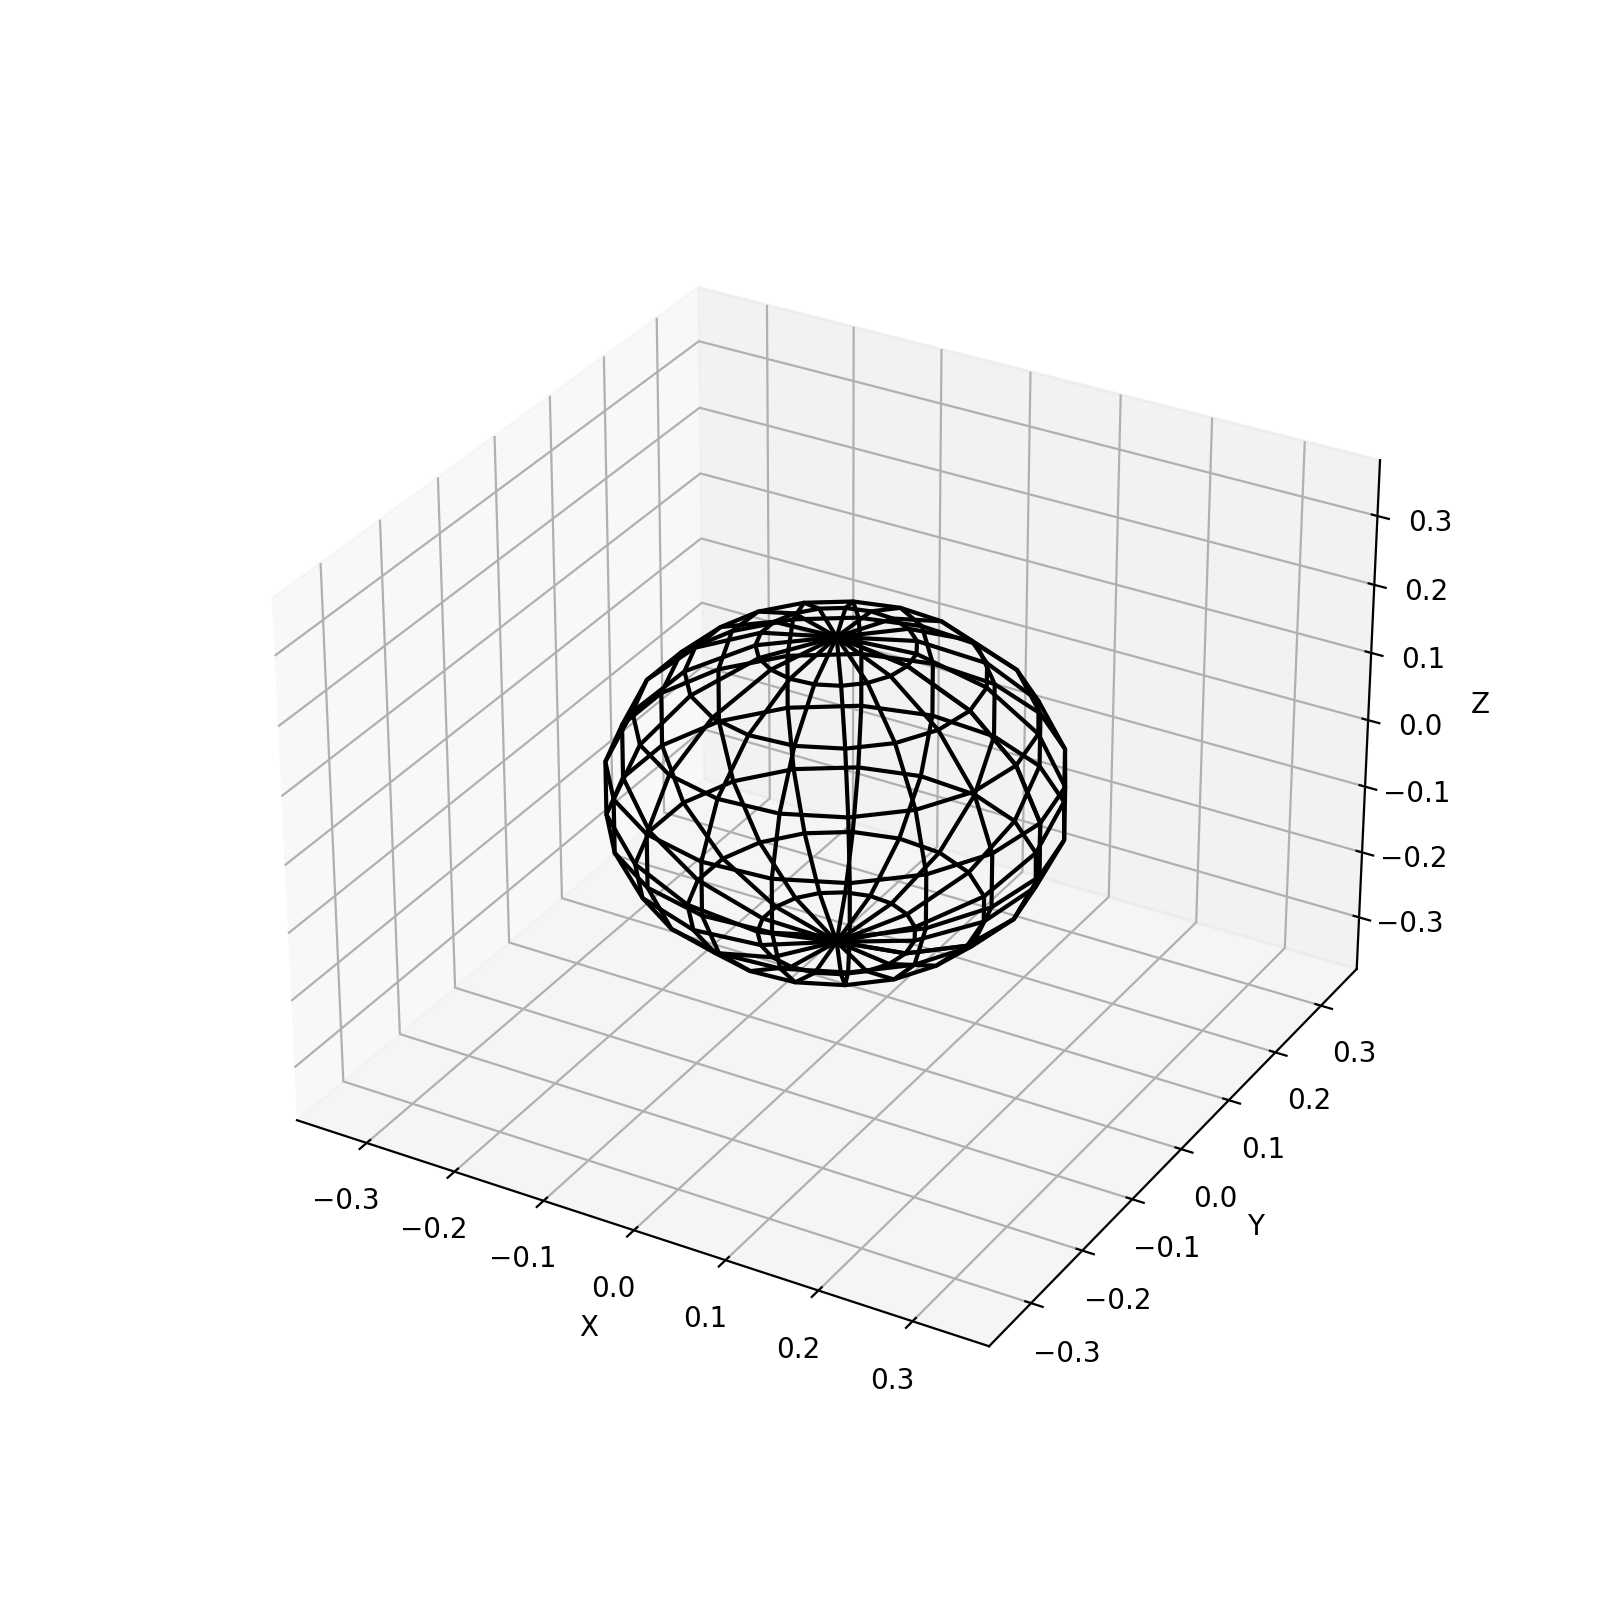

In [33]:
if run_visualization:
    %matplotlib notebook
    fig = plt.subplots(figsize=(8,8))
    ax = plt.axes(projection='3d')

    # Plot filaments
    for fil in f_list:
        fil.Plot3(ax)

    # Plot sphere wireframe
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = R*np.cos(u)*np.sin(v)
    y = R*np.sin(u)*np.sin(v)
    z = R*np.cos(v)
    ax.plot_wireframe(x, y, z, color="black")

    ax.set_xlim3d(-R-Lmax/2, R+Lmax/2)
    ax.set_ylim3d(-R-Lmax/2, R+Lmax/2)
    ax.set_zlim3d(-R-Lmax/2, R+Lmax/2)
    ax.set(xlabel='X', ylabel='Y', zlabel='Z')

In [12]:
if write_file:
    
    # first offset system
    for fil in f_list:
        fil.pos_start += np.array(system_offset)
        fil.pos_end += np.array(system_offset)
        fil.center += np.array(system_offset)
    filer = open(fname,"w")
    filer.write('# Initial configuration of rods\n#\n')
    for fil in f_list:
        filer.write( fil.GetStringtoWrite() )
    filer.close()

## Tests:

### Minimum distance function:

In [13]:
if run_tests:
    # parallel lines with separation 1 in X
    gid=0
    f1 = Filament([0,0,0], [0,0,1],2)
    f2 = Filament([1,0,0], [0,0,1],2)
    print('Expected Distance =   1.0\nCalculated Distance = {}\n'.format(minDistBetweenTwoFil(f1,f2)))

    # parallel lines with separation 1 in X and Y
    gid=0
    f1 = Filament([0,0,0], [0,0,1],2)
    f2 = Filament([1,0,1], [0,0,1],2)
    print('Expected Distance =   1.0\nCalculated Distance = {}\n'.format(minDistBetweenTwoFil(f1,f2)))

    # parallel overlapping lines with only endpoints touching
    gid=0
    f1 = Filament([0,0,0], [0,0,1],2)
    f2 = Filament([0,0,2], [0,0,1],2)
    print('Expected Distance =   0.0\nCalculated Distance = {}\n'.format(minDistBetweenTwoFil(f1,f2)))

    # parallel overlapping lines with one line inside another
    gid=0
    f1 = Filament([0,0,0], [0,0,1],1)
    f2 = Filament([0,0,0], [0,0,1],2)
    print('Expected Distance =   0.0\nCalculated Distance = {}\n'.format(minDistBetweenTwoFil(f1,f2)))

    # parallel lines with same XY and separated in Z by 1
    gid=0
    f1 = Filament([0,0,0], [0,0,1],2)
    f2 = Filament([0,0,3], [0,0,1],2)
    print('Expected Distance =   1.0\nCalculated Distance = {}\n'.format(minDistBetweenTwoFil(f1,f2)))


### Uniform Centers Distribution:

In [22]:
if run_tests:
    xs = []
    ys = []
    zs = []
    rs = []
    thetas = []
    phis=[]
    for k in range(5000):
        center = getRand3PointInSphere(R)
        xs.append( center[0])
        ys.append( center[1])
        zs.append( center[2])
        rpt = cart2sph( center[0], center[1], center[2])
        rs.append( rpt[0])
        thetas.append(rpt[2])
        phis.append(rpt[1])

    %matplotlib inline
    fig,axs = plt.subplots(2,3, figsize=(15, 10), sharey=True,tight_layout=True)
    axs[0,0].hist( xs, bins=10)
    axs[0,0].set(xlabel='X',ylabel='Counts')
    axs[0,1].hist( ys, bins=10)
    axs[0,1].set(xlabel='Y')
    axs[0,2].hist( zs, bins=10)
    axs[0,2].set(xlabel='Z')
    axs[1,0].hist( rs, bins=10)
    axs[1,0].set(xlabel='r',ylabel='Counts')
    axs[1,1].hist( phis, bins=10)
    axs[1,1].set(xlabel='phi')
    axs[1,2].hist( thetas, bins=10)
    axs[1,2].set(xlabel='theta')

    plt.suptitle('test')
    plt.show()
    %matplotlib notebook

    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection='3d')
    ax.scatter(xs,ys,zs, marker='.',s=4)

### Length Exponential Distribution:

In [31]:
if run_tests:
    nFil = 100000
    lens = []
    for i in range(nFil):
        lens.append( getLengthRandomExp(rng, Lmean, Lmin, Lmax))

    fig = plt.subplots(figsize=(8,6))
    ax = plt.axes()
    ax.hist( lens, bins=15)

    ax.set(xlabel='Length (micron)', ylabel='Count', title='Exponential distribution (mean = {} micron)'.format(Lmean))